# Dataset available at kaggle

https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

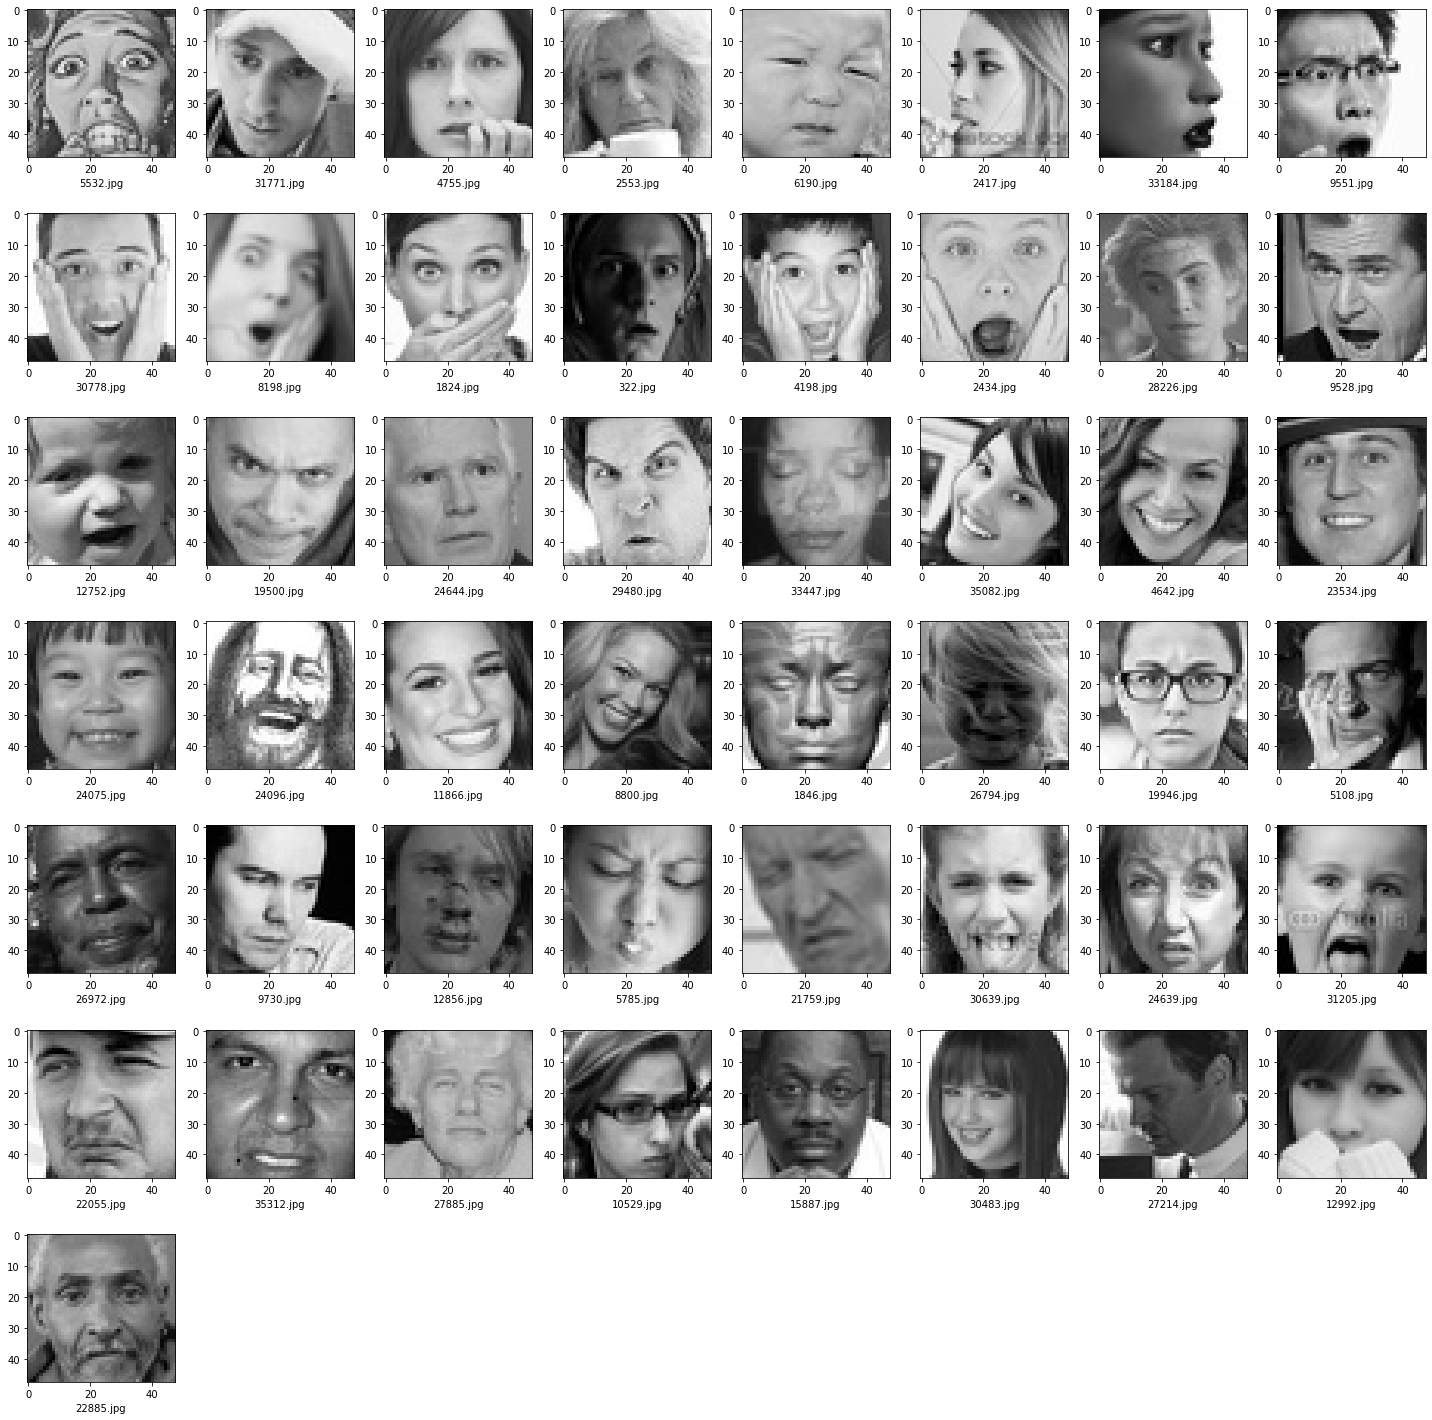

# Install libraries, packages and dataset

In [ ]:
!git clone https://github.com/parth1620/Facial-Expression-Dataset.git
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install timm
!pip install --upgrade opencv-contrib-python

fatal: destination path 'Facial-Expression-Dataset' already exists and is not an empty directory.
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-saomkbjz
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-saomkbjz
  Resolved https://github.com/albumentations-team/albumentations to commit 9eeb60d8d8ca08d5b34700ae2297e616edbb6730
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# Configurations

In [ ]:
TRAIN_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/train'
VALID_IMG_FOLDER_PATH='/content/Facial-Expression-Dataset/validation'

LR=0.001
BATCH_SIZE=32
EPOCHS=15

DEVICE='cuda'
MODEL_NAME='efficientnet_b0'

# Load Dataset

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms as T

In [ ]:
train_augs=T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=(-20,+20)),
    T.ToTensor()
])

valid_augs=T.Compose([
    T.ToTensor()
])

In [ ]:
trainset=ImageFolder(TRAIN_IMG_FOLDER_PATH, transform=train_augs )
validset=ImageFolder(VALID_IMG_FOLDER_PATH, transform=valid_augs)

In [ ]:
print(f"Total no. of examples in trainset : {len(trainset)}")
print(f"Total no. of examples in validset : {len(validset)}")

Total no. of examples in trainset : 28821
Total no. of examples in validset : 7066


In [ ]:
print(trainset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


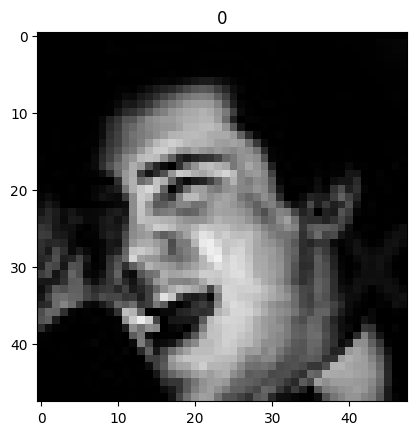

In [ ]:
image,label=trainset[40]

plt.imshow(image.permute(1,2,0))
plt.title(label );

# Load Dataset into Batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader=DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader=DataLoader(validset, batch_size=BATCH_SIZE)


In [ ]:
print(f"Total no. of batches in trainloader : {len(trainloader)}")
print(f"Total no. of batches in validloader : {len(validloader)}")

Total no. of batches in trainloader : 901
Total no. of batches in validloader : 221


In [ ]:
for images, labels in trainloader:
      break;
print(f"One image batch shape : {images.shape}")
print(f"One label batch shape : {labels.shape}")

One image batch shape : torch.Size([32, 3, 48, 48])
One label batch shape : torch.Size([32])


# Create Model

In [ ]:
import timm
from torch import nn

In [ ]:
class FaceModel(nn.Module):
  def __init__(self):
    super(FaceModel,self).__init__()

    self.eff_net=timm.create_model('efficientnet_b0',pretrained=True,num_classes=7)

  def forward(self,images,labels=None):
    logits=self.eff_net(images)

    if labels !=None:
      loss=nn.CrossEntropyLoss()(logits,labels)
      return loss,logits

    return logits



In [ ]:
model=FaceModel()
model.to(DEVICE)

FaceModel(
  (eff_net): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv

# Create Train and Eval Function

In [ ]:
from tqdm import tqdm

In [ ]:
def multiclass_accuracy(y_pred,y_true):
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))



In [ ]:
def train_fn(model, dataloader,optimizer,current_epo ):
    model.train()
    total_loss=0.0
    total_acc=0.0
    tk=tqdm(dataloader, desc="EPOCH"+"[TRAIN]"+str(current_epo+1)+"/"+str(EPOCHS))

    for t , data in enumerate(tk):
      images,labels=data
      images,labels=images.to(DEVICE),labels.to(DEVICE)

      optimizer.zero_grad()
      loss,logits=model(images,labels)
      print(f"Logits shape: {logits.shape}")
      loss = loss.mean()
      loss.backward()

      optimizer.step()
      total_loss+=loss.item()
      total_acc+=multiclass_accuracy(logits,labels)
      tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)), 'acc' :'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)


In [ ]:
def eval_fn(model, dataloader,current_epo ):
    model.eval()
    total_loss=0.0
    total_acc=0.0
    tk=tqdm(dataloader, desc="EPOCH"+"[VALID]"+str(current_epo+1)+"/"+str(EPOCHS))

    for t , data in enumerate(tk):
      images,labels=data
      images,labels=images.to(DEVICE),labels.to(DEVICE)

      loss , logits=model(images,labels)
      print(f"Logits shape: {logits.shape}")

      total_loss+=loss.item()
      total_acc+=multiclass_accuracy(logits,labels)
      tk.set_postfix({'loss' : '%6f' %float(total_loss/(t+1)), 'acc' :'%6f' %float(total_acc/(t+1))})
    return total_loss/len(dataloader),total_acc/len(dataloader)

# Create Training Loop

In [ ]:
optimizer=torch.optim.Adam(model.parameters(),lr=LR)

In [ ]:
best_valid_loss=np.Inf

for i in range(EPOCHS):
  train_loss,train_acc=train_fn(model , trainloader , optimizer  , i )
  valid_loss,valid_acc=eval_fn(model,validloader,i)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best-weights.pt')
    print("Saved-best-weights")
    best_valid_loss=valid_loss

EPOCH[TRAIN]1/15:   0%|          | 0/901 [00:00<?, ?it/s]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   0%|          | 3/901 [00:00<01:41,  8.88it/s, loss=6.750230, acc=0.179688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   1%|          | 9/901 [00:00<00:58, 15.24it/s, loss=6.617329, acc=0.166667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   1%|▏         | 12/901 [00:00<00:52, 17.08it/s, loss=6.317105, acc=0.177885]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   2%|▏         | 16/901 [00:01<00:49, 17.74it/s, loss=6.357549, acc=0.170956]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   2%|▏         | 21/901 [00:01<00:46, 18.91it/s, loss=6.218279, acc=0.183036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   3%|▎         | 26/901 [00:01<00:45, 19.10it/s, loss=5.945319, acc=0.193510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   3%|▎         | 30/901 [00:01<00:46, 18.75it/s, loss=5.902256, acc=0.198958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   4%|▍         | 34/901 [00:02<00:48, 17.88it/s, loss=5.738300, acc=0.205882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   4%|▍         | 36/901 [00:02<00:48, 17.79it/s, loss=5.658367, acc=0.206414]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   5%|▍         | 41/901 [00:02<00:45, 18.76it/s, loss=5.498138, acc=0.210565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   5%|▌         | 46/901 [00:02<00:43, 19.58it/s, loss=5.343382, acc=0.217391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   6%|▌         | 51/901 [00:02<00:43, 19.72it/s, loss=5.194997, acc=0.220588]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   6%|▌         | 55/901 [00:03<00:45, 18.70it/s, loss=5.083208, acc=0.222727]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   6%|▋         | 57/901 [00:03<00:44, 18.81it/s, loss=4.966194, acc=0.221928]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   7%|▋         | 63/901 [00:03<00:42, 19.72it/s, loss=4.828743, acc=0.224609]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   8%|▊         | 68/901 [00:03<00:41, 19.98it/s, loss=4.692285, acc=0.225543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   8%|▊         | 72/901 [00:04<00:51, 16.21it/s, loss=4.621551, acc=0.226128]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   8%|▊         | 74/901 [00:04<00:54, 15.15it/s, loss=4.540341, acc=0.225833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   9%|▊         | 78/901 [00:04<00:54, 15.02it/s, loss=4.474510, acc=0.227163]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   9%|▉         | 82/901 [00:04<00:55, 14.85it/s, loss=4.375274, acc=0.229421]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:   9%|▉         | 84/901 [00:04<00:54, 14.95it/s, loss=4.320657, acc=0.227941]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  10%|▉         | 88/901 [00:05<00:56, 14.44it/s, loss=4.263580, acc=0.226562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  10%|▉         | 90/901 [00:05<00:58, 13.91it/s, loss=4.195290, acc=0.229052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  10%|█         | 94/901 [00:05<00:58, 13.88it/s, loss=4.129496, acc=0.231715]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  11%|█         | 96/901 [00:05<00:58, 13.71it/s, loss=4.066149, acc=0.232603]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  11%|█         | 98/901 [00:06<01:02, 12.93it/s, loss=4.028598, acc=0.233902]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  12%|█▏        | 104/901 [00:06<00:54, 14.56it/s, loss=3.945675, acc=0.234976]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  12%|█▏        | 108/901 [00:06<00:47, 16.59it/s, loss=3.878176, acc=0.236111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  12%|█▏        | 112/901 [00:06<00:44, 17.87it/s, loss=3.817290, acc=0.237723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  13%|█▎        | 114/901 [00:07<00:43, 18.24it/s, loss=3.761055, acc=0.237877]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  13%|█▎        | 120/901 [00:07<00:42, 18.37it/s, loss=3.697153, acc=0.239323]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  14%|█▎        | 122/901 [00:07<00:42, 18.34it/s, loss=3.643470, acc=0.240675]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  14%|█▍        | 128/901 [00:07<00:39, 19.45it/s, loss=3.595293, acc=0.242188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  15%|█▍        | 131/901 [00:07<00:38, 19.84it/s, loss=3.536266, acc=0.241776]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  15%|█▌        | 136/901 [00:08<00:41, 18.40it/s, loss=3.504057, acc=0.241498]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  16%|█▌        | 141/901 [00:08<00:40, 18.87it/s, loss=3.448911, acc=0.242686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  16%|█▌        | 144/901 [00:08<00:40, 18.76it/s, loss=3.409771, acc=0.243966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  17%|█▋        | 149/901 [00:08<00:38, 19.44it/s, loss=3.365825, acc=0.244966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  17%|█▋        | 154/901 [00:09<00:40, 18.56it/s, loss=3.320266, acc=0.245942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  18%|█▊        | 158/901 [00:09<00:39, 18.64it/s, loss=3.283980, acc=0.247429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  18%|█▊        | 162/901 [00:09<00:39, 18.52it/s, loss=3.246824, acc=0.249421]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  18%|█▊        | 166/901 [00:09<00:38, 19.11it/s, loss=3.213969, acc=0.250565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  19%|█▉        | 170/901 [00:09<00:37, 19.50it/s, loss=3.169758, acc=0.254020]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  19%|█▉        | 174/901 [00:10<00:41, 17.66it/s, loss=3.137317, acc=0.256429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  20%|█▉        | 178/901 [00:10<00:39, 18.33it/s, loss=3.108826, acc=0.257507]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  20%|██        | 182/901 [00:10<00:38, 18.66it/s, loss=3.081555, acc=0.257343]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  21%|██        | 186/901 [00:10<00:37, 19.10it/s, loss=3.052708, acc=0.258857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  21%|██        | 190/901 [00:11<00:37, 18.73it/s, loss=3.018713, acc=0.260579]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  22%|██▏       | 194/901 [00:11<00:38, 18.43it/s, loss=2.993494, acc=0.261798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  22%|██▏       | 199/901 [00:11<00:37, 18.90it/s, loss=2.969014, acc=0.262344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  23%|██▎       | 203/901 [00:11<00:36, 19.06it/s, loss=2.945536, acc=0.262255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  23%|██▎       | 208/901 [00:11<00:35, 19.66it/s, loss=2.922856, acc=0.263071]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  23%|██▎       | 210/901 [00:12<00:38, 18.00it/s, loss=2.898470, acc=0.264593]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  24%|██▍       | 216/901 [00:12<00:36, 18.85it/s, loss=2.875518, acc=0.266204]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  24%|██▍       | 220/901 [00:12<00:35, 19.01it/s, loss=2.850314, acc=0.266827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  25%|██▍       | 224/901 [00:12<00:35, 19.30it/s, loss=2.831686, acc=0.267778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  25%|██▌       | 229/901 [00:13<00:36, 18.60it/s, loss=2.807122, acc=0.268886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  26%|██▌       | 234/901 [00:13<00:34, 19.20it/s, loss=2.787841, acc=0.269498]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  26%|██▋       | 238/901 [00:13<00:34, 18.96it/s, loss=2.771146, acc=0.269564]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  27%|██▋       | 240/901 [00:13<00:34, 19.16it/s, loss=2.755474, acc=0.269628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  27%|██▋       | 246/901 [00:13<00:32, 19.93it/s, loss=2.732140, acc=0.271761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  28%|██▊       | 250/901 [00:14<00:34, 18.71it/s, loss=2.715091, acc=0.273406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  28%|██▊       | 255/901 [00:14<00:33, 19.53it/s, loss=2.699718, acc=0.274265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  29%|██▊       | 259/901 [00:14<00:33, 19.11it/s, loss=2.679558, acc=0.275721]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  29%|██▉       | 264/901 [00:14<00:32, 19.82it/s, loss=2.663569, acc=0.277344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  30%|██▉       | 268/901 [00:15<00:34, 18.28it/s, loss=2.649882, acc=0.277752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  30%|███       | 273/901 [00:15<00:32, 19.29it/s, loss=2.631263, acc=0.279991]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  31%|███       | 277/901 [00:15<00:32, 18.96it/s, loss=2.617923, acc=0.281250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  31%|███       | 279/901 [00:15<00:32, 18.91it/s, loss=2.604614, acc=0.281917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  32%|███▏      | 285/901 [00:16<00:32, 19.14it/s, loss=2.588543, acc=0.283435]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  32%|███▏      | 290/901 [00:16<00:32, 18.70it/s, loss=2.577489, acc=0.283944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  32%|███▏      | 292/901 [00:16<00:35, 16.98it/s, loss=2.568769, acc=0.284236]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  33%|███▎      | 296/901 [00:16<00:39, 15.20it/s, loss=2.559675, acc=0.285156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  33%|███▎      | 298/901 [00:16<00:40, 14.99it/s, loss=2.551293, acc=0.285326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  34%|███▎      | 302/901 [00:17<00:42, 14.19it/s, loss=2.543005, acc=0.285700]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  34%|███▎      | 304/901 [00:17<00:42, 14.16it/s, loss=2.534061, acc=0.286885]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  34%|███▍      | 308/901 [00:17<00:41, 14.43it/s, loss=2.523853, acc=0.287318]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  35%|███▍      | 312/901 [00:17<00:43, 13.58it/s, loss=2.514396, acc=0.288361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  35%|███▍      | 314/901 [00:17<00:45, 12.95it/s, loss=2.509446, acc=0.288615]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  35%|███▌      | 318/901 [00:18<00:44, 13.01it/s, loss=2.500069, acc=0.289112]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  36%|███▌      | 320/901 [00:18<00:44, 12.98it/s, loss=2.491947, acc=0.289914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  36%|███▌      | 324/901 [00:18<00:40, 14.19it/s, loss=2.479695, acc=0.292115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  36%|███▋      | 328/901 [00:18<00:37, 15.31it/s, loss=2.472222, acc=0.292873]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  37%|███▋      | 332/901 [00:19<00:34, 16.59it/s, loss=2.459966, acc=0.294482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  37%|███▋      | 336/901 [00:19<00:32, 17.65it/s, loss=2.448701, acc=0.295901]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  38%|███▊      | 340/901 [00:19<00:31, 17.97it/s, loss=2.440328, acc=0.297196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  38%|███▊      | 344/901 [00:19<00:29, 18.79it/s, loss=2.430175, acc=0.298007]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  39%|███▊      | 348/901 [00:20<00:31, 17.72it/s, loss=2.417557, acc=0.300501]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  39%|███▉      | 352/901 [00:20<00:29, 18.55it/s, loss=2.408705, acc=0.301257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  40%|███▉      | 357/901 [00:20<00:28, 19.05it/s, loss=2.399501, acc=0.302521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  40%|████      | 361/901 [00:20<00:29, 18.60it/s, loss=2.389646, acc=0.303843]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  41%|████      | 365/901 [00:20<00:28, 18.52it/s, loss=2.380456, acc=0.304709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  41%|████      | 369/901 [00:21<00:28, 18.45it/s, loss=2.372737, acc=0.305301]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  41%|████▏     | 373/901 [00:21<00:28, 18.82it/s, loss=2.366483, acc=0.305714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  42%|████▏     | 377/901 [00:21<00:27, 19.27it/s, loss=2.358011, acc=0.306034]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  42%|████▏     | 381/901 [00:21<00:27, 19.22it/s, loss=2.347788, acc=0.307264]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  43%|████▎     | 385/901 [00:22<00:28, 17.92it/s, loss=2.342170, acc=0.308036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  43%|████▎     | 390/901 [00:22<00:27, 18.87it/s, loss=2.332524, acc=0.309215]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  44%|████▎     | 394/901 [00:22<00:26, 19.02it/s, loss=2.323233, acc=0.310364]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  44%|████▍     | 398/901 [00:22<00:27, 18.03it/s, loss=2.315379, acc=0.311325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  45%|████▍     | 402/901 [00:23<00:27, 18.06it/s, loss=2.308345, acc=0.312345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  45%|████▌     | 406/901 [00:23<00:28, 17.32it/s, loss=2.300497, acc=0.313575]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  46%|████▌     | 410/901 [00:23<00:27, 18.14it/s, loss=2.293178, acc=0.314325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  46%|████▌     | 414/901 [00:23<00:26, 18.63it/s, loss=2.285758, acc=0.315361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  46%|████▋     | 418/901 [00:23<00:25, 18.65it/s, loss=2.279195, acc=0.315483]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  47%|████▋     | 422/901 [00:24<00:27, 17.68it/s, loss=2.272496, acc=0.316120]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  47%|████▋     | 426/901 [00:24<00:25, 18.48it/s, loss=2.266144, acc=0.316745]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  48%|████▊     | 430/901 [00:24<00:25, 18.73it/s, loss=2.259101, acc=0.317575]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  48%|████▊     | 435/901 [00:24<00:24, 18.95it/s, loss=2.252434, acc=0.318032]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  49%|████▊     | 439/901 [00:24<00:24, 18.71it/s, loss=2.246137, acc=0.318195]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  49%|████▉     | 443/901 [00:25<00:24, 18.37it/s, loss=2.239361, acc=0.319413]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  50%|████▉     | 447/901 [00:25<00:24, 18.43it/s, loss=2.233654, acc=0.320190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  50%|█████     | 451/901 [00:25<00:23, 18.85it/s, loss=2.227636, acc=0.320676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  50%|█████     | 455/901 [00:25<00:23, 18.72it/s, loss=2.220411, acc=0.322115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  51%|█████     | 459/901 [00:26<00:24, 17.91it/s, loss=2.213177, acc=0.323325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  51%|█████▏    | 463/901 [00:26<00:23, 18.32it/s, loss=2.208550, acc=0.323502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  52%|█████▏    | 467/901 [00:26<00:23, 18.84it/s, loss=2.203308, acc=0.323943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  52%|█████▏    | 471/901 [00:26<00:22, 19.16it/s, loss=2.197214, acc=0.324708]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  53%|█████▎    | 475/901 [00:26<00:22, 19.07it/s, loss=2.191751, acc=0.325395]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  53%|█████▎    | 477/901 [00:27<00:24, 17.49it/s, loss=2.186760, acc=0.326425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  53%|█████▎    | 482/901 [00:27<00:22, 18.55it/s, loss=2.181538, acc=0.326540]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  54%|█████▍    | 486/901 [00:27<00:21, 19.13it/s, loss=2.175239, acc=0.327293]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  55%|█████▍    | 493/901 [00:27<00:21, 19.25it/s, loss=2.167970, acc=0.328410]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  55%|█████▍    | 495/901 [00:28<00:22, 18.09it/s, loss=2.164170, acc=0.328881]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  56%|█████▌    | 501/901 [00:28<00:21, 18.49it/s, loss=2.158084, acc=0.329965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  56%|█████▌    | 505/901 [00:28<00:21, 18.84it/s, loss=2.152852, acc=0.330507]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  56%|█████▋    | 507/901 [00:28<00:22, 17.63it/s, loss=2.148771, acc=0.330770]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  57%|█████▋    | 511/901 [00:28<00:25, 15.40it/s, loss=2.144635, acc=0.331152]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  57%|█████▋    | 513/901 [00:29<00:26, 14.40it/s, loss=2.141024, acc=0.331894]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  57%|█████▋    | 517/901 [00:29<00:25, 15.05it/s, loss=2.136609, acc=0.332447]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  58%|█████▊    | 521/901 [00:29<00:25, 15.20it/s, loss=2.131378, acc=0.333193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  58%|█████▊    | 525/901 [00:29<00:25, 14.62it/s, loss=2.125703, acc=0.333988]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  58%|█████▊    | 527/901 [00:30<00:29, 12.79it/s, loss=2.123448, acc=0.334144]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  59%|█████▉    | 531/901 [00:30<00:28, 13.01it/s, loss=2.118877, acc=0.334805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  59%|█████▉    | 533/901 [00:30<00:28, 13.09it/s, loss=2.115400, acc=0.335382]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  60%|█████▉    | 537/901 [00:30<00:26, 13.64it/s, loss=2.111604, acc=0.336068]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  60%|█████▉    | 539/901 [00:31<00:29, 12.45it/s, loss=2.108787, acc=0.336227]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  60%|██████    | 543/901 [00:31<00:24, 14.72it/s, loss=2.104378, acc=0.336857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  61%|██████    | 547/901 [00:31<00:21, 16.39it/s, loss=2.099272, acc=0.337192]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  61%|██████    | 551/901 [00:31<00:20, 16.84it/s, loss=2.097033, acc=0.337114]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  62%|██████▏   | 555/901 [00:31<00:20, 17.08it/s, loss=2.092302, acc=0.337669]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  62%|██████▏   | 559/901 [00:32<00:19, 17.19it/s, loss=2.086802, acc=0.338951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  62%|██████▏   | 563/901 [00:32<00:18, 18.21it/s, loss=2.082821, acc=0.339539]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  63%|██████▎   | 568/901 [00:32<00:17, 19.28it/s, loss=2.077547, acc=0.339851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  63%|██████▎   | 572/901 [00:32<00:17, 19.34it/s, loss=2.073446, acc=0.340314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  64%|██████▍   | 576/901 [00:33<00:18, 17.39it/s, loss=2.070201, acc=0.340875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  64%|██████▍   | 580/901 [00:33<00:17, 18.28it/s, loss=2.065579, acc=0.341168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  65%|██████▍   | 584/901 [00:33<00:17, 18.59it/s, loss=2.061396, acc=0.341720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  65%|██████▌   | 588/901 [00:33<00:16, 18.91it/s, loss=2.057850, acc=0.342371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  66%|██████▌   | 592/901 [00:33<00:16, 18.99it/s, loss=2.054326, acc=0.343065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  66%|██████▋   | 598/901 [00:34<00:16, 18.39it/s, loss=2.048632, acc=0.344429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  67%|██████▋   | 602/901 [00:34<00:15, 18.86it/s, loss=2.045647, acc=0.344425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  67%|██████▋   | 606/901 [00:34<00:15, 19.17it/s, loss=2.042571, acc=0.344627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  68%|██████▊   | 610/901 [00:34<00:15, 19.13it/s, loss=2.039102, acc=0.345133]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  68%|██████▊   | 612/901 [00:35<00:16, 17.50it/s, loss=2.036105, acc=0.345534]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  69%|██████▊   | 618/901 [00:35<00:15, 18.28it/s, loss=2.031150, acc=0.346228]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  69%|██████▉   | 622/901 [00:35<00:15, 18.38it/s, loss=2.026894, acc=0.347166]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  69%|██████▉   | 624/901 [00:35<00:14, 18.63it/s, loss=2.023954, acc=0.347244]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  70%|███████   | 631/901 [00:36<00:15, 18.00it/s, loss=2.019058, acc=0.348257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  70%|███████   | 633/901 [00:36<00:15, 17.69it/s, loss=2.016340, acc=0.348425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  71%|███████   | 640/901 [00:36<00:13, 19.00it/s, loss=2.012527, acc=0.348682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  71%|███████▏  | 644/901 [00:36<00:13, 19.23it/s, loss=2.008800, acc=0.349330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  72%|███████▏  | 648/901 [00:36<00:13, 18.47it/s, loss=2.004831, acc=0.350116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  72%|███████▏  | 652/901 [00:37<00:14, 17.57it/s, loss=2.001613, acc=0.350508]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  73%|███████▎  | 656/901 [00:37<00:13, 18.22it/s, loss=1.998623, acc=0.351038]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  73%|███████▎  | 658/901 [00:37<00:13, 18.18it/s, loss=1.995986, acc=0.351042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  74%|███████▎  | 663/901 [00:37<00:12, 18.69it/s, loss=1.991940, acc=0.351939]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  74%|███████▍  | 667/901 [00:38<00:13, 17.70it/s, loss=1.989555, acc=0.352183]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  74%|███████▍  | 671/901 [00:38<00:12, 17.91it/s, loss=1.985535, acc=0.352911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  75%|███████▍  | 675/901 [00:38<00:12, 18.54it/s, loss=1.982214, acc=0.353550]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  75%|███████▌  | 679/901 [00:38<00:11, 18.58it/s, loss=1.979094, acc=0.353952]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  76%|███████▌  | 683/901 [00:38<00:11, 18.79it/s, loss=1.975818, acc=0.354304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  76%|███████▌  | 687/901 [00:39<00:11, 17.91it/s, loss=1.972772, acc=0.355015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  77%|███████▋  | 691/901 [00:39<00:11, 17.69it/s, loss=1.969542, acc=0.355582]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  77%|███████▋  | 695/901 [00:39<00:11, 18.61it/s, loss=1.966370, acc=0.356097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  78%|███████▊  | 699/901 [00:39<00:10, 19.12it/s, loss=1.963715, acc=0.356696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  78%|███████▊  | 703/901 [00:40<00:10, 18.44it/s, loss=1.960567, acc=0.357244]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  79%|███████▊  | 709/901 [00:40<00:10, 17.82it/s, loss=1.957292, acc=0.357766]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  79%|███████▉  | 713/901 [00:40<00:10, 18.20it/s, loss=1.954293, acc=0.358126]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  80%|███████▉  | 717/901 [00:40<00:09, 18.52it/s, loss=1.951319, acc=0.358569]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  80%|████████  | 721/901 [00:40<00:10, 17.82it/s, loss=1.948692, acc=0.359050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  80%|████████  | 725/901 [00:41<00:11, 15.24it/s, loss=1.945932, acc=0.359612]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  81%|████████  | 727/901 [00:41<00:11, 14.68it/s, loss=1.943541, acc=0.360148]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  81%|████████  | 731/901 [00:41<00:11, 14.86it/s, loss=1.941446, acc=0.360551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  82%|████████▏ | 735/901 [00:41<00:11, 14.23it/s, loss=1.938868, acc=0.361182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  82%|████████▏ | 737/901 [00:42<00:11, 14.12it/s, loss=1.936285, acc=0.361958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  82%|████████▏ | 741/901 [00:42<00:10, 14.74it/s, loss=1.933611, acc=0.362281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  83%|████████▎ | 745/901 [00:42<00:11, 14.12it/s, loss=1.931661, acc=0.362668]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  83%|████████▎ | 747/901 [00:42<00:11, 13.99it/s, loss=1.930287, acc=0.362968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  83%|████████▎ | 751/901 [00:43<00:11, 12.99it/s, loss=1.928158, acc=0.363432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  84%|████████▎ | 753/901 [00:43<00:11, 13.37it/s, loss=1.926363, acc=0.363644]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  84%|████████▍ | 757/901 [00:43<00:10, 13.13it/s, loss=1.924082, acc=0.364143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  84%|████████▍ | 761/901 [00:43<00:09, 15.38it/s, loss=1.922113, acc=0.364241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  85%|████████▍ | 765/901 [00:44<00:08, 16.22it/s, loss=1.919902, acc=0.364502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  85%|████████▌ | 769/901 [00:44<00:07, 17.53it/s, loss=1.917915, acc=0.364678]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  86%|████████▌ | 773/901 [00:44<00:07, 18.16it/s, loss=1.915542, acc=0.365176]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  86%|████████▌ | 775/901 [00:44<00:06, 18.22it/s, loss=1.912086, acc=0.366152]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  87%|████████▋ | 782/901 [00:44<00:06, 18.42it/s, loss=1.909177, acc=0.366608]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  87%|████████▋ | 786/901 [00:45<00:06, 18.34it/s, loss=1.906370, acc=0.367247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  88%|████████▊ | 790/901 [00:45<00:06, 18.36it/s, loss=1.904296, acc=0.367445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  88%|████████▊ | 794/901 [00:45<00:05, 18.53it/s, loss=1.902056, acc=0.367994]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  89%|████████▊ | 798/901 [00:45<00:05, 18.88it/s, loss=1.900238, acc=0.368225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  89%|████████▉ | 802/901 [00:46<00:05, 17.81it/s, loss=1.897667, acc=0.368844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  89%|████████▉ | 806/901 [00:46<00:05, 18.71it/s, loss=1.895570, acc=0.369223]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  90%|████████▉ | 810/901 [00:46<00:04, 18.64it/s, loss=1.892596, acc=0.369875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  90%|█████████ | 814/901 [00:46<00:04, 19.13it/s, loss=1.890532, acc=0.370130]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  91%|█████████ | 818/901 [00:46<00:04, 19.07it/s, loss=1.888081, acc=0.370574]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  91%|█████████ | 822/901 [00:47<00:04, 18.33it/s, loss=1.886168, acc=0.370861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  92%|█████████▏| 826/901 [00:47<00:04, 18.52it/s, loss=1.884201, acc=0.370995]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  92%|█████████▏| 830/901 [00:47<00:04, 17.69it/s, loss=1.882380, acc=0.371239]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  93%|█████████▎| 834/901 [00:47<00:03, 18.34it/s, loss=1.880341, acc=0.371482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  93%|█████████▎| 838/901 [00:48<00:03, 17.23it/s, loss=1.878851, acc=0.371644]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  93%|█████████▎| 842/901 [00:48<00:03, 17.90it/s, loss=1.876092, acc=0.372109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  94%|█████████▍| 846/901 [00:48<00:02, 18.50it/s, loss=1.874618, acc=0.372417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  94%|█████████▍| 850/901 [00:48<00:02, 18.69it/s, loss=1.872638, acc=0.372907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  95%|█████████▍| 854/901 [00:48<00:02, 18.89it/s, loss=1.871029, acc=0.373063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  95%|█████████▌| 858/901 [00:49<00:02, 17.61it/s, loss=1.869196, acc=0.373327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  96%|█████████▌| 862/901 [00:49<00:02, 18.42it/s, loss=1.867907, acc=0.373262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  96%|█████████▌| 866/901 [00:49<00:01, 18.49it/s, loss=1.865251, acc=0.373702]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  97%|█████████▋| 870/901 [00:49<00:01, 18.81it/s, loss=1.862990, acc=0.374211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  97%|█████████▋| 874/901 [00:50<00:01, 18.03it/s, loss=1.861025, acc=0.374536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  97%|█████████▋| 878/901 [00:50<00:01, 18.60it/s, loss=1.858823, acc=0.374964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  98%|█████████▊| 882/901 [00:50<00:01, 18.89it/s, loss=1.857184, acc=0.375142]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  98%|█████████▊| 886/901 [00:50<00:00, 17.91it/s, loss=1.854527, acc=0.375599]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  99%|█████████▉| 891/901 [00:50<00:00, 18.90it/s, loss=1.851904, acc=0.376228]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15:  99%|█████████▉| 895/901 [00:51<00:00, 17.93it/s, loss=1.849915, acc=0.376432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15: 100%|█████████▉| 899/901 [00:51<00:00, 18.65it/s, loss=1.848019, acc=0.376773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]1/15: 100%|██████████| 901/901 [00:51<00:00, 17.46it/s, loss=1.846898, acc=0.376899]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]1/15:   3%|▎         | 7/221 [00:00<00:06, 32.28it/s, loss=1.499917, acc=0.312500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:   5%|▍         | 11/221 [00:00<00:06, 31.93it/s, loss=1.542812, acc=0.308036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:   9%|▊         | 19/221 [00:00<00:06, 32.52it/s, loss=1.548261, acc=0.318182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  12%|█▏        | 27/221 [00:00<00:05, 34.13it/s, loss=1.533396, acc=0.330208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  16%|█▌        | 35/221 [00:01<00:05, 33.17it/s, loss=1.709736, acc=0.283784]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  19%|█▉        | 43/221 [00:01<00:05, 33.45it/s, loss=1.692058, acc=0.273438]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  21%|██▏       | 47/221 [00:01<00:05, 31.54it/s, loss=1.690445, acc=0.266250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  25%|██▍       | 55/221 [00:01<00:05, 31.69it/s, loss=1.694306, acc=0.253838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  29%|██▊       | 63/221 [00:01<00:04, 32.70it/s, loss=1.686153, acc=0.245605]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  30%|███       | 67/221 [00:02<00:05, 30.56it/s, loss=1.651954, acc=0.266304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  33%|███▎      | 74/221 [00:02<00:05, 26.68it/s, loss=1.607152, acc=0.293074]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  36%|███▌      | 80/221 [00:02<00:05, 26.81it/s, loss=1.547409, acc=0.325781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  39%|███▉      | 87/221 [00:02<00:04, 28.39it/s, loss=1.501157, acc=0.353089]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  42%|████▏     | 93/221 [00:03<00:04, 27.75it/s, loss=1.462677, acc=0.377016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  45%|████▌     | 100/221 [00:03<00:04, 28.57it/s, loss=1.417359, acc=0.401875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  48%|████▊     | 106/221 [00:03<00:04, 27.57it/s, loss=1.383637, acc=0.420696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  51%|█████     | 112/221 [00:03<00:03, 27.96it/s, loss=1.359705, acc=0.435268]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  52%|█████▏    | 115/221 [00:03<00:04, 26.47it/s, loss=1.342569, acc=0.445513]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  55%|█████▍    | 121/221 [00:04<00:03, 25.41it/s, loss=1.325495, acc=0.454406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  57%|█████▋    | 127/221 [00:04<00:03, 25.34it/s, loss=1.325109, acc=0.457275]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  60%|██████    | 133/221 [00:04<00:03, 25.10it/s, loss=1.328898, acc=0.457090]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  63%|██████▎   | 139/221 [00:04<00:03, 24.86it/s, loss=1.325258, acc=0.462230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  66%|██████▌   | 145/221 [00:05<00:02, 25.34it/s, loss=1.328303, acc=0.465948]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  67%|██████▋   | 149/221 [00:05<00:02, 27.44it/s, loss=1.328346, acc=0.468133]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  71%|███████   | 157/221 [00:05<00:02, 29.33it/s, loss=1.324752, acc=0.471698]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  75%|███████▍  | 165/221 [00:05<00:01, 31.18it/s, loss=1.325864, acc=0.474209]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  78%|███████▊  | 173/221 [00:05<00:01, 32.56it/s, loss=1.327929, acc=0.475975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  80%|████████  | 177/221 [00:06<00:01, 32.77it/s, loss=1.328488, acc=0.477037]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  84%|████████▎ | 185/221 [00:06<00:01, 31.95it/s, loss=1.328114, acc=0.478059]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  87%|████████▋ | 193/221 [00:06<00:00, 31.11it/s, loss=1.328265, acc=0.479167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  91%|█████████ | 201/221 [00:06<00:00, 32.44it/s, loss=1.329129, acc=0.481745]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  95%|█████████▍| 209/221 [00:07<00:00, 33.12it/s, loss=1.329033, acc=0.485795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15:  96%|█████████▋| 213/221 [00:07<00:00, 33.24it/s, loss=1.328136, acc=0.488426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]1/15: 100%|██████████| 221/221 [00:07<00:00, 29.53it/s, loss=1.328219, acc=0.490841]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])


Saved-best-weights


EPOCH[TRAIN]2/15:   0%|          | 2/901 [00:00<00:57, 15.68it/s, loss=1.310700, acc=0.500000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   1%|          | 6/901 [00:00<00:54, 16.53it/s, loss=1.397642, acc=0.477679]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   1%|          | 8/901 [00:00<00:53, 16.70it/s, loss=1.373727, acc=0.500000]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   1%|          | 10/901 [00:00<00:51, 17.23it/s, loss=1.343801, acc=0.514205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   1%|▏         | 12/901 [00:00<00:50, 17.65it/s, loss=1.337440, acc=0.513021]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   2%|▏         | 14/901 [00:00<00:53, 16.55it/s, loss=1.351932, acc=0.500000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   2%|▏         | 14/901 [00:00<00:53, 16.55it/s, loss=1.354313, acc=0.497917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   2%|▏         | 18/901 [00:01<00:52, 16.96it/s, loss=1.335683, acc=0.500000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   2%|▏         | 20/901 [00:01<00:51, 17.24it/s, loss=1.322086, acc=0.503125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   2%|▏         | 22/901 [00:01<00:49, 17.83it/s, loss=1.316849, acc=0.508523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   3%|▎         | 24/901 [00:01<00:48, 18.20it/s, loss=1.324145, acc=0.505208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   3%|▎         | 26/901 [00:01<00:47, 18.35it/s, loss=1.333605, acc=0.501202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   3%|▎         | 28/901 [00:01<00:46, 18.58it/s, loss=1.343766, acc=0.495536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   3%|▎         | 30/901 [00:01<00:47, 18.45it/s, loss=1.348531, acc=0.491667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   3%|▎         | 30/901 [00:01<00:47, 18.45it/s, loss=1.351155, acc=0.489258]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   4%|▎         | 32/901 [00:01<00:50, 17.15it/s, loss=1.343248, acc=0.493371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   4%|▍         | 36/901 [00:02<00:48, 17.67it/s, loss=1.342548, acc=0.493924]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   4%|▍         | 38/901 [00:02<00:47, 17.99it/s, loss=1.340065, acc=0.494243]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   4%|▍         | 40/901 [00:02<00:46, 18.36it/s, loss=1.341854, acc=0.493750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   5%|▍         | 42/901 [00:02<00:46, 18.50it/s, loss=1.350408, acc=0.490327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   5%|▍         | 44/901 [00:02<00:45, 18.68it/s, loss=1.360395, acc=0.485795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   5%|▌         | 46/901 [00:02<00:45, 18.85it/s, loss=1.361141, acc=0.483016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   5%|▌         | 48/901 [00:02<00:48, 17.70it/s, loss=1.359541, acc=0.482422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   5%|▌         | 48/901 [00:02<00:48, 17.70it/s, loss=1.353583, acc=0.485969]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   6%|▌         | 50/901 [00:02<00:52, 16.18it/s, loss=1.349398, acc=0.485294]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   6%|▌         | 52/901 [00:03<00:51, 16.48it/s, loss=1.346719, acc=0.486439]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   6%|▌         | 56/901 [00:03<00:48, 17.42it/s, loss=1.350321, acc=0.482701]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   6%|▌         | 56/901 [00:03<00:48, 17.42it/s, loss=1.348514, acc=0.483553]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   7%|▋         | 60/901 [00:03<00:46, 17.98it/s, loss=1.351088, acc=0.483854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   7%|▋         | 60/901 [00:03<00:46, 17.98it/s, loss=1.353673, acc=0.481045]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   7%|▋         | 64/901 [00:03<00:45, 18.59it/s, loss=1.362493, acc=0.473633]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   7%|▋         | 64/901 [00:03<00:45, 18.59it/s, loss=1.366281, acc=0.472115]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   7%|▋         | 66/901 [00:03<00:45, 18.34it/s, loss=1.367087, acc=0.472015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   8%|▊         | 72/901 [00:04<00:48, 17.24it/s, loss=1.369221, acc=0.470052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   8%|▊         | 76/901 [00:04<00:45, 18.09it/s, loss=1.369787, acc=0.469984]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   9%|▉         | 80/901 [00:04<00:43, 18.70it/s, loss=1.370972, acc=0.469922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:   9%|▉         | 84/901 [00:04<00:43, 18.74it/s, loss=1.374710, acc=0.468378]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  10%|▉         | 88/901 [00:04<00:45, 17.72it/s, loss=1.372743, acc=0.469815]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  10%|█         | 92/901 [00:05<00:44, 18.33it/s, loss=1.370154, acc=0.470788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  11%|█         | 96/901 [00:05<00:43, 18.70it/s, loss=1.376582, acc=0.466471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  11%|█         | 100/901 [00:05<00:41, 19.13it/s, loss=1.371607, acc=0.468750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  12%|█▏        | 104/901 [00:05<00:44, 17.86it/s, loss=1.372040, acc=0.469651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  12%|█▏        | 108/901 [00:06<00:44, 17.83it/s, loss=1.375642, acc=0.469618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  12%|█▏        | 112/901 [00:06<00:42, 18.37it/s, loss=1.376424, acc=0.468750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  13%|█▎        | 116/901 [00:06<00:41, 18.76it/s, loss=1.372472, acc=0.470366]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  13%|█▎        | 120/901 [00:06<00:40, 19.17it/s, loss=1.374334, acc=0.470573]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  14%|█▎        | 122/901 [00:06<00:43, 17.71it/s, loss=1.377386, acc=0.470010]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  14%|█▍        | 128/901 [00:07<00:42, 18.18it/s, loss=1.378246, acc=0.469971]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  15%|█▍        | 132/901 [00:07<00:40, 18.79it/s, loss=1.376190, acc=0.470170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  15%|█▍        | 134/901 [00:07<00:40, 18.77it/s, loss=1.379048, acc=0.468519]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  15%|█▌        | 138/901 [00:07<00:52, 14.55it/s, loss=1.376855, acc=0.468525]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  16%|█▌        | 142/901 [00:08<00:52, 14.34it/s, loss=1.374868, acc=0.469410]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  16%|█▌        | 144/901 [00:08<00:51, 14.60it/s, loss=1.374863, acc=0.469181]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  16%|█▋        | 148/901 [00:08<00:50, 14.81it/s, loss=1.375697, acc=0.468960]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  17%|█▋        | 152/901 [00:08<00:49, 15.06it/s, loss=1.374875, acc=0.469976]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  17%|█▋        | 156/901 [00:09<00:54, 13.74it/s, loss=1.370446, acc=0.472756]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  18%|█▊        | 158/901 [00:09<00:53, 14.01it/s, loss=1.369184, acc=0.473467]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  18%|█▊        | 162/901 [00:09<00:53, 13.92it/s, loss=1.370336, acc=0.473573]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  18%|█▊        | 164/901 [00:09<00:54, 13.61it/s, loss=1.372052, acc=0.472159]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  19%|█▊        | 168/901 [00:09<00:55, 13.14it/s, loss=1.375392, acc=0.471354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  19%|█▉        | 170/901 [00:10<00:55, 13.14it/s, loss=1.375988, acc=0.470749]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  20%|█▉        | 176/901 [00:10<00:45, 16.08it/s, loss=1.376943, acc=0.469993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  20%|█▉        | 180/901 [00:10<00:41, 17.31it/s, loss=1.378417, acc=0.469271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  20%|██        | 184/901 [00:10<00:42, 17.05it/s, loss=1.375691, acc=0.469939]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  21%|██        | 188/901 [00:11<00:40, 17.56it/s, loss=1.376601, acc=0.467919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  21%|██▏       | 192/901 [00:11<00:38, 18.36it/s, loss=1.372915, acc=0.469564]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  22%|██▏       | 196/901 [00:11<00:37, 18.65it/s, loss=1.371489, acc=0.469707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  22%|██▏       | 200/901 [00:11<00:38, 18.39it/s, loss=1.371074, acc=0.469687]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  23%|██▎       | 204/901 [00:12<00:38, 18.00it/s, loss=1.370429, acc=0.469822]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  23%|██▎       | 208/901 [00:12<00:38, 18.02it/s, loss=1.369655, acc=0.471154]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  24%|██▎       | 212/901 [00:12<00:37, 18.45it/s, loss=1.368808, acc=0.471551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  24%|██▍       | 216/901 [00:12<00:36, 18.98it/s, loss=1.368432, acc=0.471065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  24%|██▍       | 218/901 [00:12<00:37, 18.22it/s, loss=1.368817, acc=0.470890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  25%|██▍       | 224/901 [00:13<00:37, 18.03it/s, loss=1.367159, acc=0.471680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  25%|██▌       | 228/901 [00:13<00:37, 18.07it/s, loss=1.365379, acc=0.472862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  26%|██▌       | 232/901 [00:13<00:36, 18.56it/s, loss=1.363762, acc=0.473195]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  26%|██▌       | 236/901 [00:13<00:36, 18.43it/s, loss=1.363364, acc=0.472722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  27%|██▋       | 240/901 [00:13<00:36, 17.98it/s, loss=1.361653, acc=0.473437]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  27%|██▋       | 244/901 [00:14<00:36, 17.77it/s, loss=1.362311, acc=0.473233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  28%|██▊       | 248/901 [00:14<00:35, 18.18it/s, loss=1.361672, acc=0.473160]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  28%|██▊       | 252/901 [00:14<00:35, 18.54it/s, loss=1.362459, acc=0.473338]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  28%|██▊       | 256/901 [00:14<00:36, 17.54it/s, loss=1.359277, acc=0.474854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  29%|██▉       | 260/901 [00:15<00:35, 18.15it/s, loss=1.359964, acc=0.474399]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  29%|██▉       | 264/901 [00:15<00:35, 17.92it/s, loss=1.358104, acc=0.476089]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  30%|██▉       | 268/901 [00:15<00:34, 18.35it/s, loss=1.356652, acc=0.477029]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  30%|███       | 272/901 [00:15<00:34, 18.27it/s, loss=1.353718, acc=0.478171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  31%|███       | 276/901 [00:16<00:35, 17.74it/s, loss=1.351633, acc=0.478487]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  31%|███       | 280/901 [00:16<00:34, 18.01it/s, loss=1.351007, acc=0.478460]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  32%|███▏      | 284/901 [00:16<00:33, 18.18it/s, loss=1.351153, acc=0.478433]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  32%|███▏      | 288/901 [00:16<00:32, 18.85it/s, loss=1.353262, acc=0.477431]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  32%|███▏      | 290/901 [00:16<00:33, 18.45it/s, loss=1.353712, acc=0.476912]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  33%|███▎      | 296/901 [00:17<00:33, 18.07it/s, loss=1.352633, acc=0.477407]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  33%|███▎      | 300/901 [00:17<00:33, 17.91it/s, loss=1.350432, acc=0.478750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  34%|███▎      | 304/901 [00:17<00:32, 18.39it/s, loss=1.348865, acc=0.479646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  34%|███▍      | 308/901 [00:17<00:31, 18.65it/s, loss=1.350255, acc=0.479403]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  35%|███▍      | 312/901 [00:17<00:33, 17.51it/s, loss=1.350362, acc=0.479167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  35%|███▌      | 316/901 [00:18<00:32, 17.92it/s, loss=1.349840, acc=0.479233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  36%|███▌      | 320/901 [00:18<00:32, 18.08it/s, loss=1.347857, acc=0.479297]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  36%|███▌      | 324/901 [00:18<00:31, 18.17it/s, loss=1.347923, acc=0.478974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  36%|███▌      | 326/901 [00:18<00:32, 17.66it/s, loss=1.347379, acc=0.478784]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  37%|███▋      | 332/901 [00:19<00:32, 17.73it/s, loss=1.347046, acc=0.479951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  37%|███▋      | 336/901 [00:19<00:32, 17.59it/s, loss=1.346913, acc=0.480655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  38%|███▊      | 340/901 [00:19<00:30, 18.29it/s, loss=1.347186, acc=0.480882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  38%|███▊      | 344/901 [00:19<00:31, 17.45it/s, loss=1.344687, acc=0.482104]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  39%|███▊      | 348/901 [00:20<00:31, 17.44it/s, loss=1.344150, acc=0.481950]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  39%|███▉      | 350/901 [00:20<00:33, 16.52it/s, loss=1.343527, acc=0.481927]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  39%|███▉      | 354/901 [00:20<00:37, 14.50it/s, loss=1.343757, acc=0.482256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  40%|███▉      | 356/901 [00:20<00:38, 14.15it/s, loss=1.341106, acc=0.483718]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  40%|███▉      | 360/901 [00:20<00:38, 14.00it/s, loss=1.340081, acc=0.484375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  40%|████      | 362/901 [00:21<00:37, 14.36it/s, loss=1.340512, acc=0.484246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  41%|████      | 366/901 [00:21<00:35, 14.89it/s, loss=1.340295, acc=0.484162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  41%|████      | 370/901 [00:21<00:35, 14.87it/s, loss=1.340401, acc=0.483828]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  42%|████▏     | 374/901 [00:21<00:38, 13.57it/s, loss=1.340519, acc=0.483539]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  42%|████▏     | 376/901 [00:22<00:39, 13.20it/s, loss=1.340338, acc=0.483339]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  42%|████▏     | 380/901 [00:22<00:40, 13.01it/s, loss=1.340303, acc=0.483224]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  42%|████▏     | 382/901 [00:22<00:40, 12.86it/s, loss=1.340622, acc=0.483029]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  43%|████▎     | 386/901 [00:22<00:39, 13.20it/s, loss=1.340323, acc=0.482999]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  43%|████▎     | 390/901 [00:23<00:33, 15.07it/s, loss=1.341450, acc=0.482452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  44%|████▎     | 394/901 [00:23<00:31, 16.30it/s, loss=1.341669, acc=0.482075]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  44%|████▍     | 398/901 [00:23<00:29, 17.07it/s, loss=1.341991, acc=0.482177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  45%|████▍     | 402/901 [00:23<00:28, 17.81it/s, loss=1.340918, acc=0.482587]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  45%|████▌     | 406/901 [00:23<00:29, 17.03it/s, loss=1.340230, acc=0.482759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  46%|████▌     | 410/901 [00:24<00:27, 17.86it/s, loss=1.338369, acc=0.483460]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  46%|████▌     | 414/901 [00:24<00:26, 18.31it/s, loss=1.337076, acc=0.484300]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  46%|████▋     | 418/901 [00:24<00:26, 18.16it/s, loss=1.336855, acc=0.484076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  47%|████▋     | 422/901 [00:24<00:27, 17.47it/s, loss=1.336418, acc=0.484597]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  47%|████▋     | 426/901 [00:25<00:26, 18.02it/s, loss=1.334673, acc=0.485475]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  48%|████▊     | 430/901 [00:25<00:26, 18.06it/s, loss=1.333419, acc=0.485683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  48%|████▊     | 434/901 [00:25<00:25, 18.15it/s, loss=1.332546, acc=0.486463]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  49%|████▊     | 438/901 [00:25<00:25, 17.96it/s, loss=1.333246, acc=0.486587]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  49%|████▉     | 442/901 [00:25<00:26, 17.30it/s, loss=1.333388, acc=0.486496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  50%|████▉     | 446/901 [00:26<00:25, 17.70it/s, loss=1.333652, acc=0.486477]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  50%|████▉     | 450/901 [00:26<00:25, 17.78it/s, loss=1.332741, acc=0.487014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  50%|█████     | 454/901 [00:26<00:25, 17.52it/s, loss=1.332054, acc=0.487128]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  51%|█████     | 458/901 [00:26<00:26, 17.02it/s, loss=1.331078, acc=0.487650]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  51%|█████▏    | 462/901 [00:27<00:24, 17.63it/s, loss=1.330671, acc=0.487892]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  52%|█████▏    | 466/901 [00:27<00:24, 17.70it/s, loss=1.330039, acc=0.488063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  52%|█████▏    | 470/901 [00:27<00:23, 18.21it/s, loss=1.329019, acc=0.488364]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  53%|█████▎    | 474/901 [00:27<00:24, 17.75it/s, loss=1.328595, acc=0.488463]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  53%|█████▎    | 478/901 [00:28<00:24, 17.54it/s, loss=1.328720, acc=0.488363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  53%|█████▎    | 482/901 [00:28<00:23, 17.87it/s, loss=1.328778, acc=0.488330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  54%|█████▍    | 486/901 [00:28<00:22, 18.17it/s, loss=1.328180, acc=0.488426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  54%|█████▍    | 490/901 [00:28<00:23, 17.58it/s, loss=1.328089, acc=0.488265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  55%|█████▍    | 492/901 [00:28<00:24, 16.87it/s, loss=1.328830, acc=0.488083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  55%|█████▌    | 498/901 [00:29<00:23, 17.26it/s, loss=1.328432, acc=0.488328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  56%|█████▌    | 502/901 [00:29<00:22, 17.42it/s, loss=1.327815, acc=0.488795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  56%|█████▌    | 506/901 [00:29<00:21, 18.00it/s, loss=1.327610, acc=0.488883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  56%|█████▋    | 508/901 [00:29<00:22, 17.71it/s, loss=1.328042, acc=0.488826]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  57%|█████▋    | 514/901 [00:30<00:22, 17.49it/s, loss=1.328452, acc=0.488570]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  57%|█████▋    | 518/901 [00:30<00:22, 17.35it/s, loss=1.327900, acc=0.489201]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  58%|█████▊    | 522/901 [00:30<00:21, 17.80it/s, loss=1.327105, acc=0.489464]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  58%|█████▊    | 526/901 [00:30<00:21, 17.24it/s, loss=1.327965, acc=0.489425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  59%|█████▊    | 528/901 [00:30<00:23, 15.75it/s, loss=1.328144, acc=0.489308]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  59%|█████▉    | 532/901 [00:31<00:25, 14.64it/s, loss=1.327342, acc=0.489720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  59%|█████▉    | 534/901 [00:31<00:25, 14.62it/s, loss=1.326129, acc=0.489953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  60%|█████▉    | 538/901 [00:31<00:26, 13.69it/s, loss=1.326244, acc=0.490242]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  60%|█████▉    | 540/901 [00:31<00:27, 13.13it/s, loss=1.326837, acc=0.490007]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  60%|██████    | 544/901 [00:32<00:26, 13.36it/s, loss=1.327291, acc=0.490005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  61%|██████    | 546/901 [00:32<00:26, 13.65it/s, loss=1.327032, acc=0.490288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  61%|██████    | 550/901 [00:32<00:25, 13.66it/s, loss=1.326315, acc=0.490455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  61%|██████▏   | 552/901 [00:32<00:25, 13.70it/s, loss=1.326594, acc=0.490263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  61%|██████▏   | 554/901 [00:33<00:30, 11.55it/s, loss=1.326585, acc=0.490146]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  62%|██████▏   | 558/901 [00:33<00:28, 11.93it/s, loss=1.326718, acc=0.489863]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  62%|██████▏   | 560/901 [00:33<00:28, 12.07it/s, loss=1.326223, acc=0.490140]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  63%|██████▎   | 564/901 [00:33<00:26, 12.94it/s, loss=1.325780, acc=0.490304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  63%|██████▎   | 566/901 [00:33<00:28, 11.94it/s, loss=1.325945, acc=0.490338]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  63%|██████▎   | 568/901 [00:34<00:28, 11.64it/s, loss=1.325514, acc=0.490883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  63%|██████▎   | 572/901 [00:34<00:28, 11.69it/s, loss=1.326137, acc=0.490658]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  64%|██████▎   | 574/901 [00:34<00:26, 12.41it/s, loss=1.325042, acc=0.491196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  64%|██████▍   | 578/901 [00:34<00:24, 13.33it/s, loss=1.324376, acc=0.491472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  65%|██████▍   | 582/901 [00:35<00:23, 13.48it/s, loss=1.324783, acc=0.491355]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  65%|██████▍   | 584/901 [00:35<00:23, 13.56it/s, loss=1.325109, acc=0.491506]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  65%|██████▌   | 588/901 [00:35<00:24, 12.98it/s, loss=1.324743, acc=0.491497]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  65%|██████▌   | 590/901 [00:35<00:23, 13.00it/s, loss=1.324638, acc=0.491540]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  66%|██████▌   | 594/901 [00:36<00:22, 13.37it/s, loss=1.325230, acc=0.491267]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  66%|██████▌   | 596/901 [00:36<00:23, 13.13it/s, loss=1.325040, acc=0.491311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  67%|██████▋   | 600/901 [00:36<00:20, 14.50it/s, loss=1.326045, acc=0.491161]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  67%|██████▋   | 604/901 [00:36<00:18, 16.13it/s, loss=1.325830, acc=0.491426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  67%|██████▋   | 608/901 [00:37<00:17, 16.31it/s, loss=1.326459, acc=0.491431]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  68%|██████▊   | 612/901 [00:37<00:17, 16.87it/s, loss=1.326882, acc=0.491589]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  68%|██████▊   | 616/901 [00:37<00:16, 17.61it/s, loss=1.326739, acc=0.491491]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  69%|██████▉   | 620/901 [00:37<00:15, 18.18it/s, loss=1.326612, acc=0.491294]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  69%|██████▉   | 624/901 [00:37<00:16, 17.09it/s, loss=1.326784, acc=0.491000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  70%|██████▉   | 628/901 [00:38<00:15, 17.72it/s, loss=1.327266, acc=0.490759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  70%|███████   | 632/901 [00:38<00:15, 17.88it/s, loss=1.328192, acc=0.490521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  71%|███████   | 636/901 [00:38<00:14, 18.35it/s, loss=1.327707, acc=0.490728]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  71%|███████   | 640/901 [00:38<00:13, 18.67it/s, loss=1.326810, acc=0.491127]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  71%|███████▏  | 644/901 [00:38<00:15, 16.87it/s, loss=1.326813, acc=0.491120]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  72%|███████▏  | 648/901 [00:39<00:14, 17.22it/s, loss=1.327160, acc=0.490851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  72%|███████▏  | 652/901 [00:39<00:13, 17.82it/s, loss=1.326747, acc=0.491099]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  73%|███████▎  | 656/901 [00:39<00:13, 18.18it/s, loss=1.326376, acc=0.491201]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  73%|███████▎  | 660/901 [00:39<00:14, 16.98it/s, loss=1.326118, acc=0.491241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  74%|███████▎  | 664/901 [00:40<00:13, 17.61it/s, loss=1.327120, acc=0.490836]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  74%|███████▍  | 668/901 [00:40<00:13, 17.84it/s, loss=1.326902, acc=0.490985]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  75%|███████▍  | 672/901 [00:40<00:12, 17.80it/s, loss=1.327187, acc=0.490713]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  75%|███████▌  | 676/901 [00:40<00:12, 17.63it/s, loss=1.326639, acc=0.490768]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  75%|███████▌  | 680/901 [00:41<00:12, 17.55it/s, loss=1.325922, acc=0.491052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  76%|███████▌  | 684/901 [00:41<00:12, 17.31it/s, loss=1.326918, acc=0.490511]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  76%|███████▋  | 688/901 [00:41<00:12, 17.55it/s, loss=1.326253, acc=0.490929]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  77%|███████▋  | 692/901 [00:41<00:11, 18.21it/s, loss=1.324815, acc=0.491432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  77%|███████▋  | 696/901 [00:41<00:11, 17.26it/s, loss=1.324390, acc=0.491392]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  78%|███████▊  | 700/901 [00:42<00:11, 17.92it/s, loss=1.325535, acc=0.490950]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  78%|███████▊  | 704/901 [00:42<00:10, 17.99it/s, loss=1.325871, acc=0.490913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  79%|███████▊  | 708/901 [00:42<00:10, 18.33it/s, loss=1.325482, acc=0.491097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  79%|███████▉  | 712/901 [00:42<00:10, 17.21it/s, loss=1.325251, acc=0.491222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  79%|███████▉  | 716/901 [00:43<00:10, 17.70it/s, loss=1.325091, acc=0.491457]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  80%|███████▉  | 720/901 [00:43<00:10, 17.64it/s, loss=1.324773, acc=0.491592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  80%|████████  | 724/901 [00:43<00:09, 17.96it/s, loss=1.324660, acc=0.491638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  81%|████████  | 728/901 [00:43<00:09, 18.27it/s, loss=1.324869, acc=0.491427]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  81%|████████  | 732/901 [00:44<00:09, 17.19it/s, loss=1.324594, acc=0.491473]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  82%|████████▏ | 736/901 [00:44<00:09, 17.78it/s, loss=1.323683, acc=0.491689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  82%|████████▏ | 740/901 [00:44<00:09, 17.67it/s, loss=1.323149, acc=0.491818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  83%|████████▎ | 744/901 [00:44<00:08, 17.97it/s, loss=1.323432, acc=0.491653]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  83%|████████▎ | 748/901 [00:44<00:08, 17.12it/s, loss=1.323036, acc=0.491686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  83%|████████▎ | 752/901 [00:45<00:08, 17.61it/s, loss=1.322611, acc=0.491990]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  84%|████████▍ | 756/901 [00:45<00:08, 17.41it/s, loss=1.322357, acc=0.492363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  84%|████████▍ | 760/901 [00:45<00:07, 17.82it/s, loss=1.322496, acc=0.492280]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  85%|████████▍ | 764/901 [00:45<00:07, 17.61it/s, loss=1.322292, acc=0.492188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  85%|████████▌ | 768/901 [00:46<00:07, 17.38it/s, loss=1.321822, acc=0.492076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  86%|████████▌ | 772/901 [00:46<00:07, 17.88it/s, loss=1.321634, acc=0.492440]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  86%|████████▌ | 776/901 [00:46<00:08, 15.30it/s, loss=1.321491, acc=0.492510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  86%|████████▋ | 778/901 [00:46<00:08, 15.03it/s, loss=1.321498, acc=0.492418]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  87%|████████▋ | 782/901 [00:46<00:08, 14.32it/s, loss=1.321075, acc=0.492647]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]2/15:  87%|████████▋ | 784/901 [00:47<00:08, 14.56it/s, loss=1.320668, acc=0.492795]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  87%|████████▋ | 788/901 [00:47<00:07, 14.24it/s, loss=1.320614, acc=0.492673]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  88%|████████▊ | 792/901 [00:47<00:07, 14.68it/s, loss=1.320078, acc=0.492819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  88%|████████▊ | 796/901 [00:47<00:06, 15.11it/s, loss=1.319286, acc=0.493208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  89%|████████▊ | 798/901 [00:48<00:07, 14.06it/s, loss=1.318601, acc=0.493312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  89%|████████▉ | 802/901 [00:48<00:07, 13.46it/s, loss=1.318736, acc=0.493376]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  89%|████████▉ | 804/901 [00:48<00:07, 12.99it/s, loss=1.319741, acc=0.493051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  90%|████████▉ | 808/901 [00:48<00:07, 13.14it/s, loss=1.319493, acc=0.493193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  90%|████████▉ | 810/901 [00:49<00:06, 13.32it/s, loss=1.319092, acc=0.493372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  90%|█████████ | 814/901 [00:49<00:06, 14.07it/s, loss=1.319463, acc=0.493175]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  91%|█████████ | 818/901 [00:49<00:05, 15.23it/s, loss=1.319029, acc=0.493246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  91%|█████████ | 822/901 [00:49<00:04, 16.15it/s, loss=1.319238, acc=0.493043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  92%|█████████▏| 826/901 [00:50<00:04, 16.33it/s, loss=1.318861, acc=0.493236]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  92%|█████████▏| 830/901 [00:50<00:04, 17.17it/s, loss=1.319278, acc=0.492855]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  93%|█████████▎| 834/901 [00:50<00:03, 17.68it/s, loss=1.319048, acc=0.492852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  93%|█████████▎| 838/901 [00:50<00:03, 17.82it/s, loss=1.318696, acc=0.492886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  93%|█████████▎| 842/901 [00:50<00:03, 17.26it/s, loss=1.318712, acc=0.492846]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  94%|█████████▍| 846/901 [00:51<00:03, 17.41it/s, loss=1.317863, acc=0.493396]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  94%|█████████▍| 850/901 [00:51<00:02, 17.72it/s, loss=1.317864, acc=0.493684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  95%|█████████▍| 854/901 [00:51<00:02, 17.45it/s, loss=1.317559, acc=0.493640]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  95%|█████████▌| 858/901 [00:51<00:02, 17.19it/s, loss=1.317290, acc=0.493918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  96%|█████████▌| 862/901 [00:52<00:02, 17.31it/s, loss=1.315922, acc=0.494641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  96%|█████████▌| 866/901 [00:52<00:01, 17.85it/s, loss=1.315719, acc=0.494810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  97%|█████████▋| 870/901 [00:52<00:01, 18.02it/s, loss=1.314806, acc=0.495156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  97%|█████████▋| 874/901 [00:52<00:01, 17.78it/s, loss=1.315317, acc=0.494964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  97%|█████████▋| 878/901 [00:53<00:01, 17.05it/s, loss=1.315516, acc=0.494916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  98%|█████████▊| 882/901 [00:53<00:01, 17.87it/s, loss=1.314843, acc=0.495116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  98%|█████████▊| 886/901 [00:53<00:00, 18.09it/s, loss=1.313881, acc=0.495490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  99%|█████████▉| 890/901 [00:53<00:00, 17.77it/s, loss=1.313220, acc=0.495721]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15:  99%|█████████▉| 894/901 [00:53<00:00, 16.73it/s, loss=1.313095, acc=0.495805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15: 100%|█████████▉| 898/901 [00:54<00:00, 17.75it/s, loss=1.311902, acc=0.496211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]2/15: 100%|██████████| 901/901 [00:54<00:00, 16.60it/s, loss=1.312110, acc=0.496264]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]2/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=1.815642, acc=0.239583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:   2%|▏         | 4/221 [00:00<00:06, 31.70it/s, loss=1.868858, acc=0.214286]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:   4%|▎         | 8/221 [00:00<00:06, 32.36it/s, loss=1.859512, acc=0.207386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:   5%|▌         | 12/221 [00:00<00:06, 31.43it/s, loss=1.880757, acc=0.198661]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:   7%|▋         | 16/221 [00:00<00:06, 30.70it/s, loss=1.880435, acc=0.202206]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:   9%|▉         | 20/221 [00:00<00:06, 29.35it/s, loss=1.895128, acc=0.200000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  10%|█         | 23/221 [00:00<00:06, 29.23it/s, loss=1.880498, acc=0.206522]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  12%|█▏        | 27/221 [00:00<00:06, 30.70it/s, loss=1.883455, acc=0.206019]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  12%|█▏        | 27/221 [00:00<00:06, 30.70it/s, loss=1.881274, acc=0.208333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  14%|█▍        | 31/221 [00:01<00:06, 30.64it/s, loss=1.997478, acc=0.192096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  16%|█▌        | 35/221 [00:01<00:05, 31.23it/s, loss=1.954431, acc=0.208615]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  18%|█▊        | 39/221 [00:01<00:05, 31.68it/s, loss=1.881451, acc=0.225610]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  19%|█▉        | 43/221 [00:01<00:05, 31.94it/s, loss=1.836082, acc=0.239347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  21%|██▏       | 47/221 [00:01<00:05, 30.18it/s, loss=1.801754, acc=0.246676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  21%|██▏       | 47/221 [00:01<00:05, 30.18it/s, loss=1.772870, acc=0.253125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  23%|██▎       | 51/221 [00:01<00:05, 28.69it/s, loss=1.743428, acc=0.259434]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  25%|██▍       | 55/221 [00:01<00:05, 29.74it/s, loss=1.715007, acc=0.263706]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  27%|██▋       | 59/221 [00:01<00:05, 30.85it/s, loss=1.694762, acc=0.268750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  29%|██▊       | 63/221 [00:02<00:05, 31.26it/s, loss=1.668285, acc=0.275391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  30%|███       | 67/221 [00:02<00:04, 31.45it/s, loss=1.638410, acc=0.288246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  32%|███▏      | 71/221 [00:02<00:04, 31.44it/s, loss=1.580438, acc=0.316461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  32%|███▏      | 71/221 [00:02<00:04, 31.44it/s, loss=1.547326, acc=0.333615]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  34%|███▍      | 75/221 [00:02<00:04, 31.22it/s, loss=1.510364, acc=0.351055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  36%|███▌      | 79/221 [00:02<00:04, 29.21it/s, loss=1.483881, acc=0.362737]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  37%|███▋      | 82/221 [00:02<00:04, 28.89it/s, loss=1.437113, acc=0.387425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  39%|███▉      | 86/221 [00:02<00:04, 29.56it/s, loss=1.414420, acc=0.398983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  41%|████      | 90/221 [00:02<00:04, 30.07it/s, loss=1.380941, acc=0.414931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  41%|████      | 90/221 [00:03<00:04, 30.07it/s, loss=1.354448, acc=0.428091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  43%|████▎     | 94/221 [00:03<00:04, 29.40it/s, loss=1.318752, acc=0.444910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  44%|████▍     | 98/221 [00:03<00:04, 29.96it/s, loss=1.295784, acc=0.457500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  46%|████▌     | 102/221 [00:03<00:03, 30.31it/s, loss=1.269321, acc=0.471755]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  48%|████▊     | 106/221 [00:03<00:03, 29.21it/s, loss=1.256224, acc=0.479068]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  49%|████▉     | 109/221 [00:03<00:03, 28.35it/s, loss=1.237137, acc=0.488532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]2/15:  51%|█████     | 112/221 [00:03<00:03, 27.86it/s, loss=1.226776, acc=0.493583]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  52%|█████▏    | 116/221 [00:03<00:03, 29.31it/s, loss=1.203517, acc=0.504041]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  52%|█████▏    | 116/221 [00:03<00:03, 29.31it/s, loss=1.191261, acc=0.510504]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  54%|█████▍    | 120/221 [00:04<00:03, 29.62it/s, loss=1.177868, acc=0.519055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  56%|█████▌    | 124/221 [00:04<00:03, 30.23it/s, loss=1.185487, acc=0.517113]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  58%|█████▊    | 128/221 [00:04<00:03, 30.61it/s, loss=1.192031, acc=0.515865]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  60%|█████▉    | 132/221 [00:04<00:02, 30.45it/s, loss=1.195684, acc=0.513863]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  62%|██████▏   | 136/221 [00:04<00:02, 29.92it/s, loss=1.200730, acc=0.512638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  63%|██████▎   | 139/221 [00:04<00:02, 28.55it/s, loss=1.199898, acc=0.514838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  64%|██████▍   | 142/221 [00:04<00:02, 28.54it/s, loss=1.205022, acc=0.514965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  66%|██████▌   | 146/221 [00:04<00:02, 29.65it/s, loss=1.211229, acc=0.515197]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  66%|██████▌   | 146/221 [00:04<00:02, 29.65it/s, loss=1.213404, acc=0.515836]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  67%|██████▋   | 149/221 [00:05<00:02, 28.08it/s, loss=1.217828, acc=0.514901]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  69%|██████▉   | 152/221 [00:05<00:02, 26.65it/s, loss=1.216251, acc=0.515114]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  70%|███████   | 155/221 [00:05<00:02, 25.43it/s, loss=1.216722, acc=0.515224]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  71%|███████▏  | 158/221 [00:05<00:02, 25.65it/s, loss=1.219310, acc=0.514544]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  73%|███████▎  | 161/221 [00:05<00:02, 25.70it/s, loss=1.219006, acc=0.514853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  74%|███████▍  | 164/221 [00:05<00:02, 24.90it/s, loss=1.218396, acc=0.516959]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  76%|███████▌  | 167/221 [00:05<00:02, 25.62it/s, loss=1.217230, acc=0.520833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  77%|███████▋  | 170/221 [00:05<00:01, 26.22it/s, loss=1.216384, acc=0.521140]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  78%|███████▊  | 173/221 [00:05<00:01, 27.21it/s, loss=1.217850, acc=0.521193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  80%|███████▉  | 176/221 [00:06<00:01, 27.54it/s, loss=1.216314, acc=0.522550]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  81%|████████  | 179/221 [00:06<00:01, 27.52it/s, loss=1.216500, acc=0.523958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  82%|████████▏ | 182/221 [00:06<00:01, 26.13it/s, loss=1.218140, acc=0.525069]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  84%|████████▎ | 185/221 [00:06<00:01, 25.87it/s, loss=1.217505, acc=0.525676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  84%|████████▎ | 185/221 [00:06<00:01, 25.87it/s, loss=1.216592, acc=0.527072]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  85%|████████▌ | 188/221 [00:06<00:01, 24.58it/s, loss=1.216525, acc=0.527961]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  86%|████████▋ | 191/221 [00:06<00:01, 22.92it/s, loss=1.217005, acc=0.527978]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  88%|████████▊ | 194/221 [00:06<00:01, 22.98it/s, loss=1.216544, acc=0.528686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  88%|████████▊ | 194/221 [00:06<00:01, 22.98it/s, loss=1.216094, acc=0.529177]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  90%|█████████ | 200/221 [00:07<00:00, 22.91it/s, loss=1.212570, acc=0.531094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  90%|█████████ | 200/221 [00:07<00:00, 22.91it/s, loss=1.212052, acc=0.531561]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  93%|█████████▎| 206/221 [00:07<00:00, 24.26it/s, loss=1.207795, acc=0.533525]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  93%|█████████▎| 206/221 [00:07<00:00, 24.26it/s, loss=1.208314, acc=0.533816]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  95%|█████████▍| 209/221 [00:07<00:00, 24.42it/s, loss=1.205793, acc=0.535693]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  96%|█████████▌| 212/221 [00:07<00:00, 23.43it/s, loss=1.204950, acc=0.536262]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  97%|█████████▋| 215/221 [00:07<00:00, 22.67it/s, loss=1.201147, acc=0.537616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15:  97%|█████████▋| 215/221 [00:07<00:00, 22.67it/s, loss=1.200871, acc=0.537730]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]2/15: 100%|██████████| 221/221 [00:07<00:00, 27.79it/s, loss=1.197627, acc=0.539723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])


Saved-best-weights


EPOCH[TRAIN]3/15:   0%|          | 2/901 [00:00<01:13, 12.25it/s, loss=1.355776, acc=0.578125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   0%|          | 2/901 [00:00<01:13, 12.25it/s, loss=1.231009, acc=0.604167]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   0%|          | 4/901 [00:00<01:13, 12.15it/s, loss=1.202913, acc=0.585938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   1%|          | 6/901 [00:00<01:13, 12.13it/s, loss=1.238721, acc=0.562500]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   1%|          | 8/901 [00:00<01:07, 13.20it/s, loss=1.234447, acc=0.566406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   1%|▏         | 12/901 [00:00<01:01, 14.42it/s, loss=1.218502, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   2%|▏         | 16/901 [00:01<00:55, 15.86it/s, loss=1.222107, acc=0.551471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   2%|▏         | 20/901 [00:01<00:52, 16.65it/s, loss=1.200670, acc=0.558036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   3%|▎         | 24/901 [00:01<00:53, 16.50it/s, loss=1.194707, acc=0.556250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   3%|▎         | 28/901 [00:01<00:52, 16.67it/s, loss=1.206028, acc=0.553879]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   4%|▎         | 32/901 [00:02<00:51, 16.92it/s, loss=1.190879, acc=0.557765]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   4%|▍         | 36/901 [00:02<00:49, 17.35it/s, loss=1.198694, acc=0.553209]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   4%|▍         | 40/901 [00:02<00:51, 16.80it/s, loss=1.201901, acc=0.548437]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   5%|▍         | 44/901 [00:02<00:50, 16.84it/s, loss=1.204517, acc=0.543056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   5%|▌         | 48/901 [00:03<00:48, 17.51it/s, loss=1.198681, acc=0.545281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   6%|▌         | 52/901 [00:03<00:48, 17.51it/s, loss=1.188483, acc=0.550118]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   6%|▌         | 56/901 [00:03<00:50, 16.85it/s, loss=1.190333, acc=0.549107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   7%|▋         | 60/901 [00:03<00:48, 17.25it/s, loss=1.197300, acc=0.545082]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   7%|▋         | 64/901 [00:03<00:48, 17.40it/s, loss=1.202536, acc=0.541827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   8%|▊         | 68/901 [00:04<00:46, 17.96it/s, loss=1.211026, acc=0.538496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   8%|▊         | 72/901 [00:04<00:46, 17.92it/s, loss=1.210709, acc=0.539062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   8%|▊         | 76/901 [00:04<00:48, 16.95it/s, loss=1.210783, acc=0.538961]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   9%|▉         | 80/901 [00:04<00:47, 17.38it/s, loss=1.207175, acc=0.541667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:   9%|▉         | 84/901 [00:05<00:46, 17.57it/s, loss=1.205238, acc=0.542279]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  10%|▉         | 88/901 [00:05<00:45, 17.75it/s, loss=1.201972, acc=0.543890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  10%|█         | 92/901 [00:05<00:48, 16.79it/s, loss=1.201221, acc=0.544497]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  11%|█         | 96/901 [00:05<00:46, 17.41it/s, loss=1.200888, acc=0.543170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  11%|█         | 100/901 [00:06<00:46, 17.35it/s, loss=1.200059, acc=0.545173]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  12%|█▏        | 104/901 [00:06<00:44, 17.87it/s, loss=1.203310, acc=0.543155]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  12%|█▏        | 108/901 [00:06<00:46, 17.05it/s, loss=1.204206, acc=0.542824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  12%|█▏        | 112/901 [00:06<00:46, 17.03it/s, loss=1.202067, acc=0.543806]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  13%|█▎        | 116/901 [00:07<00:47, 16.57it/s, loss=1.202499, acc=0.543269]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  13%|█▎        | 120/901 [00:07<00:45, 17.28it/s, loss=1.204928, acc=0.542097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  14%|█▍        | 124/901 [00:07<00:45, 17.07it/s, loss=1.201863, acc=0.543347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  14%|█▍        | 128/901 [00:07<00:45, 16.96it/s, loss=1.201174, acc=0.542878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  15%|█▍        | 132/901 [00:07<00:44, 17.37it/s, loss=1.206839, acc=0.539709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  15%|█▌        | 136/901 [00:08<00:44, 17.35it/s, loss=1.209514, acc=0.539234]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  16%|█▌        | 140/901 [00:08<00:42, 17.76it/s, loss=1.207927, acc=0.540559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  16%|█▌        | 144/901 [00:08<00:45, 16.72it/s, loss=1.209274, acc=0.540799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  16%|█▋        | 148/901 [00:08<00:44, 17.11it/s, loss=1.204345, acc=0.542785]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  17%|█▋        | 152/901 [00:09<00:43, 17.06it/s, loss=1.204133, acc=0.542892]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  17%|█▋        | 156/901 [00:09<00:41, 17.82it/s, loss=1.204644, acc=0.542596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  18%|█▊        | 160/901 [00:09<00:45, 16.43it/s, loss=1.203553, acc=0.542773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  18%|█▊        | 164/901 [00:09<00:42, 17.32it/s, loss=1.203189, acc=0.543182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  19%|█▊        | 168/901 [00:10<00:43, 16.97it/s, loss=1.204571, acc=0.541975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  19%|█▉        | 172/901 [00:10<00:42, 17.20it/s, loss=1.205512, acc=0.541004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  20%|█▉        | 176/901 [00:10<00:49, 14.79it/s, loss=1.205946, acc=0.540483]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  20%|█▉        | 178/901 [00:10<00:50, 14.35it/s, loss=1.207429, acc=0.539281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  20%|██        | 182/901 [00:10<00:51, 13.97it/s, loss=1.207552, acc=0.539320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  20%|██        | 184/901 [00:11<00:51, 13.81it/s, loss=1.208250, acc=0.539358]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]3/15:  21%|██        | 188/901 [00:11<00:48, 14.73it/s, loss=1.207773, acc=0.538896]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  21%|██        | 190/901 [00:11<00:52, 13.61it/s, loss=1.204949, acc=0.539431]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  22%|██▏       | 194/901 [00:11<00:48, 14.65it/s, loss=1.203750, acc=0.540271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  22%|██▏       | 198/901 [00:12<00:49, 14.15it/s, loss=1.201923, acc=0.540562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  22%|██▏       | 200/901 [00:12<00:51, 13.61it/s, loss=1.203079, acc=0.539645]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  22%|██▏       | 202/901 [00:12<00:51, 13.59it/s, loss=1.203146, acc=0.539409]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  23%|██▎       | 206/901 [00:12<00:54, 12.74it/s, loss=1.205664, acc=0.538949]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  23%|██▎       | 210/901 [00:13<00:55, 12.53it/s, loss=1.206770, acc=0.537946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  24%|██▎       | 212/901 [00:13<00:55, 12.36it/s, loss=1.207120, acc=0.537999]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  24%|██▍       | 216/901 [00:13<00:52, 12.97it/s, loss=1.208971, acc=0.537905]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  24%|██▍       | 220/901 [00:13<00:45, 14.82it/s, loss=1.211828, acc=0.536648]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  25%|██▍       | 224/901 [00:13<00:42, 15.93it/s, loss=1.213954, acc=0.536412]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  25%|██▌       | 228/901 [00:14<00:40, 16.49it/s, loss=1.216108, acc=0.534814]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  26%|██▌       | 232/901 [00:14<00:39, 16.80it/s, loss=1.216382, acc=0.535022]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  26%|██▌       | 236/901 [00:14<00:38, 17.09it/s, loss=1.217473, acc=0.534693]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  27%|██▋       | 240/901 [00:14<00:37, 17.75it/s, loss=1.216921, acc=0.534505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  27%|██▋       | 244/901 [00:15<00:37, 17.47it/s, loss=1.216785, acc=0.533940]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  28%|██▊       | 248/901 [00:15<00:37, 17.44it/s, loss=1.219253, acc=0.533140]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  28%|██▊       | 252/901 [00:15<00:38, 16.95it/s, loss=1.220221, acc=0.532738]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  28%|██▊       | 256/901 [00:15<00:36, 17.58it/s, loss=1.219920, acc=0.532349]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  29%|██▉       | 260/901 [00:16<00:35, 17.87it/s, loss=1.219224, acc=0.532812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  29%|██▉       | 264/901 [00:16<00:36, 17.42it/s, loss=1.221304, acc=0.532434]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  30%|██▉       | 266/901 [00:16<00:37, 17.11it/s, loss=1.219544, acc=0.533357]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  30%|███       | 272/901 [00:16<00:36, 17.40it/s, loss=1.221604, acc=0.532629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  31%|███       | 276/901 [00:16<00:35, 17.51it/s, loss=1.221372, acc=0.532835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  31%|███       | 280/901 [00:17<00:34, 17.87it/s, loss=1.222698, acc=0.532812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  31%|███▏      | 282/901 [00:17<00:35, 17.39it/s, loss=1.222143, acc=0.532460]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  32%|███▏      | 288/901 [00:17<00:36, 16.97it/s, loss=1.222414, acc=0.533095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  32%|███▏      | 292/901 [00:17<00:34, 17.42it/s, loss=1.222272, acc=0.533390]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  33%|███▎      | 296/901 [00:18<00:34, 17.62it/s, loss=1.222164, acc=0.533256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  33%|███▎      | 300/901 [00:18<00:34, 17.45it/s, loss=1.220596, acc=0.533229]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  34%|███▎      | 302/901 [00:18<00:37, 16.05it/s, loss=1.220310, acc=0.533416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  34%|███▍      | 308/901 [00:18<00:33, 17.54it/s, loss=1.221492, acc=0.533787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  35%|███▍      | 312/901 [00:19<00:33, 17.61it/s, loss=1.219466, acc=0.534655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  35%|███▌      | 316/901 [00:19<00:31, 18.34it/s, loss=1.220286, acc=0.534612]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  35%|███▌      | 318/901 [00:19<00:33, 17.16it/s, loss=1.218491, acc=0.535658]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  36%|███▌      | 322/901 [00:19<00:34, 16.81it/s, loss=1.217709, acc=0.536184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  36%|███▌      | 326/901 [00:19<00:33, 17.21it/s, loss=1.216932, acc=0.536315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  37%|███▋      | 330/901 [00:20<00:33, 17.04it/s, loss=1.217813, acc=0.536443]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  37%|███▋      | 334/901 [00:20<00:32, 17.26it/s, loss=1.218813, acc=0.536302]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  38%|███▊      | 338/901 [00:20<00:34, 16.31it/s, loss=1.219656, acc=0.536044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  38%|███▊      | 342/901 [00:20<00:33, 16.92it/s, loss=1.219341, acc=0.535805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  38%|███▊      | 346/901 [00:21<00:32, 16.96it/s, loss=1.219940, acc=0.536023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  39%|███▉      | 350/901 [00:21<00:31, 17.26it/s, loss=1.220393, acc=0.536147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  39%|███▉      | 354/901 [00:21<00:34, 15.98it/s, loss=1.221404, acc=0.535664]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  40%|███▉      | 358/901 [00:21<00:31, 17.00it/s, loss=1.221289, acc=0.535864]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  40%|████      | 362/901 [00:22<00:31, 17.29it/s, loss=1.221181, acc=0.536157]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  41%|████      | 366/901 [00:22<00:29, 17.87it/s, loss=1.222781, acc=0.535593]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  41%|████      | 370/901 [00:22<00:32, 16.32it/s, loss=1.223625, acc=0.535135]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  42%|████▏     | 374/901 [00:22<00:31, 16.94it/s, loss=1.223898, acc=0.535261]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  42%|████▏     | 378/901 [00:22<00:30, 17.20it/s, loss=1.223373, acc=0.535797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  42%|████▏     | 382/901 [00:23<00:29, 17.50it/s, loss=1.221826, acc=0.536322]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  43%|████▎     | 384/901 [00:23<00:29, 17.66it/s, loss=1.221453, acc=0.536770]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  43%|████▎     | 386/901 [00:23<00:33, 15.23it/s, loss=1.221022, acc=0.536983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  43%|████▎     | 390/901 [00:23<00:37, 13.60it/s, loss=1.219168, acc=0.538123]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  44%|████▎     | 394/901 [00:24<00:37, 13.38it/s, loss=1.219235, acc=0.537833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  44%|████▍     | 396/901 [00:24<00:39, 12.77it/s, loss=1.218862, acc=0.538256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  44%|████▍     | 400/901 [00:24<00:39, 12.73it/s, loss=1.218848, acc=0.537812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  45%|████▍     | 402/901 [00:24<00:38, 12.90it/s, loss=1.218344, acc=0.537996]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  45%|████▌     | 406/901 [00:25<00:38, 12.93it/s, loss=1.220517, acc=0.536792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  45%|████▌     | 408/901 [00:25<00:38, 12.91it/s, loss=1.220925, acc=0.536598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  46%|████▌     | 412/901 [00:25<00:38, 12.62it/s, loss=1.221133, acc=0.536484]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  46%|████▌     | 414/901 [00:25<00:39, 12.39it/s, loss=1.220331, acc=0.536898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  46%|████▋     | 418/901 [00:26<00:37, 12.89it/s, loss=1.220421, acc=0.537007]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  47%|████▋     | 420/901 [00:26<00:37, 12.84it/s, loss=1.219658, acc=0.537188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  47%|████▋     | 424/901 [00:26<00:34, 13.95it/s, loss=1.220607, acc=0.536335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  48%|████▊     | 428/901 [00:26<00:31, 14.80it/s, loss=1.219667, acc=0.536726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  48%|████▊     | 432/901 [00:26<00:28, 16.20it/s, loss=1.220753, acc=0.536158]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  48%|████▊     | 436/901 [00:27<00:27, 16.65it/s, loss=1.220319, acc=0.535898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  49%|████▉     | 440/901 [00:27<00:27, 17.04it/s, loss=1.220758, acc=0.536009]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  49%|████▉     | 444/901 [00:27<00:27, 16.52it/s, loss=1.220446, acc=0.536236]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  50%|████▉     | 448/901 [00:27<00:26, 16.90it/s, loss=1.219820, acc=0.536888]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  50%|█████     | 452/901 [00:28<00:26, 17.19it/s, loss=1.220764, acc=0.536493]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  51%|█████     | 456/901 [00:28<00:25, 17.73it/s, loss=1.219668, acc=0.536926]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  51%|█████     | 460/901 [00:28<00:26, 16.91it/s, loss=1.217820, acc=0.537825]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  51%|█████▏    | 464/901 [00:28<00:26, 16.70it/s, loss=1.217284, acc=0.538322]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  52%|█████▏    | 468/901 [00:29<00:25, 17.17it/s, loss=1.216716, acc=0.538446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  52%|█████▏    | 472/901 [00:29<00:24, 17.55it/s, loss=1.215887, acc=0.538848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  53%|█████▎    | 476/901 [00:29<00:25, 16.52it/s, loss=1.215805, acc=0.539062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  53%|█████▎    | 480/901 [00:29<00:25, 16.75it/s, loss=1.216907, acc=0.538656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  54%|█████▎    | 484/901 [00:30<00:24, 17.09it/s, loss=1.216049, acc=0.538724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  54%|█████▍    | 488/901 [00:30<00:23, 17.56it/s, loss=1.215450, acc=0.538663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  55%|█████▍    | 492/901 [00:30<00:24, 16.88it/s, loss=1.215104, acc=0.538808]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  55%|█████▌    | 496/901 [00:30<00:23, 17.06it/s, loss=1.216012, acc=0.538858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  55%|█████▌    | 500/901 [00:30<00:24, 16.24it/s, loss=1.216332, acc=0.538750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  56%|█████▌    | 504/901 [00:31<00:24, 16.50it/s, loss=1.216144, acc=0.538490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  56%|█████▋    | 508/901 [00:31<00:23, 16.77it/s, loss=1.215881, acc=0.538509]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  57%|█████▋    | 512/901 [00:31<00:23, 16.52it/s, loss=1.216568, acc=0.537890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  57%|█████▋    | 516/901 [00:31<00:23, 16.71it/s, loss=1.215787, acc=0.538080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  58%|█████▊    | 520/901 [00:32<00:21, 17.33it/s, loss=1.214693, acc=0.538688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  58%|█████▊    | 524/901 [00:32<00:21, 17.57it/s, loss=1.214968, acc=0.538571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  59%|█████▊    | 528/901 [00:32<00:21, 16.97it/s, loss=1.216188, acc=0.537925]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  59%|█████▉    | 532/901 [00:32<00:21, 17.16it/s, loss=1.217712, acc=0.537523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  59%|█████▉    | 536/901 [00:33<00:21, 17.14it/s, loss=1.217330, acc=0.537651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  60%|█████▉    | 540/901 [00:33<00:20, 17.26it/s, loss=1.217261, acc=0.537662]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  60%|██████    | 544/901 [00:33<00:22, 16.06it/s, loss=1.217260, acc=0.537914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  61%|██████    | 548/901 [00:33<00:20, 16.91it/s, loss=1.217825, acc=0.537694]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  61%|██████▏   | 552/901 [00:34<00:20, 16.75it/s, loss=1.217767, acc=0.538043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  62%|██████▏   | 556/901 [00:34<00:20, 17.15it/s, loss=1.215980, acc=0.538725]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  62%|██████▏   | 558/901 [00:34<00:19, 17.30it/s, loss=1.214514, acc=0.539230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  63%|██████▎   | 564/901 [00:34<00:19, 17.14it/s, loss=1.213778, acc=0.539395]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  63%|██████▎   | 568/901 [00:34<00:19, 17.22it/s, loss=1.213365, acc=0.539668]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  63%|██████▎   | 572/901 [00:35<00:18, 17.57it/s, loss=1.214080, acc=0.539281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  64%|██████▍   | 576/901 [00:35<00:18, 17.47it/s, loss=1.213688, acc=0.539334]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  64%|██████▍   | 580/901 [00:35<00:19, 16.86it/s, loss=1.213462, acc=0.539332]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  65%|██████▍   | 584/901 [00:35<00:18, 16.95it/s, loss=1.213111, acc=0.539330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  65%|██████▌   | 588/901 [00:36<00:18, 16.92it/s, loss=1.212690, acc=0.539275]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  65%|██████▌   | 590/901 [00:36<00:18, 17.00it/s, loss=1.212721, acc=0.539076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  66%|██████▌   | 592/901 [00:36<00:20, 15.10it/s, loss=1.212142, acc=0.539313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  66%|██████▌   | 596/901 [00:36<00:22, 13.48it/s, loss=1.212255, acc=0.538945]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  67%|██████▋   | 600/901 [00:37<00:22, 13.29it/s, loss=1.211580, acc=0.539531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  67%|██████▋   | 602/901 [00:37<00:22, 13.51it/s, loss=1.211448, acc=0.539594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  67%|██████▋   | 606/901 [00:37<00:21, 13.87it/s, loss=1.211472, acc=0.539436]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  68%|██████▊   | 610/901 [00:37<00:21, 13.85it/s, loss=1.210890, acc=0.539396]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  68%|██████▊   | 612/901 [00:37<00:20, 13.83it/s, loss=1.211257, acc=0.539203]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  68%|██████▊   | 616/901 [00:38<00:21, 13.45it/s, loss=1.210756, acc=0.539722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  69%|██████▊   | 618/901 [00:38<00:21, 13.01it/s, loss=1.211038, acc=0.539328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  69%|██████▉   | 622/901 [00:38<00:21, 12.90it/s, loss=1.210941, acc=0.539138]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  69%|██████▉   | 624/901 [00:38<00:21, 13.17it/s, loss=1.210909, acc=0.539050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  70%|██████▉   | 628/901 [00:39<00:20, 13.62it/s, loss=1.211108, acc=0.539262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  70%|██████▉   | 630/901 [00:39<00:20, 13.06it/s, loss=1.210696, acc=0.539471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  70%|███████   | 634/901 [00:39<00:19, 13.81it/s, loss=1.210590, acc=0.539629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  71%|███████   | 638/901 [00:39<00:17, 15.12it/s, loss=1.210133, acc=0.539906]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  71%|███████▏  | 642/901 [00:40<00:16, 16.09it/s, loss=1.209385, acc=0.540387]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  72%|███████▏  | 646/901 [00:40<00:15, 16.44it/s, loss=1.209161, acc=0.540234]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  72%|███████▏  | 650/901 [00:40<00:15, 16.11it/s, loss=1.209344, acc=0.540096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  73%|███████▎  | 654/901 [00:40<00:14, 17.04it/s, loss=1.209647, acc=0.539886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  73%|███████▎  | 658/901 [00:41<00:14, 17.05it/s, loss=1.210349, acc=0.539406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  73%|███████▎  | 662/901 [00:41<00:14, 16.76it/s, loss=1.209531, acc=0.539781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  74%|███████▍  | 666/901 [00:41<00:14, 16.04it/s, loss=1.209093, acc=0.540165]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  74%|███████▍  | 670/901 [00:41<00:13, 16.65it/s, loss=1.209159, acc=0.540019]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  75%|███████▍  | 674/901 [00:41<00:13, 17.18it/s, loss=1.209135, acc=0.539967]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  75%|███████▌  | 678/901 [00:42<00:12, 17.38it/s, loss=1.209314, acc=0.539823]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  76%|███████▌  | 682/901 [00:42<00:12, 16.85it/s, loss=1.208969, acc=0.539956]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  76%|███████▌  | 686/901 [00:42<00:12, 16.79it/s, loss=1.209331, acc=0.540087]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  77%|███████▋  | 690/901 [00:42<00:12, 17.37it/s, loss=1.209353, acc=0.539991]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  77%|███████▋  | 694/901 [00:43<00:11, 17.55it/s, loss=1.209106, acc=0.539896]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  77%|███████▋  | 698/901 [00:43<00:11, 17.39it/s, loss=1.209181, acc=0.539712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  78%|███████▊  | 702/901 [00:43<00:11, 17.00it/s, loss=1.207815, acc=0.540198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  78%|███████▊  | 706/901 [00:43<00:11, 17.41it/s, loss=1.207941, acc=0.540235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  79%|███████▉  | 710/901 [00:44<00:10, 17.68it/s, loss=1.207826, acc=0.540361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  79%|███████▉  | 714/901 [00:44<00:10, 17.39it/s, loss=1.207505, acc=0.540616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  79%|███████▉  | 716/901 [00:44<00:11, 16.60it/s, loss=1.207273, acc=0.540621]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  80%|███████▉  | 720/901 [00:44<00:10, 16.52it/s, loss=1.207278, acc=0.540915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  80%|████████  | 724/901 [00:44<00:10, 16.72it/s, loss=1.206941, acc=0.541034]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  81%|████████  | 728/901 [00:45<00:10, 16.76it/s, loss=1.206776, acc=0.541452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  81%|████████  | 732/901 [00:45<00:10, 16.51it/s, loss=1.206719, acc=0.541496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  82%|████████▏ | 736/901 [00:45<00:10, 15.90it/s, loss=1.206903, acc=0.541426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  82%|████████▏ | 740/901 [00:45<00:09, 16.92it/s, loss=1.206258, acc=0.541582]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  83%|████████▎ | 744/901 [00:46<00:09, 17.05it/s, loss=1.205552, acc=0.542072]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  83%|████████▎ | 748/901 [00:46<00:08, 17.36it/s, loss=1.205853, acc=0.541931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  83%|████████▎ | 752/901 [00:46<00:09, 16.42it/s, loss=1.205855, acc=0.541957]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  84%|████████▍ | 756/901 [00:46<00:08, 17.08it/s, loss=1.205642, acc=0.542066]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  84%|████████▍ | 760/901 [00:47<00:08, 17.26it/s, loss=1.205458, acc=0.542132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  85%|████████▍ | 764/901 [00:47<00:07, 17.35it/s, loss=1.205698, acc=0.542402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  85%|████████▌ | 768/901 [00:47<00:08, 15.96it/s, loss=1.205715, acc=0.542440]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  86%|████████▌ | 772/901 [00:47<00:07, 16.44it/s, loss=1.205641, acc=0.542665]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  86%|████████▌ | 776/901 [00:48<00:07, 16.96it/s, loss=1.205496, acc=0.542526]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  87%|████████▋ | 780/901 [00:48<00:07, 17.20it/s, loss=1.205798, acc=0.542628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  87%|████████▋ | 782/901 [00:48<00:07, 16.99it/s, loss=1.205699, acc=0.542625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  87%|████████▋ | 786/901 [00:48<00:07, 16.20it/s, loss=1.205896, acc=0.542328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  88%|████████▊ | 790/901 [00:48<00:06, 16.89it/s, loss=1.205848, acc=0.542391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  88%|████████▊ | 794/901 [00:49<00:06, 16.87it/s, loss=1.205441, acc=0.542649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  89%|████████▊ | 798/901 [00:49<00:05, 17.23it/s, loss=1.204623, acc=0.542959]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  89%|████████▉ | 800/901 [00:49<00:06, 14.89it/s, loss=1.204838, acc=0.543110]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  89%|████████▉ | 804/901 [00:49<00:07, 13.70it/s, loss=1.204928, acc=0.542857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  90%|████████▉ | 808/901 [00:50<00:06, 14.23it/s, loss=1.204474, acc=0.543032]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  90%|█████████ | 812/901 [00:50<00:06, 14.26it/s, loss=1.204312, acc=0.543373]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  90%|█████████ | 814/901 [00:50<00:06, 13.00it/s, loss=1.203458, acc=0.543750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  91%|█████████ | 818/901 [00:50<00:06, 13.35it/s, loss=1.203182, acc=0.543742]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  91%|█████████ | 820/901 [00:51<00:06, 13.29it/s, loss=1.202706, acc=0.543887]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  91%|█████████▏| 824/901 [00:51<00:05, 13.56it/s, loss=1.202830, acc=0.543803]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  92%|█████████▏| 826/901 [00:51<00:05, 12.57it/s, loss=1.203301, acc=0.543546]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  92%|█████████▏| 830/901 [00:51<00:05, 12.49it/s, loss=1.202840, acc=0.543486]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  92%|█████████▏| 832/901 [00:52<00:05, 12.56it/s, loss=1.202230, acc=0.543705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  93%|█████████▎| 836/901 [00:52<00:05, 12.39it/s, loss=1.202697, acc=0.543361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  93%|█████████▎| 838/901 [00:52<00:04, 12.85it/s, loss=1.203155, acc=0.543430]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  93%|█████████▎| 842/901 [00:52<00:04, 14.18it/s, loss=1.202843, acc=0.543238]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  94%|█████████▍| 846/901 [00:52<00:03, 15.63it/s, loss=1.203439, acc=0.542946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  94%|█████████▍| 850/901 [00:53<00:03, 16.23it/s, loss=1.203425, acc=0.542927]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  95%|█████████▍| 854/901 [00:53<00:02, 16.53it/s, loss=1.203434, acc=0.542923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  95%|█████████▌| 858/901 [00:53<00:02, 16.21it/s, loss=1.202487, acc=0.543292]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  96%|█████████▌| 862/901 [00:53<00:02, 16.78it/s, loss=1.201436, acc=0.543562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  96%|█████████▌| 866/901 [00:54<00:02, 17.24it/s, loss=1.200606, acc=0.544010]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  97%|█████████▋| 870/901 [00:54<00:01, 17.52it/s, loss=1.200643, acc=0.544023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  97%|█████████▋| 874/901 [00:54<00:01, 16.94it/s, loss=1.200935, acc=0.543964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  97%|█████████▋| 878/901 [00:54<00:01, 17.01it/s, loss=1.201253, acc=0.543658]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  98%|█████████▊| 882/901 [00:55<00:01, 17.08it/s, loss=1.201158, acc=0.543757]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  98%|█████████▊| 886/901 [00:55<00:00, 17.03it/s, loss=1.201669, acc=0.543616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  99%|█████████▉| 890/901 [00:55<00:00, 16.37it/s, loss=1.201522, acc=0.543680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15:  99%|█████████▉| 894/901 [00:55<00:00, 16.68it/s, loss=1.202118, acc=0.543331]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15: 100%|█████████▉| 898/901 [00:56<00:00, 17.29it/s, loss=1.202386, acc=0.543416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]3/15: 100%|██████████| 901/901 [00:56<00:00, 16.04it/s, loss=1.202739, acc=0.543452]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]3/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=1.322235, acc=0.395833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:   2%|▏         | 4/221 [00:00<00:07, 30.98it/s, loss=1.396209, acc=0.379464]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:   4%|▎         | 8/221 [00:00<00:07, 27.92it/s, loss=1.348898, acc=0.416667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:   5%|▍         | 11/221 [00:00<00:07, 26.67it/s, loss=1.358845, acc=0.439904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:   6%|▋         | 14/221 [00:00<00:07, 27.68it/s, loss=1.372601, acc=0.427083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:   8%|▊         | 17/221 [00:00<00:07, 27.34it/s, loss=1.364789, acc=0.447368]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  10%|▉         | 21/221 [00:00<00:06, 28.80it/s, loss=1.371700, acc=0.443182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  11%|█         | 24/221 [00:00<00:06, 28.92it/s, loss=1.371804, acc=0.441106]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  12%|█▏        | 27/221 [00:00<00:06, 29.22it/s, loss=1.366870, acc=0.444196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  14%|█▎        | 30/221 [00:01<00:06, 29.06it/s, loss=1.497778, acc=0.409091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  15%|█▌        | 34/221 [00:01<00:06, 29.77it/s, loss=1.511723, acc=0.401654]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  17%|█▋        | 37/221 [00:01<00:06, 28.08it/s, loss=1.530007, acc=0.384868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  17%|█▋        | 37/221 [00:01<00:06, 28.08it/s, loss=1.529777, acc=0.383013]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  20%|█▉        | 44/221 [00:01<00:06, 27.34it/s, loss=1.521109, acc=0.380682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  20%|█▉        | 44/221 [00:01<00:06, 27.34it/s, loss=1.521938, acc=0.379167]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  23%|██▎       | 51/221 [00:01<00:05, 28.85it/s, loss=1.539273, acc=0.367647]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  23%|██▎       | 51/221 [00:01<00:05, 28.85it/s, loss=1.533900, acc=0.369591]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  26%|██▌       | 58/221 [00:02<00:05, 29.58it/s, loss=1.541150, acc=0.359914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  26%|██▌       | 58/221 [00:02<00:05, 29.58it/s, loss=1.542618, acc=0.358051]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  29%|██▉       | 64/221 [00:02<00:05, 28.62it/s, loss=1.541036, acc=0.354492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  29%|██▉       | 64/221 [00:02<00:05, 28.62it/s, loss=1.538716, acc=0.355288]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  30%|███       | 67/221 [00:02<00:05, 26.71it/s, loss=1.482534, acc=0.385714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  32%|███▏      | 71/221 [00:02<00:05, 28.26it/s, loss=1.468932, acc=0.392165]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  33%|███▎      | 74/221 [00:02<00:05, 27.75it/s, loss=1.422244, acc=0.415707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  35%|███▍      | 77/221 [00:02<00:05, 28.22it/s, loss=1.408745, acc=0.421672]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  36%|███▌      | 80/221 [00:02<00:04, 28.44it/s, loss=1.354394, acc=0.448171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  38%|███▊      | 83/221 [00:02<00:04, 28.63it/s, loss=1.344204, acc=0.453313]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  39%|███▉      | 86/221 [00:03<00:04, 28.84it/s, loss=1.299378, acc=0.475421]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  41%|████      | 90/221 [00:03<00:04, 30.17it/s, loss=1.293029, acc=0.479514]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  43%|████▎     | 94/221 [00:03<00:04, 29.25it/s, loss=1.254290, acc=0.499013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  46%|████▌     | 101/221 [00:03<00:04, 28.43it/s, loss=1.216831, acc=0.518874]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  46%|████▌     | 101/221 [00:03<00:04, 28.43it/s, loss=1.203500, acc=0.525182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  48%|████▊     | 107/221 [00:03<00:03, 28.54it/s, loss=1.181023, acc=0.536507]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  48%|████▊     | 107/221 [00:03<00:03, 28.54it/s, loss=1.168938, acc=0.541858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  51%|█████     | 113/221 [00:03<00:03, 28.91it/s, loss=1.156518, acc=0.549226]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  52%|█████▏    | 116/221 [00:04<00:03, 29.22it/s, loss=1.138824, acc=0.557651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  54%|█████▍    | 119/221 [00:04<00:03, 29.30it/s, loss=1.126389, acc=0.563813]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  55%|█████▌    | 122/221 [00:04<00:03, 28.08it/s, loss=1.115339, acc=0.569160]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  57%|█████▋    | 125/221 [00:04<00:03, 27.08it/s, loss=1.116783, acc=0.568750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  58%|█████▊    | 128/221 [00:04<00:03, 27.78it/s, loss=1.119092, acc=0.567627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  60%|█████▉    | 132/221 [00:04<00:03, 29.03it/s, loss=1.120537, acc=0.569602]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  60%|█████▉    | 132/221 [00:04<00:03, 29.03it/s, loss=1.122717, acc=0.569963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  61%|██████    | 135/221 [00:04<00:03, 28.28it/s, loss=1.124330, acc=0.570484]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  62%|██████▏   | 138/221 [00:04<00:03, 26.22it/s, loss=1.123582, acc=0.572167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  64%|██████▍   | 141/221 [00:05<00:02, 26.80it/s, loss=1.126862, acc=0.572990]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  65%|██████▌   | 144/221 [00:05<00:02, 27.37it/s, loss=1.129447, acc=0.571983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  67%|██████▋   | 147/221 [00:05<00:02, 27.77it/s, loss=1.130705, acc=0.572777]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  68%|██████▊   | 150/221 [00:05<00:02, 26.72it/s, loss=1.131421, acc=0.572917]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  69%|██████▉   | 153/221 [00:05<00:02, 26.33it/s, loss=1.130651, acc=0.574597]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  71%|███████   | 156/221 [00:05<00:02, 27.26it/s, loss=1.130015, acc=0.574920]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  72%|███████▏  | 160/221 [00:05<00:02, 28.45it/s, loss=1.129114, acc=0.578028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  72%|███████▏  | 160/221 [00:05<00:02, 28.45it/s, loss=1.130378, acc=0.577932]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  76%|███████▌  | 167/221 [00:05<00:01, 28.89it/s, loss=1.137538, acc=0.575149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  79%|███████▊  | 174/221 [00:06<00:01, 28.95it/s, loss=1.144958, acc=0.571660]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  79%|███████▊  | 174/221 [00:06<00:01, 28.95it/s, loss=1.146440, acc=0.570357]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  80%|████████  | 177/221 [00:06<00:01, 25.83it/s, loss=1.150098, acc=0.567942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  81%|████████▏ | 180/221 [00:06<00:01, 23.89it/s, loss=1.152378, acc=0.565972]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  83%|████████▎ | 183/221 [00:06<00:01, 22.89it/s, loss=1.156482, acc=0.563695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  83%|████████▎ | 183/221 [00:06<00:01, 22.89it/s, loss=1.159022, acc=0.562162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  86%|████████▌ | 189/221 [00:06<00:01, 23.63it/s, loss=1.164107, acc=0.559028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  86%|████████▌ | 189/221 [00:06<00:01, 23.63it/s, loss=1.165222, acc=0.558059]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  87%|████████▋ | 192/221 [00:07<00:01, 23.86it/s, loss=1.168428, acc=0.555251]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]3/15:  88%|████████▊ | 195/221 [00:07<00:01, 23.83it/s, loss=1.169008, acc=0.554647]


Logits shape: torch.Size([32, 7])

EPOCH[VALID]3/15:  90%|████████▉ | 198/221 [00:07<00:01, 22.89it/s, loss=1.163337, acc=0.557475]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  92%|█████████▏| 204/221 [00:07<00:00, 23.89it/s, loss=1.148850, acc=0.564177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  95%|█████████▌| 211/221 [00:07<00:00, 26.47it/s, loss=1.141829, acc=0.567832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15:  98%|█████████▊| 217/221 [00:07<00:00, 26.72it/s, loss=1.130187, acc=0.573733]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]3/15: 100%|██████████| 221/221 [00:08<00:00, 27.31it/s, loss=1.122648, acc=0.577717]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]4/15:   0%|          | 0/901 [00:00<?, ?it/s, loss=1.416059, acc=0.437500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   0%|          | 4/901 [00:00<01:33,  9.61it/s, loss=1.212368, acc=0.554688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   1%|          | 6/901 [00:00<01:27, 10.23it/s, loss=1.139239, acc=0.575893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   1%|          | 9/901 [00:00<01:30,  9.84it/s, loss=1.144192, acc=0.572917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   1%|          | 11/901 [00:01<01:32,  9.57it/s, loss=1.156505, acc=0.565341]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   1%|▏         | 13/901 [00:01<01:26, 10.24it/s, loss=1.149742, acc=0.569712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   2%|▏         | 17/901 [00:01<01:13, 12.08it/s, loss=1.167713, acc=0.551471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   2%|▏         | 21/901 [00:01<01:03, 13.86it/s, loss=1.149884, acc=0.558036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   3%|▎         | 25/901 [00:02<00:59, 14.68it/s, loss=1.144010, acc=0.561250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   3%|▎         | 29/901 [00:02<00:55, 15.61it/s, loss=1.139651, acc=0.560345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   4%|▎         | 33/901 [00:02<00:52, 16.40it/s, loss=1.133842, acc=0.563447]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   4%|▍         | 37/901 [00:02<00:52, 16.51it/s, loss=1.121338, acc=0.565034]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   5%|▍         | 41/901 [00:03<00:52, 16.29it/s, loss=1.120472, acc=0.567073]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   5%|▍         | 45/901 [00:03<00:52, 16.38it/s, loss=1.127881, acc=0.559722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   5%|▌         | 49/901 [00:03<00:50, 16.97it/s, loss=1.119503, acc=0.565689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   6%|▌         | 53/901 [00:03<00:49, 17.12it/s, loss=1.122660, acc=0.568986]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   6%|▋         | 57/901 [00:04<00:50, 16.67it/s, loss=1.113979, acc=0.570175]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   7%|▋         | 61/901 [00:04<00:50, 16.57it/s, loss=1.115813, acc=0.567111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   7%|▋         | 65/901 [00:04<00:48, 17.07it/s, loss=1.118418, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   8%|▊         | 69/901 [00:04<00:48, 16.99it/s, loss=1.115114, acc=0.566576]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   8%|▊         | 71/901 [00:04<00:50, 16.56it/s, loss=1.108270, acc=0.568921]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   8%|▊         | 75/901 [00:05<00:53, 15.42it/s, loss=1.114374, acc=0.564967]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   9%|▉         | 81/901 [00:05<00:49, 16.55it/s, loss=1.125924, acc=0.561728]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:   9%|▉         | 85/901 [00:05<00:48, 16.92it/s, loss=1.123891, acc=0.562868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  10%|▉         | 89/901 [00:05<00:48, 16.60it/s, loss=1.122433, acc=0.564607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  10%|█         | 91/901 [00:06<00:52, 15.51it/s, loss=1.119393, acc=0.566916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  11%|█         | 97/901 [00:06<00:48, 16.67it/s, loss=1.122586, acc=0.566366]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  11%|█         | 101/901 [00:06<00:46, 17.12it/s, loss=1.120032, acc=0.568379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  11%|█▏        | 103/901 [00:06<00:46, 17.02it/s, loss=1.122847, acc=0.567857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  12%|█▏        | 107/901 [00:07<00:50, 15.74it/s, loss=1.123221, acc=0.568287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  13%|█▎        | 113/901 [00:07<00:47, 16.71it/s, loss=1.122388, acc=0.569690]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  13%|█▎        | 117/901 [00:07<00:45, 17.18it/s, loss=1.119359, acc=0.570780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  13%|█▎        | 121/901 [00:07<00:44, 17.36it/s, loss=1.127137, acc=0.567149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  14%|█▎        | 123/901 [00:08<00:46, 16.76it/s, loss=1.126631, acc=0.567792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  14%|█▍        | 129/901 [00:08<00:45, 16.89it/s, loss=1.125886, acc=0.568072]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  15%|█▍        | 133/901 [00:08<00:44, 17.21it/s, loss=1.125698, acc=0.568374]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  15%|█▌        | 137/901 [00:08<00:43, 17.40it/s, loss=1.128579, acc=0.566606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  15%|█▌        | 139/901 [00:09<00:44, 17.23it/s, loss=1.129163, acc=0.566741]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  16%|█▌        | 145/901 [00:09<00:46, 16.28it/s, loss=1.131125, acc=0.566810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  17%|█▋        | 149/901 [00:09<00:45, 16.51it/s, loss=1.128791, acc=0.567953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  17%|█▋        | 153/901 [00:09<00:44, 17.00it/s, loss=1.127474, acc=0.567810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  17%|█▋        | 155/901 [00:10<00:44, 16.93it/s, loss=1.126904, acc=0.567909]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  18%|█▊        | 161/901 [00:10<00:45, 16.17it/s, loss=1.130806, acc=0.567547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  18%|█▊        | 165/901 [00:10<00:43, 16.74it/s, loss=1.130084, acc=0.568371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  19%|█▉        | 169/901 [00:10<00:42, 17.32it/s, loss=1.129615, acc=0.568602]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  19%|█▉        | 173/901 [00:11<00:42, 16.98it/s, loss=1.129099, acc=0.568822]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  20%|█▉        | 177/901 [00:11<00:43, 16.65it/s, loss=1.130872, acc=0.568503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  20%|██        | 181/901 [00:11<00:42, 16.83it/s, loss=1.133950, acc=0.567162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  20%|██        | 183/901 [00:11<00:46, 15.45it/s, loss=1.137068, acc=0.565727]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  21%|██        | 187/901 [00:11<00:48, 14.64it/s, loss=1.138246, acc=0.564840]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  21%|██        | 189/901 [00:12<00:53, 13.21it/s, loss=1.136490, acc=0.565311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  21%|██▏       | 193/901 [00:12<00:51, 13.68it/s, loss=1.137096, acc=0.564767]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  22%|██▏       | 197/901 [00:12<00:50, 13.86it/s, loss=1.138217, acc=0.564086]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  22%|██▏       | 199/901 [00:12<00:52, 13.29it/s, loss=1.136912, acc=0.564219]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  23%|██▎       | 203/901 [00:13<00:53, 13.15it/s, loss=1.136181, acc=0.564655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  23%|██▎       | 205/901 [00:13<00:55, 12.55it/s, loss=1.135397, acc=0.565244]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  23%|██▎       | 209/901 [00:13<00:58, 11.86it/s, loss=1.136381, acc=0.565191]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  23%|██▎       | 211/901 [00:13<00:57, 12.03it/s, loss=1.137432, acc=0.564416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  24%|██▎       | 213/901 [00:14<00:56, 12.10it/s, loss=1.138816, acc=0.563814]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  24%|██▍       | 217/901 [00:14<00:54, 12.48it/s, loss=1.140812, acc=0.563647]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  25%|██▍       | 221/901 [00:14<00:53, 12.82it/s, loss=1.140216, acc=0.564197]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  25%|██▍       | 225/901 [00:14<00:46, 14.47it/s, loss=1.140145, acc=0.563611]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  25%|██▌       | 227/901 [00:15<00:45, 14.71it/s, loss=1.140035, acc=0.563596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  26%|██▌       | 233/901 [00:15<00:42, 15.68it/s, loss=1.139109, acc=0.563975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  26%|██▋       | 237/901 [00:15<00:40, 16.45it/s, loss=1.138416, acc=0.563555]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  27%|██▋       | 241/901 [00:15<00:39, 16.91it/s, loss=1.136654, acc=0.564445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  27%|██▋       | 243/901 [00:16<00:38, 16.95it/s, loss=1.134846, acc=0.565446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  28%|██▊       | 249/901 [00:16<00:39, 16.33it/s, loss=1.136039, acc=0.565261]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  28%|██▊       | 253/901 [00:16<00:38, 16.90it/s, loss=1.138091, acc=0.564476]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  29%|██▊       | 257/901 [00:16<00:37, 17.24it/s, loss=1.138198, acc=0.565297]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  29%|██▊       | 259/901 [00:17<00:37, 17.03it/s, loss=1.140019, acc=0.564423]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  29%|██▉       | 265/901 [00:17<00:39, 16.13it/s, loss=1.142228, acc=0.562972]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  30%|██▉       | 269/901 [00:17<00:38, 16.46it/s, loss=1.141453, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  30%|███       | 273/901 [00:17<00:37, 16.62it/s, loss=1.139185, acc=0.563874]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  31%|███       | 275/901 [00:18<00:37, 16.63it/s, loss=1.137758, acc=0.564538]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  31%|███       | 281/901 [00:18<00:37, 16.45it/s, loss=1.137122, acc=0.565280]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  32%|███▏      | 285/901 [00:18<00:37, 16.37it/s, loss=1.137107, acc=0.565680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  32%|███▏      | 289/901 [00:18<00:36, 16.59it/s, loss=1.137843, acc=0.565420]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  32%|███▏      | 291/901 [00:19<00:36, 16.55it/s, loss=1.135143, acc=0.566446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  33%|███▎      | 297/901 [00:19<00:37, 16.31it/s, loss=1.134004, acc=0.566814]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  33%|███▎      | 301/901 [00:19<00:36, 16.47it/s, loss=1.134465, acc=0.566445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  34%|███▍      | 305/901 [00:19<00:35, 16.62it/s, loss=1.133567, acc=0.567111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  34%|███▍      | 309/901 [00:20<00:35, 16.64it/s, loss=1.136018, acc=0.566343]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  35%|███▍      | 313/901 [00:20<00:36, 16.23it/s, loss=1.136866, acc=0.566094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  35%|███▌      | 317/901 [00:20<00:35, 16.50it/s, loss=1.136119, acc=0.566147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  36%|███▌      | 321/901 [00:20<00:34, 16.97it/s, loss=1.135915, acc=0.566491]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  36%|███▌      | 325/901 [00:20<00:33, 17.38it/s, loss=1.136495, acc=0.566731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  37%|███▋      | 329/901 [00:21<00:34, 16.47it/s, loss=1.136972, acc=0.566014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  37%|███▋      | 333/901 [00:21<00:34, 16.53it/s, loss=1.138382, acc=0.565597]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  37%|███▋      | 337/901 [00:21<00:33, 16.90it/s, loss=1.138084, acc=0.565096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  38%|███▊      | 341/901 [00:21<00:32, 17.16it/s, loss=1.140531, acc=0.564333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  38%|███▊      | 343/901 [00:22<00:34, 16.33it/s, loss=1.140212, acc=0.564862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  39%|███▊      | 349/901 [00:22<00:32, 16.82it/s, loss=1.140759, acc=0.565097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  39%|███▉      | 353/901 [00:22<00:33, 16.58it/s, loss=1.142276, acc=0.564271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  40%|███▉      | 357/901 [00:22<00:32, 16.90it/s, loss=1.141998, acc=0.564251]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  40%|███▉      | 359/901 [00:23<00:33, 16.21it/s, loss=1.142351, acc=0.564149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  41%|████      | 365/901 [00:23<00:33, 16.23it/s, loss=1.141664, acc=0.564726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  41%|████      | 367/901 [00:23<00:33, 15.88it/s, loss=1.141968, acc=0.564448]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  41%|████▏     | 373/901 [00:23<00:31, 16.91it/s, loss=1.140374, acc=0.565013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  42%|████▏     | 375/901 [00:24<00:31, 16.57it/s, loss=1.139909, acc=0.564993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  42%|████▏     | 381/901 [00:24<00:31, 16.68it/s, loss=1.140930, acc=0.564715]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  43%|████▎     | 383/901 [00:24<00:30, 16.84it/s, loss=1.142582, acc=0.563965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  43%|████▎     | 387/901 [00:24<00:34, 14.84it/s, loss=1.143222, acc=0.563628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  43%|████▎     | 389/901 [00:25<00:34, 14.63it/s, loss=1.142801, acc=0.563942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  44%|████▎     | 393/901 [00:25<00:39, 13.00it/s, loss=1.143108, acc=0.564245]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  44%|████▍     | 397/901 [00:25<00:35, 14.12it/s, loss=1.142682, acc=0.564704]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  44%|████▍     | 399/901 [00:25<00:36, 13.64it/s, loss=1.142560, acc=0.564531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  45%|████▍     | 403/901 [00:25<00:34, 14.23it/s, loss=1.143719, acc=0.564361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  45%|████▍     | 405/901 [00:26<00:37, 13.39it/s, loss=1.143495, acc=0.564424]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  45%|████▌     | 409/901 [00:26<00:34, 14.10it/s, loss=1.144327, acc=0.564028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  46%|████▌     | 411/901 [00:26<00:36, 13.52it/s, loss=1.143652, acc=0.564017]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  46%|████▌     | 415/901 [00:26<00:38, 12.58it/s, loss=1.142910, acc=0.564608]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  46%|████▋     | 417/901 [00:27<00:40, 12.04it/s, loss=1.142606, acc=0.564598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  47%|████▋     | 421/901 [00:27<00:38, 12.32it/s, loss=1.143795, acc=0.564207]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  47%|████▋     | 423/901 [00:27<00:40, 11.71it/s, loss=1.143609, acc=0.564273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  47%|████▋     | 427/901 [00:27<00:39, 11.99it/s, loss=1.144419, acc=0.563964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  48%|████▊     | 429/901 [00:28<00:37, 12.58it/s, loss=1.145037, acc=0.563590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  48%|████▊     | 435/901 [00:28<00:31, 15.03it/s, loss=1.145088, acc=0.563721]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  49%|████▊     | 439/901 [00:28<00:29, 15.72it/s, loss=1.144704, acc=0.564066]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  49%|████▉     | 443/901 [00:28<00:28, 16.03it/s, loss=1.145291, acc=0.563981]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  49%|████▉     | 445/901 [00:29<00:29, 15.33it/s, loss=1.145458, acc=0.564112]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  50%|█████     | 451/901 [00:29<00:28, 16.01it/s, loss=1.146894, acc=0.564094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  50%|█████     | 455/901 [00:29<00:27, 16.22it/s, loss=1.146820, acc=0.564354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  51%|█████     | 457/901 [00:29<00:27, 15.96it/s, loss=1.146133, acc=0.564820]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  51%|█████     | 461/901 [00:30<00:28, 15.47it/s, loss=1.145667, acc=0.565003]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  52%|█████▏    | 465/901 [00:30<00:28, 15.42it/s, loss=1.145550, acc=0.564713]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  52%|█████▏    | 471/901 [00:30<00:26, 16.24it/s, loss=1.144888, acc=0.564490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  52%|█████▏    | 473/901 [00:30<00:27, 15.78it/s, loss=1.143546, acc=0.565137]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  53%|█████▎    | 477/901 [00:31<00:27, 15.44it/s, loss=1.144726, acc=0.564788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  54%|█████▎    | 483/901 [00:31<00:25, 16.25it/s, loss=1.144557, acc=0.563988]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  54%|█████▍    | 487/901 [00:31<00:24, 16.62it/s, loss=1.145472, acc=0.563206]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  54%|█████▍    | 489/901 [00:31<00:25, 16.07it/s, loss=1.145739, acc=0.563136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  55%|█████▍    | 493/901 [00:32<00:26, 15.26it/s, loss=1.144893, acc=0.563386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  55%|█████▌    | 499/901 [00:32<00:24, 16.40it/s, loss=1.145004, acc=0.563314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  56%|█████▌    | 503/901 [00:32<00:24, 16.58it/s, loss=1.144732, acc=0.563059]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  56%|█████▌    | 505/901 [00:32<00:24, 16.02it/s, loss=1.145955, acc=0.562685]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  57%|█████▋    | 511/901 [00:33<00:24, 16.00it/s, loss=1.147119, acc=0.562439]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  57%|█████▋    | 515/901 [00:33<00:23, 16.56it/s, loss=1.147957, acc=0.562318]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  58%|█████▊    | 519/901 [00:33<00:22, 16.78it/s, loss=1.147604, acc=0.562560]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  58%|█████▊    | 523/901 [00:33<00:22, 16.60it/s, loss=1.147886, acc=0.562739]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  58%|█████▊    | 525/901 [00:34<00:23, 15.68it/s, loss=1.147930, acc=0.563094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  59%|█████▉    | 531/901 [00:34<00:22, 16.68it/s, loss=1.147579, acc=0.563324]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  59%|█████▉    | 535/901 [00:34<00:21, 17.03it/s, loss=1.146945, acc=0.563376]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  60%|█████▉    | 539/901 [00:34<00:21, 17.24it/s, loss=1.148435, acc=0.562442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  60%|██████    | 541/901 [00:35<00:22, 16.26it/s, loss=1.148161, acc=0.562327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  60%|██████    | 545/901 [00:35<00:21, 16.21it/s, loss=1.147775, acc=0.562271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  61%|██████    | 549/901 [00:35<00:20, 16.97it/s, loss=1.147281, acc=0.562386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  61%|██████▏   | 553/901 [00:35<00:20, 16.72it/s, loss=1.147169, acc=0.562387]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  62%|██████▏   | 557/901 [00:36<00:21, 16.26it/s, loss=1.147379, acc=0.562388]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  62%|██████▏   | 561/901 [00:36<00:21, 15.83it/s, loss=1.145327, acc=0.563000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  63%|██████▎   | 565/901 [00:36<00:20, 16.17it/s, loss=1.144704, acc=0.563273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  63%|██████▎   | 569/901 [00:36<00:20, 16.30it/s, loss=1.144270, acc=0.563651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  64%|██████▎   | 573/901 [00:37<00:20, 15.89it/s, loss=1.143413, acc=0.564136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  64%|██████▍   | 575/901 [00:37<00:21, 15.38it/s, loss=1.143212, acc=0.564290]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  64%|██████▍   | 581/901 [00:37<00:19, 16.59it/s, loss=1.143247, acc=0.564705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  65%|██████▍   | 585/901 [00:37<00:18, 16.77it/s, loss=1.143671, acc=0.564530]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  65%|██████▌   | 587/901 [00:37<00:18, 16.79it/s, loss=1.143451, acc=0.564838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  65%|██████▌   | 589/901 [00:38<00:21, 14.57it/s, loss=1.143160, acc=0.564883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  66%|██████▌   | 593/901 [00:38<00:23, 13.38it/s, loss=1.143473, acc=0.564762]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  66%|██████▋   | 597/901 [00:38<00:23, 13.20it/s, loss=1.143876, acc=0.564699]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  66%|██████▋   | 599/901 [00:38<00:23, 13.11it/s, loss=1.143595, acc=0.565104]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  67%|██████▋   | 603/901 [00:39<00:22, 13.00it/s, loss=1.143954, acc=0.565039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  67%|██████▋   | 605/901 [00:39<00:23, 12.36it/s, loss=1.143529, acc=0.565285]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  68%|██████▊   | 609/901 [00:39<00:22, 12.87it/s, loss=1.143371, acc=0.565527]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  68%|██████▊   | 611/901 [00:39<00:22, 12.99it/s, loss=1.143180, acc=0.565462]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  68%|██████▊   | 615/901 [00:40<00:22, 12.76it/s, loss=1.143513, acc=0.565396]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  68%|██████▊   | 617/901 [00:40<00:22, 12.37it/s, loss=1.144073, acc=0.565585]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  69%|██████▊   | 619/901 [00:40<00:23, 12.23it/s, loss=1.143947, acc=0.565474]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  69%|██████▉   | 623/901 [00:40<00:22, 12.13it/s, loss=1.143605, acc=0.565855]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  69%|██████▉   | 625/901 [00:41<00:22, 12.19it/s, loss=1.142722, acc=0.566294]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  70%|██████▉   | 629/901 [00:41<00:21, 12.47it/s, loss=1.142122, acc=0.566667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  70%|███████   | 635/901 [00:41<00:17, 14.78it/s, loss=1.141268, acc=0.566880]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  71%|███████   | 639/901 [00:41<00:16, 15.66it/s, loss=1.140734, acc=0.567244]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  71%|███████   | 641/901 [00:42<00:16, 15.81it/s, loss=1.140594, acc=0.567465]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  72%|███████▏  | 645/901 [00:42<00:16, 15.15it/s, loss=1.140056, acc=0.567773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  72%|███████▏  | 651/901 [00:42<00:15, 16.26it/s, loss=1.141022, acc=0.566916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  73%|███████▎  | 655/901 [00:42<00:14, 16.52it/s, loss=1.140773, acc=0.566937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  73%|███████▎  | 657/901 [00:43<00:15, 16.06it/s, loss=1.141378, acc=0.566727]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  73%|███████▎  | 661/901 [00:43<00:15, 15.98it/s, loss=1.140980, acc=0.566748]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  74%|███████▍  | 667/901 [00:43<00:14, 16.38it/s, loss=1.141083, acc=0.566904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  74%|███████▍  | 671/901 [00:43<00:13, 16.76it/s, loss=1.141677, acc=0.566598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  75%|███████▍  | 673/901 [00:44<00:13, 16.73it/s, loss=1.141115, acc=0.566951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  75%|███████▌  | 679/901 [00:44<00:13, 15.88it/s, loss=1.141258, acc=0.566872]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  76%|███████▌  | 683/901 [00:44<00:13, 16.59it/s, loss=1.142103, acc=0.566572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  76%|███████▌  | 687/901 [00:44<00:12, 16.63it/s, loss=1.141662, acc=0.566867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  76%|███████▋  | 689/901 [00:45<00:12, 16.74it/s, loss=1.141588, acc=0.566893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  77%|███████▋  | 695/901 [00:45<00:12, 16.23it/s, loss=1.141977, acc=0.566547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  78%|███████▊  | 699/901 [00:45<00:12, 16.75it/s, loss=1.142335, acc=0.566524]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  78%|███████▊  | 703/901 [00:45<00:11, 16.96it/s, loss=1.142429, acc=0.566590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  78%|███████▊  | 705/901 [00:46<00:11, 16.97it/s, loss=1.141902, acc=0.566971]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  79%|███████▉  | 711/901 [00:46<00:11, 16.39it/s, loss=1.141447, acc=0.567379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  79%|███████▉  | 715/901 [00:46<00:11, 16.45it/s, loss=1.141505, acc=0.567439]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  80%|███████▉  | 719/901 [00:46<00:10, 16.69it/s, loss=1.141290, acc=0.567672]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  80%|████████  | 721/901 [00:46<00:10, 16.74it/s, loss=1.141213, acc=0.567564]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  81%|████████  | 727/901 [00:47<00:10, 16.19it/s, loss=1.140913, acc=0.567744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  81%|████████  | 729/901 [00:47<00:10, 15.93it/s, loss=1.140670, acc=0.567594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  82%|████████▏ | 735/901 [00:47<00:09, 16.88it/s, loss=1.140112, acc=0.568112]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  82%|████████▏ | 737/901 [00:48<00:09, 16.64it/s, loss=1.139842, acc=0.568293]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  82%|████████▏ | 743/901 [00:48<00:09, 16.36it/s, loss=1.139537, acc=0.568346]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  83%|████████▎ | 745/901 [00:48<00:09, 16.46it/s, loss=1.139406, acc=0.568490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  83%|████████▎ | 751/901 [00:48<00:08, 16.70it/s, loss=1.139297, acc=0.568575]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  84%|████████▍ | 755/901 [00:49<00:08, 16.64it/s, loss=1.139615, acc=0.568543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  84%|████████▍ | 757/901 [00:49<00:09, 15.33it/s, loss=1.139333, acc=0.568684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  85%|████████▍ | 763/901 [00:49<00:08, 16.05it/s, loss=1.138769, acc=0.568971]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  85%|████████▌ | 767/901 [00:49<00:08, 16.66it/s, loss=1.138017, acc=0.569223]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  86%|████████▌ | 771/901 [00:49<00:07, 16.83it/s, loss=1.137864, acc=0.569309]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  86%|████████▌ | 775/901 [00:50<00:07, 16.36it/s, loss=1.138262, acc=0.569234]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  86%|████████▋ | 779/901 [00:50<00:07, 16.80it/s, loss=1.138652, acc=0.569079]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  87%|████████▋ | 783/901 [00:50<00:07, 16.64it/s, loss=1.139334, acc=0.568886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  87%|████████▋ | 787/901 [00:50<00:06, 16.37it/s, loss=1.140110, acc=0.568774]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  88%|████████▊ | 789/901 [00:51<00:07, 15.42it/s, loss=1.140040, acc=0.568790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  88%|████████▊ | 793/901 [00:51<00:07, 14.04it/s, loss=1.139631, acc=0.568963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  88%|████████▊ | 795/901 [00:51<00:08, 12.59it/s, loss=1.140343, acc=0.568671]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  89%|████████▊ | 799/901 [00:51<00:07, 12.79it/s, loss=1.140251, acc=0.568797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  89%|████████▉ | 801/901 [00:52<00:08, 12.36it/s, loss=1.140389, acc=0.568618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  89%|████████▉ | 805/901 [00:52<00:07, 12.83it/s, loss=1.140476, acc=0.568517]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  90%|████████▉ | 807/901 [00:52<00:07, 12.46it/s, loss=1.140112, acc=0.568657]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  90%|█████████ | 811/901 [00:52<00:06, 12.98it/s, loss=1.140337, acc=0.568588]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  90%|█████████ | 813/901 [00:53<00:07, 12.44it/s, loss=1.140077, acc=0.568604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  90%|█████████ | 815/901 [00:53<00:07, 12.00it/s, loss=1.139735, acc=0.568781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  91%|█████████ | 819/901 [00:53<00:07, 11.46it/s, loss=1.139976, acc=0.568834]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  91%|█████████▏| 823/901 [00:53<00:06, 12.11it/s, loss=1.139841, acc=0.568879]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  92%|█████████▏| 825/901 [00:54<00:06, 12.34it/s, loss=1.139942, acc=0.568856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  92%|█████████▏| 829/901 [00:54<00:05, 12.84it/s, loss=1.140435, acc=0.568644]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  92%|█████████▏| 831/901 [00:54<00:05, 13.60it/s, loss=1.140697, acc=0.568735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  93%|█████████▎| 835/901 [00:54<00:04, 14.41it/s, loss=1.140610, acc=0.568892]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  93%|█████████▎| 839/901 [00:55<00:04, 15.00it/s, loss=1.140460, acc=0.569196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  94%|█████████▎| 843/901 [00:55<00:03, 15.25it/s, loss=1.140387, acc=0.569358]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  94%|█████████▍| 847/901 [00:55<00:03, 15.94it/s, loss=1.139495, acc=0.569797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  94%|█████████▍| 851/901 [00:55<00:03, 15.87it/s, loss=1.139483, acc=0.569808]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  95%|█████████▍| 855/901 [00:56<00:02, 15.94it/s, loss=1.139321, acc=0.569810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  95%|█████████▌| 859/901 [00:56<00:02, 16.06it/s, loss=1.139647, acc=0.569767]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  96%|█████████▌| 863/901 [00:56<00:02, 16.54it/s, loss=1.139534, acc=0.569734]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  96%|█████████▌| 867/901 [00:56<00:02, 16.38it/s, loss=1.139679, acc=0.569709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  97%|█████████▋| 871/901 [00:57<00:01, 15.40it/s, loss=1.138915, acc=0.570070]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  97%|█████████▋| 873/901 [00:57<00:01, 15.17it/s, loss=1.138614, acc=0.570143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  98%|█████████▊| 879/901 [00:57<00:01, 16.46it/s, loss=1.139087, acc=0.569859]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  98%|█████████▊| 883/901 [00:57<00:01, 16.72it/s, loss=1.139030, acc=0.569861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  98%|█████████▊| 887/901 [00:58<00:00, 16.42it/s, loss=1.139209, acc=0.569652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  99%|█████████▊| 889/901 [00:58<00:00, 15.73it/s, loss=1.139696, acc=0.569409]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15:  99%|█████████▉| 895/901 [00:58<00:00, 16.63it/s, loss=1.139998, acc=0.569204]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15: 100%|█████████▉| 899/901 [00:58<00:00, 16.92it/s, loss=1.140632, acc=0.568965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]4/15: 100%|██████████| 901/901 [00:58<00:00, 15.31it/s, loss=1.141178, acc=0.568717]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]4/15:   1%|▏         | 3/221 [00:00<00:07, 28.87it/s, loss=1.396588, acc=0.427083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   1%|▏         | 3/221 [00:00<00:07, 28.87it/s, loss=1.496892, acc=0.343750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   3%|▎         | 6/221 [00:00<00:09, 23.70it/s, loss=1.467611, acc=0.367188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   4%|▍         | 9/221 [00:00<00:08, 23.79it/s, loss=1.449286, acc=0.372159]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   5%|▌         | 12/221 [00:00<00:08, 25.61it/s, loss=1.478057, acc=0.366071]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   7%|▋         | 16/221 [00:00<00:07, 27.42it/s, loss=1.469351, acc=0.369792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:   9%|▊         | 19/221 [00:00<00:07, 28.11it/s, loss=1.491369, acc=0.370313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  10%|▉         | 22/221 [00:00<00:07, 27.29it/s, loss=1.481643, acc=0.373698]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  11%|█▏        | 25/221 [00:00<00:07, 27.94it/s, loss=1.492047, acc=0.366587]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  13%|█▎        | 28/221 [00:01<00:06, 27.60it/s, loss=1.487510, acc=0.370833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  14%|█▍        | 31/221 [00:01<00:06, 27.51it/s, loss=1.505348, acc=0.375977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  15%|█▌        | 34/221 [00:01<00:07, 26.70it/s, loss=1.513364, acc=0.376786]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  17%|█▋        | 37/221 [00:01<00:07, 25.79it/s, loss=1.519034, acc=0.373311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  18%|█▊        | 40/221 [00:01<00:06, 26.67it/s, loss=1.499599, acc=0.375762]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  19%|█▉        | 43/221 [00:01<00:06, 27.23it/s, loss=1.494788, acc=0.379360]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  21%|██        | 46/221 [00:01<00:06, 27.74it/s, loss=1.487941, acc=0.379654]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  22%|██▏       | 49/221 [00:01<00:06, 28.19it/s, loss=1.486631, acc=0.380000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  24%|██▎       | 52/221 [00:01<00:06, 27.94it/s, loss=1.482280, acc=0.381944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  25%|██▍       | 55/221 [00:02<00:06, 27.62it/s, loss=1.476034, acc=0.383371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  26%|██▌       | 58/221 [00:02<00:06, 27.07it/s, loss=1.471100, acc=0.386458]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  28%|██▊       | 61/221 [00:02<00:06, 26.47it/s, loss=1.467295, acc=0.387295]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  29%|██▉       | 64/221 [00:02<00:06, 25.22it/s, loss=1.464519, acc=0.388942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  30%|███       | 67/221 [00:02<00:05, 26.13it/s, loss=1.448928, acc=0.397854]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  32%|███▏      | 70/221 [00:02<00:05, 26.96it/s, loss=1.389730, acc=0.426649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  33%|███▎      | 73/221 [00:02<00:05, 27.47it/s, loss=1.382195, acc=0.431507]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  34%|███▍      | 76/221 [00:02<00:05, 27.76it/s, loss=1.329214, acc=0.455529]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  36%|███▌      | 79/221 [00:02<00:05, 27.51it/s, loss=1.318993, acc=0.460047]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  37%|███▋      | 82/221 [00:03<00:04, 27.96it/s, loss=1.271609, acc=0.484003]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  38%|███▊      | 85/221 [00:03<00:05, 26.85it/s, loss=1.263482, acc=0.487868]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  40%|███▉      | 88/221 [00:03<00:05, 25.36it/s, loss=1.238038, acc=0.502107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  40%|███▉      | 88/221 [00:03<00:05, 25.36it/s, loss=1.229986, acc=0.505903]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  43%|████▎     | 94/221 [00:03<00:04, 26.22it/s, loss=1.190788, acc=0.525000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  43%|████▎     | 94/221 [00:03<00:04, 26.22it/s, loss=1.184463, acc=0.527669]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  46%|████▌     | 101/221 [00:03<00:04, 27.88it/s, loss=1.154953, acc=0.542389]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  46%|████▌     | 101/221 [00:03<00:04, 27.88it/s, loss=1.150369, acc=0.544730]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  47%|████▋     | 104/221 [00:03<00:04, 27.39it/s, loss=1.122553, acc=0.558995]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  49%|████▉     | 108/221 [00:03<00:03, 28.35it/s, loss=1.115355, acc=0.562789]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  50%|█████     | 111/221 [00:04<00:03, 27.83it/s, loss=1.095845, acc=0.572179]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  52%|█████▏    | 114/221 [00:04<00:04, 26.73it/s, loss=1.090662, acc=0.574561]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  53%|█████▎    | 117/221 [00:04<00:04, 24.74it/s, loss=1.072550, acc=0.583422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  53%|█████▎    | 117/221 [00:04<00:04, 24.74it/s, loss=1.066530, acc=0.586134]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  56%|█████▌    | 123/221 [00:04<00:03, 26.04it/s, loss=1.058559, acc=0.592490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  56%|█████▌    | 123/221 [00:04<00:03, 26.04it/s, loss=1.057899, acc=0.592500]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  58%|█████▊    | 129/221 [00:04<00:03, 27.18it/s, loss=1.059261, acc=0.592788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  58%|█████▊    | 129/221 [00:04<00:03, 27.18it/s, loss=1.060063, acc=0.593273]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  61%|██████    | 135/221 [00:05<00:03, 27.77it/s, loss=1.061224, acc=0.594669]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  61%|██████    | 135/221 [00:05<00:03, 27.77it/s, loss=1.060356, acc=0.595575]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  64%|██████▍   | 141/221 [00:05<00:03, 26.02it/s, loss=1.058123, acc=0.597961]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  64%|██████▍   | 141/221 [00:05<00:03, 26.02it/s, loss=1.059601, acc=0.598151]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  67%|██████▋   | 147/221 [00:05<00:02, 25.41it/s, loss=1.059545, acc=0.599065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]4/15:  68%|██████▊   | 150/221 [00:05<00:02, 24.57it/s, loss=1.058964, acc=0.599712]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  71%|███████   | 156/221 [00:05<00:02, 23.30it/s, loss=1.056434, acc=0.602110]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  73%|███████▎  | 162/221 [00:06<00:02, 23.71it/s, loss=1.055818, acc=0.602623]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  75%|███████▍  | 165/221 [00:06<00:02, 23.14it/s, loss=1.060139, acc=0.600861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  77%|███████▋  | 171/221 [00:06<00:02, 22.44it/s, loss=1.064548, acc=0.597747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  80%|████████  | 177/221 [00:06<00:01, 22.25it/s, loss=1.067436, acc=0.597281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  81%|████████▏ | 180/221 [00:07<00:01, 21.98it/s, loss=1.073621, acc=0.594780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  84%|████████▍ | 186/221 [00:07<00:01, 21.03it/s, loss=1.077315, acc=0.593918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  87%|████████▋ | 192/221 [00:07<00:01, 23.25it/s, loss=1.082381, acc=0.589844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  88%|████████▊ | 195/221 [00:07<00:01, 23.16it/s, loss=1.087006, acc=0.587405]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  91%|█████████ | 201/221 [00:07<00:00, 22.29it/s, loss=1.090105, acc=0.586943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  94%|█████████▎| 207/221 [00:08<00:00, 22.63it/s, loss=1.092283, acc=0.586504]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  95%|█████████▌| 210/221 [00:08<00:00, 21.69it/s, loss=1.096218, acc=0.586675]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15:  98%|█████████▊| 216/221 [00:08<00:00, 22.09it/s, loss=1.098695, acc=0.587126]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]4/15: 100%|██████████| 221/221 [00:08<00:00, 25.11it/s, loss=1.098821, acc=0.587942]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]5/15:   0%|          | 0/901 [00:00<?, ?it/s, loss=1.034893, acc=0.531250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   0%|          | 4/901 [00:00<01:27, 10.23it/s, loss=1.136132, acc=0.539062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   1%|          | 8/901 [00:00<01:17, 11.51it/s, loss=1.097027, acc=0.535156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   1%|          | 10/901 [00:00<01:12, 12.35it/s, loss=1.053712, acc=0.553977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   2%|▏         | 14/901 [00:01<01:05, 13.54it/s, loss=1.080710, acc=0.542411]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   2%|▏         | 16/901 [00:01<01:03, 13.95it/s, loss=1.067530, acc=0.547794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   2%|▏         | 20/901 [00:01<00:59, 14.77it/s, loss=1.071879, acc=0.551562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   3%|▎         | 24/901 [00:01<00:56, 15.53it/s, loss=1.078414, acc=0.558750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   3%|▎         | 28/901 [00:02<00:54, 15.90it/s, loss=1.065219, acc=0.565848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   4%|▎         | 32/901 [00:02<00:54, 15.89it/s, loss=1.064968, acc=0.571289]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   4%|▍         | 36/901 [00:02<00:53, 16.06it/s, loss=1.072012, acc=0.572635]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   4%|▍         | 40/901 [00:02<00:53, 16.08it/s, loss=1.066076, acc=0.576219]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   5%|▍         | 44/901 [00:03<00:52, 16.29it/s, loss=1.057822, acc=0.579167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   5%|▌         | 48/901 [00:03<00:53, 15.88it/s, loss=1.057425, acc=0.575521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   6%|▌         | 52/901 [00:03<00:52, 16.16it/s, loss=1.056677, acc=0.579009]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   6%|▌         | 56/901 [00:03<00:52, 16.23it/s, loss=1.048711, acc=0.585938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   7%|▋         | 60/901 [00:04<00:50, 16.78it/s, loss=1.062464, acc=0.580943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   7%|▋         | 64/901 [00:04<00:50, 16.49it/s, loss=1.071779, acc=0.577148]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   8%|▊         | 68/901 [00:04<00:51, 16.23it/s, loss=1.069113, acc=0.581522]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   8%|▊         | 72/901 [00:04<00:51, 15.97it/s, loss=1.066822, acc=0.583333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   8%|▊         | 76/901 [00:05<00:51, 15.95it/s, loss=1.069745, acc=0.581826]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   9%|▊         | 78/901 [00:05<00:51, 15.91it/s, loss=1.070267, acc=0.582278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:   9%|▉         | 84/901 [00:05<00:50, 16.13it/s, loss=1.074966, acc=0.582217]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  10%|▉         | 86/901 [00:05<00:50, 16.26it/s, loss=1.074491, acc=0.582256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  10%|█         | 92/901 [00:06<00:49, 16.46it/s, loss=1.074570, acc=0.582880]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  10%|█         | 94/901 [00:06<00:49, 16.39it/s, loss=1.076312, acc=0.584868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  11%|█         | 98/901 [00:06<00:51, 15.67it/s, loss=1.074541, acc=0.584687]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  12%|█▏        | 104/901 [00:06<00:48, 16.44it/s, loss=1.071498, acc=0.586238]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  12%|█▏        | 108/901 [00:07<00:48, 16.37it/s, loss=1.075406, acc=0.585069]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  12%|█▏        | 110/901 [00:07<00:48, 16.26it/s, loss=1.075848, acc=0.586775]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  13%|█▎        | 116/901 [00:07<00:48, 16.26it/s, loss=1.075802, acc=0.587554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  13%|█▎        | 120/901 [00:07<00:47, 16.36it/s, loss=1.075413, acc=0.588021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  14%|█▎        | 122/901 [00:07<00:49, 15.77it/s, loss=1.074885, acc=0.587144]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  14%|█▍        | 126/901 [00:08<00:47, 16.39it/s, loss=1.072709, acc=0.586614]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  14%|█▍        | 130/901 [00:08<00:49, 15.48it/s, loss=1.074352, acc=0.587309]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  15%|█▌        | 136/901 [00:08<00:46, 16.42it/s, loss=1.072133, acc=0.588006]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  15%|█▌        | 138/901 [00:08<00:48, 15.69it/s, loss=1.072173, acc=0.588579]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  16%|█▌        | 142/901 [00:09<00:46, 16.25it/s, loss=1.074443, acc=0.588542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  16%|█▌        | 146/901 [00:09<00:49, 15.27it/s, loss=1.073987, acc=0.588471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  17%|█▋        | 152/901 [00:09<00:45, 16.30it/s, loss=1.075121, acc=0.587582]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  17%|█▋        | 154/901 [00:09<00:47, 15.88it/s, loss=1.074831, acc=0.587540]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  18%|█▊        | 160/901 [00:10<00:45, 16.28it/s, loss=1.074328, acc=0.589063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  18%|█▊        | 164/901 [00:10<00:45, 16.37it/s, loss=1.076754, acc=0.587462]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  18%|█▊        | 166/901 [00:10<00:48, 15.06it/s, loss=1.078036, acc=0.586265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  19%|█▊        | 168/901 [00:10<00:51, 14.15it/s, loss=1.077387, acc=0.587316]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  19%|█▉        | 172/901 [00:11<00:56, 13.02it/s, loss=1.077236, acc=0.587789]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  19%|█▉        | 174/901 [00:11<00:56, 12.88it/s, loss=1.077457, acc=0.587500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  20%|█▉        | 178/901 [00:11<00:55, 12.96it/s, loss=1.076051, acc=0.589010]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  20%|██        | 182/901 [00:11<00:53, 13.41it/s, loss=1.077611, acc=0.588427]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  20%|██        | 184/901 [00:12<00:54, 13.20it/s, loss=1.079762, acc=0.587162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  21%|██        | 188/901 [00:12<00:53, 13.38it/s, loss=1.080366, acc=0.586935]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  21%|██        | 190/901 [00:12<00:53, 13.21it/s, loss=1.079483, acc=0.588351]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  22%|██▏       | 194/901 [00:12<00:54, 13.02it/s, loss=1.079208, acc=0.588273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  22%|██▏       | 196/901 [00:13<00:55, 12.60it/s, loss=1.076945, acc=0.588515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  22%|██▏       | 198/901 [00:13<00:56, 12.41it/s, loss=1.079412, acc=0.587626]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  22%|██▏       | 202/901 [00:13<00:56, 12.33it/s, loss=1.079627, acc=0.587131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  23%|██▎       | 204/901 [00:13<00:57, 12.16it/s, loss=1.078690, acc=0.587043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  23%|██▎       | 208/901 [00:14<01:00, 11.50it/s, loss=1.079995, acc=0.586722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  24%|██▎       | 212/901 [00:14<00:54, 12.70it/s, loss=1.080356, acc=0.585938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  24%|██▍       | 214/901 [00:14<00:51, 13.44it/s, loss=1.081241, acc=0.586047]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  24%|██▍       | 218/901 [00:14<00:46, 14.55it/s, loss=1.081157, acc=0.586615]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  25%|██▍       | 222/901 [00:15<00:44, 15.36it/s, loss=1.080245, acc=0.587304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  25%|██▌       | 226/901 [00:15<00:44, 15.23it/s, loss=1.077299, acc=0.588932]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  26%|██▌       | 232/901 [00:15<00:42, 15.58it/s, loss=1.080894, acc=0.586880]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  26%|██▌       | 234/901 [00:15<00:42, 15.59it/s, loss=1.078977, acc=0.588453]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  27%|██▋       | 240/901 [00:16<00:40, 16.33it/s, loss=1.079140, acc=0.589063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  27%|██▋       | 242/901 [00:16<00:41, 15.87it/s, loss=1.081206, acc=0.588735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  27%|██▋       | 246/901 [00:16<00:42, 15.27it/s, loss=1.082829, acc=0.588161]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  28%|██▊       | 250/901 [00:16<00:40, 16.17it/s, loss=1.082681, acc=0.588521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  28%|██▊       | 254/901 [00:17<00:39, 16.42it/s, loss=1.084461, acc=0.588235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  29%|██▊       | 258/901 [00:17<00:39, 16.08it/s, loss=1.084763, acc=0.588178]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  29%|██▉       | 260/901 [00:17<00:42, 15.01it/s, loss=1.085760, acc=0.587883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  30%|██▉       | 266/901 [00:17<00:39, 15.99it/s, loss=1.087139, acc=0.587758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  30%|██▉       | 270/901 [00:17<00:38, 16.48it/s, loss=1.088784, acc=0.587731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  30%|███       | 272/901 [00:18<00:38, 16.37it/s, loss=1.087947, acc=0.588027]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  31%|███       | 276/901 [00:18<00:40, 15.51it/s, loss=1.090214, acc=0.586981]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  31%|███▏      | 282/901 [00:18<00:37, 16.55it/s, loss=1.088940, acc=0.587544]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  32%|███▏      | 286/901 [00:18<00:36, 16.74it/s, loss=1.088475, acc=0.588068]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  32%|███▏      | 290/901 [00:19<00:36, 16.93it/s, loss=1.089406, acc=0.587931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  32%|███▏      | 292/901 [00:19<00:42, 14.37it/s, loss=1.087739, acc=0.588737]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  33%|███▎      | 296/901 [00:19<00:39, 15.36it/s, loss=1.086577, acc=0.589436]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  33%|███▎      | 300/901 [00:19<00:37, 16.01it/s, loss=1.085930, acc=0.590116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  34%|███▎      | 304/901 [00:20<00:36, 16.31it/s, loss=1.084299, acc=0.590471]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  34%|███▍      | 308/901 [00:20<00:38, 15.29it/s, loss=1.085294, acc=0.589692]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  35%|███▍      | 312/901 [00:20<00:36, 16.20it/s, loss=1.084840, acc=0.589543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  35%|███▌      | 316/901 [00:20<00:35, 16.35it/s, loss=1.084165, acc=0.590388]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  36%|███▌      | 320/901 [00:21<00:34, 16.81it/s, loss=1.083450, acc=0.590723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  36%|███▌      | 322/901 [00:21<00:35, 16.42it/s, loss=1.084568, acc=0.590461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  36%|███▌      | 326/901 [00:21<00:36, 15.95it/s, loss=1.085181, acc=0.590979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  37%|███▋      | 330/901 [00:21<00:34, 16.43it/s, loss=1.085975, acc=0.590729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  37%|███▋      | 334/901 [00:22<00:34, 16.64it/s, loss=1.085936, acc=0.591231]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  38%|███▊      | 338/901 [00:22<00:33, 16.86it/s, loss=1.085939, acc=0.590699]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  38%|███▊      | 342/901 [00:22<00:36, 15.35it/s, loss=1.085433, acc=0.591283]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  38%|███▊      | 346/901 [00:22<00:34, 16.02it/s, loss=1.086293, acc=0.590328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  39%|███▉      | 350/901 [00:22<00:33, 16.31it/s, loss=1.084938, acc=0.590982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  39%|███▉      | 354/901 [00:23<00:33, 16.36it/s, loss=1.084486, acc=0.590925]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  40%|███▉      | 358/901 [00:23<00:34, 15.55it/s, loss=1.085142, acc=0.590171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  40%|████      | 362/901 [00:23<00:33, 16.24it/s, loss=1.085146, acc=0.589790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  41%|████      | 366/901 [00:23<00:32, 16.35it/s, loss=1.086184, acc=0.589225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  41%|████      | 370/901 [00:24<00:37, 14.07it/s, loss=1.087005, acc=0.589105]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  41%|████▏     | 372/901 [00:24<00:40, 12.91it/s, loss=1.087901, acc=0.588794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  42%|████▏     | 376/901 [00:24<00:41, 12.54it/s, loss=1.087163, acc=0.589345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  42%|████▏     | 378/901 [00:25<00:41, 12.64it/s, loss=1.087467, acc=0.589380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  42%|████▏     | 382/901 [00:25<00:40, 12.83it/s, loss=1.087652, acc=0.589741]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  43%|████▎     | 384/901 [00:25<00:41, 12.58it/s, loss=1.086946, acc=0.589844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  43%|████▎     | 388/901 [00:25<00:42, 12.00it/s, loss=1.086699, acc=0.589723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  43%|████▎     | 390/901 [00:25<00:42, 11.99it/s, loss=1.087118, acc=0.589744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  44%|████▎     | 394/901 [00:26<00:44, 11.47it/s, loss=1.087160, acc=0.589308]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  44%|████▍     | 396/901 [00:26<00:43, 11.61it/s, loss=1.087340, acc=0.589106]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  44%|████▍     | 400/901 [00:26<00:42, 11.83it/s, loss=1.087054, acc=0.589063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  45%|████▍     | 402/901 [00:27<00:41, 12.12it/s, loss=1.088251, acc=0.588400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  45%|████▌     | 406/901 [00:27<00:39, 12.65it/s, loss=1.088939, acc=0.588439]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  45%|████▌     | 408/901 [00:27<00:41, 12.01it/s, loss=1.088945, acc=0.588235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  46%|████▌     | 412/901 [00:27<00:37, 12.98it/s, loss=1.088635, acc=0.588971]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  46%|████▌     | 416/901 [00:28<00:33, 14.57it/s, loss=1.088024, acc=0.588792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  47%|████▋     | 420/901 [00:28<00:31, 15.13it/s, loss=1.090517, acc=0.588170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  47%|████▋     | 424/901 [00:28<00:31, 15.34it/s, loss=1.090556, acc=0.587780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  48%|████▊     | 428/901 [00:28<00:30, 15.63it/s, loss=1.090445, acc=0.587398]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  48%|████▊     | 432/901 [00:29<00:29, 16.01it/s, loss=1.091345, acc=0.587327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  48%|████▊     | 436/901 [00:29<00:29, 15.86it/s, loss=1.092018, acc=0.586941]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  49%|████▊     | 438/901 [00:29<00:30, 15.39it/s, loss=1.092937, acc=0.586133]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  49%|████▉     | 442/901 [00:29<00:28, 16.01it/s, loss=1.093388, acc=0.585779]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  50%|████▉     | 448/901 [00:30<00:28, 16.07it/s, loss=1.093912, acc=0.585589]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  50%|████▉     | 450/901 [00:30<00:27, 16.16it/s, loss=1.093785, acc=0.585297]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  50%|█████     | 454/901 [00:30<00:29, 15.41it/s, loss=1.092940, acc=0.585714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  51%|█████     | 458/901 [00:30<00:27, 15.92it/s, loss=1.092828, acc=0.586261]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  51%|█████▏    | 464/901 [00:31<00:26, 16.25it/s, loss=1.094262, acc=0.585601]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  52%|█████▏    | 466/901 [00:31<00:26, 16.24it/s, loss=1.093834, acc=0.586055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  52%|█████▏    | 472/901 [00:31<00:26, 15.92it/s, loss=1.091898, acc=0.586666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  53%|█████▎    | 474/901 [00:31<00:26, 16.10it/s, loss=1.092426, acc=0.586857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  53%|█████▎    | 480/901 [00:32<00:25, 16.34it/s, loss=1.092061, acc=0.587240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  53%|█████▎    | 482/901 [00:32<00:25, 16.23it/s, loss=1.092291, acc=0.586957]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  54%|█████▍    | 488/901 [00:32<00:25, 15.98it/s, loss=1.093418, acc=0.586706]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  55%|█████▍    | 492/901 [00:32<00:24, 16.64it/s, loss=1.092655, acc=0.586827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  55%|█████▌    | 496/901 [00:33<00:24, 16.41it/s, loss=1.094010, acc=0.586253]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  55%|█████▌    | 498/901 [00:33<00:24, 16.39it/s, loss=1.094895, acc=0.585922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  56%|█████▌    | 502/901 [00:33<00:25, 15.49it/s, loss=1.095092, acc=0.586295]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  56%|█████▋    | 508/901 [00:33<00:23, 16.59it/s, loss=1.095423, acc=0.586061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  57%|█████▋    | 510/901 [00:33<00:24, 15.73it/s, loss=1.095629, acc=0.586289]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  57%|█████▋    | 514/901 [00:34<00:23, 16.35it/s, loss=1.096510, acc=0.585862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  57%|█████▋    | 518/901 [00:34<00:24, 15.62it/s, loss=1.096329, acc=0.586163]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  58%|█████▊    | 524/901 [00:34<00:23, 16.23it/s, loss=1.096676, acc=0.585759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  58%|█████▊    | 526/901 [00:35<00:23, 16.02it/s, loss=1.096085, acc=0.586115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  59%|█████▉    | 530/901 [00:35<00:22, 16.30it/s, loss=1.096835, acc=0.586040]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  59%|█████▉    | 536/901 [00:35<00:23, 15.75it/s, loss=1.096697, acc=0.586171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  60%|█████▉    | 540/901 [00:35<00:21, 16.48it/s, loss=1.095932, acc=0.586516]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  60%|██████    | 542/901 [00:35<00:21, 16.47it/s, loss=1.096789, acc=0.586096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  61%|██████    | 546/901 [00:36<00:22, 15.93it/s, loss=1.096864, acc=0.586095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  61%|██████▏   | 552/901 [00:36<00:22, 15.82it/s, loss=1.098203, acc=0.585485]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  62%|██████▏   | 556/901 [00:36<00:21, 16.22it/s, loss=1.098482, acc=0.585263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  62%|██████▏   | 558/901 [00:36<00:21, 16.18it/s, loss=1.098993, acc=0.584917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  62%|██████▏   | 562/901 [00:37<00:21, 15.96it/s, loss=1.099097, acc=0.584813]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  63%|██████▎   | 566/901 [00:37<00:21, 15.29it/s, loss=1.098448, acc=0.584947]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  63%|██████▎   | 570/901 [00:37<00:22, 14.95it/s, loss=1.098552, acc=0.584774]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  63%|██████▎   | 572/901 [00:37<00:24, 13.52it/s, loss=1.098079, acc=0.584751]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  64%|██████▍   | 576/901 [00:38<00:24, 13.31it/s, loss=1.098819, acc=0.584705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  64%|██████▍   | 578/901 [00:38<00:25, 12.81it/s, loss=1.098941, acc=0.584845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  65%|██████▍   | 582/901 [00:38<00:25, 12.71it/s, loss=1.098911, acc=0.584530]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  65%|██████▌   | 586/901 [00:39<00:24, 13.06it/s, loss=1.099098, acc=0.584311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  65%|██████▌   | 588/901 [00:39<00:23, 13.04it/s, loss=1.098812, acc=0.584730]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  65%|██████▌   | 590/901 [00:39<00:24, 12.79it/s, loss=1.098738, acc=0.584655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  66%|██████▌   | 594/901 [00:39<00:26, 11.54it/s, loss=1.098899, acc=0.584754]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  66%|██████▌   | 596/901 [00:40<00:26, 11.30it/s, loss=1.099222, acc=0.584553]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  67%|██████▋   | 600/901 [00:40<00:25, 11.99it/s, loss=1.099628, acc=0.584703]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  67%|██████▋   | 602/901 [00:40<00:25, 11.56it/s, loss=1.099582, acc=0.584629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  67%|██████▋   | 606/901 [00:40<00:24, 12.09it/s, loss=1.100027, acc=0.584432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  67%|██████▋   | 608/901 [00:40<00:23, 12.52it/s, loss=1.100112, acc=0.584616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  68%|██████▊   | 612/901 [00:41<00:23, 12.35it/s, loss=1.100477, acc=0.584421]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  68%|██████▊   | 616/901 [00:41<00:21, 13.33it/s, loss=1.100984, acc=0.584314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  69%|██████▉   | 620/901 [00:41<00:19, 14.13it/s, loss=1.100983, acc=0.584325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  69%|██████▉   | 624/901 [00:41<00:18, 15.09it/s, loss=1.101225, acc=0.583984]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  69%|██████▉   | 626/901 [00:42<00:17, 15.35it/s, loss=1.101245, acc=0.584031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  70%|██████▉   | 630/901 [00:42<00:18, 14.72it/s, loss=1.100762, acc=0.584538]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  70%|███████   | 634/901 [00:42<00:17, 15.33it/s, loss=1.101646, acc=0.584006]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  71%|███████   | 640/901 [00:43<00:16, 16.04it/s, loss=1.100968, acc=0.584033]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  71%|███████▏  | 642/901 [00:43<00:16, 15.72it/s, loss=1.100573, acc=0.584273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  72%|███████▏  | 646/901 [00:43<00:17, 14.67it/s, loss=1.100642, acc=0.584123]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  72%|███████▏  | 648/901 [00:43<00:16, 14.91it/s, loss=1.100844, acc=0.583942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  72%|███████▏  | 652/901 [00:43<00:16, 15.52it/s, loss=1.100734, acc=0.584050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  73%|███████▎  | 658/901 [00:44<00:14, 16.37it/s, loss=1.100451, acc=0.584157]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  73%|███████▎  | 660/901 [00:44<00:16, 14.86it/s, loss=1.102498, acc=0.583255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  74%|███████▎  | 664/901 [00:44<00:15, 15.52it/s, loss=1.102505, acc=0.582878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  74%|███████▍  | 668/901 [00:44<00:14, 16.03it/s, loss=1.103068, acc=0.583006]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  75%|███████▍  | 672/901 [00:45<00:13, 16.49it/s, loss=1.102446, acc=0.583070]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  75%|███████▌  | 676/901 [00:45<00:14, 15.46it/s, loss=1.102237, acc=0.583071]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  75%|███████▌  | 680/901 [00:45<00:13, 16.01it/s, loss=1.102341, acc=0.582996]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  76%|███████▌  | 684/901 [00:45<00:13, 16.27it/s, loss=1.102851, acc=0.583014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  76%|███████▋  | 688/901 [00:46<00:12, 16.47it/s, loss=1.103924, acc=0.582803]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  77%|███████▋  | 690/901 [00:46<00:12, 16.35it/s, loss=1.103216, acc=0.583303]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  77%|███████▋  | 696/901 [00:46<00:13, 15.75it/s, loss=1.103566, acc=0.583378]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  78%|███████▊  | 700/901 [00:46<00:12, 15.93it/s, loss=1.102928, acc=0.583616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  78%|███████▊  | 702/901 [00:47<00:12, 15.60it/s, loss=1.102912, acc=0.583704]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  78%|███████▊  | 706/901 [00:47<00:12, 15.91it/s, loss=1.101932, acc=0.584247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  79%|███████▉  | 712/901 [00:47<00:12, 15.62it/s, loss=1.101941, acc=0.584401]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  79%|███████▉  | 716/901 [00:47<00:11, 16.08it/s, loss=1.101835, acc=0.584323]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  80%|███████▉  | 720/901 [00:48<00:10, 16.49it/s, loss=1.101044, acc=0.584462]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  80%|████████  | 722/901 [00:48<00:11, 16.25it/s, loss=1.100484, acc=0.584889]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  81%|████████  | 726/901 [00:48<00:11, 15.44it/s, loss=1.101139, acc=0.584668]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  81%|████████  | 730/901 [00:48<00:10, 15.92it/s, loss=1.101803, acc=0.584632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  81%|████████▏ | 734/901 [00:49<00:10, 16.24it/s, loss=1.102878, acc=0.584184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  82%|████████▏ | 738/901 [00:49<00:10, 16.12it/s, loss=1.103447, acc=0.583969]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  82%|████████▏ | 740/901 [00:49<00:10, 15.41it/s, loss=1.103670, acc=0.583924]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  83%|████████▎ | 744/901 [00:49<00:10, 14.97it/s, loss=1.104010, acc=0.583851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  83%|████████▎ | 748/901 [00:49<00:09, 15.81it/s, loss=1.104220, acc=0.583778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  83%|████████▎ | 752/901 [00:50<00:09, 16.54it/s, loss=1.103945, acc=0.584080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  84%|████████▍ | 756/901 [00:50<00:09, 16.02it/s, loss=1.104023, acc=0.583995]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  84%|████████▍ | 760/901 [00:50<00:08, 16.19it/s, loss=1.105008, acc=0.583443]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  85%|████████▍ | 764/901 [00:50<00:08, 16.36it/s, loss=1.104943, acc=0.583170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  85%|████████▌ | 768/901 [00:51<00:08, 16.14it/s, loss=1.104937, acc=0.583455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  85%|████████▌ | 770/901 [00:51<00:09, 13.53it/s, loss=1.104909, acc=0.583442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  86%|████████▌ | 772/901 [00:51<00:10, 12.58it/s, loss=1.105123, acc=0.583482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  86%|████████▌ | 776/901 [00:51<00:09, 12.70it/s, loss=1.104816, acc=0.583682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  86%|████████▋ | 778/901 [00:52<00:09, 13.39it/s, loss=1.105143, acc=0.583400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  87%|████████▋ | 782/901 [00:52<00:09, 13.06it/s, loss=1.105054, acc=0.583440]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  87%|████████▋ | 784/901 [00:52<00:09, 12.29it/s, loss=1.105227, acc=0.583586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  87%|████████▋ | 786/901 [00:52<00:09, 11.88it/s, loss=1.105594, acc=0.583479]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  88%|████████▊ | 790/901 [00:53<00:09, 11.93it/s, loss=1.105851, acc=0.583399]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  88%|████████▊ | 794/901 [00:53<00:09, 11.81it/s, loss=1.106472, acc=0.583005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  88%|████████▊ | 796/901 [00:53<00:09, 11.28it/s, loss=1.106019, acc=0.583189]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]5/15:  89%|████████▊ | 798/901 [00:53<00:09, 11.38it/s, loss=1.106044, acc=0.583229]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  89%|████████▉ | 802/901 [00:54<00:08, 11.91it/s, loss=1.106117, acc=0.583190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  89%|████████▉ | 804/901 [00:54<00:07, 12.33it/s, loss=1.106107, acc=0.583307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  89%|████████▉ | 806/901 [00:54<00:07, 12.33it/s, loss=1.105965, acc=0.583256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  90%|████████▉ | 810/901 [00:54<00:07, 11.67it/s, loss=1.106311, acc=0.583115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  90%|█████████ | 814/901 [00:54<00:06, 13.00it/s, loss=1.106481, acc=0.583001]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  91%|█████████ | 816/901 [00:55<00:06, 13.72it/s, loss=1.107321, acc=0.582696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  91%|█████████ | 820/901 [00:55<00:05, 14.06it/s, loss=1.107502, acc=0.582459]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  91%|█████████▏| 824/901 [00:55<00:05, 14.91it/s, loss=1.107785, acc=0.582500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  92%|█████████▏| 828/901 [00:55<00:04, 15.30it/s, loss=1.107084, acc=0.582818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  93%|█████████▎| 834/901 [00:56<00:04, 15.98it/s, loss=1.106971, acc=0.582884]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  93%|█████████▎| 836/901 [00:56<00:04, 15.45it/s, loss=1.107230, acc=0.582811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  93%|█████████▎| 840/901 [00:56<00:03, 16.02it/s, loss=1.107181, acc=0.582937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  94%|█████████▍| 846/901 [00:56<00:03, 16.20it/s, loss=1.106407, acc=0.583186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  94%|█████████▍| 850/901 [00:57<00:03, 16.24it/s, loss=1.106363, acc=0.583015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  95%|█████████▍| 854/901 [00:57<00:02, 16.08it/s, loss=1.106143, acc=0.582992]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  95%|█████████▌| 858/901 [00:57<00:02, 16.20it/s, loss=1.105559, acc=0.583151]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  96%|█████████▌| 862/901 [00:57<00:02, 16.47it/s, loss=1.105825, acc=0.582838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  96%|█████████▌| 866/901 [00:58<00:02, 16.68it/s, loss=1.106177, acc=0.582527]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  96%|█████████▋| 868/901 [00:58<00:02, 16.01it/s, loss=1.106093, acc=0.582638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  97%|█████████▋| 874/901 [00:58<00:01, 16.64it/s, loss=1.105860, acc=0.582845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  97%|█████████▋| 876/901 [00:58<00:01, 16.25it/s, loss=1.105940, acc=0.582811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  98%|█████████▊| 882/901 [00:59<00:01, 16.70it/s, loss=1.105574, acc=0.583014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  98%|█████████▊| 884/901 [00:59<00:01, 15.50it/s, loss=1.105436, acc=0.583086]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  99%|█████████▊| 888/901 [00:59<00:00, 16.00it/s, loss=1.105545, acc=0.582994]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  99%|█████████▉| 892/901 [00:59<00:00, 15.92it/s, loss=1.105091, acc=0.583065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15:  99%|█████████▉| 896/901 [01:00<00:00, 16.14it/s, loss=1.105499, acc=0.582567]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]5/15: 100%|█████████▉| 900/901 [01:00<00:00, 15.55it/s, loss=1.105756, acc=0.582257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])

EPOCH[TRAIN]5/15: 100%|██████████| 901/901 [01:00<00:00, 14.91it/s, loss=1.105668, acc=0.582245]


EPOCH[VALID]5/15:   1%|▏         | 3/221 [00:00<00:07, 29.47it/s, loss=1.545862, acc=0.343750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:   3%|▎         | 6/221 [00:00<00:07, 28.20it/s, loss=1.557503, acc=0.375000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:   4%|▍         | 9/221 [00:00<00:07, 28.33it/s, loss=1.534792, acc=0.384375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:   5%|▌         | 12/221 [00:00<00:07, 26.60it/s, loss=1.525143, acc=0.395833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:   7%|▋         | 15/221 [00:00<00:07, 26.85it/s, loss=1.513317, acc=0.382812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:   8%|▊         | 18/221 [00:00<00:07, 27.19it/s, loss=1.502315, acc=0.383681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  10%|▉         | 21/221 [00:00<00:07, 27.48it/s, loss=1.520432, acc=0.377841]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  10%|▉         | 21/221 [00:00<00:07, 27.48it/s, loss=1.519333, acc=0.380435]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  12%|█▏        | 27/221 [00:01<00:08, 23.75it/s, loss=1.535356, acc=0.372685]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  12%|█▏        | 27/221 [00:01<00:08, 23.75it/s, loss=1.532165, acc=0.375000]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  15%|█▍        | 33/221 [00:01<00:07, 25.67it/s, loss=1.561474, acc=0.381629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  15%|█▍        | 33/221 [00:01<00:07, 25.67it/s, loss=1.561782, acc=0.384191]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  18%|█▊        | 39/221 [00:01<00:07, 25.96it/s, loss=1.526385, acc=0.391026]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  18%|█▊        | 39/221 [00:01<00:07, 25.96it/s, loss=1.516575, acc=0.390625]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  20%|██        | 45/221 [00:01<00:06, 26.75it/s, loss=1.481714, acc=0.399306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  20%|██        | 45/221 [00:01<00:06, 26.75it/s, loss=1.474993, acc=0.399457]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  23%|██▎       | 51/221 [00:01<00:06, 26.82it/s, loss=1.456967, acc=0.403186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  23%|██▎       | 51/221 [00:01<00:06, 26.82it/s, loss=1.447020, acc=0.406851]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  26%|██▌       | 57/221 [00:02<00:06, 26.98it/s, loss=1.423903, acc=0.414474]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  26%|██▌       | 57/221 [00:02<00:06, 26.98it/s, loss=1.421849, acc=0.413793]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  29%|██▊       | 63/221 [00:02<00:05, 26.43it/s, loss=1.400745, acc=0.422123]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  29%|██▊       | 63/221 [00:02<00:05, 26.43it/s, loss=1.398083, acc=0.422852]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  31%|███       | 69/221 [00:02<00:05, 26.41it/s, loss=1.357374, acc=0.445199]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  31%|███       | 69/221 [00:02<00:05, 26.41it/s, loss=1.346188, acc=0.450000]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  34%|███▍      | 75/221 [00:02<00:05, 26.81it/s, loss=1.298357, acc=0.474583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  34%|███▍      | 75/221 [00:02<00:05, 26.81it/s, loss=1.291394, acc=0.479030]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  37%|███▋      | 81/221 [00:03<00:05, 26.31it/s, loss=1.242849, acc=0.501543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  37%|███▋      | 81/221 [00:03<00:05, 26.31it/s, loss=1.232959, acc=0.505716]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  39%|███▉      | 87/221 [00:03<00:04, 27.78it/s, loss=1.204749, acc=0.520833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  39%|███▉      | 87/221 [00:03<00:04, 27.78it/s, loss=1.198252, acc=0.524148]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  42%|████▏     | 93/221 [00:03<00:04, 27.56it/s, loss=1.170395, acc=0.539315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  42%|████▏     | 93/221 [00:03<00:04, 27.56it/s, loss=1.162442, acc=0.543218]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  45%|████▍     | 99/221 [00:03<00:04, 27.44it/s, loss=1.135687, acc=0.556503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  45%|████▍     | 99/221 [00:03<00:04, 27.44it/s, loss=1.130017, acc=0.559062]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  46%|████▌     | 102/221 [00:03<00:04, 25.20it/s, loss=1.110487, acc=0.567658]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  46%|████▌     | 102/221 [00:03<00:04, 25.20it/s, loss=1.106824, acc=0.569712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]5/15:  49%|████▉     | 108/221 [00:04<00:04, 24.89it/s, loss=1.081218, acc=0.582282]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  49%|████▉     | 108/221 [00:04<00:04, 24.89it/s, loss=1.078661, acc=0.584375]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  52%|█████▏    | 114/221 [00:04<00:04, 24.81it/s, loss=1.066389, acc=0.589364]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  52%|█████▏    | 114/221 [00:04<00:04, 24.81it/s, loss=1.059335, acc=0.592391]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  53%|█████▎    | 117/221 [00:04<00:04, 23.92it/s, loss=1.046374, acc=0.597952]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  54%|█████▍    | 120/221 [00:04<00:04, 22.43it/s, loss=1.040848, acc=0.600521]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  56%|█████▌    | 123/221 [00:04<00:04, 22.01it/s, loss=1.038423, acc=0.603327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  56%|█████▌    | 123/221 [00:04<00:04, 22.01it/s, loss=1.039438, acc=0.603500]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  58%|█████▊    | 129/221 [00:05<00:03, 23.59it/s, loss=1.048358, acc=0.599279]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  58%|█████▊    | 129/221 [00:05<00:03, 23.59it/s, loss=1.050438, acc=0.598760]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  61%|██████    | 135/221 [00:05<00:03, 23.17it/s, loss=1.055188, acc=0.597917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  61%|██████    | 135/221 [00:05<00:03, 23.17it/s, loss=1.056614, acc=0.597197]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  64%|██████▍   | 141/221 [00:05<00:03, 24.44it/s, loss=1.058105, acc=0.598626]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  64%|██████▍   | 141/221 [00:05<00:03, 24.44it/s, loss=1.060789, acc=0.598151]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  67%|██████▋   | 147/221 [00:05<00:02, 25.17it/s, loss=1.067198, acc=0.595876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  68%|██████▊   | 150/221 [00:05<00:03, 23.47it/s, loss=1.072957, acc=0.592722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  71%|███████   | 156/221 [00:06<00:02, 25.09it/s, loss=1.073601, acc=0.593552]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]5/15:  74%|███████▍  | 163/221 [00:06<00:02, 27.54it/s, loss=1.074612, acc=0.594322]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  76%|███████▋  | 169/221 [00:06<00:02, 25.07it/s, loss=1.076439, acc=0.595229]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  78%|███████▊  | 172/221 [00:06<00:02, 23.89it/s, loss=1.076465, acc=0.595187]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  81%|████████  | 178/221 [00:07<00:01, 22.41it/s, loss=1.077653, acc=0.594101]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  83%|████████▎ | 184/221 [00:07<00:01, 22.52it/s, loss=1.078988, acc=0.593580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  85%|████████▍ | 187/221 [00:07<00:01, 21.80it/s, loss=1.082022, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  87%|████████▋ | 193/221 [00:07<00:01, 21.68it/s, loss=1.083238, acc=0.592461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  90%|█████████ | 199/221 [00:08<00:01, 20.60it/s, loss=1.084831, acc=0.591551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  91%|█████████▏| 202/221 [00:08<00:00, 20.36it/s, loss=1.085851, acc=0.591299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  94%|█████████▍| 208/221 [00:08<00:00, 23.09it/s, loss=1.087413, acc=0.591369]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15:  97%|█████████▋| 214/221 [00:08<00:00, 24.78it/s, loss=1.090772, acc=0.591725]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]5/15: 100%|██████████| 221/221 [00:08<00:00, 24.79it/s, loss=1.090639, acc=0.591694]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]6/15:   0%|          | 2/901 [00:00<01:06, 13.46it/s, loss=1.255567, acc=0.468750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   1%|          | 6/901 [00:00<01:06, 13.50it/s, loss=1.138510, acc=0.572917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   1%|          | 8/901 [00:00<01:04, 13.93it/s, loss=1.107528, acc=0.579861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   1%|▏         | 12/901 [00:00<01:05, 13.64it/s, loss=1.067199, acc=0.603365]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   2%|▏         | 16/901 [00:01<01:03, 13.95it/s, loss=1.074118, acc=0.595703]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   2%|▏         | 18/901 [00:01<01:01, 14.39it/s, loss=1.114154, acc=0.583882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   2%|▏         | 22/901 [00:01<01:00, 14.60it/s, loss=1.102923, acc=0.592330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   3%|▎         | 26/901 [00:01<01:03, 13.74it/s, loss=1.092835, acc=0.591346]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   3%|▎         | 28/901 [00:02<01:04, 13.63it/s, loss=1.082691, acc=0.599138]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   4%|▎         | 32/901 [00:02<01:03, 13.75it/s, loss=1.088751, acc=0.598633]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   4%|▍         | 34/901 [00:02<01:02, 13.79it/s, loss=1.074463, acc=0.607143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   4%|▍         | 38/901 [00:02<01:00, 14.17it/s, loss=1.066306, acc=0.606908]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   4%|▍         | 40/901 [00:02<01:03, 13.65it/s, loss=1.075103, acc=0.606707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   5%|▍         | 44/901 [00:03<01:02, 13.79it/s, loss=1.068842, acc=0.610085]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   5%|▌         | 46/901 [00:03<00:59, 14.33it/s, loss=1.062801, acc=0.614362]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   6%|▌         | 50/901 [00:03<00:56, 15.14it/s, loss=1.045368, acc=0.622596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   6%|▌         | 54/901 [00:03<00:55, 15.16it/s, loss=1.051397, acc=0.619886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   6%|▋         | 58/901 [00:04<00:54, 15.49it/s, loss=1.041803, acc=0.623922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   7%|▋         | 62/901 [00:04<00:53, 15.83it/s, loss=1.032362, acc=0.629960]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   7%|▋         | 66/901 [00:04<00:51, 16.16it/s, loss=1.035791, acc=0.626866]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   8%|▊         | 70/901 [00:04<00:51, 16.01it/s, loss=1.031289, acc=0.627232]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   8%|▊         | 72/901 [00:05<00:53, 15.41it/s, loss=1.040408, acc=0.622889]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   8%|▊         | 76/901 [00:05<00:54, 15.26it/s, loss=1.046869, acc=0.619724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   9%|▉         | 82/901 [00:05<00:51, 15.98it/s, loss=1.046757, acc=0.617759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:   9%|▉         | 84/901 [00:05<00:51, 15.98it/s, loss=1.051478, acc=0.613235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  10%|▉         | 90/901 [00:06<00:51, 15.69it/s, loss=1.052531, acc=0.613542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  10%|█         | 92/901 [00:06<00:53, 15.26it/s, loss=1.050199, acc=0.615255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  11%|█         | 98/901 [00:06<00:49, 16.17it/s, loss=1.054931, acc=0.613520]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  11%|█         | 100/901 [00:06<00:49, 16.20it/s, loss=1.056186, acc=0.612314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  12%|█▏        | 106/901 [00:07<00:50, 15.80it/s, loss=1.058643, acc=0.609965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  12%|█▏        | 108/901 [00:07<00:51, 15.45it/s, loss=1.058700, acc=0.610378]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  13%|█▎        | 114/901 [00:07<00:48, 16.06it/s, loss=1.056501, acc=0.610197]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  13%|█▎        | 116/901 [00:07<00:50, 15.65it/s, loss=1.057086, acc=0.608707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  13%|█▎        | 120/901 [00:08<00:50, 15.53it/s, loss=1.059737, acc=0.608333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  14%|█▍        | 124/901 [00:08<00:49, 15.70it/s, loss=1.060432, acc=0.607359]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  14%|█▍        | 128/901 [00:08<00:48, 15.89it/s, loss=1.062617, acc=0.607316]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  15%|█▍        | 132/901 [00:08<00:49, 15.56it/s, loss=1.066783, acc=0.606061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  15%|█▌        | 136/901 [00:09<00:49, 15.42it/s, loss=1.069537, acc=0.604550]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  15%|█▌        | 138/901 [00:09<00:49, 15.28it/s, loss=1.068675, acc=0.604317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  16%|█▌        | 142/901 [00:09<00:58, 12.89it/s, loss=1.068898, acc=0.604093]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  16%|█▌        | 146/901 [00:09<00:59, 12.78it/s, loss=1.066305, acc=0.603810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  16%|█▋        | 148/901 [00:10<00:56, 13.33it/s, loss=1.067465, acc=0.602559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  17%|█▋        | 150/901 [00:10<01:02, 11.99it/s, loss=1.067909, acc=0.602442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  17%|█▋        | 152/901 [00:10<01:06, 11.21it/s, loss=1.064571, acc=0.604302]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  17%|█▋        | 156/901 [00:10<01:03, 11.81it/s, loss=1.063224, acc=0.603901]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  18%|█▊        | 160/901 [00:11<01:01, 11.99it/s, loss=1.064592, acc=0.603125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  18%|█▊        | 162/901 [00:11<01:01, 12.02it/s, loss=1.066206, acc=0.601659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  18%|█▊        | 166/901 [00:11<01:00, 12.18it/s, loss=1.066196, acc=0.601092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  19%|█▊        | 168/901 [00:11<01:00, 12.19it/s, loss=1.066377, acc=0.601004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  19%|█▉        | 172/901 [00:12<00:59, 12.24it/s, loss=1.068025, acc=0.601017]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  19%|█▉        | 174/901 [00:12<00:57, 12.56it/s, loss=1.065906, acc=0.602500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  20%|█▉        | 176/901 [00:12<00:58, 12.44it/s, loss=1.065947, acc=0.602225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  20%|█▉        | 180/901 [00:12<00:58, 12.42it/s, loss=1.066956, acc=0.601347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  20%|██        | 184/901 [00:13<00:58, 12.26it/s, loss=1.066405, acc=0.601053]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  21%|██        | 186/901 [00:13<00:54, 13.00it/s, loss=1.068801, acc=0.600100]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  21%|██        | 190/901 [00:13<00:49, 14.44it/s, loss=1.068193, acc=0.600949]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  22%|██▏       | 194/901 [00:13<00:46, 15.05it/s, loss=1.067543, acc=0.601442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  22%|██▏       | 198/901 [00:14<00:47, 14.72it/s, loss=1.068676, acc=0.600974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  23%|██▎       | 204/901 [00:14<00:44, 15.77it/s, loss=1.070544, acc=0.601256]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  23%|██▎       | 206/901 [00:14<00:44, 15.70it/s, loss=1.069992, acc=0.600845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  23%|██▎       | 210/901 [00:14<00:43, 15.75it/s, loss=1.071539, acc=0.599674]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  24%|██▍       | 216/901 [00:15<00:43, 15.82it/s, loss=1.068615, acc=0.601128]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  24%|██▍       | 220/901 [00:15<00:42, 16.18it/s, loss=1.068382, acc=0.600852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  25%|██▍       | 222/901 [00:15<00:42, 16.04it/s, loss=1.068462, acc=0.601177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  25%|██▌       | 226/901 [00:15<00:42, 15.86it/s, loss=1.069184, acc=0.600220]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  26%|██▌       | 230/901 [00:16<00:43, 15.36it/s, loss=1.069545, acc=0.600543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  26%|██▌       | 234/901 [00:16<00:42, 15.82it/s, loss=1.069796, acc=0.600798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  26%|██▋       | 238/901 [00:16<00:40, 16.21it/s, loss=1.067780, acc=0.601726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  27%|██▋       | 242/901 [00:16<00:44, 14.94it/s, loss=1.069775, acc=0.600465]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  27%|██▋       | 244/901 [00:17<00:44, 14.63it/s, loss=1.071920, acc=0.599490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  28%|██▊       | 248/901 [00:17<00:42, 15.28it/s, loss=1.074372, acc=0.598125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  28%|██▊       | 254/901 [00:17<00:40, 15.95it/s, loss=1.073574, acc=0.597810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  28%|██▊       | 256/901 [00:17<00:41, 15.48it/s, loss=1.074978, acc=0.597155]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  29%|██▉       | 260/901 [00:17<00:42, 15.16it/s, loss=1.075066, acc=0.597716]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  29%|██▉       | 264/901 [00:18<00:40, 15.74it/s, loss=1.075365, acc=0.597406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  30%|██▉       | 268/901 [00:18<00:39, 16.15it/s, loss=1.076890, acc=0.597235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  30%|███       | 272/901 [00:18<00:39, 15.76it/s, loss=1.076612, acc=0.597656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  30%|███       | 274/901 [00:18<00:43, 14.58it/s, loss=1.077631, acc=0.597159]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  31%|███       | 278/901 [00:19<00:41, 15.19it/s, loss=1.076117, acc=0.597684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  31%|███▏      | 282/901 [00:19<00:40, 15.43it/s, loss=1.075624, acc=0.597074]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  32%|███▏      | 286/901 [00:19<00:39, 15.72it/s, loss=1.075056, acc=0.597137]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  32%|███▏      | 290/901 [00:19<00:42, 14.54it/s, loss=1.075406, acc=0.596983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  32%|███▏      | 292/901 [00:20<00:41, 14.58it/s, loss=1.076849, acc=0.596203]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  33%|███▎      | 296/901 [00:20<00:39, 15.34it/s, loss=1.077177, acc=0.595218]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  33%|███▎      | 300/901 [00:20<00:38, 15.68it/s, loss=1.076430, acc=0.595302]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  34%|███▎      | 304/901 [00:20<00:39, 14.94it/s, loss=1.078246, acc=0.595184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  34%|███▍      | 308/901 [00:21<00:38, 15.38it/s, loss=1.078573, acc=0.594968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  35%|███▍      | 312/901 [00:21<00:37, 15.83it/s, loss=1.080526, acc=0.594050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  35%|███▌      | 316/901 [00:21<00:35, 16.28it/s, loss=1.080279, acc=0.594341]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  36%|███▌      | 320/901 [00:21<00:38, 15.21it/s, loss=1.081618, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  36%|███▌      | 324/901 [00:22<00:36, 15.62it/s, loss=1.082240, acc=0.593171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  36%|███▌      | 326/901 [00:22<00:36, 15.77it/s, loss=1.080856, acc=0.593941]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  37%|███▋      | 332/901 [00:22<00:35, 16.23it/s, loss=1.079861, acc=0.593468]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  37%|███▋      | 334/901 [00:22<00:35, 16.16it/s, loss=1.080784, acc=0.592910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  38%|███▊      | 338/901 [00:23<00:39, 14.28it/s, loss=1.081434, acc=0.592363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  38%|███▊      | 340/901 [00:23<00:43, 12.81it/s, loss=1.082380, acc=0.591636]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  38%|███▊      | 342/901 [00:23<00:46, 11.97it/s, loss=1.081139, acc=0.592383]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  38%|███▊      | 346/901 [00:23<00:44, 12.47it/s, loss=1.082052, acc=0.592039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  39%|███▉      | 350/901 [00:24<00:41, 13.17it/s, loss=1.082297, acc=0.591875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  39%|███▉      | 352/901 [00:24<00:42, 12.98it/s, loss=1.083777, acc=0.590917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  39%|███▉      | 354/901 [00:24<00:43, 12.57it/s, loss=1.083673, acc=0.590845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  40%|███▉      | 358/901 [00:24<00:46, 11.73it/s, loss=1.083479, acc=0.590695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  40%|███▉      | 360/901 [00:25<00:49, 10.98it/s, loss=1.082778, acc=0.591499]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  40%|████      | 364/901 [00:25<00:45, 11.90it/s, loss=1.083722, acc=0.591267]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  41%|████      | 368/901 [00:25<00:46, 11.57it/s, loss=1.084299, acc=0.590523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  41%|████      | 370/901 [00:25<00:44, 11.96it/s, loss=1.084743, acc=0.590541]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  42%|████▏     | 374/901 [00:26<00:45, 11.57it/s, loss=1.084258, acc=0.590241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  42%|████▏     | 376/901 [00:26<00:44, 11.68it/s, loss=1.084950, acc=0.589937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  42%|████▏     | 380/901 [00:26<00:43, 11.97it/s, loss=1.084385, acc=0.590049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  42%|████▏     | 382/901 [00:26<00:41, 12.59it/s, loss=1.084587, acc=0.589997]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  43%|████▎     | 386/901 [00:27<00:37, 13.82it/s, loss=1.085515, acc=0.589945]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]6/15:  43%|████▎     | 388/901 [00:27<00:37, 13.57it/s, loss=1.085717, acc=0.590055]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  44%|████▎     | 392/901 [00:27<00:35, 14.50it/s, loss=1.086011, acc=0.590163]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  44%|████▍     | 396/901 [00:27<00:33, 15.24it/s, loss=1.085698, acc=0.590120]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  44%|████▍     | 400/901 [00:27<00:34, 14.70it/s, loss=1.086714, acc=0.590078]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  45%|████▍     | 402/901 [00:28<00:33, 14.91it/s, loss=1.086992, acc=0.590261]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  45%|████▌     | 406/901 [00:28<00:33, 14.74it/s, loss=1.086432, acc=0.590594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  46%|████▌     | 410/901 [00:28<00:32, 15.26it/s, loss=1.086069, acc=0.590854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  46%|████▌     | 414/901 [00:28<00:32, 14.89it/s, loss=1.084521, acc=0.591787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  46%|████▌     | 416/901 [00:29<00:32, 15.10it/s, loss=1.083059, acc=0.592626]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  47%|████▋     | 420/901 [00:29<00:31, 15.08it/s, loss=1.083013, acc=0.593082]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  47%|████▋     | 424/901 [00:29<00:30, 15.46it/s, loss=1.082171, acc=0.593235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  48%|████▊     | 428/901 [00:29<00:31, 15.04it/s, loss=1.082410, acc=0.593167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  48%|████▊     | 432/901 [00:30<00:30, 15.45it/s, loss=1.081435, acc=0.593533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  48%|████▊     | 436/901 [00:30<00:30, 15.44it/s, loss=1.081467, acc=0.593105]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  49%|████▊     | 438/901 [00:30<00:30, 14.99it/s, loss=1.080271, acc=0.593465]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  49%|████▉     | 440/901 [00:30<00:33, 13.59it/s, loss=1.080202, acc=0.593396]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  49%|████▉     | 444/901 [00:31<00:37, 12.23it/s, loss=1.081706, acc=0.592837]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  50%|████▉     | 448/901 [00:31<00:37, 12.23it/s, loss=1.081767, acc=0.592843]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  50%|████▉     | 450/901 [00:31<00:37, 11.95it/s, loss=1.081929, acc=0.592572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  50%|█████     | 454/901 [00:31<00:36, 12.35it/s, loss=1.082432, acc=0.592373]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  51%|█████     | 456/901 [00:32<00:34, 12.78it/s, loss=1.082989, acc=0.592177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  51%|█████     | 460/901 [00:32<00:32, 13.64it/s, loss=1.083979, acc=0.592052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  51%|█████▏    | 462/901 [00:32<00:32, 13.30it/s, loss=1.083734, acc=0.592063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  51%|█████▏    | 464/901 [00:32<00:33, 13.03it/s, loss=1.082994, acc=0.592204]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  52%|█████▏    | 468/901 [00:32<00:35, 12.25it/s, loss=1.083860, acc=0.591880]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  52%|█████▏    | 470/901 [00:33<00:36, 11.90it/s, loss=1.083943, acc=0.592025]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  52%|█████▏    | 472/901 [00:33<00:39, 10.92it/s, loss=1.084268, acc=0.591570]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  53%|█████▎    | 474/901 [00:33<00:40, 10.58it/s, loss=1.084545, acc=0.591447]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  53%|█████▎    | 478/901 [00:33<00:38, 11.10it/s, loss=1.084367, acc=0.591467]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  53%|█████▎    | 482/901 [00:34<00:35, 11.71it/s, loss=1.083130, acc=0.592064]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  54%|█████▎    | 484/901 [00:34<00:35, 11.59it/s, loss=1.082418, acc=0.592459]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  54%|█████▍    | 488/901 [00:34<00:31, 12.92it/s, loss=1.081974, acc=0.592661]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  55%|█████▍    | 492/901 [00:34<00:29, 13.84it/s, loss=1.081323, acc=0.592480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  55%|█████▍    | 494/901 [00:35<00:28, 14.39it/s, loss=1.080383, acc=0.593119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  55%|█████▌    | 498/901 [00:35<00:26, 15.08it/s, loss=1.080876, acc=0.592812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  56%|█████▌    | 502/901 [00:35<00:26, 15.03it/s, loss=1.080861, acc=0.593129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  56%|█████▌    | 506/901 [00:35<00:26, 15.00it/s, loss=1.081475, acc=0.592825]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  57%|█████▋    | 512/901 [00:36<00:24, 15.66it/s, loss=1.082678, acc=0.592224]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  57%|█████▋    | 514/901 [00:36<00:24, 15.63it/s, loss=1.082216, acc=0.592354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  57%|█████▋    | 518/901 [00:36<00:26, 14.55it/s, loss=1.082132, acc=0.592004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  58%|█████▊    | 520/901 [00:36<00:28, 13.33it/s, loss=1.082730, acc=0.591891]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  58%|█████▊    | 524/901 [00:37<00:30, 12.49it/s, loss=1.083531, acc=0.591905]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  58%|█████▊    | 526/901 [00:37<00:30, 12.21it/s, loss=1.084200, acc=0.592030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  59%|█████▉    | 530/901 [00:37<00:32, 11.25it/s, loss=1.084732, acc=0.591686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  59%|█████▉    | 534/901 [00:38<00:30, 11.98it/s, loss=1.084944, acc=0.591351]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  59%|█████▉    | 536/901 [00:38<00:28, 12.71it/s, loss=1.085071, acc=0.591480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  60%|█████▉    | 540/901 [00:38<00:26, 13.53it/s, loss=1.084479, acc=0.591844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  60%|██████    | 542/901 [00:38<00:27, 13.05it/s, loss=1.085127, acc=0.591739]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  61%|██████    | 546/901 [00:38<00:29, 11.94it/s, loss=1.084541, acc=0.591747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  61%|██████    | 548/901 [00:39<00:31, 11.27it/s, loss=1.084903, acc=0.591469]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  61%|██████▏   | 552/901 [00:39<00:29, 11.98it/s, loss=1.086252, acc=0.590976]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  61%|██████▏   | 554/901 [00:39<00:28, 12.13it/s, loss=1.085779, acc=0.590935]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  62%|██████▏   | 556/901 [00:39<00:29, 11.71it/s, loss=1.086406, acc=0.590664]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  62%|██████▏   | 560/901 [00:40<00:29, 11.40it/s, loss=1.086167, acc=0.590853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  63%|██████▎   | 564/901 [00:40<00:27, 12.17it/s, loss=1.085823, acc=0.591201]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  63%|██████▎   | 566/901 [00:40<00:26, 12.77it/s, loss=1.085321, acc=0.591435]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  63%|██████▎   | 570/901 [00:40<00:25, 13.22it/s, loss=1.085216, acc=0.591447]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  63%|██████▎   | 572/901 [00:41<00:23, 13.82it/s, loss=1.085006, acc=0.591350]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  64%|██████▍   | 576/901 [00:41<00:22, 14.75it/s, loss=1.085308, acc=0.591367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  64%|██████▍   | 580/901 [00:41<00:21, 15.06it/s, loss=1.083906, acc=0.592083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  65%|██████▍   | 584/901 [00:41<00:21, 14.74it/s, loss=1.083559, acc=0.592041]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  65%|██████▌   | 588/901 [00:42<00:21, 14.56it/s, loss=1.083540, acc=0.591996]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  66%|██████▌   | 592/901 [00:42<00:20, 15.09it/s, loss=1.082987, acc=0.591955]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  66%|██████▌   | 596/901 [00:42<00:19, 15.34it/s, loss=1.082676, acc=0.592177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  67%|██████▋   | 600/901 [00:42<00:20, 14.98it/s, loss=1.082462, acc=0.592292]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  67%|██████▋   | 602/901 [00:43<00:19, 14.95it/s, loss=1.081322, acc=0.592921]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  67%|██████▋   | 606/901 [00:43<00:19, 15.28it/s, loss=1.079935, acc=0.593235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  68%|██████▊   | 610/901 [00:43<00:18, 15.33it/s, loss=1.079461, acc=0.593494]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  68%|██████▊   | 614/901 [00:43<00:19, 14.67it/s, loss=1.078969, acc=0.593547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  69%|██████▊   | 618/901 [00:44<00:18, 14.95it/s, loss=1.078821, acc=0.593598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  69%|██████▉   | 622/901 [00:44<00:18, 15.39it/s, loss=1.078200, acc=0.594051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  69%|██████▉   | 626/901 [00:44<00:17, 15.68it/s, loss=1.078765, acc=0.593800]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  70%|██████▉   | 630/901 [00:44<00:17, 15.14it/s, loss=1.079493, acc=0.593700]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  70%|███████   | 632/901 [00:45<00:18, 14.73it/s, loss=1.078921, acc=0.594046]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  71%|███████   | 636/901 [00:45<00:17, 15.41it/s, loss=1.079045, acc=0.594192]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  71%|███████   | 640/901 [00:45<00:16, 15.70it/s, loss=1.078904, acc=0.594238]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  71%|███████▏  | 644/901 [00:45<00:16, 15.28it/s, loss=1.078660, acc=0.594623]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  72%|███████▏  | 646/901 [00:46<00:17, 14.84it/s, loss=1.078451, acc=0.594716]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  72%|███████▏  | 650/901 [00:46<00:16, 15.13it/s, loss=1.078835, acc=0.594422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  73%|███████▎  | 654/901 [00:46<00:15, 15.62it/s, loss=1.078535, acc=0.594370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  73%|███████▎  | 658/901 [00:46<00:15, 15.87it/s, loss=1.078790, acc=0.594082]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  73%|███████▎  | 662/901 [00:46<00:15, 15.29it/s, loss=1.078389, acc=0.594175]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  74%|███████▍  | 666/901 [00:47<00:15, 15.33it/s, loss=1.078466, acc=0.594125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  74%|███████▍  | 670/901 [00:47<00:14, 15.48it/s, loss=1.079265, acc=0.593983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]6/15:  75%|███████▍  | 672/901 [00:47<00:15, 15.17it/s, loss=1.079662, acc=0.593982]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  75%|███████▌  | 676/901 [00:47<00:15, 14.70it/s, loss=1.079312, acc=0.593796]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  75%|███████▌  | 680/901 [00:48<00:14, 14.74it/s, loss=1.078642, acc=0.594255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  76%|███████▌  | 684/901 [00:48<00:14, 15.28it/s, loss=1.079973, acc=0.593613]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  76%|███████▋  | 688/901 [00:48<00:13, 15.61it/s, loss=1.079832, acc=0.593795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  77%|███████▋  | 692/901 [00:48<00:14, 14.84it/s, loss=1.079932, acc=0.593660]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  77%|███████▋  | 694/901 [00:49<00:13, 15.04it/s, loss=1.080837, acc=0.593345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  77%|███████▋  | 698/901 [00:49<00:13, 15.09it/s, loss=1.080992, acc=0.592857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  78%|███████▊  | 702/901 [00:49<00:12, 15.52it/s, loss=1.081043, acc=0.592816]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  78%|███████▊  | 706/901 [00:49<00:13, 14.88it/s, loss=1.080155, acc=0.593131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  79%|███████▉  | 710/901 [00:50<00:12, 15.30it/s, loss=1.079780, acc=0.593091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  79%|███████▉  | 714/901 [00:50<00:12, 14.68it/s, loss=1.080029, acc=0.592701]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  80%|███████▉  | 718/901 [00:50<00:13, 13.97it/s, loss=1.079791, acc=0.592880]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  80%|███████▉  | 720/901 [00:50<00:14, 12.71it/s, loss=1.080028, acc=0.592752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  80%|████████  | 722/901 [00:51<00:13, 13.02it/s, loss=1.080175, acc=0.592756]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  81%|████████  | 726/901 [00:51<00:15, 11.40it/s, loss=1.081165, acc=0.592502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  81%|████████  | 728/901 [00:51<00:15, 11.39it/s, loss=1.081177, acc=0.592466]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  81%|████████  | 732/901 [00:52<00:14, 11.69it/s, loss=1.080795, acc=0.592514]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  81%|████████▏ | 734/901 [00:52<00:14, 11.51it/s, loss=1.080612, acc=0.592474]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  82%|████████▏ | 738/901 [00:52<00:14, 11.58it/s, loss=1.080901, acc=0.592439]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  82%|████████▏ | 742/901 [00:52<00:12, 12.36it/s, loss=1.080115, acc=0.592866]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  83%|████████▎ | 744/901 [00:53<00:12, 12.24it/s, loss=1.079840, acc=0.593289]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  83%|████████▎ | 748/901 [00:53<00:12, 12.32it/s, loss=1.079674, acc=0.593374]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  83%|████████▎ | 750/901 [00:53<00:12, 11.68it/s, loss=1.079509, acc=0.593417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  84%|████████▎ | 754/901 [00:53<00:11, 12.51it/s, loss=1.079257, acc=0.593460]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  84%|████████▍ | 756/901 [00:54<00:11, 12.26it/s, loss=1.079247, acc=0.593420]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  84%|████████▍ | 760/901 [00:54<00:11, 12.14it/s, loss=1.079404, acc=0.593339]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  85%|████████▍ | 762/901 [00:54<00:11, 12.51it/s, loss=1.079801, acc=0.592931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  85%|████████▌ | 766/901 [00:54<00:09, 13.77it/s, loss=1.079657, acc=0.592934]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  85%|████████▌ | 770/901 [00:54<00:09, 14.01it/s, loss=1.080440, acc=0.592817]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  86%|████████▌ | 772/901 [00:55<00:09, 14.28it/s, loss=1.080310, acc=0.592699]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  86%|████████▌ | 776/901 [00:55<00:08, 15.03it/s, loss=1.079959, acc=0.592905]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  87%|████████▋ | 780/901 [00:55<00:08, 15.08it/s, loss=1.079896, acc=0.592949]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  87%|████████▋ | 784/901 [00:55<00:07, 14.88it/s, loss=1.080197, acc=0.592714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  87%|████████▋ | 786/901 [00:56<00:07, 15.06it/s, loss=1.080060, acc=0.592837]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  88%|████████▊ | 790/901 [00:56<00:07, 15.48it/s, loss=1.079475, acc=0.593276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  88%|████████▊ | 794/901 [00:56<00:07, 15.23it/s, loss=1.080707, acc=0.593160]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  89%|████████▊ | 798/901 [00:56<00:06, 15.00it/s, loss=1.081103, acc=0.593124]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  89%|████████▉ | 802/901 [00:57<00:06, 15.18it/s, loss=1.081188, acc=0.593321]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  89%|████████▉ | 806/901 [00:57<00:06, 15.54it/s, loss=1.080528, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  90%|████████▉ | 810/901 [00:57<00:05, 15.34it/s, loss=1.080239, acc=0.593866]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  90%|█████████ | 814/901 [00:57<00:05, 14.74it/s, loss=1.080308, acc=0.593865]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  91%|█████████ | 816/901 [00:58<00:05, 14.79it/s, loss=1.080413, acc=0.593979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  91%|█████████ | 820/901 [00:58<00:05, 15.24it/s, loss=1.079980, acc=0.594169]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  91%|█████████▏| 824/901 [00:58<00:05, 15.11it/s, loss=1.080259, acc=0.594015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  92%|█████████▏| 828/901 [00:58<00:04, 15.04it/s, loss=1.080181, acc=0.594202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  92%|█████████▏| 832/901 [00:59<00:04, 15.17it/s, loss=1.080473, acc=0.594050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  93%|█████████▎| 836/901 [00:59<00:04, 15.22it/s, loss=1.080095, acc=0.594049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  93%|█████████▎| 840/901 [00:59<00:04, 14.84it/s, loss=1.079529, acc=0.593899]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  93%|█████████▎| 842/901 [00:59<00:03, 15.07it/s, loss=1.079542, acc=0.593861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  94%|█████████▍| 846/901 [01:00<00:03, 14.67it/s, loss=1.080204, acc=0.593861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  94%|█████████▍| 850/901 [01:00<00:03, 15.20it/s, loss=1.080074, acc=0.593640]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  95%|█████████▍| 854/901 [01:00<00:03, 15.40it/s, loss=1.080472, acc=0.593677]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  95%|█████████▌| 858/901 [01:00<00:02, 14.68it/s, loss=1.080204, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  95%|█████████▌| 860/901 [01:01<00:02, 14.52it/s, loss=1.080416, acc=0.593605]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  96%|█████████▌| 864/901 [01:01<00:02, 15.15it/s, loss=1.080288, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  96%|█████████▋| 868/901 [01:01<00:02, 15.56it/s, loss=1.079977, acc=0.593714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  97%|█████████▋| 872/901 [01:01<00:01, 15.18it/s, loss=1.079472, acc=0.593893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  97%|█████████▋| 876/901 [01:02<00:01, 14.86it/s, loss=1.078983, acc=0.594035]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  98%|█████████▊| 880/901 [01:02<00:01, 15.32it/s, loss=1.078339, acc=0.594283]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  98%|█████████▊| 884/901 [01:02<00:01, 15.71it/s, loss=1.077452, acc=0.594740]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  99%|█████████▊| 888/901 [01:02<00:00, 14.99it/s, loss=1.077452, acc=0.594630]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  99%|█████████▉| 890/901 [01:03<00:00, 14.61it/s, loss=1.077856, acc=0.594627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15:  99%|█████████▉| 894/901 [01:03<00:00, 15.06it/s, loss=1.077640, acc=0.594553]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15: 100%|█████████▉| 898/901 [01:03<00:00, 15.42it/s, loss=1.077597, acc=0.594480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]6/15: 100%|██████████| 901/901 [01:03<00:00, 14.16it/s, loss=1.077341, acc=0.594330]


Logits shape: torch.Size([21, 7])


EPOCH[VALID]6/15:   1%|▏         | 3/221 [00:00<00:09, 23.91it/s, loss=1.282825, acc=0.460938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:   1%|▏         | 3/221 [00:00<00:09, 23.91it/s, loss=1.270648, acc=0.475000]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:   4%|▍         | 9/221 [00:00<00:08, 24.95it/s, loss=1.294316, acc=0.487500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:   4%|▍         | 9/221 [00:00<00:08, 24.95it/s, loss=1.284823, acc=0.494318]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:   7%|▋         | 15/221 [00:00<00:07, 26.43it/s, loss=1.288342, acc=0.511719]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:   7%|▋         | 15/221 [00:00<00:07, 26.43it/s, loss=1.289389, acc=0.507353]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  10%|▉         | 21/221 [00:00<00:07, 25.91it/s, loss=1.307248, acc=0.500000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]6/15:  10%|▉         | 21/221 [00:00<00:07, 25.91it/s, loss=1.307394, acc=0.497159]

EPOCH[VALID]6/15:  12%|█▏        | 27/221 [00:01<00:07, 26.26it/s, loss=1.311331, acc=0.503472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  12%|█▏        | 27/221 [00:01<00:07, 26.26it/s, loss=1.303874, acc=0.506696]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  14%|█▎        | 30/221 [00:01<00:08, 23.42it/s, loss=1.307280, acc=0.515121]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  14%|█▎        | 30/221 [00:01<00:08, 23.42it/s, loss=1.318568, acc=0.510742]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  16%|█▋        | 36/221 [00:01<00:08, 22.20it/s, loss=1.393465, acc=0.493056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  16%|█▋        | 36/221 [00:01<00:08, 22.20it/s, loss=1.411278, acc=0.483553]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  18%|█▊        | 39/221 [00:01<00:08, 22.26it/s, loss=1.422661, acc=0.473323]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  19%|█▉        | 42/221 [00:01<00:07, 23.01it/s, loss=1.433842, acc=0.465909]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  20%|██        | 45/221 [00:01<00:07, 24.13it/s, loss=1.452532, acc=0.454787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  22%|██▏       | 48/221 [00:02<00:06, 24.94it/s, loss=1.475525, acc=0.443125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  23%|██▎       | 51/221 [00:02<00:06, 25.04it/s, loss=1.473367, acc=0.443510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  24%|██▍       | 54/221 [00:02<00:07, 23.24it/s, loss=1.485302, acc=0.442130]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  26%|██▌       | 57/221 [00:02<00:07, 23.27it/s, loss=1.487633, acc=0.439145]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  26%|██▌       | 57/221 [00:02<00:07, 23.27it/s, loss=1.489271, acc=0.437500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  29%|██▊       | 63/221 [00:02<00:06, 24.98it/s, loss=1.492614, acc=0.433532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  29%|██▊       | 63/221 [00:02<00:06, 24.98it/s, loss=1.496502, acc=0.433173]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  30%|██▉       | 66/221 [00:02<00:06, 24.60it/s, loss=1.468055, acc=0.446232]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  31%|███       | 69/221 [00:02<00:06, 23.50it/s, loss=1.443260, acc=0.456250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  33%|███▎      | 72/221 [00:03<00:06, 22.46it/s, loss=1.410102, acc=0.469178]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  34%|███▍      | 75/221 [00:03<00:06, 21.84it/s, loss=1.389077, acc=0.477917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  35%|███▌      | 78/221 [00:03<00:06, 21.65it/s, loss=1.355079, acc=0.491587]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  35%|███▌      | 78/221 [00:03<00:06, 21.65it/s, loss=1.334853, acc=0.500391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  37%|███▋      | 81/221 [00:03<00:06, 21.96it/s, loss=1.302242, acc=0.512801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  38%|███▊      | 84/221 [00:03<00:06, 21.37it/s, loss=1.294701, acc=0.515997]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  39%|███▉      | 87/221 [00:03<00:06, 21.13it/s, loss=1.267032, acc=0.528054]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  39%|███▉      | 87/221 [00:03<00:06, 21.13it/s, loss=1.262197, acc=0.530899]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  42%|████▏     | 93/221 [00:03<00:05, 22.33it/s, loss=1.230996, acc=0.543683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  42%|████▏     | 93/221 [00:04<00:05, 22.33it/s, loss=1.222183, acc=0.547207]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  43%|████▎     | 96/221 [00:04<00:05, 21.41it/s, loss=1.199811, acc=0.556379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  45%|████▍     | 99/221 [00:04<00:05, 21.27it/s, loss=1.183795, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  46%|████▌     | 102/221 [00:04<00:05, 22.19it/s, loss=1.167489, acc=0.569547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]6/15:  48%|████▊     | 105/221 [00:04<00:04, 23.23it/s, loss=1.147109, acc=0.577976]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  48%|████▊     | 105/221 [00:04<00:04, 23.23it/s, loss=1.138478, acc=0.581484]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  49%|████▉     | 108/221 [00:04<00:04, 22.61it/s, loss=1.122318, acc=0.588068]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  50%|█████     | 111/221 [00:04<00:05, 21.91it/s, loss=1.115434, acc=0.590402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  52%|█████▏    | 114/221 [00:04<00:04, 22.69it/s, loss=1.092572, acc=0.599407]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  53%|█████▎    | 117/221 [00:05<00:04, 23.86it/s, loss=1.086136, acc=0.601695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  54%|█████▍    | 120/221 [00:05<00:04, 24.75it/s, loss=1.067105, acc=0.610143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  56%|█████▌    | 123/221 [00:05<00:04, 24.48it/s, loss=1.064448, acc=0.612147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  57%|█████▋    | 126/221 [00:05<00:03, 25.70it/s, loss=1.053564, acc=0.616699]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  58%|█████▊    | 129/221 [00:05<00:03, 25.33it/s, loss=1.049151, acc=0.618990]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  60%|█████▉    | 132/221 [00:05<00:03, 25.88it/s, loss=1.040061, acc=0.623368]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  61%|██████    | 135/221 [00:05<00:03, 26.38it/s, loss=1.036081, acc=0.625689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  62%|██████▏   | 138/221 [00:05<00:03, 26.78it/s, loss=1.023595, acc=0.632366]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  64%|██████▍   | 141/221 [00:05<00:02, 27.23it/s, loss=1.021483, acc=0.633583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  65%|██████▌   | 144/221 [00:06<00:02, 27.79it/s, loss=1.014912, acc=0.637842]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  67%|██████▋   | 147/221 [00:06<00:02, 27.35it/s, loss=1.011625, acc=0.639147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  68%|██████▊   | 150/221 [00:06<00:02, 26.68it/s, loss=1.003981, acc=0.642887]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  69%|██████▉   | 153/221 [00:06<00:02, 26.53it/s, loss=0.999300, acc=0.645495]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  71%|███████   | 156/221 [00:06<00:02, 26.65it/s, loss=0.988514, acc=0.651108]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  72%|███████▏  | 159/221 [00:06<00:02, 26.08it/s, loss=0.985321, acc=0.652344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  73%|███████▎  | 162/221 [00:06<00:02, 26.56it/s, loss=0.993014, acc=0.648056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  75%|███████▍  | 165/221 [00:06<00:02, 26.50it/s, loss=0.998344, acc=0.645143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  76%|███████▌  | 168/221 [00:07<00:02, 25.56it/s, loss=1.005811, acc=0.639978]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  77%|███████▋  | 171/221 [00:07<00:01, 25.46it/s, loss=1.013778, acc=0.635538]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  79%|███████▊  | 174/221 [00:07<00:01, 24.65it/s, loss=1.018927, acc=0.632184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  80%|████████  | 177/221 [00:07<00:01, 23.85it/s, loss=1.026736, acc=0.627825]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  81%|████████▏ | 180/221 [00:07<00:01, 25.16it/s, loss=1.033022, acc=0.623958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  83%|████████▎ | 183/221 [00:07<00:01, 25.06it/s, loss=1.041130, acc=0.620048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  83%|████████▎ | 183/221 [00:07<00:01, 25.06it/s, loss=1.046149, acc=0.616723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]6/15:  86%|████████▌ | 189/221 [00:07<00:01, 26.24it/s, loss=1.057528, acc=0.610780]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  86%|████████▌ | 189/221 [00:07<00:01, 26.24it/s, loss=1.061983, acc=0.608312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  88%|████████▊ | 195/221 [00:07<00:00, 27.37it/s, loss=1.069918, acc=0.603846]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  88%|████████▊ | 195/221 [00:08<00:00, 27.37it/s, loss=1.071583, acc=0.603268]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  90%|████████▉ | 198/221 [00:08<00:00, 26.72it/s, loss=1.069151, acc=0.604062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  91%|█████████ | 201/221 [00:08<00:00, 24.17it/s, loss=1.070070, acc=0.603234]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  92%|█████████▏| 204/221 [00:08<00:00, 24.00it/s, loss=1.066861, acc=0.605335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  94%|█████████▎| 207/221 [00:08<00:00, 25.15it/s, loss=1.068891, acc=0.605072]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  95%|█████████▌| 210/221 [00:08<00:00, 24.96it/s, loss=1.071036, acc=0.606722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  96%|█████████▋| 213/221 [00:08<00:00, 25.68it/s, loss=1.069300, acc=0.607541]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  98%|█████████▊| 216/221 [00:08<00:00, 26.43it/s, loss=1.068063, acc=0.609088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15:  99%|█████████▉| 219/221 [00:08<00:00, 27.01it/s, loss=1.065893, acc=0.609732]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]6/15: 100%|██████████| 221/221 [00:09<00:00, 24.53it/s, loss=1.066686, acc=0.610283]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]7/15:   0%|          | 0/901 [00:00<?, ?it/s]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   0%|          | 2/901 [00:00<01:09, 12.97it/s, loss=1.071059, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   0%|          | 4/901 [00:00<01:06, 13.46it/s, loss=1.088282, acc=0.601562]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|          | 6/901 [00:00<01:05, 13.65it/s, loss=1.159142, acc=0.593750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|          | 6/901 [00:00<01:05, 13.65it/s, loss=1.152696, acc=0.589286]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|          | 8/901 [00:00<01:06, 13.46it/s, loss=1.174022, acc=0.569444]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|          | 10/901 [00:00<01:04, 13.73it/s, loss=1.182900, acc=0.565625]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|▏         | 12/901 [00:00<01:04, 13.78it/s, loss=1.121635, acc=0.588542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   1%|▏         | 12/901 [00:00<01:04, 13.78it/s, loss=1.120353, acc=0.588942]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   2%|▏         | 14/901 [00:01<01:03, 14.03it/s, loss=1.114625, acc=0.587500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   2%|▏         | 18/901 [00:01<01:07, 13.15it/s, loss=1.084208, acc=0.605903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   2%|▏         | 18/901 [00:01<01:07, 13.15it/s, loss=1.073219, acc=0.610197]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   2%|▏         | 20/901 [00:01<01:06, 13.27it/s, loss=1.078425, acc=0.601190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   2%|▏         | 22/901 [00:01<01:06, 13.19it/s, loss=1.090012, acc=0.598011]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   3%|▎         | 24/901 [00:01<01:04, 13.63it/s, loss=1.091285, acc=0.596354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   3%|▎         | 24/901 [00:01<01:04, 13.63it/s, loss=1.077823, acc=0.601250]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   3%|▎         | 26/901 [00:02<01:03, 13.71it/s, loss=1.074420, acc=0.597222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   3%|▎         | 30/901 [00:02<01:06, 13.01it/s, loss=1.089947, acc=0.588542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   3%|▎         | 30/901 [00:02<01:06, 13.01it/s, loss=1.093894, acc=0.585685]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▎         | 32/901 [00:02<01:04, 13.39it/s, loss=1.090012, acc=0.587121]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▍         | 34/901 [00:02<01:03, 13.61it/s, loss=1.092939, acc=0.584559]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▍         | 36/901 [00:02<01:05, 13.25it/s, loss=1.091597, acc=0.585938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▍         | 36/901 [00:02<01:05, 13.25it/s, loss=1.094417, acc=0.586993]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▍         | 38/901 [00:02<01:04, 13.40it/s, loss=1.085839, acc=0.588942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   4%|▍         | 40/901 [00:02<01:04, 13.36it/s, loss=1.084115, acc=0.589844]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▍         | 42/901 [00:03<01:05, 13.19it/s, loss=1.072920, acc=0.597470]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▍         | 42/901 [00:03<01:05, 13.19it/s, loss=1.069957, acc=0.600291]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▍         | 44/901 [00:03<01:04, 13.23it/s, loss=1.075217, acc=0.598611]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▌         | 46/901 [00:03<01:03, 13.45it/s, loss=1.073804, acc=0.599185]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▌         | 48/901 [00:03<01:01, 13.79it/s, loss=1.078902, acc=0.597656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   5%|▌         | 48/901 [00:03<01:01, 13.79it/s, loss=1.086459, acc=0.594388]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▌         | 50/901 [00:03<01:02, 13.53it/s, loss=1.094431, acc=0.589461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▌         | 52/901 [00:03<01:01, 13.91it/s, loss=1.096491, acc=0.587139]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▌         | 54/901 [00:04<01:01, 13.68it/s, loss=1.096285, acc=0.587384]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▌         | 54/901 [00:04<01:01, 13.68it/s, loss=1.096697, acc=0.586932]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▌         | 56/901 [00:04<01:05, 12.99it/s, loss=1.098900, acc=0.584978]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   6%|▋         | 58/901 [00:04<01:02, 13.43it/s, loss=1.101658, acc=0.583513]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 60/901 [00:04<01:01, 13.76it/s, loss=1.101310, acc=0.580729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 60/901 [00:04<01:01, 13.76it/s, loss=1.100763, acc=0.580430]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 62/901 [00:04<01:01, 13.64it/s, loss=1.102968, acc=0.580853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 64/901 [00:04<01:01, 13.60it/s, loss=1.101496, acc=0.582031]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 66/901 [00:04<01:00, 13.75it/s, loss=1.099128, acc=0.584280]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   7%|▋         | 66/901 [00:04<01:00, 13.75it/s, loss=1.099227, acc=0.584888]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   8%|▊         | 68/901 [00:05<01:01, 13.52it/s, loss=1.101220, acc=0.583786]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   8%|▊         | 68/901 [00:05<01:01, 13.52it/s, loss=1.099311, acc=0.585268]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   8%|▊         | 72/901 [00:05<01:01, 13.55it/s, loss=1.096080, acc=0.586372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]7/15:   8%|▊         | 72/901 [00:05<01:01, 13.55it/s, loss=1.097452, acc=0.586901]


Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   8%|▊         | 74/901 [00:05<01:00, 13.77it/s, loss=1.096172, acc=0.587500]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   8%|▊         | 76/901 [00:05<00:58, 14.11it/s, loss=1.091467, acc=0.589692]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   9%|▊         | 78/901 [00:05<01:00, 13.51it/s, loss=1.091244, acc=0.588942]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   9%|▊         | 78/901 [00:05<01:00, 13.51it/s, loss=1.090613, acc=0.589003]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   9%|▉         | 80/901 [00:06<01:03, 12.93it/s, loss=1.086480, acc=0.592207]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   9%|▉         | 82/901 [00:06<01:06, 12.27it/s, loss=1.084237, acc=0.594131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:   9%|▉         | 84/901 [00:06<01:12, 11.29it/s, loss=1.079274, acc=0.596691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  10%|▉         | 88/901 [00:06<01:08, 11.92it/s, loss=1.071801, acc=0.600142]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  10%|▉         | 90/901 [00:06<01:04, 12.57it/s, loss=1.072866, acc=0.600618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  10%|█         | 94/901 [00:07<01:03, 12.65it/s, loss=1.066918, acc=0.603391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  11%|█         | 96/901 [00:07<01:01, 13.16it/s, loss=1.064009, acc=0.605026]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  11%|█         | 100/901 [00:07<00:56, 14.25it/s, loss=1.064192, acc=0.604889]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  12%|█▏        | 104/901 [00:07<00:54, 14.73it/s, loss=1.061758, acc=0.605655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  12%|█▏        | 108/901 [00:08<01:01, 12.83it/s, loss=1.060591, acc=0.605903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  12%|█▏        | 110/901 [00:08<01:06, 11.90it/s, loss=1.061005, acc=0.605293]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  13%|█▎        | 114/901 [00:08<01:09, 11.37it/s, loss=1.065052, acc=0.604167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  13%|█▎        | 116/901 [00:08<01:09, 11.36it/s, loss=1.062940, acc=0.606036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  13%|█▎        | 118/901 [00:09<01:14, 10.44it/s, loss=1.065780, acc=0.604517]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  14%|█▎        | 122/901 [00:09<01:17, 10.03it/s, loss=1.069795, acc=0.602459]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  14%|█▍        | 124/901 [00:09<01:17,  9.98it/s, loss=1.071403, acc=0.601815]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  14%|█▍        | 128/901 [00:10<01:07, 11.38it/s, loss=1.066897, acc=0.603027]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  14%|█▍        | 130/901 [00:10<01:07, 11.49it/s, loss=1.065472, acc=0.604008]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  15%|█▍        | 134/901 [00:10<01:00, 12.74it/s, loss=1.061531, acc=0.605177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  15%|█▌        | 136/901 [00:10<00:57, 13.19it/s, loss=1.067432, acc=0.604015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  16%|█▌        | 140/901 [00:10<00:54, 13.95it/s, loss=1.067356, acc=0.604688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  16%|█▌        | 142/901 [00:11<00:53, 14.13it/s, loss=1.066240, acc=0.604677]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  16%|█▌        | 146/901 [00:11<00:54, 13.88it/s, loss=1.064098, acc=0.605308]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  16%|█▋        | 148/901 [00:11<00:53, 14.19it/s, loss=1.060737, acc=0.606963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  17%|█▋        | 152/901 [00:11<00:52, 14.21it/s, loss=1.060590, acc=0.606702]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  17%|█▋        | 154/901 [00:11<00:51, 14.44it/s, loss=1.061271, acc=0.606250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  18%|█▊        | 158/901 [00:12<00:51, 14.32it/s, loss=1.062670, acc=0.606132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  18%|█▊        | 162/901 [00:12<00:51, 14.27it/s, loss=1.063940, acc=0.604745]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  18%|█▊        | 164/901 [00:12<00:50, 14.52it/s, loss=1.064220, acc=0.604735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  19%|█▊        | 168/901 [00:12<00:49, 14.90it/s, loss=1.064623, acc=0.603180]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  19%|█▉        | 172/901 [00:13<00:51, 14.11it/s, loss=1.063773, acc=0.603143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  20%|█▉        | 176/901 [00:13<00:52, 13.92it/s, loss=1.058433, acc=0.605469]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  20%|█▉        | 178/901 [00:13<00:50, 14.27it/s, loss=1.061995, acc=0.604923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  20%|██        | 182/901 [00:13<00:48, 14.68it/s, loss=1.064108, acc=0.602801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  21%|██        | 186/901 [00:14<00:49, 14.49it/s, loss=1.064578, acc=0.602106]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  21%|██        | 190/901 [00:14<00:50, 14.07it/s, loss=1.064244, acc=0.601480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  21%|██▏       | 192/901 [00:14<00:49, 14.31it/s, loss=1.062297, acc=0.601846]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  22%|██▏       | 196/901 [00:14<00:47, 14.86it/s, loss=1.063725, acc=0.601999]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  22%|██▏       | 200/901 [00:15<00:48, 14.49it/s, loss=1.059166, acc=0.603545]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  23%|██▎       | 204/901 [00:15<00:50, 13.76it/s, loss=1.057619, acc=0.604320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  23%|██▎       | 206/901 [00:15<00:49, 14.01it/s, loss=1.055091, acc=0.605072]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]7/15:  23%|██▎       | 210/901 [00:15<00:48, 14.28it/s, loss=1.056330, acc=0.604613]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  24%|██▎       | 212/901 [00:15<00:48, 14.32it/s, loss=1.056207, acc=0.604460]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  24%|██▍       | 216/901 [00:16<00:48, 14.09it/s, loss=1.056574, acc=0.604022]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  24%|██▍       | 218/901 [00:16<00:48, 14.01it/s, loss=1.057609, acc=0.603881]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  25%|██▍       | 222/901 [00:16<00:49, 13.67it/s, loss=1.059543, acc=0.602618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  25%|██▍       | 224/901 [00:16<00:49, 13.76it/s, loss=1.058459, acc=0.603333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  25%|██▌       | 228/901 [00:17<00:49, 13.50it/s, loss=1.055461, acc=0.604304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  26%|██▌       | 230/901 [00:17<00:49, 13.44it/s, loss=1.057145, acc=0.603761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  26%|██▌       | 234/901 [00:17<00:49, 13.48it/s, loss=1.056580, acc=0.603632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  26%|██▌       | 236/901 [00:17<00:48, 13.65it/s, loss=1.056886, acc=0.603639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  27%|██▋       | 240/901 [00:17<00:47, 13.94it/s, loss=1.057888, acc=0.602734]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  27%|██▋       | 242/901 [00:18<00:48, 13.50it/s, loss=1.059400, acc=0.602623]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  27%|██▋       | 246/901 [00:18<00:47, 13.80it/s, loss=1.058738, acc=0.602261]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  28%|██▊       | 248/901 [00:18<00:50, 13.04it/s, loss=1.057885, acc=0.602410]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  28%|██▊       | 252/901 [00:18<00:47, 13.59it/s, loss=1.057299, acc=0.602679]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  28%|██▊       | 254/901 [00:19<00:47, 13.54it/s, loss=1.056221, acc=0.603554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  29%|██▊       | 258/901 [00:19<00:48, 13.21it/s, loss=1.057532, acc=0.602350]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  29%|██▉       | 260/901 [00:19<00:47, 13.41it/s, loss=1.058167, acc=0.602371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  29%|██▉       | 264/901 [00:19<00:47, 13.35it/s, loss=1.058623, acc=0.601681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  30%|██▉       | 266/901 [00:19<00:49, 12.76it/s, loss=1.058408, acc=0.601856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  30%|██▉       | 268/901 [00:20<00:55, 11.36it/s, loss=1.057163, acc=0.602811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  30%|███       | 272/901 [00:20<00:56, 11.14it/s, loss=1.057429, acc=0.603401]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  30%|███       | 274/901 [00:20<00:55, 11.23it/s, loss=1.057164, acc=0.603864]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  31%|███       | 278/901 [00:21<00:52, 11.79it/s, loss=1.057384, acc=0.604167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  31%|███▏      | 282/901 [00:21<00:49, 12.62it/s, loss=1.057506, acc=0.604167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  32%|███▏      | 284/901 [00:21<00:50, 12.15it/s, loss=1.057888, acc=0.603618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  32%|███▏      | 286/901 [00:21<00:50, 12.25it/s, loss=1.058270, acc=0.603223]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  32%|███▏      | 290/901 [00:22<00:52, 11.74it/s, loss=1.058290, acc=0.603341]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  32%|███▏      | 292/901 [00:22<00:53, 11.47it/s, loss=1.057642, acc=0.603456]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  33%|███▎      | 296/901 [00:22<00:51, 11.66it/s, loss=1.058038, acc=0.603009]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  33%|███▎      | 300/901 [00:22<00:50, 11.87it/s, loss=1.059974, acc=0.602604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  34%|███▎      | 302/901 [00:23<00:49, 12.07it/s, loss=1.060626, acc=0.602132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  34%|███▍      | 306/901 [00:23<00:49, 11.98it/s, loss=1.060669, acc=0.602124]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  34%|███▍      | 308/901 [00:23<00:50, 11.69it/s, loss=1.060165, acc=0.602374]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  35%|███▍      | 312/901 [00:23<00:47, 12.36it/s, loss=1.058495, acc=0.602865]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  35%|███▍      | 314/901 [00:24<00:48, 12.22it/s, loss=1.057115, acc=0.604067]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  35%|███▌      | 318/901 [00:24<00:44, 13.21it/s, loss=1.056572, acc=0.604363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  36%|███▌      | 320/901 [00:24<00:43, 13.37it/s, loss=1.056912, acc=0.604459]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  36%|███▌      | 324/901 [00:24<00:41, 13.77it/s, loss=1.056317, acc=0.604070]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  36%|███▌      | 326/901 [00:24<00:42, 13.55it/s, loss=1.055531, acc=0.604262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  37%|███▋      | 330/901 [00:25<00:42, 13.32it/s, loss=1.055403, acc=0.604735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  37%|███▋      | 332/901 [00:25<00:41, 13.68it/s, loss=1.054498, acc=0.604917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  37%|███▋      | 336/901 [00:25<00:38, 14.49it/s, loss=1.053555, acc=0.605712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  38%|███▊      | 340/901 [00:25<00:38, 14.53it/s, loss=1.053958, acc=0.606213]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  38%|███▊      | 344/901 [00:26<00:38, 14.47it/s, loss=1.053832, acc=0.605923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  38%|███▊      | 346/901 [00:26<00:38, 14.58it/s, loss=1.053089, acc=0.605998]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  39%|███▉      | 350/901 [00:26<00:37, 14.88it/s, loss=1.053574, acc=0.605858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  39%|███▉      | 354/901 [00:26<00:35, 15.39it/s, loss=1.054038, acc=0.606162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  40%|███▉      | 358/901 [00:27<00:37, 14.52it/s, loss=1.056586, acc=0.605066]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  40%|████      | 362/901 [00:27<00:36, 14.75it/s, loss=1.056563, acc=0.605059]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  41%|████      | 366/901 [00:27<00:35, 15.12it/s, loss=1.055837, acc=0.604935]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  41%|████      | 370/901 [00:27<00:34, 15.24it/s, loss=1.055582, acc=0.605659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  41%|████▏     | 372/901 [00:28<00:37, 14.04it/s, loss=1.056644, acc=0.605312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  42%|████▏     | 376/901 [00:28<00:36, 14.36it/s, loss=1.055281, acc=0.605967]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  42%|████▏     | 378/901 [00:28<00:35, 14.64it/s, loss=1.053751, acc=0.606613]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  42%|████▏     | 382/901 [00:28<00:34, 15.08it/s, loss=1.053528, acc=0.607294]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  43%|████▎     | 386/901 [00:29<00:34, 14.96it/s, loss=1.051770, acc=0.608043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  43%|████▎     | 390/901 [00:29<00:35, 14.40it/s, loss=1.052142, acc=0.607532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  44%|████▎     | 394/901 [00:29<00:34, 14.84it/s, loss=1.051987, acc=0.607551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  44%|████▍     | 398/901 [00:29<00:33, 15.20it/s, loss=1.052993, acc=0.607176]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  45%|████▍     | 402/901 [00:30<00:34, 14.42it/s, loss=1.053145, acc=0.607198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  45%|████▍     | 404/901 [00:30<00:34, 14.33it/s, loss=1.053859, acc=0.606790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  45%|████▌     | 408/901 [00:30<00:32, 14.96it/s, loss=1.052711, acc=0.606510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  46%|████▌     | 412/901 [00:30<00:31, 15.39it/s, loss=1.053310, acc=0.606386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  46%|████▌     | 416/901 [00:31<00:31, 15.56it/s, loss=1.052907, acc=0.606265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  47%|████▋     | 420/901 [00:31<00:32, 14.80it/s, loss=1.053138, acc=0.606101]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  47%|████▋     | 424/901 [00:31<00:31, 15.16it/s, loss=1.052818, acc=0.605837]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  48%|████▊     | 428/901 [00:31<00:30, 15.34it/s, loss=1.052041, acc=0.605797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  48%|████▊     | 432/901 [00:32<00:32, 14.57it/s, loss=1.052875, acc=0.605830]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  48%|████▊     | 434/901 [00:32<00:33, 14.12it/s, loss=1.052177, acc=0.606034]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  49%|████▊     | 438/901 [00:32<00:31, 14.60it/s, loss=1.050484, acc=0.606777]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  49%|████▉     | 442/901 [00:32<00:30, 15.01it/s, loss=1.049613, acc=0.607153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  50%|████▉     | 446/901 [00:33<00:30, 14.93it/s, loss=1.050329, acc=0.606474]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  50%|████▉     | 450/901 [00:33<00:31, 14.31it/s, loss=1.049308, acc=0.607014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  50%|█████     | 452/901 [00:33<00:30, 14.49it/s, loss=1.049933, acc=0.606719]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  51%|█████     | 456/901 [00:33<00:29, 14.89it/s, loss=1.049726, acc=0.606400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  51%|█████     | 458/901 [00:33<00:31, 14.09it/s, loss=1.049198, acc=0.606958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  51%|█████▏    | 462/901 [00:34<00:35, 12.46it/s, loss=1.048843, acc=0.606872]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  51%|█████▏    | 464/901 [00:34<00:37, 11.77it/s, loss=1.048100, acc=0.607056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  52%|█████▏    | 468/901 [00:34<00:36, 11.88it/s, loss=1.047731, acc=0.607372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  52%|█████▏    | 470/901 [00:34<00:35, 12.20it/s, loss=1.047667, acc=0.607380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  53%|█████▎    | 474/901 [00:35<00:34, 12.38it/s, loss=1.047964, acc=0.607199]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  53%|█████▎    | 476/901 [00:35<00:33, 12.65it/s, loss=1.047662, acc=0.607274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  53%|█████▎    | 480/901 [00:35<00:34, 12.11it/s, loss=1.046819, acc=0.606966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  53%|█████▎    | 482/901 [00:35<00:34, 12.25it/s, loss=1.046614, acc=0.606949]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  54%|█████▍    | 486/901 [00:36<00:32, 12.75it/s, loss=1.047074, acc=0.606674]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  54%|█████▍    | 488/901 [00:36<00:34, 12.11it/s, loss=1.047448, acc=0.606621]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  54%|█████▍    | 490/901 [00:36<00:34, 11.80it/s, loss=1.047565, acc=0.606288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  55%|█████▍    | 494/901 [00:36<00:35, 11.36it/s, loss=1.047751, acc=0.606212]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  55%|█████▌    | 498/901 [00:37<00:34, 11.58it/s, loss=1.047468, acc=0.606237]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  55%|█████▌    | 500/901 [00:37<00:34, 11.68it/s, loss=1.046739, acc=0.606537]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  56%|█████▌    | 504/901 [00:37<00:31, 12.41it/s, loss=1.046702, acc=0.606709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  56%|█████▌    | 506/901 [00:37<00:30, 13.07it/s, loss=1.046327, acc=0.606755]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  57%|█████▋    | 510/901 [00:38<00:30, 12.79it/s, loss=1.046737, acc=0.606801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  57%|█████▋    | 512/901 [00:38<00:29, 13.32it/s, loss=1.045919, acc=0.607273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  57%|█████▋    | 516/901 [00:38<00:27, 13.80it/s, loss=1.045586, acc=0.607558]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  57%|█████▋    | 518/901 [00:38<00:27, 14.13it/s, loss=1.046141, acc=0.607358]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  58%|█████▊    | 522/901 [00:39<00:27, 13.69it/s, loss=1.046338, acc=0.607314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  58%|█████▊    | 526/901 [00:39<00:26, 14.35it/s, loss=1.045503, acc=0.607414]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  59%|█████▉    | 530/901 [00:39<00:25, 14.44it/s, loss=1.044522, acc=0.607783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  59%|█████▉    | 532/901 [00:39<00:25, 14.44it/s, loss=1.044568, acc=0.607352]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  59%|█████▉    | 536/901 [00:40<00:25, 14.36it/s, loss=1.044094, acc=0.607801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  60%|█████▉    | 538/901 [00:40<00:26, 13.78it/s, loss=1.043779, acc=0.607955]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  60%|██████    | 542/901 [00:40<00:25, 14.35it/s, loss=1.043588, acc=0.608023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  61%|██████    | 546/901 [00:40<00:24, 14.26it/s, loss=1.043300, acc=0.607944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  61%|██████    | 550/901 [00:41<00:24, 14.56it/s, loss=1.042285, acc=0.608182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  61%|██████▏   | 552/901 [00:41<00:24, 14.32it/s, loss=1.042322, acc=0.608160]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  62%|██████▏   | 556/901 [00:41<00:23, 14.76it/s, loss=1.041720, acc=0.608307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  62%|██████▏   | 560/901 [00:41<00:23, 14.78it/s, loss=1.041796, acc=0.608482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  63%|██████▎   | 564/901 [00:41<00:22, 15.29it/s, loss=1.042043, acc=0.608433]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  63%|██████▎   | 566/901 [00:42<00:23, 14.23it/s, loss=1.042405, acc=0.608135]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  63%|██████▎   | 570/901 [00:42<00:22, 14.82it/s, loss=1.042886, acc=0.607895]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  64%|██████▎   | 574/901 [00:42<00:22, 14.54it/s, loss=1.043125, acc=0.608232]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  64%|██████▍   | 576/901 [00:42<00:22, 14.63it/s, loss=1.043781, acc=0.607723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  64%|██████▍   | 580/901 [00:43<00:21, 14.66it/s, loss=1.043880, acc=0.607250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  65%|██████▍   | 584/901 [00:43<00:21, 14.42it/s, loss=1.043763, acc=0.607502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  65%|██████▌   | 588/901 [00:43<00:21, 14.83it/s, loss=1.043907, acc=0.607462]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  65%|██████▌   | 590/901 [00:43<00:21, 14.43it/s, loss=1.045222, acc=0.607445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  66%|██████▌   | 594/901 [00:44<00:21, 14.35it/s, loss=1.045005, acc=0.607563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  66%|██████▋   | 598/901 [00:44<00:20, 14.66it/s, loss=1.045390, acc=0.607546]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]7/15:  67%|██████▋   | 600/901 [00:44<00:20, 14.68it/s, loss=1.045863, acc=0.607477]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  67%|██████▋   | 604/901 [00:44<00:20, 14.35it/s, loss=1.045852, acc=0.607283]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  67%|██████▋   | 608/901 [00:45<00:19, 14.90it/s, loss=1.047402, acc=0.606938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  68%|██████▊   | 612/901 [00:45<00:20, 13.93it/s, loss=1.048316, acc=0.606618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  68%|██████▊   | 614/901 [00:45<00:20, 14.17it/s, loss=1.047469, acc=0.607063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  69%|██████▊   | 618/901 [00:45<00:19, 14.58it/s, loss=1.047748, acc=0.606876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  69%|██████▉   | 622/901 [00:46<00:18, 14.83it/s, loss=1.048108, acc=0.606992]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  69%|██████▉   | 626/901 [00:46<00:19, 14.07it/s, loss=1.048330, acc=0.606979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  70%|██████▉   | 628/901 [00:46<00:19, 14.32it/s, loss=1.048066, acc=0.607164]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  70%|███████   | 632/901 [00:46<00:18, 14.46it/s, loss=1.048640, acc=0.606586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  71%|███████   | 636/901 [00:46<00:18, 14.63it/s, loss=1.049421, acc=0.606132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  71%|███████   | 638/901 [00:47<00:18, 13.99it/s, loss=1.049839, acc=0.606074]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  71%|███████▏  | 642/901 [00:47<00:17, 14.49it/s, loss=1.049415, acc=0.606114]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  72%|███████▏  | 646/901 [00:47<00:17, 14.74it/s, loss=1.048576, acc=0.606666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  72%|███████▏  | 648/901 [00:47<00:17, 14.29it/s, loss=1.048418, acc=0.606847]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  72%|███████▏  | 652/901 [00:48<00:18, 13.77it/s, loss=1.048736, acc=0.606691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  73%|███████▎  | 654/901 [00:48<00:18, 13.10it/s, loss=1.048479, acc=0.606727]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  73%|███████▎  | 658/901 [00:48<00:17, 13.74it/s, loss=1.048663, acc=0.606573]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  73%|███████▎  | 660/901 [00:48<00:17, 13.88it/s, loss=1.048716, acc=0.606609]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  74%|███████▎  | 664/901 [00:48<00:17, 13.90it/s, loss=1.048672, acc=0.606504]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  74%|███████▍  | 666/901 [00:49<00:18, 12.77it/s, loss=1.048557, acc=0.606607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  74%|███████▍  | 670/901 [00:49<00:17, 13.49it/s, loss=1.047028, acc=0.607136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  75%|███████▍  | 672/901 [00:49<00:16, 13.91it/s, loss=1.047049, acc=0.607448]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  75%|███████▌  | 676/901 [00:49<00:15, 14.68it/s, loss=1.046775, acc=0.607598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  75%|███████▌  | 680/901 [00:50<00:16, 13.37it/s, loss=1.046679, acc=0.607353]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  76%|███████▌  | 682/901 [00:50<00:17, 12.30it/s, loss=1.047429, acc=0.606927]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  76%|███████▌  | 684/901 [00:50<00:19, 11.36it/s, loss=1.047376, acc=0.606934]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  76%|███████▋  | 688/901 [00:50<00:19, 11.13it/s, loss=1.047677, acc=0.606650]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  77%|███████▋  | 690/901 [00:51<00:19, 10.74it/s, loss=1.047689, acc=0.606431]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  77%|███████▋  | 692/901 [00:51<00:20, 10.42it/s, loss=1.047400, acc=0.606530]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  77%|███████▋  | 694/901 [00:51<00:19, 10.74it/s, loss=1.047619, acc=0.606610]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  77%|███████▋  | 696/901 [00:51<00:20, 10.23it/s, loss=1.047525, acc=0.606752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  78%|███████▊  | 700/901 [00:52<00:18, 10.93it/s, loss=1.047606, acc=0.606786]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  78%|███████▊  | 702/901 [00:52<00:17, 11.65it/s, loss=1.047396, acc=0.606819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  78%|███████▊  | 706/901 [00:52<00:15, 12.81it/s, loss=1.046614, acc=0.607250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  79%|███████▊  | 708/901 [00:52<00:14, 13.25it/s, loss=1.046335, acc=0.607370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  79%|███████▉  | 712/901 [00:52<00:13, 13.73it/s, loss=1.047097, acc=0.607093]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  79%|███████▉  | 714/901 [00:53<00:13, 13.74it/s, loss=1.046150, acc=0.607517]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  80%|███████▉  | 718/901 [00:53<00:13, 13.26it/s, loss=1.045616, acc=0.607678]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  80%|███████▉  | 720/901 [00:53<00:13, 13.59it/s, loss=1.046131, acc=0.607706]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  80%|████████  | 724/901 [00:53<00:12, 14.14it/s, loss=1.046185, acc=0.607519]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  81%|████████  | 726/901 [00:54<00:12, 14.03it/s, loss=1.046899, acc=0.607247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  81%|████████  | 730/901 [00:54<00:12, 13.36it/s, loss=1.047423, acc=0.607235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  81%|████████  | 732/901 [00:54<00:12, 13.71it/s, loss=1.047760, acc=0.607222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  82%|████████▏ | 736/901 [00:54<00:11, 14.36it/s, loss=1.048212, acc=0.606894]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  82%|████████▏ | 740/901 [00:54<00:10, 14.67it/s, loss=1.048940, acc=0.606571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  83%|████████▎ | 744/901 [00:55<00:10, 14.45it/s, loss=1.049449, acc=0.606309]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  83%|████████▎ | 748/901 [00:55<00:10, 14.30it/s, loss=1.049415, acc=0.606492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  83%|████████▎ | 750/901 [00:55<00:10, 14.19it/s, loss=1.049729, acc=0.606275]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  84%|████████▎ | 754/901 [00:55<00:10, 14.67it/s, loss=1.049727, acc=0.606167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  84%|████████▍ | 758/901 [00:56<00:10, 14.23it/s, loss=1.049352, acc=0.606225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  85%|████████▍ | 762/901 [00:56<00:10, 13.87it/s, loss=1.048632, acc=0.606447]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  85%|████████▌ | 766/901 [00:56<00:09, 14.48it/s, loss=1.048284, acc=0.606682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  85%|████████▌ | 770/901 [00:57<00:08, 14.56it/s, loss=1.048654, acc=0.606453]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  86%|████████▌ | 772/901 [00:57<00:09, 14.19it/s, loss=1.048486, acc=0.606484]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  86%|████████▌ | 776/901 [00:57<00:08, 14.45it/s, loss=1.048239, acc=0.606516]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  86%|████████▋ | 778/901 [00:57<00:08, 14.57it/s, loss=1.048021, acc=0.606747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  87%|████████▋ | 782/901 [00:57<00:07, 15.02it/s, loss=1.048034, acc=0.606761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  87%|████████▋ | 786/901 [00:58<00:07, 14.54it/s, loss=1.048014, acc=0.606695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  88%|████████▊ | 790/901 [00:58<00:07, 14.28it/s, loss=1.048624, acc=0.606408]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  88%|████████▊ | 794/901 [00:58<00:07, 14.63it/s, loss=1.048690, acc=0.606659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  89%|████████▊ | 798/901 [00:58<00:06, 15.04it/s, loss=1.048534, acc=0.606399]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  89%|████████▉ | 802/901 [00:59<00:06, 14.71it/s, loss=1.048200, acc=0.606492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  89%|████████▉ | 806/901 [00:59<00:06, 14.83it/s, loss=1.047907, acc=0.606583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  90%|████████▉ | 808/901 [00:59<00:06, 14.60it/s, loss=1.047300, acc=0.606884]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  90%|█████████ | 812/901 [00:59<00:05, 14.91it/s, loss=1.047155, acc=0.606973]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  91%|█████████ | 816/901 [01:00<00:05, 14.31it/s, loss=1.047295, acc=0.606809]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  91%|█████████ | 818/901 [01:00<00:05, 14.41it/s, loss=1.047301, acc=0.606838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  91%|█████████ | 822/901 [01:00<00:05, 14.43it/s, loss=1.047441, acc=0.606736]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  92%|█████████▏| 826/901 [01:00<00:05, 14.85it/s, loss=1.047544, acc=0.606787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  92%|█████████▏| 830/901 [01:01<00:05, 14.12it/s, loss=1.048029, acc=0.606423]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  93%|█████████▎| 834/901 [01:01<00:04, 14.68it/s, loss=1.047237, acc=0.606602]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  93%|█████████▎| 838/901 [01:01<00:04, 14.73it/s, loss=1.047247, acc=0.606429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  93%|█████████▎| 840/901 [01:01<00:04, 14.83it/s, loss=1.046964, acc=0.606607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  93%|█████████▎| 842/901 [01:02<00:04, 14.08it/s, loss=1.046854, acc=0.606725]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  94%|█████████▍| 846/901 [01:02<00:04, 12.69it/s, loss=1.047177, acc=0.606457]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  94%|█████████▍| 848/901 [01:02<00:04, 11.85it/s, loss=1.047041, acc=0.606522]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  95%|█████████▍| 852/901 [01:02<00:04, 11.00it/s, loss=1.046695, acc=0.606734]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  95%|█████████▌| 856/901 [01:03<00:03, 11.75it/s, loss=1.046626, acc=0.606820]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  95%|█████████▌| 858/901 [01:03<00:03, 12.15it/s, loss=1.046517, acc=0.606847]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  95%|█████████▌| 860/901 [01:03<00:03, 12.03it/s, loss=1.046761, acc=0.606744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  96%|█████████▌| 864/901 [01:03<00:03, 11.36it/s, loss=1.047029, acc=0.606590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  96%|█████████▋| 868/901 [01:04<00:02, 11.40it/s, loss=1.046607, acc=0.606783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  97%|█████████▋| 870/901 [01:04<00:02, 11.12it/s, loss=1.046561, acc=0.606753]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  97%|█████████▋| 872/901 [01:04<00:02, 11.28it/s, loss=1.046429, acc=0.606601]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  97%|█████████▋| 876/901 [01:04<00:02, 11.32it/s, loss=1.046292, acc=0.606628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  97%|█████████▋| 878/901 [01:05<00:02, 10.46it/s, loss=1.045860, acc=0.606798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  98%|█████████▊| 880/901 [01:05<00:02, 10.17it/s, loss=1.046048, acc=0.606591]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  98%|█████████▊| 884/901 [01:05<00:01, 10.68it/s, loss=1.046014, acc=0.606441]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  98%|█████████▊| 886/901 [01:06<00:01, 11.14it/s, loss=1.046064, acc=0.606539]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  99%|█████████▉| 890/901 [01:06<00:00, 12.62it/s, loss=1.045721, acc=0.606777]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  99%|█████████▉| 892/901 [01:06<00:00, 13.20it/s, loss=1.045430, acc=0.606908]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15:  99%|█████████▉| 896/901 [01:06<00:00, 13.84it/s, loss=1.045978, acc=0.606710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15: 100%|█████████▉| 900/901 [01:06<00:00, 14.04it/s, loss=1.046862, acc=0.606250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]7/15: 100%|██████████| 901/901 [01:06<00:00, 13.45it/s, loss=1.046871, acc=0.606211]


Logits shape: torch.Size([21, 7])


EPOCH[VALID]7/15:   1%|▏         | 3/221 [00:00<00:08, 26.29it/s, loss=1.172024, acc=0.578125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:   1%|▏         | 3/221 [00:00<00:08, 26.29it/s, loss=1.187014, acc=0.543750]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:   4%|▍         | 9/221 [00:00<00:07, 26.60it/s, loss=1.186582, acc=0.540625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:   4%|▍         | 9/221 [00:00<00:07, 26.60it/s, loss=1.183643, acc=0.548295]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:   7%|▋         | 15/221 [00:00<00:07, 28.11it/s, loss=1.174223, acc=0.558594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:   7%|▋         | 15/221 [00:00<00:07, 28.11it/s, loss=1.171283, acc=0.553309]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  10%|▉         | 21/221 [00:00<00:07, 28.04it/s, loss=1.181870, acc=0.551136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  10%|▉         | 21/221 [00:00<00:07, 28.04it/s, loss=1.177797, acc=0.550272]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  12%|█▏        | 27/221 [00:00<00:07, 26.76it/s, loss=1.193082, acc=0.543981]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  14%|█▎        | 30/221 [00:01<00:07, 25.81it/s, loss=1.312218, acc=0.531250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  15%|█▍        | 33/221 [00:01<00:07, 25.97it/s, loss=1.323851, acc=0.524816]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  18%|█▊        | 39/221 [00:01<00:06, 27.18it/s, loss=1.351915, acc=0.494391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  18%|█▊        | 39/221 [00:01<00:06, 27.18it/s, loss=1.355501, acc=0.491406]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  20%|██        | 45/221 [00:01<00:06, 27.84it/s, loss=1.367685, acc=0.466667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  20%|██        | 45/221 [00:01<00:06, 27.84it/s, loss=1.368905, acc=0.461957]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  23%|██▎       | 51/221 [00:01<00:06, 27.97it/s, loss=1.384934, acc=0.445466]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  23%|██▎       | 51/221 [00:01<00:06, 27.97it/s, loss=1.382902, acc=0.443510]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  24%|██▍       | 54/221 [00:02<00:06, 27.23it/s, loss=1.390015, acc=0.434710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  26%|██▌       | 57/221 [00:02<00:06, 25.51it/s, loss=1.394189, acc=0.432566]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  27%|██▋       | 60/221 [00:02<00:06, 24.73it/s, loss=1.396382, acc=0.425717]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  29%|██▊       | 63/221 [00:02<00:06, 25.84it/s, loss=1.397600, acc=0.423115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  30%|██▉       | 66/221 [00:02<00:05, 26.77it/s, loss=1.386149, acc=0.426306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  31%|███       | 69/221 [00:02<00:05, 27.27it/s, loss=1.368093, acc=0.435688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  33%|███▎      | 72/221 [00:02<00:05, 27.61it/s, loss=1.333432, acc=0.455479]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  34%|███▍      | 75/221 [00:02<00:05, 28.13it/s, loss=1.318207, acc=0.463750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  35%|███▌      | 78/221 [00:02<00:05, 28.37it/s, loss=1.290036, acc=0.477848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  37%|███▋      | 81/221 [00:02<00:04, 28.38it/s, loss=1.277634, acc=0.484568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  38%|███▊      | 84/221 [00:03<00:05, 24.75it/s, loss=1.255227, acc=0.496280]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  38%|███▊      | 84/221 [00:03<00:05, 24.75it/s, loss=1.249157, acc=0.498897]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  41%|████      | 90/221 [00:03<00:05, 25.19it/s, loss=1.228313, acc=0.508681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  41%|████      | 90/221 [00:03<00:05, 25.19it/s, loss=1.221915, acc=0.512363]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  43%|████▎     | 96/221 [00:03<00:04, 26.91it/s, loss=1.188495, acc=0.528646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  43%|████▎     | 96/221 [00:03<00:04, 26.91it/s, loss=1.187300, acc=0.530284]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  46%|████▌     | 102/221 [00:03<00:04, 26.84it/s, loss=1.169901, acc=0.539216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  46%|████▌     | 102/221 [00:03<00:04, 26.84it/s, loss=1.160876, acc=0.543386]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  49%|████▉     | 108/221 [00:04<00:04, 26.28it/s, loss=1.140127, acc=0.552951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]7/15:  50%|█████     | 111/221 [00:04<00:04, 24.81it/s, loss=1.129912, acc=0.559735]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  53%|█████▎    | 117/221 [00:04<00:04, 25.69it/s, loss=1.106376, acc=0.570641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  56%|█████▌    | 123/221 [00:04<00:03, 26.47it/s, loss=1.094032, acc=0.578500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  58%|█████▊    | 129/221 [00:04<00:03, 26.92it/s, loss=1.088507, acc=0.583969]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  61%|██████    | 135/221 [00:05<00:03, 26.30it/s, loss=1.079780, acc=0.588925]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  64%|██████▍   | 141/221 [00:05<00:03, 25.05it/s, loss=1.069565, acc=0.595966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  67%|██████▋   | 147/221 [00:05<00:02, 26.14it/s, loss=1.065977, acc=0.599915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  69%|██████▉   | 153/221 [00:05<00:02, 27.09it/s, loss=1.059454, acc=0.604371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  72%|███████▏  | 159/221 [00:05<00:02, 27.15it/s, loss=1.049213, acc=0.611832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  73%|███████▎  | 162/221 [00:06<00:02, 25.60it/s, loss=1.049549, acc=0.610328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  76%|███████▌  | 168/221 [00:06<00:02, 25.93it/s, loss=1.057731, acc=0.604596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  79%|███████▊  | 174/221 [00:06<00:01, 27.24it/s, loss=1.063611, acc=0.600142]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  81%|████████▏ | 180/221 [00:06<00:01, 26.85it/s, loss=1.071572, acc=0.595982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  84%|████████▍ | 186/221 [00:07<00:01, 26.70it/s, loss=1.078151, acc=0.591578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  87%|████████▋ | 192/221 [00:07<00:01, 25.74it/s, loss=1.085687, acc=0.587597]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  90%|████████▉ | 198/221 [00:07<00:00, 27.03it/s, loss=1.082127, acc=0.589353]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  92%|█████████▏| 204/221 [00:07<00:00, 27.38it/s, loss=1.071180, acc=0.594055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  95%|█████████▌| 210/221 [00:07<00:00, 28.04it/s, loss=1.066731, acc=0.597453]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15:  98%|█████████▊| 216/221 [00:08<00:00, 25.43it/s, loss=1.058388, acc=0.601562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]7/15: 100%|██████████| 221/221 [00:08<00:00, 26.45it/s, loss=1.049752, acc=0.605465]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]8/15:   0%|          | 2/901 [00:00<01:05, 13.69it/s, loss=0.994111, acc=0.671875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   1%|          | 6/901 [00:00<01:02, 14.26it/s, loss=1.036553, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   1%|          | 8/901 [00:00<01:07, 13.30it/s, loss=1.035157, acc=0.628472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   1%|▏         | 12/901 [00:00<01:07, 13.25it/s, loss=1.046254, acc=0.619792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   2%|▏         | 14/901 [00:01<01:13, 12.10it/s, loss=1.062004, acc=0.607143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   2%|▏         | 18/901 [00:01<01:10, 12.44it/s, loss=1.052531, acc=0.602431]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   2%|▏         | 20/901 [00:01<01:07, 13.05it/s, loss=1.043000, acc=0.611607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   2%|▏         | 22/901 [00:01<01:12, 12.15it/s, loss=1.033188, acc=0.618490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   3%|▎         | 26/901 [00:02<01:11, 12.22it/s, loss=1.029740, acc=0.618056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   3%|▎         | 28/901 [00:02<01:13, 11.93it/s, loss=1.024597, acc=0.621767]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   4%|▎         | 32/901 [00:02<01:21, 10.66it/s, loss=1.000909, acc=0.627930]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   4%|▍         | 34/901 [00:02<01:23, 10.45it/s, loss=1.001234, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   4%|▍         | 36/901 [00:03<01:19, 10.92it/s, loss=1.004964, acc=0.625845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   4%|▍         | 38/901 [00:03<01:21, 10.56it/s, loss=0.996386, acc=0.628205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   5%|▍         | 42/901 [00:03<01:14, 11.56it/s, loss=0.996903, acc=0.632267]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   5%|▌         | 46/901 [00:03<01:09, 12.32it/s, loss=0.992940, acc=0.631793]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   5%|▌         | 48/901 [00:04<01:06, 12.76it/s, loss=0.984017, acc=0.635204]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   6%|▌         | 50/901 [00:04<01:07, 12.64it/s, loss=0.983861, acc=0.635417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   6%|▌         | 54/901 [00:04<01:09, 12.27it/s, loss=0.987993, acc=0.633102]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   6%|▌         | 56/901 [00:04<01:06, 12.66it/s, loss=0.997008, acc=0.631031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   7%|▋         | 60/901 [00:04<01:03, 13.32it/s, loss=0.992552, acc=0.633854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   7%|▋         | 62/901 [00:05<01:01, 13.57it/s, loss=0.987394, acc=0.634921]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   7%|▋         | 66/901 [00:05<01:00, 13.71it/s, loss=0.986967, acc=0.633996]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   8%|▊         | 68/901 [00:05<01:00, 13.81it/s, loss=0.985415, acc=0.634964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   8%|▊         | 72/901 [00:05<00:59, 13.87it/s, loss=0.992618, acc=0.633247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   8%|▊         | 74/901 [00:06<01:00, 13.60it/s, loss=0.992656, acc=0.634167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   9%|▊         | 78/901 [00:06<00:59, 13.87it/s, loss=0.993116, acc=0.633413]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   9%|▉         | 80/901 [00:06<00:58, 14.12it/s, loss=0.996429, acc=0.630787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:   9%|▉         | 84/901 [00:06<01:01, 13.37it/s, loss=0.995260, acc=0.630147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  10%|▉         | 88/901 [00:06<00:57, 14.05it/s, loss=0.995076, acc=0.629972]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  10%|▉         | 90/901 [00:07<00:57, 14.09it/s, loss=1.000336, acc=0.627404]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  10%|█         | 94/901 [00:07<00:57, 13.93it/s, loss=1.001390, acc=0.625665]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  11%|█         | 96/901 [00:07<00:57, 14.08it/s, loss=1.002542, acc=0.626611]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  11%|█         | 100/901 [00:07<00:56, 14.15it/s, loss=1.004482, acc=0.625625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  11%|█▏        | 102/901 [00:08<00:56, 14.21it/s, loss=1.004735, acc=0.624393]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  12%|█▏        | 106/901 [00:08<00:55, 14.41it/s, loss=1.006094, acc=0.622052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  12%|█▏        | 108/901 [00:08<00:57, 13.87it/s, loss=1.003876, acc=0.624140]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  12%|█▏        | 112/901 [00:08<00:57, 13.82it/s, loss=1.002656, acc=0.625279]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  13%|█▎        | 114/901 [00:08<00:56, 13.99it/s, loss=1.001794, acc=0.623913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  13%|█▎        | 118/901 [00:09<00:54, 14.27it/s, loss=1.002263, acc=0.624206]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  13%|█▎        | 120/901 [00:09<00:55, 14.13it/s, loss=1.003484, acc=0.624225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  14%|█▍        | 124/901 [00:09<00:56, 13.85it/s, loss=1.005363, acc=0.623992]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  14%|█▍        | 126/901 [00:09<00:57, 13.58it/s, loss=1.005841, acc=0.623031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  14%|█▍        | 130/901 [00:09<00:55, 13.81it/s, loss=1.010248, acc=0.621394]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  15%|█▍        | 132/901 [00:10<00:55, 13.82it/s, loss=1.016516, acc=0.619126]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  15%|█▌        | 136/901 [00:10<00:53, 14.25it/s, loss=1.017555, acc=0.618107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  15%|█▌        | 138/901 [00:10<00:54, 14.09it/s, loss=1.016137, acc=0.619155]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  16%|█▌        | 142/901 [00:10<00:54, 14.01it/s, loss=1.015576, acc=0.618398]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  16%|█▌        | 144/901 [00:11<00:53, 14.23it/s, loss=1.013850, acc=0.619181]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  16%|█▋        | 148/901 [00:11<00:52, 14.31it/s, loss=1.010750, acc=0.621199]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  17%|█▋        | 150/901 [00:11<00:52, 14.36it/s, loss=1.011282, acc=0.622310]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  17%|█▋        | 154/901 [00:11<00:54, 13.77it/s, loss=1.008928, acc=0.623580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  17%|█▋        | 156/901 [00:11<00:52, 14.13it/s, loss=1.008058, acc=0.622611]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  18%|█▊        | 160/901 [00:12<00:51, 14.36it/s, loss=1.011650, acc=0.620898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  18%|█▊        | 162/901 [00:12<00:50, 14.52it/s, loss=1.012620, acc=0.620399]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  18%|█▊        | 166/901 [00:12<00:49, 14.93it/s, loss=1.015252, acc=0.619948]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  19%|█▉        | 170/901 [00:12<00:52, 14.05it/s, loss=1.015764, acc=0.618566]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  19%|█▉        | 172/901 [00:12<00:52, 13.99it/s, loss=1.017686, acc=0.617775]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  20%|█▉        | 176/901 [00:13<00:51, 13.95it/s, loss=1.017869, acc=0.617898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  20%|█▉        | 178/901 [00:13<00:52, 13.85it/s, loss=1.018287, acc=0.617318]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  20%|█▉        | 180/901 [00:13<00:51, 14.10it/s, loss=1.016763, acc=0.619130]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  20%|██        | 184/901 [00:13<00:54, 13.08it/s, loss=1.017428, acc=0.619595]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  21%|██        | 188/901 [00:14<00:51, 13.75it/s, loss=1.017724, acc=0.620013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  21%|██        | 190/901 [00:14<00:51, 13.92it/s, loss=1.019608, acc=0.619274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  22%|██▏       | 194/901 [00:14<00:52, 13.38it/s, loss=1.018200, acc=0.620168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  22%|██▏       | 196/901 [00:14<00:55, 12.75it/s, loss=1.017400, acc=0.620400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  22%|██▏       | 198/901 [00:15<00:58, 11.99it/s, loss=1.017266, acc=0.619975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  22%|██▏       | 202/901 [00:15<00:59, 11.69it/s, loss=1.017605, acc=0.620536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  23%|██▎       | 204/901 [00:15<01:00, 11.47it/s, loss=1.015815, acc=0.621646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  23%|██▎       | 206/901 [00:15<01:04, 10.77it/s, loss=1.017216, acc=0.621075]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  23%|██▎       | 210/901 [00:16<01:03, 10.83it/s, loss=1.014973, acc=0.622321]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  24%|██▎       | 212/901 [00:16<01:04, 10.71it/s, loss=1.015068, acc=0.622946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  24%|██▍       | 216/901 [00:16<01:04, 10.59it/s, loss=1.015949, acc=0.622251]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  24%|██▍       | 218/901 [00:16<01:07, 10.05it/s, loss=1.015758, acc=0.622276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  24%|██▍       | 220/901 [00:17<01:08,  9.89it/s, loss=1.015538, acc=0.622301]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  25%|██▍       | 222/901 [00:17<01:05, 10.36it/s, loss=1.017239, acc=0.621076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  25%|██▌       | 226/901 [00:17<01:00, 11.16it/s, loss=1.019077, acc=0.620713]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  26%|██▌       | 230/901 [00:17<00:59, 11.34it/s, loss=1.017587, acc=0.621196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  26%|██▌       | 232/901 [00:18<00:57, 11.55it/s, loss=1.016949, acc=0.620976]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  26%|██▌       | 236/901 [00:18<00:52, 12.73it/s, loss=1.016177, acc=0.620763]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  26%|██▋       | 238/901 [00:18<00:50, 13.22it/s, loss=1.018097, acc=0.619639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  27%|██▋       | 242/901 [00:18<00:47, 13.74it/s, loss=1.017440, acc=0.620222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  27%|██▋       | 244/901 [00:18<00:47, 13.83it/s, loss=1.016291, acc=0.620663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  28%|██▊       | 248/901 [00:19<00:46, 14.18it/s, loss=1.015161, acc=0.621598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  28%|██▊       | 250/901 [00:19<00:46, 14.15it/s, loss=1.014792, acc=0.622012]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  28%|██▊       | 254/901 [00:19<00:46, 14.02it/s, loss=1.015092, acc=0.620940]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  28%|██▊       | 256/901 [00:19<00:47, 13.62it/s, loss=1.013840, acc=0.621109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  29%|██▉       | 260/901 [00:20<00:46, 13.82it/s, loss=1.014463, acc=0.621635]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  29%|██▉       | 262/901 [00:20<00:45, 13.91it/s, loss=1.015133, acc=0.621198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  30%|██▉       | 266/901 [00:20<00:44, 14.27it/s, loss=1.014954, acc=0.620771]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  30%|██▉       | 268/901 [00:20<00:48, 13.16it/s, loss=1.015439, acc=0.620919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  30%|███       | 272/901 [00:20<00:46, 13.53it/s, loss=1.015084, acc=0.621783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  30%|███       | 274/901 [00:21<00:47, 13.26it/s, loss=1.015844, acc=0.621705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  31%|███       | 278/901 [00:21<00:46, 13.37it/s, loss=1.018040, acc=0.620391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  31%|███       | 280/901 [00:21<00:46, 13.31it/s, loss=1.018699, acc=0.620552]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  32%|███▏      | 284/901 [00:21<00:45, 13.48it/s, loss=1.018076, acc=0.621149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  32%|███▏      | 286/901 [00:22<00:44, 13.86it/s, loss=1.016182, acc=0.622169]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  32%|███▏      | 290/901 [00:22<00:44, 13.65it/s, loss=1.014488, acc=0.622845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  32%|███▏      | 292/901 [00:22<00:44, 13.68it/s, loss=1.015645, acc=0.622547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  33%|███▎      | 296/901 [00:22<00:45, 13.36it/s, loss=1.015303, acc=0.622783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  33%|███▎      | 298/901 [00:22<00:44, 13.60it/s, loss=1.014547, acc=0.622492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  34%|███▎      | 302/901 [00:23<00:44, 13.53it/s, loss=1.014165, acc=0.622827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  34%|███▎      | 304/901 [00:23<00:43, 13.73it/s, loss=1.013726, acc=0.622336]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  34%|███▍      | 308/901 [00:23<00:43, 13.65it/s, loss=1.013537, acc=0.622058]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  34%|███▍      | 310/901 [00:23<00:42, 13.76it/s, loss=1.012891, acc=0.622287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  35%|███▍      | 314/901 [00:24<00:41, 14.29it/s, loss=1.010015, acc=0.623016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  35%|███▌      | 318/901 [00:24<00:41, 13.94it/s, loss=1.010006, acc=0.622936]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  36%|███▌      | 320/901 [00:24<00:41, 14.06it/s, loss=1.009694, acc=0.623150]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  36%|███▌      | 324/901 [00:24<00:41, 13.81it/s, loss=1.009763, acc=0.622975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  36%|███▌      | 326/901 [00:24<00:40, 14.10it/s, loss=1.008185, acc=0.623758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  37%|███▋      | 330/901 [00:25<00:40, 14.20it/s, loss=1.007236, acc=0.624056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  37%|███▋      | 334/901 [00:25<00:40, 13.94it/s, loss=1.006174, acc=0.624439]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  37%|███▋      | 336/901 [00:25<00:40, 13.80it/s, loss=1.009293, acc=0.623424]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  38%|███▊      | 340/901 [00:25<00:40, 13.93it/s, loss=1.009553, acc=0.623162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  38%|███▊      | 342/901 [00:26<00:39, 14.12it/s, loss=1.009527, acc=0.622996]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  38%|███▊      | 346/901 [00:26<00:40, 13.82it/s, loss=1.009786, acc=0.622742]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  39%|███▊      | 348/901 [00:26<00:39, 14.09it/s, loss=1.009919, acc=0.622493]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  39%|███▉      | 352/901 [00:26<00:39, 13.90it/s, loss=1.011107, acc=0.622248]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  39%|███▉      | 354/901 [00:26<00:38, 14.15it/s, loss=1.011449, acc=0.622271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  40%|███▉      | 358/901 [00:27<00:37, 14.41it/s, loss=1.011230, acc=0.622469]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  40%|███▉      | 360/901 [00:27<00:37, 14.48it/s, loss=1.009426, acc=0.623528]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  40%|████      | 364/901 [00:27<00:38, 13.80it/s, loss=1.009207, acc=0.623798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  41%|████      | 366/901 [00:27<00:40, 13.18it/s, loss=1.009126, acc=0.624063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  41%|████      | 370/901 [00:28<00:38, 13.96it/s, loss=1.010203, acc=0.623480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]8/15:  41%|████▏     | 372/901 [00:28<00:40, 13.09it/s, loss=1.009542, acc=0.624160]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  42%|████▏     | 374/901 [00:28<00:41, 12.62it/s, loss=1.008650, acc=0.624333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  42%|████▏     | 378/901 [00:28<00:44, 11.75it/s, loss=1.008874, acc=0.624011]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  42%|████▏     | 382/901 [00:29<00:39, 12.98it/s, loss=1.008755, acc=0.623855]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  43%|████▎     | 384/901 [00:29<00:39, 13.06it/s, loss=1.008229, acc=0.624026]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  43%|████▎     | 388/901 [00:29<00:37, 13.73it/s, loss=1.008331, acc=0.623792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  43%|████▎     | 390/901 [00:29<00:41, 12.19it/s, loss=1.009689, acc=0.623077]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  44%|████▎     | 392/901 [00:29<00:39, 12.78it/s, loss=1.010453, acc=0.622535]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  44%|████▍     | 396/901 [00:30<00:42, 11.99it/s, loss=1.009820, acc=0.623032]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  44%|████▍     | 400/901 [00:30<00:41, 12.17it/s, loss=1.010595, acc=0.622891]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  45%|████▍     | 402/901 [00:30<00:43, 11.51it/s, loss=1.011244, acc=0.622435]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  45%|████▍     | 404/901 [00:30<00:43, 11.30it/s, loss=1.011455, acc=0.622608]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  45%|████▌     | 408/901 [00:31<00:45, 10.94it/s, loss=1.011094, acc=0.622626]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  46%|████▌     | 410/901 [00:31<00:45, 10.71it/s, loss=1.010717, acc=0.623023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  46%|████▌     | 412/901 [00:31<00:46, 10.44it/s, loss=1.010395, acc=0.623411]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  46%|████▌     | 416/901 [00:32<00:44, 11.02it/s, loss=1.010508, acc=0.623276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  47%|████▋     | 420/901 [00:32<00:38, 12.54it/s, loss=1.011045, acc=0.623065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  47%|████▋     | 422/901 [00:32<00:36, 13.03it/s, loss=1.010252, acc=0.623449]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  47%|████▋     | 426/901 [00:32<00:35, 13.39it/s, loss=1.010263, acc=0.623313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  48%|████▊     | 428/901 [00:32<00:34, 13.81it/s, loss=1.011882, acc=0.622596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  48%|████▊     | 432/901 [00:33<00:33, 14.20it/s, loss=1.011562, acc=0.622546]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  48%|████▊     | 436/901 [00:33<00:32, 14.52it/s, loss=1.011379, acc=0.622276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  49%|████▉     | 440/901 [00:33<00:33, 13.81it/s, loss=1.011672, acc=0.622372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  49%|████▉     | 442/901 [00:33<00:33, 13.76it/s, loss=1.011272, acc=0.622672]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  50%|████▉     | 446/901 [00:34<00:31, 14.50it/s, loss=1.011965, acc=0.622127]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  50%|████▉     | 450/901 [00:34<00:30, 14.64it/s, loss=1.011393, acc=0.622222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  50%|█████     | 452/901 [00:34<00:30, 14.79it/s, loss=1.010477, acc=0.622517]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  51%|█████     | 456/901 [00:34<00:33, 13.43it/s, loss=1.010250, acc=0.622533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  51%|█████     | 458/901 [00:34<00:31, 13.85it/s, loss=1.009622, acc=0.622821]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  51%|█████▏    | 462/901 [00:35<00:31, 14.01it/s, loss=1.009116, acc=0.622903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  51%|█████▏    | 464/901 [00:35<00:30, 14.17it/s, loss=1.010112, acc=0.622446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  52%|█████▏    | 468/901 [00:35<00:31, 13.97it/s, loss=1.009363, acc=0.622535]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  52%|█████▏    | 472/901 [00:35<00:32, 13.34it/s, loss=1.011095, acc=0.621623]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  53%|█████▎    | 474/901 [00:36<00:30, 13.89it/s, loss=1.012079, acc=0.621382]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]8/15:  53%|█████▎    | 478/901 [00:36<00:29, 14.22it/s, loss=1.012857, acc=0.620685]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  53%|█████▎    | 480/901 [00:36<00:29, 14.33it/s, loss=1.013210, acc=0.620452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  54%|█████▎    | 484/901 [00:36<00:30, 13.69it/s, loss=1.014028, acc=0.620222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  54%|█████▍    | 486/901 [00:37<00:30, 13.59it/s, loss=1.015101, acc=0.619931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  54%|█████▍    | 490/901 [00:37<00:29, 14.03it/s, loss=1.014908, acc=0.620217]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  55%|█████▍    | 492/901 [00:37<00:29, 13.85it/s, loss=1.014804, acc=0.620246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  55%|█████▍    | 494/901 [00:37<00:28, 14.12it/s, loss=1.015153, acc=0.620076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  55%|█████▌    | 498/901 [00:37<00:30, 13.07it/s, loss=1.015871, acc=0.619802]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  56%|█████▌    | 502/901 [00:38<00:29, 13.42it/s, loss=1.016157, acc=0.619397]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  56%|█████▌    | 504/901 [00:38<00:28, 13.70it/s, loss=1.016248, acc=0.619616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  56%|█████▋    | 508/901 [00:38<00:27, 14.11it/s, loss=1.016685, acc=0.619279]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  57%|█████▋    | 510/901 [00:38<00:28, 13.95it/s, loss=1.017778, acc=0.618762]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  57%|█████▋    | 514/901 [00:38<00:26, 14.49it/s, loss=1.017606, acc=0.618859]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  57%|█████▋    | 516/901 [00:39<00:27, 13.97it/s, loss=1.017257, acc=0.619016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  58%|█████▊    | 520/901 [00:39<00:26, 14.37it/s, loss=1.016884, acc=0.619351]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  58%|█████▊    | 522/901 [00:39<00:26, 14.51it/s, loss=1.015759, acc=0.619921]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  58%|█████▊    | 526/901 [00:39<00:26, 14.16it/s, loss=1.015636, acc=0.620366]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  59%|█████▊    | 528/901 [00:40<00:26, 14.33it/s, loss=1.016613, acc=0.620451]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  59%|█████▉    | 532/901 [00:40<00:25, 14.20it/s, loss=1.017161, acc=0.620242]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  59%|█████▉    | 534/901 [00:40<00:25, 14.41it/s, loss=1.017356, acc=0.620210]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  60%|█████▉    | 538/901 [00:40<00:26, 13.48it/s, loss=1.016512, acc=0.620304]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  60%|██████    | 542/901 [00:40<00:26, 13.70it/s, loss=1.016911, acc=0.619869]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  60%|██████    | 544/901 [00:41<00:26, 13.61it/s, loss=1.016712, acc=0.619782]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  61%|██████    | 548/901 [00:41<00:25, 13.89it/s, loss=1.016395, acc=0.619925]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  61%|██████    | 550/901 [00:41<00:25, 14.01it/s, loss=1.016882, acc=0.619499]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  61%|██████▏   | 554/901 [00:41<00:24, 14.02it/s, loss=1.016674, acc=0.619472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  62%|██████▏   | 556/901 [00:42<00:24, 14.00it/s, loss=1.016055, acc=0.619726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  62%|██████▏   | 560/901 [00:42<00:26, 13.02it/s, loss=1.015991, acc=0.619475]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  62%|██████▏   | 562/901 [00:42<00:26, 12.81it/s, loss=1.015680, acc=0.619505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  63%|██████▎   | 566/901 [00:42<00:27, 12.35it/s, loss=1.015904, acc=0.619479]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  63%|██████▎   | 568/901 [00:43<00:26, 12.81it/s, loss=1.015157, acc=0.619728]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  63%|██████▎   | 572/901 [00:43<00:25, 13.13it/s, loss=1.014930, acc=0.619646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  64%|██████▎   | 574/901 [00:43<00:24, 13.50it/s, loss=1.015332, acc=0.619293]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  64%|██████▍   | 576/901 [00:43<00:24, 13.12it/s, loss=1.015753, acc=0.619042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  64%|██████▍   | 580/901 [00:43<00:27, 11.80it/s, loss=1.015657, acc=0.618858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  65%|██████▍   | 582/901 [00:44<00:28, 11.26it/s, loss=1.015531, acc=0.618997]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  65%|██████▍   | 584/901 [00:44<00:29, 10.67it/s, loss=1.015825, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  65%|██████▌   | 586/901 [00:44<00:30, 10.36it/s, loss=1.016600, acc=0.618452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  65%|██████▌   | 590/901 [00:44<00:28, 10.78it/s, loss=1.016323, acc=0.618708]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  66%|██████▌   | 594/901 [00:45<00:26, 11.56it/s, loss=1.016988, acc=0.618213]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  66%|██████▌   | 596/901 [00:45<00:27, 11.18it/s, loss=1.017256, acc=0.617922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  67%|██████▋   | 600/901 [00:45<00:25, 11.79it/s, loss=1.016279, acc=0.618281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  67%|██████▋   | 602/901 [00:45<00:25, 11.96it/s, loss=1.016107, acc=0.618574]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  67%|██████▋   | 606/901 [00:46<00:23, 12.35it/s, loss=1.017042, acc=0.618193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  67%|██████▋   | 608/901 [00:46<00:23, 12.34it/s, loss=1.016609, acc=0.618278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  68%|██████▊   | 612/901 [00:46<00:22, 13.00it/s, loss=1.016889, acc=0.618107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  68%|██████▊   | 614/901 [00:46<00:21, 13.16it/s, loss=1.016895, acc=0.617988]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  69%|██████▊   | 618/901 [00:47<00:20, 13.48it/s, loss=1.016510, acc=0.618123]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  69%|██████▉   | 620/901 [00:47<00:20, 13.56it/s, loss=1.016778, acc=0.618005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  69%|██████▉   | 624/901 [00:47<00:20, 13.55it/s, loss=1.016054, acc=0.618239]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  69%|██████▉   | 626/901 [00:47<00:21, 12.94it/s, loss=1.015105, acc=0.618720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  70%|██████▉   | 630/901 [00:47<00:19, 13.70it/s, loss=1.015879, acc=0.618452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  70%|███████   | 632/901 [00:48<00:19, 13.83it/s, loss=1.015467, acc=0.618533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  71%|███████   | 636/901 [00:48<00:19, 13.72it/s, loss=1.015832, acc=0.618563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  71%|███████   | 638/901 [00:48<00:19, 13.31it/s, loss=1.015747, acc=0.618838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  71%|███████▏  | 642/901 [00:48<00:19, 13.36it/s, loss=1.015500, acc=0.618867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  71%|███████▏  | 644/901 [00:49<00:18, 13.71it/s, loss=1.015521, acc=0.618895]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  72%|███████▏  | 648/901 [00:49<00:17, 14.13it/s, loss=1.015729, acc=0.618827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  72%|███████▏  | 650/901 [00:49<00:17, 14.35it/s, loss=1.015936, acc=0.618760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  73%|███████▎  | 654/901 [00:49<00:18, 13.54it/s, loss=1.015558, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  73%|███████▎  | 658/901 [00:50<00:17, 13.77it/s, loss=1.015923, acc=0.618494]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  73%|███████▎  | 660/901 [00:50<00:17, 14.01it/s, loss=1.015582, acc=0.618618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  74%|███████▎  | 664/901 [00:50<00:16, 14.19it/s, loss=1.015639, acc=0.618646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  74%|███████▍  | 666/901 [00:50<00:16, 14.24it/s, loss=1.015717, acc=0.618535]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  74%|███████▍  | 670/901 [00:50<00:16, 14.03it/s, loss=1.015504, acc=0.618610]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  75%|███████▍  | 672/901 [00:51<00:16, 14.06it/s, loss=1.015509, acc=0.618824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  75%|███████▌  | 676/901 [00:51<00:15, 14.32it/s, loss=1.014987, acc=0.619037]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  75%|███████▌  | 678/901 [00:51<00:15, 14.38it/s, loss=1.014835, acc=0.618879]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  76%|███████▌  | 682/901 [00:51<00:15, 13.96it/s, loss=1.014397, acc=0.619043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  76%|███████▌  | 684/901 [00:51<00:15, 13.94it/s, loss=1.014208, acc=0.619161]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  76%|███████▋  | 688/901 [00:52<00:15, 14.16it/s, loss=1.014556, acc=0.619004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  77%|███████▋  | 690/901 [00:52<00:14, 14.29it/s, loss=1.014311, acc=0.619166]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  77%|███████▋  | 694/901 [00:52<00:14, 14.30it/s, loss=1.014451, acc=0.619371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  77%|███████▋  | 696/901 [00:52<00:14, 14.01it/s, loss=1.014286, acc=0.619485]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  78%|███████▊  | 700/901 [00:52<00:14, 14.06it/s, loss=1.014213, acc=0.619464]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  78%|███████▊  | 702/901 [00:53<00:14, 14.18it/s, loss=1.013904, acc=0.619666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  78%|███████▊  | 706/901 [00:53<00:13, 14.49it/s, loss=1.013208, acc=0.619865]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  79%|███████▊  | 708/901 [00:53<00:13, 14.33it/s, loss=1.013261, acc=0.619799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  79%|███████▉  | 712/901 [00:53<00:13, 14.09it/s, loss=1.014038, acc=0.619601]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  79%|███████▉  | 714/901 [00:54<00:13, 13.97it/s, loss=1.013801, acc=0.619799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  80%|███████▉  | 718/901 [00:54<00:12, 14.17it/s, loss=1.014610, acc=0.619429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  80%|███████▉  | 720/901 [00:54<00:12, 14.23it/s, loss=1.015082, acc=0.619279]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  80%|████████  | 722/901 [00:54<00:12, 14.22it/s, loss=1.014614, acc=0.619424]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  81%|████████  | 726/901 [00:54<00:13, 13.29it/s, loss=1.014867, acc=0.619240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  81%|████████  | 730/901 [00:55<00:12, 13.20it/s, loss=1.015130, acc=0.619092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  81%|████████  | 732/901 [00:55<00:12, 13.53it/s, loss=1.015381, acc=0.618861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  82%|████████▏ | 736/901 [00:55<00:12, 13.71it/s, loss=1.015418, acc=0.619013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  82%|████████▏ | 738/901 [00:55<00:11, 13.73it/s, loss=1.015846, acc=0.618911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  82%|████████▏ | 742/901 [00:56<00:11, 13.64it/s, loss=1.015788, acc=0.618893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  83%|████████▎ | 744/901 [00:56<00:11, 13.74it/s, loss=1.015765, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  83%|████████▎ | 748/901 [00:56<00:11, 13.51it/s, loss=1.015748, acc=0.619067]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  83%|████████▎ | 750/901 [00:56<00:12, 12.54it/s, loss=1.015865, acc=0.618958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  83%|████████▎ | 752/901 [00:56<00:12, 12.10it/s, loss=1.015908, acc=0.618858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  84%|████████▍ | 756/901 [00:57<00:11, 12.15it/s, loss=1.015826, acc=0.618800]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  84%|████████▍ | 758/901 [00:57<00:11, 12.44it/s, loss=1.016206, acc=0.618742]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  84%|████████▍ | 760/901 [00:57<00:10, 12.97it/s, loss=1.016600, acc=0.618553]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  85%|████████▍ | 764/901 [00:57<00:12, 11.29it/s, loss=1.016799, acc=0.618619]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  85%|████████▌ | 766/901 [00:58<00:12, 10.87it/s, loss=1.016579, acc=0.618522]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  85%|████████▌ | 770/901 [00:58<00:10, 12.07it/s, loss=1.015669, acc=0.618961]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  86%|████████▌ | 774/901 [00:58<00:10, 12.25it/s, loss=1.016358, acc=0.618710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  86%|████████▋ | 778/901 [00:58<00:09, 12.32it/s, loss=1.016506, acc=0.618854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  87%|████████▋ | 780/901 [00:59<00:10, 11.58it/s, loss=1.015984, acc=0.619111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  87%|████████▋ | 782/901 [00:59<00:10, 11.27it/s, loss=1.015946, acc=0.619053]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  87%|████████▋ | 784/901 [00:59<00:11, 10.53it/s, loss=1.016535, acc=0.618869]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  87%|████████▋ | 788/901 [00:59<00:10, 10.44it/s, loss=1.015931, acc=0.619012]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  88%|████████▊ | 790/901 [01:00<00:10, 10.61it/s, loss=1.016175, acc=0.618916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  88%|████████▊ | 792/901 [01:00<00:10, 10.38it/s, loss=1.016072, acc=0.618931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  88%|████████▊ | 796/901 [01:00<00:09, 10.75it/s, loss=1.016372, acc=0.618844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  89%|████████▉ | 800/901 [01:01<00:08, 11.79it/s, loss=1.015869, acc=0.619141]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  89%|████████▉ | 802/901 [01:01<00:08, 12.00it/s, loss=1.015995, acc=0.619007]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  89%|████████▉ | 806/901 [01:01<00:07, 12.88it/s, loss=1.016586, acc=0.618641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  90%|████████▉ | 808/901 [01:01<00:07, 12.25it/s, loss=1.017020, acc=0.618395]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  90%|█████████ | 812/901 [01:01<00:06, 13.31it/s, loss=1.016087, acc=0.619035]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  90%|█████████ | 814/901 [01:02<00:06, 13.55it/s, loss=1.016543, acc=0.619095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  91%|█████████ | 818/901 [01:02<00:06, 13.44it/s, loss=1.016767, acc=0.618849]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  91%|█████████ | 820/901 [01:02<00:05, 13.69it/s, loss=1.017316, acc=0.618834]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  91%|█████████▏| 824/901 [01:02<00:05, 13.91it/s, loss=1.017214, acc=0.618856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  92%|█████████▏| 826/901 [01:03<00:05, 13.75it/s, loss=1.017515, acc=0.618690]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  92%|█████████▏| 830/901 [01:03<00:04, 14.21it/s, loss=1.017419, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  92%|█████████▏| 832/901 [01:03<00:04, 14.02it/s, loss=1.017394, acc=0.618735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  93%|█████████▎| 834/901 [01:03<00:04, 13.99it/s, loss=1.017490, acc=0.618638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  93%|█████████▎| 838/901 [01:03<00:04, 13.32it/s, loss=1.017673, acc=0.618482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  93%|█████████▎| 842/901 [01:04<00:04, 13.68it/s, loss=1.017841, acc=0.618542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  94%|█████████▎| 844/901 [01:04<00:04, 14.09it/s, loss=1.017761, acc=0.618676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  94%|█████████▍| 848/901 [01:04<00:03, 13.96it/s, loss=1.016802, acc=0.619221]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  95%|█████████▍| 852/901 [01:04<00:03, 13.57it/s, loss=1.017490, acc=0.619058]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  95%|█████████▍| 854/901 [01:05<00:03, 13.97it/s, loss=1.017636, acc=0.618860]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  95%|█████████▌| 858/901 [01:05<00:02, 14.62it/s, loss=1.018403, acc=0.618415]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  96%|█████████▌| 862/901 [01:05<00:02, 14.18it/s, loss=1.018622, acc=0.618229]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  96%|█████████▌| 866/901 [01:05<00:02, 13.69it/s, loss=1.019075, acc=0.618216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  96%|█████████▋| 868/901 [01:06<00:02, 13.30it/s, loss=1.019000, acc=0.618203]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  97%|█████████▋| 872/901 [01:06<00:02, 13.98it/s, loss=1.019042, acc=0.618263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  97%|█████████▋| 876/901 [01:06<00:01, 13.62it/s, loss=1.018993, acc=0.618400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  97%|█████████▋| 878/901 [01:06<00:01, 13.22it/s, loss=1.019566, acc=0.618245]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  98%|█████████▊| 882/901 [01:06<00:01, 13.90it/s, loss=1.019297, acc=0.618268]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  98%|█████████▊| 884/901 [01:07<00:01, 14.10it/s, loss=1.019341, acc=0.618079]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  99%|█████████▊| 888/901 [01:07<00:00, 14.45it/s, loss=1.019543, acc=0.618138]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  99%|█████████▉| 890/901 [01:07<00:00, 13.75it/s, loss=1.019696, acc=0.618048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  99%|█████████▉| 894/901 [01:07<00:00, 13.43it/s, loss=1.020017, acc=0.617869]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15:  99%|█████████▉| 896/901 [01:08<00:00, 13.73it/s, loss=1.019610, acc=0.617963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]8/15: 100%|█████████▉| 900/901 [01:08<00:00, 14.20it/s, loss=1.019391, acc=0.617986]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])

EPOCH[TRAIN]8/15: 100%|██████████| 901/901 [01:08<00:00, 13.18it/s, loss=1.019830, acc=0.617776]


EPOCH[VALID]8/15:   1%|▏         | 3/221 [00:00<00:07, 28.38it/s, loss=1.092734, acc=0.601562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:   1%|▏         | 3/221 [00:00<00:07, 28.38it/s, loss=1.082794, acc=0.593750]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:   4%|▍         | 9/221 [00:00<00:08, 23.64it/s, loss=1.035513, acc=0.611111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:   4%|▍         | 9/221 [00:00<00:08, 23.64it/s, loss=1.051677, acc=0.607955]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:   7%|▋         | 15/221 [00:00<00:07, 26.02it/s, loss=1.064826, acc=0.600000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:   7%|▋         | 15/221 [00:00<00:07, 26.02it/s, loss=1.055423, acc=0.602941]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  10%|▉         | 21/221 [00:00<00:07, 26.67it/s, loss=1.069291, acc=0.596726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  10%|▉         | 21/221 [00:00<00:07, 26.67it/s, loss=1.053707, acc=0.601902]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  12%|█▏        | 27/221 [00:01<00:07, 27.27it/s, loss=1.060197, acc=0.594907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  12%|█▏        | 27/221 [00:01<00:07, 27.27it/s, loss=1.065335, acc=0.595905]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  14%|█▎        | 30/221 [00:01<00:07, 26.89it/s, loss=1.116082, acc=0.583008]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  15%|█▍        | 33/221 [00:01<00:07, 25.98it/s, loss=1.163075, acc=0.567096]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  18%|█▊        | 39/221 [00:01<00:07, 25.42it/s, loss=1.171424, acc=0.559295]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  18%|█▊        | 39/221 [00:01<00:07, 25.42it/s, loss=1.171123, acc=0.558594]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  20%|██        | 45/221 [00:01<00:06, 26.03it/s, loss=1.164645, acc=0.561111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  20%|██        | 45/221 [00:01<00:06, 26.03it/s, loss=1.165945, acc=0.558424]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  23%|██▎       | 51/221 [00:01<00:06, 27.03it/s, loss=1.168632, acc=0.556985]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  23%|██▎       | 51/221 [00:01<00:06, 27.03it/s, loss=1.161619, acc=0.560096]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  26%|██▌       | 57/221 [00:02<00:06, 26.73it/s, loss=1.162697, acc=0.554276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  27%|██▋       | 60/221 [00:02<00:06, 23.46it/s, loss=1.155944, acc=0.557377]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  30%|██▉       | 66/221 [00:02<00:06, 22.82it/s, loss=1.143510, acc=0.560606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  31%|███       | 69/221 [00:02<00:06, 22.50it/s, loss=1.082904, acc=0.586372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  34%|███▍      | 75/221 [00:03<00:05, 24.63it/s, loss=1.037505, acc=0.605519]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  37%|███▋      | 81/221 [00:03<00:06, 22.87it/s, loss=0.992330, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  39%|███▉      | 87/221 [00:03<00:05, 23.34it/s, loss=0.960689, acc=0.637572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  42%|████▏     | 93/221 [00:03<00:05, 24.89it/s, loss=0.919972, acc=0.653562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  45%|████▍     | 99/221 [00:03<00:04, 25.87it/s, loss=0.882207, acc=0.669823]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  46%|████▌     | 102/221 [00:04<00:04, 26.77it/s, loss=0.853304, acc=0.681490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  49%|████▉     | 108/221 [00:04<00:04, 23.81it/s, loss=0.827106, acc=0.692087]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  52%|█████▏    | 114/221 [00:04<00:04, 23.35it/s, loss=0.809920, acc=0.699287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  54%|█████▍    | 120/221 [00:04<00:04, 24.26it/s, loss=0.785535, acc=0.709115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  56%|█████▌    | 123/221 [00:05<00:04, 23.65it/s, loss=0.791412, acc=0.707250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  58%|█████▊    | 129/221 [00:05<00:04, 21.75it/s, loss=0.817093, acc=0.696875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  61%|██████    | 135/221 [00:05<00:03, 21.79it/s, loss=0.837797, acc=0.688889]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  62%|██████▏   | 138/221 [00:05<00:03, 22.19it/s, loss=0.851633, acc=0.684598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  65%|██████▌   | 144/221 [00:06<00:03, 21.86it/s, loss=0.874271, acc=0.676724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  68%|██████▊   | 150/221 [00:06<00:03, 21.57it/s, loss=0.890811, acc=0.670000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  71%|███████   | 156/221 [00:06<00:02, 23.21it/s, loss=0.904555, acc=0.665465]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  73%|███████▎  | 162/221 [00:06<00:02, 24.41it/s, loss=0.919975, acc=0.658565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  76%|███████▌  | 168/221 [00:06<00:02, 25.62it/s, loss=0.935821, acc=0.649554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  79%|███████▊  | 174/221 [00:07<00:01, 26.18it/s, loss=0.951672, acc=0.641343]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  80%|████████  | 177/221 [00:07<00:01, 24.33it/s, loss=0.962863, acc=0.635649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  83%|████████▎ | 183/221 [00:07<00:01, 25.01it/s, loss=0.979862, acc=0.628547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  86%|████████▌ | 189/221 [00:07<00:01, 25.33it/s, loss=0.996728, acc=0.619764]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  88%|████████▊ | 195/221 [00:08<00:00, 26.43it/s, loss=1.011273, acc=0.612468]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  91%|█████████ | 201/221 [00:08<00:00, 26.01it/s, loss=1.022665, acc=0.607673]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  94%|█████████▎| 207/221 [00:08<00:00, 25.29it/s, loss=1.034355, acc=0.602314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  96%|█████████▋| 213/221 [00:08<00:00, 26.79it/s, loss=1.047250, acc=0.596379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15:  99%|█████████▉| 219/221 [00:08<00:00, 26.22it/s, loss=1.056516, acc=0.592472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]8/15: 100%|██████████| 221/221 [00:08<00:00, 24.58it/s, loss=1.059177, acc=0.592227]


Logits shape: torch.Size([26, 7])


EPOCH[TRAIN]9/15:   0%|          | 2/901 [00:00<01:03, 14.05it/s, loss=1.059023, acc=0.640625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   0%|          | 2/901 [00:00<01:03, 14.05it/s, loss=0.958709, acc=0.645833]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   0%|          | 4/901 [00:00<01:14, 11.99it/s, loss=0.984759, acc=0.664062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   1%|          | 6/901 [00:00<01:11, 12.52it/s, loss=0.977907, acc=0.651042]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   1%|          | 8/901 [00:00<01:07, 13.20it/s, loss=0.953454, acc=0.652344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   1%|          | 8/901 [00:00<01:07, 13.20it/s, loss=0.945102, acc=0.656250]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   1%|          | 10/901 [00:00<01:05, 13.61it/s, loss=0.930971, acc=0.661932]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   1%|▏         | 12/901 [00:00<01:04, 13.83it/s, loss=0.914678, acc=0.671875]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 14/901 [00:01<01:02, 14.19it/s, loss=0.921061, acc=0.660714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 14/901 [00:01<01:02, 14.19it/s, loss=0.919375, acc=0.656250]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 16/901 [00:01<01:04, 13.77it/s, loss=0.956845, acc=0.636029]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 18/901 [00:01<01:05, 13.42it/s, loss=0.946344, acc=0.640625]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 20/901 [00:01<01:05, 13.47it/s, loss=0.944984, acc=0.640625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 20/901 [00:01<01:05, 13.47it/s, loss=0.957426, acc=0.633929]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   2%|▏         | 22/901 [00:01<01:04, 13.70it/s, loss=0.952756, acc=0.634511]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 24/901 [00:01<01:03, 13.88it/s, loss=0.962859, acc=0.628906]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 26/901 [00:01<01:01, 14.13it/s, loss=0.988298, acc=0.629808]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 26/901 [00:01<01:01, 14.13it/s, loss=0.997515, acc=0.628472]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 28/901 [00:02<01:03, 13.77it/s, loss=1.000475, acc=0.628233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 30/901 [00:02<01:04, 13.54it/s, loss=0.993771, acc=0.629167]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   3%|▎         | 30/901 [00:02<01:04, 13.54it/s, loss=0.996889, acc=0.629883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▎         | 32/901 [00:02<01:06, 12.98it/s, loss=0.991172, acc=0.633523]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▍         | 34/901 [00:02<01:07, 12.86it/s, loss=0.996801, acc=0.631250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▍         | 36/901 [00:02<01:05, 13.27it/s, loss=0.993718, acc=0.634549]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▍         | 38/901 [00:02<01:03, 13.54it/s, loss=0.981827, acc=0.638158]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▍         | 38/901 [00:02<01:03, 13.54it/s, loss=0.979045, acc=0.638622]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   4%|▍         | 40/901 [00:03<01:02, 13.74it/s, loss=0.977544, acc=0.640244]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   5%|▍         | 42/901 [00:03<01:02, 13.76it/s, loss=0.974362, acc=0.639137]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   5%|▍         | 44/901 [00:03<01:02, 13.67it/s, loss=0.962446, acc=0.642045]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   5%|▍         | 44/901 [00:03<01:02, 13.67it/s, loss=0.962756, acc=0.643056]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   5%|▌         | 46/901 [00:03<01:02, 13.71it/s, loss=0.972682, acc=0.637633]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   5%|▌         | 48/901 [00:03<01:01, 13.89it/s, loss=0.973846, acc=0.638672]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   6%|▌         | 50/901 [00:03<01:01, 13.93it/s, loss=0.982590, acc=0.638125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   6%|▌         | 50/901 [00:03<01:01, 13.93it/s, loss=0.982338, acc=0.637868]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   6%|▌         | 52/901 [00:03<00:59, 14.18it/s, loss=0.977918, acc=0.639151]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   6%|▌         | 56/901 [00:04<00:59, 14.18it/s, loss=0.975267, acc=0.643092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   7%|▋         | 60/901 [00:04<01:01, 13.68it/s, loss=0.973330, acc=0.641667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   7%|▋         | 62/901 [00:04<01:00, 13.93it/s, loss=0.966652, acc=0.644841]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   7%|▋         | 66/901 [00:04<00:58, 14.29it/s, loss=0.964559, acc=0.645989]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   8%|▊         | 70/901 [00:05<00:57, 14.51it/s, loss=0.970899, acc=0.641518]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   8%|▊         | 72/901 [00:05<01:00, 13.69it/s, loss=0.970535, acc=0.642551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   8%|▊         | 76/901 [00:05<01:00, 13.55it/s, loss=0.968890, acc=0.642681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   9%|▊         | 78/901 [00:05<00:59, 13.75it/s, loss=0.970804, acc=0.643592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:   9%|▉         | 82/901 [00:05<00:57, 14.32it/s, loss=0.972537, acc=0.642149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  10%|▉         | 86/901 [00:06<01:00, 13.52it/s, loss=0.975922, acc=0.640262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  10%|▉         | 88/901 [00:06<01:00, 13.46it/s, loss=0.976382, acc=0.639747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  10%|█         | 92/901 [00:06<00:56, 14.20it/s, loss=0.974666, acc=0.641801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  11%|█         | 96/901 [00:06<00:55, 14.40it/s, loss=0.975213, acc=0.642253]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  11%|█         | 98/901 [00:07<00:55, 14.54it/s, loss=0.975668, acc=0.642045]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  11%|█         | 100/901 [00:07<00:58, 13.58it/s, loss=0.980811, acc=0.640161]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  12%|█▏        | 104/901 [00:07<01:02, 12.68it/s, loss=0.979249, acc=0.640476]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  12%|█▏        | 108/901 [00:07<00:59, 13.34it/s, loss=0.980972, acc=0.639178]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  12%|█▏        | 110/901 [00:08<01:04, 12.30it/s, loss=0.981257, acc=0.639205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  12%|█▏        | 112/901 [00:08<01:09, 11.41it/s, loss=0.980762, acc=0.639788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  13%|█▎        | 116/901 [00:08<01:01, 12.77it/s, loss=0.981715, acc=0.638200]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]9/15:  13%|█▎        | 118/901 [00:08<00:58, 13.29it/s, loss=0.980738, acc=0.637080]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  14%|█▎        | 122/901 [00:08<00:57, 13.43it/s, loss=0.980913, acc=0.637039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  14%|█▍        | 124/901 [00:09<00:55, 13.95it/s, loss=0.979700, acc=0.636750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  14%|█▍        | 126/901 [00:09<00:59, 12.97it/s, loss=0.978333, acc=0.636319]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  14%|█▍        | 128/901 [00:09<01:08, 11.33it/s, loss=0.978603, acc=0.635659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  15%|█▍        | 132/901 [00:09<01:08, 11.29it/s, loss=0.980022, acc=0.635180]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  15%|█▍        | 134/901 [00:10<01:06, 11.55it/s, loss=0.977994, acc=0.635648]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  15%|█▌        | 136/901 [00:10<01:03, 12.01it/s, loss=0.980226, acc=0.634580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  16%|█▌        | 140/901 [00:10<01:05, 11.59it/s, loss=0.980281, acc=0.634752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  16%|█▌        | 144/901 [00:10<01:00, 12.54it/s, loss=0.981324, acc=0.634332]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  16%|█▌        | 146/901 [00:11<00:59, 12.59it/s, loss=0.981685, acc=0.633503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  16%|█▋        | 148/901 [00:11<00:57, 13.06it/s, loss=0.983034, acc=0.632131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  17%|█▋        | 152/901 [00:11<01:03, 11.73it/s, loss=0.982175, acc=0.632196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  17%|█▋        | 156/901 [00:11<00:59, 12.43it/s, loss=0.984525, acc=0.630409]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  18%|█▊        | 158/901 [00:12<00:56, 13.12it/s, loss=0.984224, acc=0.630307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  18%|█▊        | 162/901 [00:12<00:54, 13.66it/s, loss=0.984189, acc=0.630943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  18%|█▊        | 166/901 [00:12<00:52, 13.99it/s, loss=0.982659, acc=0.631401]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  19%|█▊        | 168/901 [00:12<00:52, 14.09it/s, loss=0.984114, acc=0.631657]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  19%|█▉        | 172/901 [00:12<00:51, 14.25it/s, loss=0.983068, acc=0.631904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  20%|█▉        | 176/901 [00:13<00:50, 14.30it/s, loss=0.986057, acc=0.630327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  20%|█▉        | 178/901 [00:13<00:52, 13.70it/s, loss=0.988119, acc=0.629015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  20%|██        | 182/901 [00:13<00:51, 14.00it/s, loss=0.988403, acc=0.628606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  20%|██        | 184/901 [00:13<00:51, 14.01it/s, loss=0.989144, acc=0.628885]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  21%|██        | 188/901 [00:14<00:49, 14.36it/s, loss=0.988613, acc=0.628158]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]9/15:  21%|██        | 190/901 [00:14<00:51, 13.79it/s, loss=0.989398, acc=0.627127]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  22%|██▏       | 194/901 [00:14<00:50, 13.89it/s, loss=0.990772, acc=0.627416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  22%|██▏       | 196/901 [00:14<00:49, 14.13it/s, loss=0.990329, acc=0.627379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  22%|██▏       | 200/901 [00:14<00:49, 14.02it/s, loss=0.995149, acc=0.625313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  22%|██▏       | 202/901 [00:15<00:50, 13.88it/s, loss=0.994239, acc=0.625616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  23%|██▎       | 206/901 [00:15<00:51, 13.45it/s, loss=0.991173, acc=0.627275]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  23%|██▎       | 208/901 [00:15<00:50, 13.72it/s, loss=0.991825, acc=0.626346]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  24%|██▎       | 212/901 [00:15<00:49, 13.89it/s, loss=0.993612, acc=0.626614]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  24%|██▍       | 216/901 [00:16<00:47, 14.43it/s, loss=0.992030, acc=0.627170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  24%|██▍       | 218/901 [00:16<00:50, 13.49it/s, loss=0.991513, acc=0.626998]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  25%|██▍       | 222/901 [00:16<00:48, 14.10it/s, loss=0.990325, acc=0.627534]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  25%|██▍       | 224/901 [00:16<00:48, 13.97it/s, loss=0.987020, acc=0.628472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  25%|██▌       | 228/901 [00:16<00:47, 14.11it/s, loss=0.987143, acc=0.628015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  26%|██▌       | 230/901 [00:17<00:46, 14.38it/s, loss=0.987985, acc=0.628247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  26%|██▌       | 234/901 [00:17<00:49, 13.60it/s, loss=0.985288, acc=0.629407]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  26%|██▌       | 236/901 [00:17<00:47, 13.93it/s, loss=0.984174, acc=0.629088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  27%|██▋       | 240/901 [00:17<00:45, 14.42it/s, loss=0.985199, acc=0.628890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  27%|██▋       | 244/901 [00:18<00:45, 14.47it/s, loss=0.985199, acc=0.628970]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  27%|██▋       | 246/901 [00:18<00:49, 13.15it/s, loss=0.983632, acc=0.630187]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  28%|██▊       | 250/901 [00:18<00:46, 13.98it/s, loss=0.982350, acc=0.630750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  28%|██▊       | 254/901 [00:18<00:45, 14.17it/s, loss=0.981300, acc=0.631398]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  28%|██▊       | 256/901 [00:19<00:47, 13.50it/s, loss=0.982025, acc=0.630472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  29%|██▊       | 258/901 [00:19<00:47, 13.65it/s, loss=0.981541, acc=0.631515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  29%|██▉       | 262/901 [00:19<00:47, 13.47it/s, loss=0.980613, acc=0.631416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  30%|██▉       | 266/901 [00:19<00:44, 14.29it/s, loss=0.980007, acc=0.631671]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  30%|██▉       | 270/901 [00:20<00:43, 14.44it/s, loss=0.979137, acc=0.631919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  30%|███       | 272/901 [00:20<00:43, 14.52it/s, loss=0.979915, acc=0.631868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  31%|███       | 276/901 [00:20<00:45, 13.59it/s, loss=0.979969, acc=0.631769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  31%|███       | 280/901 [00:20<00:43, 14.13it/s, loss=0.982061, acc=0.631696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  31%|███▏      | 282/901 [00:20<00:43, 14.37it/s, loss=0.981229, acc=0.632288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  32%|███▏      | 286/901 [00:21<00:44, 13.95it/s, loss=0.980646, acc=0.632731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  32%|███▏      | 290/901 [00:21<00:45, 13.35it/s, loss=0.979704, acc=0.632651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  32%|███▏      | 292/901 [00:21<00:44, 13.74it/s, loss=0.980438, acc=0.632359]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  33%|███▎      | 296/901 [00:21<00:46, 13.01it/s, loss=0.981001, acc=0.632390]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  33%|███▎      | 298/901 [00:22<00:47, 12.61it/s, loss=0.979264, acc=0.633152]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  34%|███▎      | 302/901 [00:22<00:48, 12.43it/s, loss=0.978364, acc=0.633899]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  34%|███▎      | 304/901 [00:22<00:46, 12.90it/s, loss=0.979714, acc=0.633402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  34%|███▍      | 308/901 [00:22<00:43, 13.53it/s, loss=0.978685, acc=0.634334]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  34%|███▍      | 310/901 [00:23<00:42, 14.03it/s, loss=0.979424, acc=0.634445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  35%|███▍      | 314/901 [00:23<00:44, 13.26it/s, loss=0.980819, acc=0.634127]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  35%|███▌      | 318/901 [00:23<00:40, 14.24it/s, loss=0.981851, acc=0.633648]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  36%|███▌      | 322/901 [00:23<00:41, 13.85it/s, loss=0.980918, acc=0.633734]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  36%|███▌      | 324/901 [00:24<00:44, 12.99it/s, loss=0.980794, acc=0.633584]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  36%|███▌      | 326/901 [00:24<00:46, 12.43it/s, loss=0.981771, acc=0.633505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  37%|███▋      | 330/901 [00:24<00:48, 11.75it/s, loss=0.983111, acc=0.633049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  37%|███▋      | 332/901 [00:24<00:50, 11.31it/s, loss=0.982759, acc=0.633095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  37%|███▋      | 334/901 [00:25<00:51, 10.97it/s, loss=0.983879, acc=0.632649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  38%|███▊      | 338/901 [00:25<00:56, 10.03it/s, loss=0.984604, acc=0.632581]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  38%|███▊      | 340/901 [00:25<00:56,  9.96it/s, loss=0.983640, acc=0.632904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  38%|███▊      | 342/901 [00:25<00:54, 10.34it/s, loss=0.984337, acc=0.632744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  38%|███▊      | 346/901 [00:26<00:47, 11.77it/s, loss=0.984142, acc=0.632677]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  39%|███▊      | 348/901 [00:26<00:48, 11.38it/s, loss=0.984629, acc=0.632453]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  39%|███▉      | 352/901 [00:26<00:44, 12.33it/s, loss=0.984949, acc=0.632457]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  39%|███▉      | 354/901 [00:26<00:42, 12.97it/s, loss=0.985763, acc=0.632306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  40%|███▉      | 358/901 [00:27<00:38, 14.09it/s, loss=0.985175, acc=0.632138]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  40%|████      | 362/901 [00:27<00:39, 13.66it/s, loss=0.985382, acc=0.631801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  41%|████      | 366/901 [00:27<00:39, 13.63it/s, loss=0.985991, acc=0.631233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  41%|████      | 368/901 [00:27<00:38, 13.82it/s, loss=0.986445, acc=0.631182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  41%|████▏     | 372/901 [00:27<00:37, 14.04it/s, loss=0.985893, acc=0.631048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  42%|████▏     | 374/901 [00:28<00:36, 14.25it/s, loss=0.985049, acc=0.631417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  42%|████▏     | 378/901 [00:28<00:37, 13.81it/s, loss=0.984788, acc=0.631779]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  42%|████▏     | 380/901 [00:28<00:37, 13.95it/s, loss=0.984394, acc=0.631890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  43%|████▎     | 384/901 [00:28<00:35, 14.42it/s, loss=0.983780, acc=0.632080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  43%|████▎     | 386/901 [00:29<00:35, 14.49it/s, loss=0.983293, acc=0.632267]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  43%|████▎     | 388/901 [00:29<00:35, 14.28it/s, loss=0.983222, acc=0.631989]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  44%|████▎     | 392/901 [00:29<00:38, 13.27it/s, loss=0.983056, acc=0.631918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  44%|████▍     | 396/901 [00:29<00:36, 14.01it/s, loss=0.982966, acc=0.631944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  44%|████▍     | 400/901 [00:29<00:34, 14.57it/s, loss=0.982988, acc=0.631641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  45%|████▍     | 402/901 [00:30<00:34, 14.53it/s, loss=0.981971, acc=0.631979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  45%|████▌     | 406/901 [00:30<00:35, 14.04it/s, loss=0.983190, acc=0.630927]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  45%|████▌     | 408/901 [00:30<00:34, 14.15it/s, loss=0.983566, acc=0.630425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  46%|████▌     | 412/901 [00:30<00:34, 14.32it/s, loss=0.983239, acc=0.630537]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  46%|████▌     | 414/901 [00:31<00:34, 13.99it/s, loss=0.981755, acc=0.631702]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  46%|████▋     | 418/901 [00:31<00:35, 13.45it/s, loss=0.982593, acc=0.631429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  47%|████▋     | 420/901 [00:31<00:36, 13.14it/s, loss=0.982905, acc=0.630864]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  47%|████▋     | 424/901 [00:31<00:34, 13.79it/s, loss=0.982592, acc=0.631338]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  47%|████▋     | 426/901 [00:31<00:33, 14.18it/s, loss=0.982783, acc=0.630928]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  48%|████▊     | 430/901 [00:32<00:32, 14.70it/s, loss=0.982793, acc=0.630655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  48%|████▊     | 432/901 [00:32<00:34, 13.78it/s, loss=0.983847, acc=0.630328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  48%|████▊     | 436/901 [00:32<00:34, 13.64it/s, loss=0.983108, acc=0.630578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  49%|████▉     | 440/901 [00:32<00:33, 13.91it/s, loss=0.983161, acc=0.631037]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  49%|████▉     | 442/901 [00:33<00:32, 14.16it/s, loss=0.982804, acc=0.630784]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  50%|████▉     | 446/901 [00:33<00:33, 13.75it/s, loss=0.982510, acc=0.631236]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  50%|████▉     | 448/901 [00:33<00:32, 13.90it/s, loss=0.982721, acc=0.631125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  50%|█████     | 452/901 [00:33<00:31, 14.35it/s, loss=0.982302, acc=0.631015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  50%|█████     | 454/901 [00:33<00:31, 14.07it/s, loss=0.982240, acc=0.631044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  51%|█████     | 458/901 [00:34<00:30, 14.31it/s, loss=0.981667, acc=0.631536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  51%|█████▏    | 462/901 [00:34<00:32, 13.53it/s, loss=0.981103, acc=0.631561]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  51%|█████▏    | 464/901 [00:34<00:31, 13.94it/s, loss=0.981131, acc=0.631720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  52%|█████▏    | 468/901 [00:34<00:31, 13.69it/s, loss=0.980341, acc=0.631796]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  52%|█████▏    | 472/901 [00:35<00:29, 14.42it/s, loss=0.978891, acc=0.632283]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  53%|█████▎    | 476/901 [00:35<00:31, 13.57it/s, loss=0.978095, acc=0.632616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  53%|█████▎    | 478/901 [00:35<00:30, 13.79it/s, loss=0.978570, acc=0.632698]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  53%|█████▎    | 482/901 [00:35<00:31, 13.10it/s, loss=0.978592, acc=0.632780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  54%|█████▎    | 484/901 [00:36<00:31, 13.07it/s, loss=0.978296, acc=0.633054]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  54%|█████▍    | 486/901 [00:36<00:30, 13.40it/s, loss=0.978163, acc=0.633214]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  54%|█████▍    | 490/901 [00:36<00:35, 11.67it/s, loss=0.977979, acc=0.633210]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  55%|█████▍    | 494/901 [00:36<00:31, 12.94it/s, loss=0.977693, acc=0.633224]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  55%|█████▌    | 498/901 [00:37<00:29, 13.64it/s, loss=0.979527, acc=0.632844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  56%|█████▌    | 502/901 [00:37<00:29, 13.41it/s, loss=0.979582, acc=0.632968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  56%|█████▌    | 504/901 [00:37<00:28, 13.80it/s, loss=0.979486, acc=0.632983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  56%|█████▋    | 508/901 [00:37<00:26, 14.65it/s, loss=0.980192, acc=0.632367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  57%|█████▋    | 512/901 [00:38<00:27, 14.40it/s, loss=0.980908, acc=0.632188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  57%|█████▋    | 514/901 [00:38<00:28, 13.38it/s, loss=0.980947, acc=0.631917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  57%|█████▋    | 518/901 [00:38<00:30, 12.61it/s, loss=0.980933, acc=0.631563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  58%|█████▊    | 520/901 [00:38<00:31, 12.05it/s, loss=0.981272, acc=0.631598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  58%|█████▊    | 524/901 [00:39<00:32, 11.75it/s, loss=0.982028, acc=0.631441]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  58%|█████▊    | 526/901 [00:39<00:32, 11.68it/s, loss=0.982418, acc=0.631274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  59%|█████▉    | 530/901 [00:39<00:33, 11.03it/s, loss=0.982979, acc=0.630955]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  59%|█████▉    | 534/901 [00:39<00:29, 12.52it/s, loss=0.983345, acc=0.630735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  59%|█████▉    | 536/901 [00:40<00:27, 13.06it/s, loss=0.984063, acc=0.630645]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  60%|█████▉    | 540/901 [00:40<00:27, 13.21it/s, loss=0.984793, acc=0.630729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  60%|██████    | 542/901 [00:40<00:26, 13.50it/s, loss=0.984784, acc=0.630525]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  61%|██████    | 546/901 [00:40<00:25, 14.13it/s, loss=0.984776, acc=0.630437]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  61%|██████    | 548/901 [00:41<00:24, 14.41it/s, loss=0.985105, acc=0.630351]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  61%|██████▏   | 552/901 [00:41<00:25, 13.96it/s, loss=0.984673, acc=0.630661]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  62%|██████▏   | 556/901 [00:41<00:25, 13.77it/s, loss=0.985083, acc=0.630508]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  62%|██████▏   | 558/901 [00:41<00:24, 14.07it/s, loss=0.984504, acc=0.630814]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  62%|██████▏   | 562/901 [00:42<00:23, 14.30it/s, loss=0.984359, acc=0.630662]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  63%|██████▎   | 566/901 [00:42<00:24, 13.86it/s, loss=0.984565, acc=0.630521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  63%|██████▎   | 568/901 [00:42<00:24, 13.68it/s, loss=0.984543, acc=0.630492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  63%|██████▎   | 572/901 [00:42<00:23, 14.11it/s, loss=0.984033, acc=0.630890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  64%|██████▍   | 576/901 [00:42<00:22, 14.43it/s, loss=0.983387, acc=0.631337]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  64%|██████▍   | 580/901 [00:43<00:22, 14.05it/s, loss=0.983233, acc=0.631412]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  65%|██████▍   | 584/901 [00:43<00:23, 13.48it/s, loss=0.983977, acc=0.631047]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  65%|██████▌   | 586/901 [00:43<00:22, 13.74it/s, loss=0.984090, acc=0.630856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  65%|██████▌   | 590/901 [00:43<00:21, 14.21it/s, loss=0.984655, acc=0.630720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  66%|██████▌   | 592/901 [00:44<00:21, 14.44it/s, loss=0.983439, acc=0.631324]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  66%|██████▌   | 596/901 [00:44<00:22, 13.80it/s, loss=0.983834, acc=0.631030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  66%|██████▋   | 598/901 [00:44<00:21, 14.01it/s, loss=0.983910, acc=0.630582]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  67%|██████▋   | 602/901 [00:44<00:20, 14.27it/s, loss=0.983556, acc=0.630701]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]9/15:  67%|██████▋   | 606/901 [00:45<00:20, 14.62it/s, loss=0.983742, acc=0.630724]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  67%|██████▋   | 608/901 [00:45<00:20, 14.48it/s, loss=0.983961, acc=0.630798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  68%|██████▊   | 612/901 [00:45<00:20, 14.10it/s, loss=0.984465, acc=0.630361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  68%|██████▊   | 614/901 [00:45<00:20, 14.18it/s, loss=0.984355, acc=0.630437]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  69%|██████▊   | 618/901 [00:45<00:19, 14.44it/s, loss=0.984511, acc=0.630663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  69%|██████▉   | 620/901 [00:46<00:19, 14.47it/s, loss=0.984633, acc=0.630586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  69%|██████▉   | 624/901 [00:46<00:20, 13.67it/s, loss=0.983746, acc=0.631110]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  69%|██████▉   | 626/901 [00:46<00:20, 13.39it/s, loss=0.983280, acc=0.631180]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  70%|██████▉   | 630/901 [00:46<00:19, 14.14it/s, loss=0.983302, acc=0.631250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  70%|███████   | 632/901 [00:46<00:18, 14.31it/s, loss=0.983347, acc=0.631122]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  71%|███████   | 636/901 [00:47<00:18, 14.51it/s, loss=0.983015, acc=0.631230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  71%|███████   | 640/901 [00:47<00:19, 13.61it/s, loss=0.983173, acc=0.631299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  71%|███████▏  | 642/901 [00:47<00:19, 13.62it/s, loss=0.983501, acc=0.631124]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  72%|███████▏  | 646/901 [00:47<00:18, 14.11it/s, loss=0.983811, acc=0.631047]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  72%|███████▏  | 648/901 [00:48<00:17, 14.24it/s, loss=0.983771, acc=0.630923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  72%|███████▏  | 652/901 [00:48<00:17, 14.26it/s, loss=0.983575, acc=0.630991]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  73%|███████▎  | 654/901 [00:48<00:17, 14.38it/s, loss=0.983802, acc=0.630964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  73%|███████▎  | 658/901 [00:48<00:17, 13.73it/s, loss=0.983089, acc=0.630937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  73%|███████▎  | 660/901 [00:48<00:17, 13.92it/s, loss=0.983248, acc=0.630910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]9/15:  74%|███████▎  | 664/901 [00:49<00:16, 14.25it/s, loss=0.981694, acc=0.631448]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  74%|███████▍  | 666/901 [00:49<00:16, 14.06it/s, loss=0.982229, acc=0.631184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  74%|███████▍  | 670/901 [00:49<00:16, 14.31it/s, loss=0.981666, acc=0.631483]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  75%|███████▍  | 672/901 [00:49<00:17, 13.45it/s, loss=0.981528, acc=0.631557]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  75%|███████▌  | 676/901 [00:50<00:17, 13.19it/s, loss=0.981145, acc=0.631749]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  75%|███████▌  | 678/901 [00:50<00:17, 12.73it/s, loss=0.981178, acc=0.631811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  76%|███████▌  | 682/901 [00:50<00:17, 12.81it/s, loss=0.980807, acc=0.631965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  76%|███████▌  | 684/901 [00:50<00:16, 12.99it/s, loss=0.981011, acc=0.631752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  76%|███████▋  | 688/901 [00:51<00:16, 13.15it/s, loss=0.981298, acc=0.631722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  77%|███████▋  | 690/901 [00:51<00:16, 12.78it/s, loss=0.980823, acc=0.631829]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  77%|███████▋  | 694/901 [00:51<00:14, 13.96it/s, loss=0.980943, acc=0.631754]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  77%|███████▋  | 698/901 [00:51<00:14, 14.06it/s, loss=0.981769, acc=0.631402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  78%|███████▊  | 700/901 [00:51<00:14, 13.95it/s, loss=0.981820, acc=0.631330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  78%|███████▊  | 702/901 [00:52<00:14, 13.30it/s, loss=0.982171, acc=0.631223]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  78%|███████▊  | 706/901 [00:52<00:15, 12.65it/s, loss=0.982431, acc=0.631056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  79%|███████▉  | 710/901 [00:52<00:15, 12.38it/s, loss=0.982366, acc=0.631030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  79%|███████▉  | 712/901 [00:52<00:15, 12.28it/s, loss=0.982236, acc=0.631136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  79%|███████▉  | 714/901 [00:53<00:15, 12.42it/s, loss=0.982404, acc=0.631119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  80%|███████▉  | 718/901 [00:53<00:16, 11.04it/s, loss=0.982798, acc=0.631050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  80%|████████  | 722/901 [00:53<00:15, 11.82it/s, loss=0.982845, acc=0.631146]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  80%|████████  | 724/901 [00:53<00:14, 12.28it/s, loss=0.982211, acc=0.631422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  81%|████████  | 728/901 [00:54<00:13, 13.07it/s, loss=0.981364, acc=0.631653]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  81%|████████  | 730/901 [00:54<00:13, 12.94it/s, loss=0.982063, acc=0.631241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  81%|████████▏ | 734/901 [00:54<00:12, 13.86it/s, loss=0.981788, acc=0.631386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  82%|████████▏ | 736/901 [00:54<00:11, 14.05it/s, loss=0.981252, acc=0.631572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]9/15:  82%|████████▏ | 740/901 [00:55<00:11, 14.05it/s, loss=0.982139, acc=0.631250]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  82%|████████▏ | 742/901 [00:55<00:11, 13.58it/s, loss=0.982514, acc=0.631023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  83%|████████▎ | 746/901 [00:55<00:11, 12.97it/s, loss=0.982575, acc=0.631200]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  83%|████████▎ | 748/901 [00:55<00:11, 13.34it/s, loss=0.982721, acc=0.630925]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  83%|████████▎ | 752/901 [00:55<00:10, 14.00it/s, loss=0.982665, acc=0.631192]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  84%|████████▎ | 754/901 [00:56<00:10, 13.54it/s, loss=0.982966, acc=0.630960]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  84%|████████▍ | 758/901 [00:56<00:11, 12.71it/s, loss=0.982983, acc=0.631102]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  84%|████████▍ | 760/901 [00:56<00:10, 13.38it/s, loss=0.982971, acc=0.631119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  85%|████████▍ | 764/901 [00:56<00:09, 14.14it/s, loss=0.982602, acc=0.631168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  85%|████████▌ | 768/901 [00:57<00:09, 14.13it/s, loss=0.982981, acc=0.631055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  86%|████████▌ | 772/901 [00:57<00:09, 13.87it/s, loss=0.983262, acc=0.630991]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  86%|████████▌ | 774/901 [00:57<00:09, 14.08it/s, loss=0.984450, acc=0.630524]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  86%|████████▋ | 778/901 [00:57<00:08, 14.24it/s, loss=0.984840, acc=0.630095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  87%|████████▋ | 782/901 [00:58<00:08, 14.39it/s, loss=0.985212, acc=0.630155]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  87%|████████▋ | 784/901 [00:58<00:08, 13.87it/s, loss=0.985114, acc=0.630135]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  87%|████████▋ | 788/901 [00:58<00:07, 14.28it/s, loss=0.985227, acc=0.630354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  88%|████████▊ | 790/901 [00:58<00:07, 14.53it/s, loss=0.984786, acc=0.630689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  88%|████████▊ | 794/901 [00:59<00:07, 14.36it/s, loss=0.984520, acc=0.630818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  89%|████████▊ | 798/901 [00:59<00:07, 13.86it/s, loss=0.984534, acc=0.630835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  89%|████████▉ | 800/901 [00:59<00:07, 13.50it/s, loss=0.985560, acc=0.630540]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  89%|████████▉ | 804/901 [00:59<00:06, 13.94it/s, loss=0.985384, acc=0.630442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  89%|████████▉ | 806/901 [00:59<00:06, 13.67it/s, loss=0.984491, acc=0.630731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  90%|████████▉ | 810/901 [01:00<00:06, 14.13it/s, loss=0.984214, acc=0.630710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  90%|█████████ | 812/901 [01:00<00:06, 13.23it/s, loss=0.984170, acc=0.630696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  91%|█████████ | 816/901 [01:00<00:06, 13.72it/s, loss=0.984213, acc=0.630591]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  91%|█████████ | 818/901 [01:00<00:05, 14.07it/s, loss=0.984573, acc=0.630533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  91%|█████████ | 822/901 [01:00<00:05, 14.26it/s, loss=0.984847, acc=0.630551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  91%|█████████▏| 824/901 [01:01<00:05, 14.47it/s, loss=0.985490, acc=0.630265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  92%|█████████▏| 828/901 [01:01<00:05, 13.72it/s, loss=0.985005, acc=0.630397]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  92%|█████████▏| 830/901 [01:01<00:05, 13.51it/s, loss=0.984863, acc=0.630340]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  93%|█████████▎| 834/901 [01:01<00:04, 13.57it/s, loss=0.984798, acc=0.630508]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  93%|█████████▎| 836/901 [01:02<00:04, 13.64it/s, loss=0.984898, acc=0.630376]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  93%|█████████▎| 840/901 [01:02<00:04, 13.52it/s, loss=0.985193, acc=0.630320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  93%|█████████▎| 842/901 [01:02<00:04, 13.53it/s, loss=0.985332, acc=0.630116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  94%|█████████▍| 846/901 [01:02<00:03, 14.16it/s, loss=0.985751, acc=0.629907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  94%|█████████▍| 850/901 [01:02<00:03, 14.53it/s, loss=0.985516, acc=0.630074]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  95%|█████████▍| 852/901 [01:03<00:03, 14.59it/s, loss=0.986030, acc=0.629873]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  95%|█████████▌| 856/901 [01:03<00:03, 13.76it/s, loss=0.986120, acc=0.629746]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  95%|█████████▌| 858/901 [01:03<00:03, 14.17it/s, loss=0.986001, acc=0.629911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  96%|█████████▌| 862/901 [01:03<00:02, 13.38it/s, loss=0.985583, acc=0.630287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  96%|█████████▌| 864/901 [01:04<00:02, 12.43it/s, loss=0.985746, acc=0.630058]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  96%|█████████▋| 868/901 [01:04<00:03, 10.77it/s, loss=0.986029, acc=0.629896]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  97%|█████████▋| 870/901 [01:04<00:02, 10.53it/s, loss=0.986325, acc=0.629849]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  97%|█████████▋| 872/901 [01:04<00:02, 11.00it/s, loss=0.986326, acc=0.629725]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  97%|█████████▋| 874/901 [01:05<00:02, 11.16it/s, loss=0.986738, acc=0.629500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  97%|█████████▋| 878/901 [01:05<00:01, 11.63it/s, loss=0.986854, acc=0.629408]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  98%|█████████▊| 880/901 [01:05<00:01, 11.20it/s, loss=0.987084, acc=0.629398]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  98%|█████████▊| 884/901 [01:05<00:01, 10.61it/s, loss=0.987082, acc=0.629384]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  98%|█████████▊| 886/901 [01:06<00:01, 10.33it/s, loss=0.987112, acc=0.629374]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  99%|█████████▊| 888/901 [01:06<00:01,  9.89it/s, loss=0.987284, acc=0.629258]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  99%|█████████▉| 890/901 [01:06<00:01,  9.62it/s, loss=0.987130, acc=0.629389]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  99%|█████████▉| 892/901 [01:06<00:00,  9.76it/s, loss=0.987105, acc=0.629414]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  99%|█████████▉| 894/901 [01:07<00:00, 10.51it/s, loss=0.987018, acc=0.629330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15:  99%|█████████▉| 896/901 [01:07<00:00, 10.89it/s, loss=0.987187, acc=0.629285]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]9/15: 100%|██████████| 901/901 [01:07<00:00, 13.34it/s, loss=0.987840, acc=0.629261]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]9/15:   3%|▎         | 6/221 [00:00<00:08, 26.48it/s, loss=1.041102, acc=0.546875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:   5%|▌         | 12/221 [00:00<00:07, 27.16it/s, loss=1.024508, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:   8%|▊         | 18/221 [00:00<00:07, 26.30it/s, loss=1.029725, acc=0.571181]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  10%|▉         | 21/221 [00:00<00:08, 23.57it/s, loss=1.042146, acc=0.565217]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  14%|█▎        | 30/221 [00:01<00:07, 25.61it/s, loss=1.045746, acc=0.571875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  16%|█▋        | 36/221 [00:01<00:06, 26.51it/s, loss=1.171524, acc=0.540799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  19%|█▉        | 42/221 [00:01<00:06, 27.21it/s, loss=1.273840, acc=0.500000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  22%|██▏       | 48/221 [00:01<00:06, 26.50it/s, loss=1.353994, acc=0.462891]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  24%|██▍       | 54/221 [00:02<00:06, 27.47it/s, loss=1.425345, acc=0.434028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  27%|██▋       | 60/221 [00:02<00:06, 26.72it/s, loss=1.464491, acc=0.418750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  30%|██▉       | 66/221 [00:02<00:05, 27.23it/s, loss=1.478488, acc=0.409091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  33%|███▎      | 72/221 [00:02<00:05, 26.85it/s, loss=1.403222, acc=0.443142]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  35%|███▌      | 78/221 [00:02<00:05, 26.82it/s, loss=1.342413, acc=0.470353]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  38%|███▊      | 84/221 [00:03<00:05, 27.32it/s, loss=1.284007, acc=0.496652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  41%|████      | 90/221 [00:03<00:04, 27.72it/s, loss=1.245764, acc=0.513542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  43%|████▎     | 96/221 [00:03<00:04, 27.51it/s, loss=1.196665, acc=0.534505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  46%|████▌     | 102/221 [00:03<00:04, 26.08it/s, loss=1.162662, acc=0.549326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  49%|████▉     | 108/221 [00:04<00:04, 27.40it/s, loss=1.126696, acc=0.563947]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  52%|█████▏    | 114/221 [00:04<00:03, 27.24it/s, loss=1.100489, acc=0.575932]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  54%|█████▍    | 120/221 [00:04<00:03, 27.59it/s, loss=1.071117, acc=0.587760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  56%|█████▌    | 123/221 [00:04<00:03, 27.36it/s, loss=1.060223, acc=0.594246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  60%|█████▉    | 132/221 [00:04<00:03, 26.71it/s, loss=1.056711, acc=0.597775]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  62%|██████▏   | 138/221 [00:05<00:03, 27.25it/s, loss=1.048501, acc=0.602808]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  65%|██████▌   | 144/221 [00:05<00:02, 26.61it/s, loss=1.045918, acc=0.606554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  68%|██████▊   | 150/221 [00:05<00:02, 27.29it/s, loss=1.043706, acc=0.609375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  71%|███████   | 156/221 [00:05<00:02, 27.45it/s, loss=1.037015, acc=0.612380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  73%|███████▎  | 162/221 [00:06<00:02, 28.12it/s, loss=1.034307, acc=0.613619]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  76%|███████▌  | 168/221 [00:06<00:01, 27.91it/s, loss=1.037454, acc=0.611607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  79%|███████▊  | 174/221 [00:06<00:01, 27.69it/s, loss=1.039335, acc=0.609914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  80%|████████  | 177/221 [00:06<00:01, 27.90it/s, loss=1.043418, acc=0.607717]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  83%|████████▎ | 183/221 [00:06<00:01, 25.41it/s, loss=1.047343, acc=0.606588]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  86%|████████▌ | 189/221 [00:07<00:01, 27.17it/s, loss=1.053210, acc=0.602912]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  88%|████████▊ | 195/221 [00:07<00:00, 27.97it/s, loss=1.051654, acc=0.603902]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  91%|█████████ | 201/221 [00:07<00:00, 27.59it/s, loss=1.039438, acc=0.609914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  94%|█████████▎| 207/221 [00:07<00:00, 24.40it/s, loss=1.034914, acc=0.613225]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  96%|█████████▋| 213/221 [00:07<00:00, 26.30it/s, loss=1.026300, acc=0.618838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15:  99%|█████████▉| 219/221 [00:08<00:00, 27.76it/s, loss=1.014741, acc=0.624001]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]9/15: 100%|██████████| 221/221 [00:08<00:00, 26.89it/s, loss=1.013621, acc=0.624456]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]10/15:   0%|          | 0/901 [00:00<?, ?it/s]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   0%|          | 2/901 [00:00<01:09, 13.02it/s, loss=0.889198, acc=0.677083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   0%|          | 4/901 [00:00<01:08, 13.01it/s, loss=0.855138, acc=0.695312]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   1%|          | 6/901 [00:00<01:09, 12.84it/s, loss=0.846233, acc=0.703125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   1%|          | 6/901 [00:00<01:09, 12.84it/s, loss=0.881117, acc=0.678571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   1%|          | 8/901 [00:00<01:05, 13.65it/s, loss=0.917390, acc=0.656250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   1%|          | 10/901 [00:00<01:03, 14.05it/s, loss=0.940769, acc=0.650568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   1%|▏         | 12/901 [00:00<01:01, 14.42it/s, loss=0.927020, acc=0.658654]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   2%|▏         | 14/901 [00:01<01:00, 14.68it/s, loss=0.906617, acc=0.662500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   2%|▏         | 16/901 [00:01<00:59, 14.93it/s, loss=0.895707, acc=0.669118]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   2%|▏         | 18/901 [00:01<01:01, 14.40it/s, loss=0.903165, acc=0.661184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   2%|▏         | 22/901 [00:01<01:05, 13.33it/s, loss=0.900510, acc=0.664773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   2%|▏         | 22/901 [00:01<01:05, 13.33it/s, loss=0.898891, acc=0.664402]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 24/901 [00:01<01:06, 13.23it/s, loss=0.927699, acc=0.652500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 26/901 [00:01<01:06, 13.23it/s, loss=0.926252, acc=0.655048]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 28/901 [00:02<01:04, 13.60it/s, loss=0.915421, acc=0.661830]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 28/901 [00:02<01:04, 13.60it/s, loss=0.909425, acc=0.665948]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 30/901 [00:02<01:03, 13.72it/s, loss=0.908063, acc=0.664315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   3%|▎         | 30/901 [00:02<01:03, 13.72it/s, loss=0.909989, acc=0.664062]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   4%|▎         | 32/901 [00:02<01:07, 12.88it/s, loss=0.905826, acc=0.665720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   4%|▍         | 34/901 [00:02<01:11, 12.07it/s, loss=0.910226, acc=0.662684]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   4%|▍         | 36/901 [00:02<01:16, 11.34it/s, loss=0.911032, acc=0.662326]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   4%|▍         | 36/901 [00:02<01:16, 11.34it/s, loss=0.914779, acc=0.659628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   4%|▍         | 40/901 [00:03<01:23, 10.30it/s, loss=0.906370, acc=0.660937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   5%|▍         | 42/901 [00:03<01:24, 10.13it/s, loss=0.903468, acc=0.659970]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   5%|▍         | 44/901 [00:03<01:26,  9.92it/s, loss=0.901384, acc=0.664773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   5%|▌         | 46/901 [00:03<01:26,  9.90it/s, loss=0.899739, acc=0.665559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   6%|▌         | 50/901 [00:04<01:24, 10.10it/s, loss=0.909857, acc=0.661250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   6%|▌         | 52/901 [00:04<01:28,  9.63it/s, loss=0.912611, acc=0.662260]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   6%|▌         | 54/901 [00:04<01:31,  9.28it/s, loss=0.913687, acc=0.661458]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   6%|▌         | 56/901 [00:04<01:30,  9.36it/s, loss=0.926678, acc=0.656250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   6%|▋         | 58/901 [00:05<01:33,  9.01it/s, loss=0.922605, acc=0.657866]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   7%|▋         | 60/901 [00:05<01:24,  9.91it/s, loss=0.917565, acc=0.660348]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   7%|▋         | 64/901 [00:05<01:13, 11.35it/s, loss=0.912918, acc=0.663574]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   7%|▋         | 66/901 [00:05<01:08, 12.17it/s, loss=0.912432, acc=0.662313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   8%|▊         | 70/901 [00:06<01:03, 13.14it/s, loss=0.909063, acc=0.662946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   8%|▊         | 72/901 [00:06<01:01, 13.59it/s, loss=0.914386, acc=0.660103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   8%|▊         | 76/901 [00:06<01:01, 13.39it/s, loss=0.919377, acc=0.659903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   9%|▉         | 80/901 [00:06<01:01, 13.39it/s, loss=0.918777, acc=0.660547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:   9%|▉         | 82/901 [00:06<01:01, 13.40it/s, loss=0.917784, acc=0.660392]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  10%|▉         | 86/901 [00:07<00:56, 14.33it/s, loss=0.919658, acc=0.660974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  10%|▉         | 88/901 [00:07<00:58, 13.84it/s, loss=0.915382, acc=0.661517]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  10%|█         | 92/901 [00:07<01:00, 13.34it/s, loss=0.918818, acc=0.660618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  11%|█         | 96/901 [00:07<00:59, 13.63it/s, loss=0.915553, acc=0.662109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  11%|█         | 98/901 [00:08<00:57, 14.07it/s, loss=0.911479, acc=0.663510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  11%|█▏        | 102/901 [00:08<00:57, 13.95it/s, loss=0.920931, acc=0.661104]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  12%|█▏        | 106/901 [00:08<00:58, 13.55it/s, loss=0.927846, acc=0.659493]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  12%|█▏        | 108/901 [00:08<00:56, 14.08it/s, loss=0.928162, acc=0.659404]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  12%|█▏        | 112/901 [00:09<00:53, 14.78it/s, loss=0.926848, acc=0.658739]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  13%|█▎        | 116/901 [00:09<00:53, 14.66it/s, loss=0.924012, acc=0.657853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  13%|█▎        | 120/901 [00:09<00:55, 14.11it/s, loss=0.923930, acc=0.656771]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  14%|█▎        | 122/901 [00:09<00:55, 14.13it/s, loss=0.921910, acc=0.656758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  14%|█▍        | 126/901 [00:10<00:55, 14.03it/s, loss=0.926018, acc=0.653522]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  14%|█▍        | 128/901 [00:10<00:54, 14.31it/s, loss=0.930605, acc=0.652132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  15%|█▍        | 132/901 [00:10<00:55, 13.94it/s, loss=0.930577, acc=0.652021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  15%|█▌        | 136/901 [00:10<00:55, 13.71it/s, loss=0.933223, acc=0.651654]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  15%|█▌        | 138/901 [00:10<00:54, 14.01it/s, loss=0.934696, acc=0.650630]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  16%|█▌        | 142/901 [00:11<00:52, 14.47it/s, loss=0.934931, acc=0.650748]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  16%|█▌        | 144/901 [00:11<00:53, 14.19it/s, loss=0.936433, acc=0.649569]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  16%|█▋        | 148/901 [00:11<00:54, 13.76it/s, loss=0.941211, acc=0.648015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  17%|█▋        | 150/901 [00:11<00:53, 14.00it/s, loss=0.944911, acc=0.646730]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  17%|█▋        | 154/901 [00:12<00:54, 13.65it/s, loss=0.944560, acc=0.647119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  17%|█▋        | 156/901 [00:12<00:53, 13.89it/s, loss=0.946927, acc=0.646298]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  18%|█▊        | 160/901 [00:12<00:55, 13.41it/s, loss=0.947405, acc=0.646484]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  18%|█▊        | 162/901 [00:12<00:53, 13.75it/s, loss=0.945994, acc=0.647048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  18%|█▊        | 166/901 [00:12<00:52, 14.05it/s, loss=0.945444, acc=0.647214]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  19%|█▊        | 168/901 [00:13<00:50, 14.39it/s, loss=0.943964, acc=0.647929]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  19%|█▉        | 172/901 [00:13<00:49, 14.80it/s, loss=0.942896, acc=0.648663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  20%|█▉        | 176/901 [00:13<00:50, 14.47it/s, loss=0.942764, acc=0.649148]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  20%|█▉        | 178/901 [00:13<00:49, 14.60it/s, loss=0.943124, acc=0.648918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  20%|██        | 182/901 [00:14<00:49, 14.42it/s, loss=0.942442, acc=0.649249]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  21%|██        | 186/901 [00:14<00:49, 14.45it/s, loss=0.942694, acc=0.649698]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  21%|██        | 188/901 [00:14<00:53, 13.33it/s, loss=0.939104, acc=0.650628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  21%|██▏       | 192/901 [00:14<00:51, 13.81it/s, loss=0.938775, acc=0.651367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  22%|██▏       | 194/901 [00:14<00:50, 14.11it/s, loss=0.938008, acc=0.651763]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  22%|██▏       | 198/901 [00:15<00:49, 14.19it/s, loss=0.939626, acc=0.650726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  22%|██▏       | 200/901 [00:15<00:53, 12.98it/s, loss=0.938789, acc=0.650625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  23%|██▎       | 204/901 [00:15<00:56, 12.36it/s, loss=0.939872, acc=0.649510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  23%|██▎       | 206/901 [00:15<00:54, 12.69it/s, loss=0.941881, acc=0.648400]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  23%|██▎       | 210/901 [00:16<00:51, 13.43it/s, loss=0.941885, acc=0.648363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  24%|██▎       | 212/901 [00:16<00:49, 14.02it/s, loss=0.941062, acc=0.649061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  24%|██▍       | 216/901 [00:16<00:48, 14.19it/s, loss=0.942176, acc=0.649016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  24%|██▍       | 218/901 [00:16<00:49, 13.66it/s, loss=0.943661, acc=0.647974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  24%|██▍       | 220/901 [00:16<00:50, 13.41it/s, loss=0.942400, acc=0.648331]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  25%|██▍       | 224/901 [00:17<00:58, 11.53it/s, loss=0.943343, acc=0.647600]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  25%|██▌       | 226/901 [00:17<01:01, 10.99it/s, loss=0.943785, acc=0.647124]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  25%|██▌       | 228/901 [00:17<01:00, 11.08it/s, loss=0.944692, acc=0.646561]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  26%|██▌       | 232/901 [00:17<01:00, 11.03it/s, loss=0.946450, acc=0.646552]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  26%|██▌       | 236/901 [00:18<00:56, 11.67it/s, loss=0.946818, acc=0.646451]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  26%|██▋       | 238/901 [00:18<01:00, 10.88it/s, loss=0.947735, acc=0.646402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  27%|██▋       | 240/901 [00:18<01:03, 10.48it/s, loss=0.946147, acc=0.646914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  27%|██▋       | 242/901 [00:19<01:04, 10.19it/s, loss=0.945553, acc=0.646734]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  27%|██▋       | 246/901 [00:19<00:59, 11.02it/s, loss=0.945409, acc=0.647104]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  28%|██▊       | 248/901 [00:19<00:55, 11.75it/s, loss=0.946159, acc=0.646210]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  28%|██▊       | 252/901 [00:19<00:49, 13.15it/s, loss=0.942851, acc=0.647197]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  28%|██▊       | 254/901 [00:19<00:48, 13.42it/s, loss=0.941277, acc=0.648039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  29%|██▊       | 258/901 [00:20<00:45, 14.05it/s, loss=0.943776, acc=0.646923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  29%|██▉       | 260/901 [00:20<00:45, 14.10it/s, loss=0.943252, acc=0.646911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  29%|██▉       | 264/901 [00:20<00:47, 13.36it/s, loss=0.943412, acc=0.646899]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  30%|██▉       | 266/901 [00:20<00:47, 13.48it/s, loss=0.943289, acc=0.646536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  30%|██▉       | 270/901 [00:20<00:44, 14.04it/s, loss=0.943918, acc=0.645833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  30%|███       | 272/901 [00:21<00:44, 14.14it/s, loss=0.942206, acc=0.646864]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  30%|███       | 274/901 [00:21<00:43, 14.37it/s, loss=0.943351, acc=0.646250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  31%|███       | 278/901 [00:21<00:47, 13.25it/s, loss=0.944561, acc=0.646169]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  31%|███▏      | 282/901 [00:21<00:43, 14.22it/s, loss=0.943786, acc=0.646422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  32%|███▏      | 286/901 [00:22<00:43, 14.29it/s, loss=0.945077, acc=0.645651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  32%|███▏      | 288/901 [00:22<00:42, 14.35it/s, loss=0.943194, acc=0.646194]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  32%|███▏      | 292/901 [00:22<00:45, 13.51it/s, loss=0.943046, acc=0.645976]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  33%|███▎      | 294/901 [00:22<00:44, 13.69it/s, loss=0.945102, acc=0.645021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  33%|███▎      | 298/901 [00:22<00:42, 14.21it/s, loss=0.945912, acc=0.644400]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  33%|███▎      | 300/901 [00:23<00:41, 14.37it/s, loss=0.946754, acc=0.643584]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  34%|███▎      | 304/901 [00:23<00:42, 14.13it/s, loss=0.946103, acc=0.644365]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  34%|███▍      | 308/901 [00:23<00:42, 14.01it/s, loss=0.947118, acc=0.643872]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  34%|███▍      | 310/901 [00:23<00:41, 14.25it/s, loss=0.947705, acc=0.643187]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  35%|███▍      | 314/901 [00:24<00:40, 14.57it/s, loss=0.947581, acc=0.643213]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  35%|███▌      | 318/901 [00:24<00:42, 13.72it/s, loss=0.947248, acc=0.643475]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  36%|███▌      | 320/901 [00:24<00:42, 13.68it/s, loss=0.946941, acc=0.643594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  36%|███▌      | 324/901 [00:24<00:41, 14.04it/s, loss=0.948801, acc=0.642650]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  36%|███▌      | 326/901 [00:25<00:41, 13.97it/s, loss=0.949767, acc=0.641820]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  37%|███▋      | 330/901 [00:25<00:39, 14.54it/s, loss=0.950784, acc=0.641193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  37%|███▋      | 332/901 [00:25<00:40, 14.13it/s, loss=0.950679, acc=0.641141]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  37%|███▋      | 336/901 [00:25<00:40, 14.03it/s, loss=0.949402, acc=0.641741]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  38%|███▊      | 338/901 [00:25<00:39, 14.17it/s, loss=0.950146, acc=0.641869]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  38%|███▊      | 342/901 [00:26<00:39, 14.30it/s, loss=0.950403, acc=0.642037]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  38%|███▊      | 346/901 [00:26<00:38, 14.25it/s, loss=0.952161, acc=0.641300]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  39%|███▉      | 350/901 [00:26<00:39, 13.97it/s, loss=0.950492, acc=0.642321]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  39%|███▉      | 352/901 [00:26<00:38, 14.27it/s, loss=0.950350, acc=0.642174]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  40%|███▉      | 356/901 [00:27<00:37, 14.70it/s, loss=0.950176, acc=0.641894]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  40%|███▉      | 360/901 [00:27<00:37, 14.32it/s, loss=0.951162, acc=0.642053]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  40%|████      | 364/901 [00:27<00:38, 14.02it/s, loss=0.951604, acc=0.641741]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  41%|████      | 366/901 [00:27<00:38, 13.84it/s, loss=0.952206, acc=0.641689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  41%|████      | 370/901 [00:28<00:39, 13.61it/s, loss=0.951127, acc=0.642230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  41%|████▏     | 372/901 [00:28<00:37, 13.93it/s, loss=0.951632, acc=0.642426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  42%|████▏     | 376/901 [00:28<00:39, 13.40it/s, loss=0.951842, acc=0.642287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  42%|████▏     | 378/901 [00:28<00:38, 13.50it/s, loss=0.952230, acc=0.642563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  42%|████▏     | 382/901 [00:28<00:37, 13.93it/s, loss=0.951904, acc=0.642507]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  43%|████▎     | 384/901 [00:29<00:38, 13.46it/s, loss=0.953232, acc=0.642008]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  43%|████▎     | 388/901 [00:29<00:40, 12.55it/s, loss=0.952470, acc=0.642477]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  43%|████▎     | 390/901 [00:29<00:42, 12.05it/s, loss=0.952985, acc=0.642423]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  44%|████▎     | 392/901 [00:29<00:41, 12.14it/s, loss=0.954053, acc=0.641937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  44%|████▍     | 396/901 [00:30<00:41, 12.27it/s, loss=0.954277, acc=0.641493]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  44%|████▍     | 398/901 [00:30<00:41, 12.05it/s, loss=0.954423, acc=0.641724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  44%|████▍     | 400/901 [00:30<00:43, 11.61it/s, loss=0.954740, acc=0.641521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  45%|████▍     | 404/901 [00:30<00:45, 10.95it/s, loss=0.955033, acc=0.641012]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  45%|████▌     | 408/901 [00:31<00:42, 11.57it/s, loss=0.953655, acc=0.641008]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  46%|████▌     | 410/901 [00:31<00:40, 12.15it/s, loss=0.953694, acc=0.640815]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  46%|████▌     | 414/901 [00:31<00:38, 12.76it/s, loss=0.952799, acc=0.641229]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  46%|████▌     | 416/901 [00:31<00:36, 13.39it/s, loss=0.951677, acc=0.641487]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  47%|████▋     | 420/901 [00:32<00:37, 12.67it/s, loss=0.952048, acc=0.641220]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  47%|████▋     | 422/901 [00:32<00:38, 12.45it/s, loss=0.952628, acc=0.641291]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  47%|████▋     | 424/901 [00:32<00:40, 11.73it/s, loss=0.952864, acc=0.641176]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  47%|████▋     | 426/901 [00:32<00:43, 10.94it/s, loss=0.952579, acc=0.641320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  48%|████▊     | 428/901 [00:33<00:46, 10.09it/s, loss=0.952639, acc=0.641317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  48%|████▊     | 430/901 [00:33<00:47, 10.02it/s, loss=0.952477, acc=0.641386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  48%|████▊     | 434/901 [00:33<00:41, 11.25it/s, loss=0.954010, acc=0.641020]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  49%|████▊     | 438/901 [00:33<00:35, 12.89it/s, loss=0.954637, acc=0.640233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  49%|████▉     | 442/901 [00:34<00:36, 12.62it/s, loss=0.953304, acc=0.640942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  50%|████▉     | 446/901 [00:34<00:33, 13.46it/s, loss=0.953776, acc=0.640975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  50%|████▉     | 448/901 [00:34<00:33, 13.61it/s, loss=0.953425, acc=0.641077]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  50%|█████     | 452/901 [00:34<00:32, 13.83it/s, loss=0.951801, acc=0.642146]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  50%|█████     | 454/901 [00:34<00:32, 13.92it/s, loss=0.951650, acc=0.641758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  51%|█████     | 458/901 [00:35<00:31, 14.02it/s, loss=0.952060, acc=0.641717]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  51%|█████     | 460/901 [00:35<00:34, 12.85it/s, loss=0.951429, acc=0.641984]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  51%|█████▏    | 462/901 [00:35<00:34, 12.88it/s, loss=0.951693, acc=0.641874]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  52%|█████▏    | 466/901 [00:35<00:31, 13.65it/s, loss=0.950824, acc=0.642465]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  52%|█████▏    | 470/901 [00:36<00:30, 14.10it/s, loss=0.951086, acc=0.642354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  52%|█████▏    | 472/901 [00:36<00:30, 14.12it/s, loss=0.951285, acc=0.642178]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  53%|█████▎    | 476/901 [00:36<00:31, 13.63it/s, loss=0.951374, acc=0.642004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  53%|█████▎    | 478/901 [00:36<00:30, 13.78it/s, loss=0.951588, acc=0.641832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  53%|█████▎    | 482/901 [00:36<00:29, 14.28it/s, loss=0.950967, acc=0.642051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  54%|█████▎    | 484/901 [00:37<00:30, 13.81it/s, loss=0.951113, acc=0.641753]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  54%|█████▍    | 488/901 [00:37<00:30, 13.37it/s, loss=0.951910, acc=0.641329]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  54%|█████▍    | 490/901 [00:37<00:29, 13.84it/s, loss=0.952768, acc=0.641039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  55%|█████▍    | 494/901 [00:37<00:29, 14.00it/s, loss=0.952767, acc=0.641005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  55%|█████▌    | 496/901 [00:38<00:28, 14.07it/s, loss=0.954125, acc=0.640531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  55%|█████▌    | 500/901 [00:38<00:28, 13.93it/s, loss=0.953671, acc=0.640688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  56%|█████▌    | 502/901 [00:38<00:30, 13.12it/s, loss=0.954081, acc=0.641091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  56%|█████▌    | 506/901 [00:38<00:28, 13.72it/s, loss=0.954495, acc=0.640872]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  56%|█████▋    | 508/901 [00:38<00:28, 14.01it/s, loss=0.953273, acc=0.641638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15:  57%|█████▋    | 512/901 [00:39<00:27, 14.30it/s, loss=0.954615, acc=0.641479]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  57%|█████▋    | 514/901 [00:39<00:28, 13.78it/s, loss=0.954982, acc=0.641262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  57%|█████▋    | 518/901 [00:39<00:29, 12.90it/s, loss=0.955239, acc=0.641108]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  58%|█████▊    | 520/901 [00:39<00:28, 13.47it/s, loss=0.955149, acc=0.641315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  58%|█████▊    | 524/901 [00:40<00:26, 14.32it/s, loss=0.954820, acc=0.641726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  59%|█████▊    | 528/901 [00:40<00:25, 14.78it/s, loss=0.954791, acc=0.641836]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  59%|█████▉    | 532/901 [00:40<00:26, 14.01it/s, loss=0.955571, acc=0.641682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  59%|█████▉    | 534/901 [00:40<00:25, 14.21it/s, loss=0.954403, acc=0.641764]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  60%|█████▉    | 538/901 [00:41<00:26, 13.65it/s, loss=0.954387, acc=0.641554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  60%|█████▉    | 540/901 [00:41<00:25, 14.04it/s, loss=0.953375, acc=0.641867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  60%|██████    | 542/901 [00:41<00:25, 14.08it/s, loss=0.953198, acc=0.641747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  61%|██████    | 546/901 [00:41<00:26, 13.35it/s, loss=0.953919, acc=0.641682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  61%|██████    | 550/901 [00:41<00:25, 13.94it/s, loss=0.954018, acc=0.641648]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  61%|██████▏   | 552/901 [00:42<00:24, 14.07it/s, loss=0.953790, acc=0.641953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  62%|██████▏   | 556/901 [00:42<00:25, 13.71it/s, loss=0.953780, acc=0.641918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  62%|██████▏   | 558/901 [00:42<00:27, 12.47it/s, loss=0.953998, acc=0.642442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  62%|██████▏   | 562/901 [00:42<00:25, 13.51it/s, loss=0.953793, acc=0.642516]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  63%|██████▎   | 564/901 [00:42<00:24, 13.72it/s, loss=0.954032, acc=0.642865]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  63%|██████▎   | 568/901 [00:43<00:23, 14.32it/s, loss=0.953720, acc=0.642936]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  63%|██████▎   | 570/901 [00:43<00:24, 13.64it/s, loss=0.954382, acc=0.642951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  64%|██████▎   | 574/901 [00:43<00:26, 12.53it/s, loss=0.953911, acc=0.643129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  64%|██████▍   | 576/901 [00:43<00:25, 12.81it/s, loss=0.953939, acc=0.643198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  64%|██████▍   | 580/901 [00:44<00:23, 13.94it/s, loss=0.953817, acc=0.643265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  65%|██████▍   | 582/901 [00:44<00:23, 13.49it/s, loss=0.954400, acc=0.643386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  65%|██████▌   | 586/901 [00:44<00:24, 12.92it/s, loss=0.955308, acc=0.643131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  65%|██████▌   | 588/901 [00:44<00:24, 12.73it/s, loss=0.955336, acc=0.642933]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  66%|██████▌   | 592/901 [00:45<00:23, 13.20it/s, loss=0.955739, acc=0.642684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  66%|██████▌   | 594/901 [00:45<00:23, 13.27it/s, loss=0.956916, acc=0.642069]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  66%|██████▋   | 598/901 [00:45<00:26, 11.24it/s, loss=0.957190, acc=0.642140]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  67%|██████▋   | 600/901 [00:45<00:27, 10.89it/s, loss=0.957243, acc=0.642240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  67%|██████▋   | 604/901 [00:46<00:24, 12.07it/s, loss=0.957810, acc=0.641970]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  67%|██████▋   | 606/901 [00:46<00:24, 12.19it/s, loss=0.958311, acc=0.641680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  68%|██████▊   | 610/901 [00:46<00:23, 12.23it/s, loss=0.958367, acc=0.641752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  68%|██████▊   | 612/901 [00:46<00:24, 12.04it/s, loss=0.958505, acc=0.641850]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  68%|██████▊   | 614/901 [00:47<00:25, 11.23it/s, loss=0.959218, acc=0.641514]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  69%|██████▊   | 618/901 [00:47<00:26, 10.83it/s, loss=0.959799, acc=0.641333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  69%|██████▉   | 620/901 [00:47<00:24, 11.32it/s, loss=0.960704, acc=0.640650]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  69%|██████▉   | 624/901 [00:47<00:21, 12.66it/s, loss=0.961001, acc=0.640625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  69%|██████▉   | 626/901 [00:48<00:20, 13.10it/s, loss=0.961096, acc=0.640550]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  70%|██████▉   | 630/901 [00:48<00:19, 14.00it/s, loss=0.961333, acc=0.640129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  70%|███████   | 634/901 [00:48<00:19, 13.43it/s, loss=0.961194, acc=0.640231]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  71%|███████   | 636/901 [00:48<00:19, 13.70it/s, loss=0.960614, acc=0.640306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  71%|███████   | 640/901 [00:48<00:19, 13.41it/s, loss=0.959877, acc=0.640625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  71%|███████▏  | 642/901 [00:49<00:18, 13.66it/s, loss=0.960024, acc=0.640358]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  72%|███████▏  | 646/901 [00:49<00:18, 13.45it/s, loss=0.959297, acc=0.640673]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  72%|███████▏  | 648/901 [00:49<00:18, 13.42it/s, loss=0.959935, acc=0.640601]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  72%|███████▏  | 652/901 [00:49<00:17, 13.84it/s, loss=0.959422, acc=0.640961]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  73%|███████▎  | 654/901 [00:50<00:18, 13.19it/s, loss=0.959171, acc=0.640792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  73%|███████▎  | 658/901 [00:50<00:17, 14.05it/s, loss=0.958216, acc=0.640957]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  73%|███████▎  | 660/901 [00:50<00:17, 13.52it/s, loss=0.958582, acc=0.640838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  74%|███████▎  | 664/901 [00:50<00:17, 13.93it/s, loss=0.958152, acc=0.640907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  74%|███████▍  | 666/901 [00:50<00:16, 14.09it/s, loss=0.957600, acc=0.641211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  74%|███████▍  | 670/901 [00:51<00:16, 14.24it/s, loss=0.958583, acc=0.640858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  75%|███████▍  | 674/901 [00:51<00:16, 13.50it/s, loss=0.958457, acc=0.641089]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  75%|███████▌  | 676/901 [00:51<00:16, 13.90it/s, loss=0.958985, acc=0.640694]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  75%|███████▌  | 680/901 [00:51<00:15, 14.23it/s, loss=0.958910, acc=0.640487]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  76%|███████▌  | 682/901 [00:52<00:15, 14.39it/s, loss=0.960398, acc=0.639824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  76%|███████▌  | 686/901 [00:52<00:15, 14.05it/s, loss=0.960433, acc=0.639851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  76%|███████▋  | 688/901 [00:52<00:16, 13.13it/s, loss=0.959970, acc=0.640013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  77%|███████▋  | 692/901 [00:52<00:15, 13.73it/s, loss=0.960015, acc=0.640083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  77%|███████▋  | 694/901 [00:52<00:14, 14.04it/s, loss=0.960155, acc=0.640063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  77%|███████▋  | 698/901 [00:53<00:14, 14.32it/s, loss=0.959848, acc=0.640156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  78%|███████▊  | 702/901 [00:53<00:14, 14.13it/s, loss=0.960062, acc=0.640247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  78%|███████▊  | 706/901 [00:53<00:13, 14.12it/s, loss=0.959649, acc=0.640492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  79%|███████▊  | 708/901 [00:53<00:13, 14.38it/s, loss=0.960482, acc=0.640559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  79%|███████▉  | 712/901 [00:54<00:13, 14.32it/s, loss=0.960944, acc=0.640296]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  79%|███████▉  | 714/901 [00:54<00:12, 14.44it/s, loss=0.961331, acc=0.640253]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  80%|███████▉  | 718/901 [00:54<00:13, 13.75it/s, loss=0.961365, acc=0.640342]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  80%|████████  | 722/901 [00:54<00:12, 14.36it/s, loss=0.961244, acc=0.640365]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  81%|████████  | 726/901 [00:55<00:11, 14.63it/s, loss=0.960053, acc=0.640926]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  81%|████████  | 728/901 [00:55<00:12, 14.41it/s, loss=0.960180, acc=0.640947]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  81%|████████  | 732/901 [00:55<00:12, 13.39it/s, loss=0.960311, acc=0.640881]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  81%|████████▏ | 734/901 [00:55<00:12, 13.63it/s, loss=0.960791, acc=0.640731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  82%|████████▏ | 738/901 [00:55<00:11, 13.59it/s, loss=0.960681, acc=0.640710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  82%|████████▏ | 740/901 [00:56<00:11, 13.99it/s, loss=0.960822, acc=0.640604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  83%|████████▎ | 744/901 [00:56<00:11, 13.89it/s, loss=0.960686, acc=0.640709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  83%|████████▎ | 746/901 [00:56<00:10, 14.18it/s, loss=0.960760, acc=0.640939]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  83%|████████▎ | 750/901 [00:56<00:10, 14.45it/s, loss=0.961100, acc=0.640583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  83%|████████▎ | 752/901 [00:57<00:10, 14.59it/s, loss=0.961191, acc=0.640563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  84%|████████▍ | 756/901 [00:57<00:10, 14.37it/s, loss=0.960307, acc=0.640852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  84%|████████▍ | 760/901 [00:57<00:10, 13.40it/s, loss=0.960790, acc=0.640666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  85%|████████▍ | 762/901 [00:57<00:10, 13.02it/s, loss=0.960875, acc=0.640686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  85%|████████▌ | 766/901 [00:58<00:10, 12.99it/s, loss=0.960989, acc=0.640666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  85%|████████▌ | 768/901 [00:58<00:10, 13.14it/s, loss=0.960748, acc=0.640767]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  86%|████████▌ | 772/901 [00:58<00:09, 13.17it/s, loss=0.960183, acc=0.640868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  86%|████████▌ | 774/901 [00:58<00:09, 13.68it/s, loss=0.960249, acc=0.640766]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  86%|████████▋ | 778/901 [00:58<00:08, 13.94it/s, loss=0.959913, acc=0.641067]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  87%|████████▋ | 780/901 [00:59<00:08, 13.68it/s, loss=0.959810, acc=0.641146]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  87%|████████▋ | 782/901 [00:59<00:09, 12.21it/s, loss=0.960436, acc=0.640845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  87%|████████▋ | 784/901 [00:59<00:10, 11.18it/s, loss=0.960075, acc=0.640963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  87%|████████▋ | 788/901 [00:59<00:10, 10.53it/s, loss=0.959803, acc=0.641022]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  88%|████████▊ | 790/901 [01:00<00:10, 10.69it/s, loss=0.960024, acc=0.640882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  88%|████████▊ | 792/901 [01:00<00:09, 11.57it/s, loss=0.959779, acc=0.640940]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  88%|████████▊ | 796/901 [01:00<00:09, 11.41it/s, loss=0.959871, acc=0.640841]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  89%|████████▉ | 800/901 [01:00<00:08, 12.45it/s, loss=0.959839, acc=0.640977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  89%|████████▉ | 802/901 [01:01<00:08, 12.26it/s, loss=0.960361, acc=0.640917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  89%|████████▉ | 804/901 [01:01<00:08, 11.94it/s, loss=0.960247, acc=0.641071]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  89%|████████▉ | 806/901 [01:01<00:08, 10.89it/s, loss=0.960346, acc=0.640954]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  90%|████████▉ | 810/901 [01:01<00:08, 11.28it/s, loss=0.960375, acc=0.640914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  90%|█████████ | 814/901 [01:02<00:06, 12.79it/s, loss=0.960245, acc=0.641162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  91%|█████████ | 816/901 [01:02<00:06, 13.26it/s, loss=0.960405, acc=0.641103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  91%|█████████ | 820/901 [01:02<00:06, 13.34it/s, loss=0.960438, acc=0.641082]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  91%|█████████ | 822/901 [01:02<00:05, 13.45it/s, loss=0.960767, acc=0.641138]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  92%|█████████▏| 826/901 [01:02<00:05, 13.85it/s, loss=0.960992, acc=0.640966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  92%|█████████▏| 828/901 [01:03<00:05, 14.25it/s, loss=0.961211, acc=0.640682]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  92%|█████████▏| 832/901 [01:03<00:04, 14.42it/s, loss=0.961080, acc=0.640531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  93%|█████████▎| 836/901 [01:03<00:04, 13.87it/s, loss=0.961350, acc=0.640326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  93%|█████████▎| 838/901 [01:03<00:04, 13.49it/s, loss=0.961971, acc=0.639973]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  93%|█████████▎| 842/901 [01:04<00:04, 13.77it/s, loss=0.961993, acc=0.639883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  94%|█████████▎| 844/901 [01:04<00:04, 13.95it/s, loss=0.962162, acc=0.639867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  94%|█████████▍| 848/901 [01:04<00:03, 14.05it/s, loss=0.962276, acc=0.639741]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  94%|█████████▍| 850/901 [01:04<00:03, 14.25it/s, loss=0.962758, acc=0.639652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  95%|█████████▍| 854/901 [01:04<00:03, 14.28it/s, loss=0.963008, acc=0.639564]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  95%|█████████▌| 856/901 [01:05<00:03, 14.17it/s, loss=0.963039, acc=0.639659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  95%|█████████▌| 860/901 [01:05<00:02, 13.73it/s, loss=0.963051, acc=0.639535]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  96%|█████████▌| 862/901 [01:05<00:02, 13.78it/s, loss=0.963190, acc=0.639376]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  96%|█████████▌| 866/901 [01:05<00:02, 13.56it/s, loss=0.963412, acc=0.639326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  96%|█████████▋| 868/901 [01:05<00:02, 13.83it/s, loss=0.963271, acc=0.639312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  97%|█████████▋| 872/901 [01:06<00:02, 14.41it/s, loss=0.963283, acc=0.639263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  97%|█████████▋| 876/901 [01:06<00:01, 14.37it/s, loss=0.963689, acc=0.638913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  97%|█████████▋| 878/901 [01:06<00:01, 14.42it/s, loss=0.963170, acc=0.639150]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  98%|█████████▊| 882/901 [01:06<00:01, 14.32it/s, loss=0.963593, acc=0.638924]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  98%|█████████▊| 884/901 [01:07<00:01, 14.49it/s, loss=0.963803, acc=0.638630]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  99%|█████████▊| 888/901 [01:07<00:00, 14.42it/s, loss=0.963096, acc=0.638639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  99%|█████████▉| 892/901 [01:07<00:00, 14.47it/s, loss=0.963214, acc=0.638523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15:  99%|█████████▉| 896/901 [01:07<00:00, 13.79it/s, loss=0.962591, acc=0.638811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]10/15: 100%|█████████▉| 898/901 [01:08<00:00, 13.99it/s, loss=0.962795, acc=0.638591]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]10/15: 100%|██████████| 901/901 [01:08<00:00, 13.21it/s, loss=0.962969, acc=0.638609]



Logits shape: torch.Size([21, 7])


EPOCH[VALID]10/15:   0%|          | 0/221 [00:00<?, ?it/s, loss=1.698459, acc=0.390625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   3%|▎         | 6/221 [00:00<00:08, 26.67it/s, loss=1.832070, acc=0.312500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   3%|▎         | 6/221 [00:00<00:08, 26.67it/s, loss=1.821731, acc=0.316406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   5%|▌         | 12/221 [00:00<00:07, 27.94it/s, loss=1.825516, acc=0.325521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   5%|▌         | 12/221 [00:00<00:07, 27.94it/s, loss=1.822006, acc=0.321429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   8%|▊         | 18/221 [00:00<00:07, 27.30it/s, loss=1.814440, acc=0.317708]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:   8%|▊         | 18/221 [00:00<00:07, 27.30it/s, loss=1.826093, acc=0.317187]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  11%|█         | 24/221 [00:00<00:07, 27.53it/s, loss=1.785137, acc=0.335938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  11%|█         | 24/221 [00:00<00:07, 27.53it/s, loss=1.800722, acc=0.326923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  14%|█▎        | 30/221 [00:01<00:07, 26.29it/s, loss=1.807426, acc=0.322917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  14%|█▎        | 30/221 [00:01<00:07, 26.29it/s, loss=1.848130, acc=0.318548]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  15%|█▍        | 33/221 [00:01<00:07, 24.25it/s, loss=1.896439, acc=0.320536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  16%|█▋        | 36/221 [00:01<00:07, 24.56it/s, loss=1.862428, acc=0.328547]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  18%|█▊        | 39/221 [00:01<00:07, 25.73it/s, loss=1.777475, acc=0.350610]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  19%|█▉        | 42/221 [00:01<00:06, 25.81it/s, loss=1.746068, acc=0.364826]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  20%|██        | 45/221 [00:01<00:06, 25.82it/s, loss=1.680001, acc=0.380319]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  22%|██▏       | 48/221 [00:01<00:06, 26.23it/s, loss=1.649826, acc=0.388393]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  23%|██▎       | 51/221 [00:02<00:06, 25.74it/s, loss=1.596440, acc=0.407429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  24%|██▍       | 54/221 [00:02<00:06, 26.16it/s, loss=1.578969, acc=0.412500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  26%|██▌       | 57/221 [00:02<00:06, 25.25it/s, loss=1.551199, acc=0.421336]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  27%|██▋       | 60/221 [00:02<00:06, 25.15it/s, loss=1.527580, acc=0.429688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]10/15:  29%|██▊       | 63/221 [00:02<00:06, 26.02it/s, loss=1.494001, acc=0.441406]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  30%|██▉       | 66/221 [00:02<00:06, 25.80it/s, loss=1.474140, acc=0.447917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  31%|███       | 69/221 [00:02<00:05, 25.93it/s, loss=1.421253, acc=0.470982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  33%|███▎      | 72/221 [00:02<00:05, 25.86it/s, loss=1.396273, acc=0.481337]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  34%|███▍      | 75/221 [00:02<00:05, 25.73it/s, loss=1.365213, acc=0.494167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  35%|███▌      | 78/221 [00:02<00:05, 26.39it/s, loss=1.332736, acc=0.508413]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  37%|███▋      | 81/221 [00:03<00:05, 27.12it/s, loss=1.302953, acc=0.520062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  37%|███▋      | 81/221 [00:03<00:05, 27.12it/s, loss=1.279265, acc=0.528991]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  38%|███▊      | 84/221 [00:03<00:05, 24.80it/s, loss=1.258262, acc=0.537791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  39%|███▉      | 87/221 [00:03<00:05, 25.50it/s, loss=1.235060, acc=0.547051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  41%|████      | 90/221 [00:03<00:05, 25.90it/s, loss=1.211163, acc=0.556386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  42%|████▏     | 93/221 [00:03<00:04, 25.61it/s, loss=1.192394, acc=0.564162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  43%|████▎     | 96/221 [00:03<00:04, 25.66it/s, loss=1.170620, acc=0.573776]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  45%|████▍     | 99/221 [00:03<00:04, 24.73it/s, loss=1.156393, acc=0.578914]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  46%|████▌     | 102/221 [00:03<00:05, 23.51it/s, loss=1.128070, acc=0.589806]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  46%|████▌     | 102/221 [00:04<00:05, 23.51it/s, loss=1.123782, acc=0.591346]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  49%|████▉     | 108/221 [00:04<00:04, 23.99it/s, loss=1.102489, acc=0.600694]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  49%|████▉     | 108/221 [00:04<00:04, 23.99it/s, loss=1.096096, acc=0.603498]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.28it/s, loss=1.074783, acc=0.612116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.28it/s, loss=1.067438, acc=0.614946]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  54%|█████▍    | 120/221 [00:04<00:03, 26.76it/s, loss=1.043339, acc=0.623177]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  54%|█████▍    | 120/221 [00:04<00:03, 26.76it/s, loss=1.041777, acc=0.624225]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  56%|█████▌    | 123/221 [00:04<00:03, 25.05it/s, loss=1.038020, acc=0.624750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  57%|█████▋    | 126/221 [00:04<00:03, 23.90it/s, loss=1.041418, acc=0.622272]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  58%|█████▊    | 129/221 [00:05<00:04, 22.77it/s, loss=1.046138, acc=0.620433]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  58%|█████▊    | 129/221 [00:05<00:04, 22.77it/s, loss=1.049028, acc=0.619275]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  61%|██████    | 135/221 [00:05<00:03, 23.88it/s, loss=1.053970, acc=0.616728]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  64%|██████▍   | 141/221 [00:05<00:03, 22.95it/s, loss=1.057168, acc=0.615027]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  65%|██████▌   | 144/221 [00:05<00:03, 22.72it/s, loss=1.065611, acc=0.612158]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  68%|██████▊   | 150/221 [00:06<00:03, 22.03it/s, loss=1.073334, acc=0.608030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  71%|███████   | 156/221 [00:06<00:02, 22.20it/s, loss=1.074555, acc=0.606571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  72%|███████▏  | 159/221 [00:06<00:02, 21.60it/s, loss=1.076400, acc=0.604814]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  75%|███████▍  | 165/221 [00:06<00:02, 21.75it/s, loss=1.077974, acc=0.602786]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  77%|███████▋  | 171/221 [00:06<00:02, 23.05it/s, loss=1.082393, acc=0.597953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  79%|███████▊  | 174/221 [00:07<00:02, 22.16it/s, loss=1.084109, acc=0.594993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  81%|████████▏ | 180/221 [00:07<00:01, 23.52it/s, loss=1.086558, acc=0.592714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  84%|████████▍ | 186/221 [00:07<00:01, 22.88it/s, loss=1.090275, acc=0.590054]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  87%|████████▋ | 192/221 [00:07<00:01, 24.54it/s, loss=1.097854, acc=0.584798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  90%|████████▉ | 198/221 [00:08<00:00, 26.22it/s, loss=1.096092, acc=0.584122]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  91%|█████████ | 201/221 [00:08<00:00, 24.48it/s, loss=1.086486, acc=0.587900]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  94%|█████████▎| 207/221 [00:08<00:00, 25.78it/s, loss=1.079839, acc=0.591657]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15:  96%|█████████▋| 213/221 [00:08<00:00, 27.34it/s, loss=1.071770, acc=0.596512]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]10/15: 100%|██████████| 221/221 [00:08<00:00, 24.88it/s, loss=1.063181, acc=0.599787]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])


EPOCH[TRAIN]11/15:   0%|          | 2/901 [00:00<01:04, 14.05it/s, loss=0.973070, acc=0.645833]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   1%|          | 6/901 [00:00<01:07, 13.35it/s, loss=1.022130, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   1%|          | 8/901 [00:00<01:03, 14.07it/s, loss=0.996606, acc=0.628472]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   1%|▏         | 12/901 [00:00<01:00, 14.61it/s, loss=0.929896, acc=0.658654]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   2%|▏         | 16/901 [00:01<00:59, 14.93it/s, loss=0.972311, acc=0.650735]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   2%|▏         | 20/901 [00:01<01:01, 14.31it/s, loss=0.949671, acc=0.657812]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   2%|▏         | 22/901 [00:01<01:00, 14.46it/s, loss=0.930142, acc=0.665761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   3%|▎         | 26/901 [00:01<00:58, 14.86it/s, loss=0.938246, acc=0.659722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   3%|▎         | 30/901 [00:02<00:57, 15.08it/s, loss=0.932738, acc=0.656250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   4%|▍         | 34/901 [00:02<00:59, 14.49it/s, loss=0.930703, acc=0.656250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   4%|▍         | 38/901 [00:02<01:01, 14.11it/s, loss=0.928616, acc=0.655428]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   4%|▍         | 40/901 [00:02<01:00, 14.26it/s, loss=0.935308, acc=0.656250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:   5%|▍         | 44/901 [00:03<00:58, 14.69it/s, loss=0.945262, acc=0.652699]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   5%|▌         | 46/901 [00:03<00:58, 14.58it/s, loss=0.932803, acc=0.658910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   6%|▌         | 50/901 [00:03<01:01, 13.94it/s, loss=0.924558, acc=0.661250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   6%|▌         | 52/901 [00:03<01:00, 14.02it/s, loss=0.927401, acc=0.659198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   6%|▌         | 56/901 [00:03<00:58, 14.52it/s, loss=0.922773, acc=0.660636]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   7%|▋         | 60/901 [00:04<00:58, 14.49it/s, loss=0.930913, acc=0.658811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   7%|▋         | 64/901 [00:04<01:00, 13.79it/s, loss=0.929880, acc=0.658203]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   7%|▋         | 66/901 [00:04<01:01, 13.64it/s, loss=0.926807, acc=0.662313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   8%|▊         | 70/901 [00:04<00:59, 14.07it/s, loss=0.923077, acc=0.664732]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   8%|▊         | 74/901 [00:05<00:56, 14.68it/s, loss=0.916339, acc=0.666385]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:   8%|▊         | 76/901 [00:05<00:57, 14.28it/s, loss=0.920812, acc=0.663555]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   9%|▉         | 80/901 [00:05<00:57, 14.29it/s, loss=0.916469, acc=0.666016]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:   9%|▉         | 82/901 [00:05<00:57, 14.30it/s, loss=0.913549, acc=0.668298]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  10%|▉         | 86/901 [00:06<00:54, 14.86it/s, loss=0.913915, acc=0.668103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  10%|▉         | 90/901 [00:06<00:57, 14.03it/s, loss=0.914398, acc=0.668056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  10%|█         | 94/901 [00:06<00:57, 13.94it/s, loss=0.913206, acc=0.669215]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  11%|█         | 96/901 [00:06<00:58, 13.74it/s, loss=0.911992, acc=0.669137]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  11%|█         | 100/901 [00:07<00:57, 13.94it/s, loss=0.911769, acc=0.667500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  11%|█▏        | 102/901 [00:07<00:58, 13.70it/s, loss=0.907053, acc=0.668993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  12%|█▏        | 106/901 [00:07<00:56, 13.97it/s, loss=0.903089, acc=0.670696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  12%|█▏        | 110/901 [00:07<00:56, 14.04it/s, loss=0.898593, acc=0.672443]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  12%|█▏        | 112/901 [00:07<00:55, 14.18it/s, loss=0.905441, acc=0.671184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  13%|█▎        | 116/901 [00:08<00:53, 14.72it/s, loss=0.897841, acc=0.674145]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  13%|█▎        | 120/901 [00:08<00:56, 13.71it/s, loss=0.897029, acc=0.673958]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  14%|█▎        | 122/901 [00:08<00:55, 14.08it/s, loss=0.897464, acc=0.673781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  14%|█▍        | 124/901 [00:08<00:56, 13.81it/s, loss=0.894682, acc=0.674250]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  14%|█▍        | 128/901 [00:09<01:01, 12.61it/s, loss=0.896941, acc=0.672481]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  15%|█▍        | 132/901 [00:09<00:59, 12.90it/s, loss=0.900319, acc=0.670928]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  15%|█▍        | 134/901 [00:09<00:56, 13.59it/s, loss=0.899867, acc=0.671065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  15%|█▌        | 136/901 [00:09<01:01, 12.39it/s, loss=0.897905, acc=0.671305]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  15%|█▌        | 138/901 [00:10<01:06, 11.42it/s, loss=0.897811, acc=0.671088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  16%|█▌        | 140/901 [00:10<01:10, 10.74it/s, loss=0.900191, acc=0.669770]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  16%|█▌        | 144/901 [00:10<01:11, 10.55it/s, loss=0.902454, acc=0.670139]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  16%|█▋        | 148/901 [00:10<01:06, 11.36it/s, loss=0.904723, acc=0.668708]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  17%|█▋        | 150/901 [00:11<01:08, 10.95it/s, loss=0.903616, acc=0.669167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  17%|█▋        | 152/901 [00:11<01:12, 10.30it/s, loss=0.903406, acc=0.668096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  17%|█▋        | 154/901 [00:11<01:13, 10.22it/s, loss=0.902256, acc=0.668750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  17%|█▋        | 156/901 [00:11<01:13, 10.10it/s, loss=0.903546, acc=0.668193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  18%|█▊        | 160/901 [00:12<01:12, 10.26it/s, loss=0.903722, acc=0.667773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  18%|█▊        | 162/901 [00:12<01:13, 10.10it/s, loss=0.902957, acc=0.668136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  18%|█▊        | 164/901 [00:12<01:14,  9.85it/s, loss=0.902428, acc=0.668182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  19%|█▊        | 168/901 [00:12<01:07, 10.79it/s, loss=0.902792, acc=0.668084]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  19%|█▉        | 172/901 [00:13<01:00, 12.13it/s, loss=0.901600, acc=0.668786]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  19%|█▉        | 174/901 [00:13<00:58, 12.49it/s, loss=0.902505, acc=0.668036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  20%|█▉        | 178/901 [00:13<00:52, 13.72it/s, loss=0.901122, acc=0.668013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  20%|█▉        | 180/901 [00:13<00:51, 13.90it/s, loss=0.900922, acc=0.668163]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  20%|██        | 184/901 [00:13<00:50, 14.29it/s, loss=0.899467, acc=0.669088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  21%|██        | 188/901 [00:14<00:51, 13.75it/s, loss=0.901667, acc=0.668218]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  21%|██        | 190/901 [00:14<00:51, 13.81it/s, loss=0.900341, acc=0.668521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  22%|██▏       | 194/901 [00:14<00:50, 14.08it/s, loss=0.900224, acc=0.668910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  22%|██▏       | 198/901 [00:14<00:48, 14.38it/s, loss=0.901826, acc=0.668876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  22%|██▏       | 200/901 [00:15<00:47, 14.65it/s, loss=0.899616, acc=0.668377]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  23%|██▎       | 204/901 [00:15<00:51, 13.46it/s, loss=0.901763, acc=0.667586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  23%|██▎       | 206/901 [00:15<00:50, 13.67it/s, loss=0.902463, acc=0.666818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  23%|██▎       | 210/901 [00:15<00:49, 14.02it/s, loss=0.904447, acc=0.666815]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  24%|██▎       | 212/901 [00:16<00:50, 13.69it/s, loss=0.903682, acc=0.667107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  24%|██▍       | 216/901 [00:16<00:49, 13.74it/s, loss=0.903520, acc=0.666811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  24%|██▍       | 218/901 [00:16<00:50, 13.66it/s, loss=0.903781, acc=0.667237]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  25%|██▍       | 222/901 [00:16<00:47, 14.17it/s, loss=0.903226, acc=0.667089]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  25%|██▍       | 224/901 [00:16<00:47, 14.37it/s, loss=0.903748, acc=0.666111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  25%|██▌       | 228/901 [00:17<00:45, 14.86it/s, loss=0.900759, acc=0.667576]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  26%|██▌       | 232/901 [00:17<00:47, 14.08it/s, loss=0.901285, acc=0.667784]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  26%|██▌       | 236/901 [00:17<00:46, 14.28it/s, loss=0.901128, acc=0.667240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  26%|██▋       | 238/901 [00:17<00:46, 14.36it/s, loss=0.901520, acc=0.667103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  27%|██▋       | 242/901 [00:18<00:45, 14.40it/s, loss=0.901102, acc=0.667097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  27%|██▋       | 246/901 [00:18<00:48, 13.58it/s, loss=0.904242, acc=0.666031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  28%|██▊       | 248/901 [00:18<00:47, 13.83it/s, loss=0.905422, acc=0.665537]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  28%|██▊       | 252/901 [00:18<00:45, 14.20it/s, loss=0.905969, acc=0.664187]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  28%|██▊       | 254/901 [00:18<00:44, 14.43it/s, loss=0.906942, acc=0.663603]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  29%|██▊       | 258/901 [00:19<00:43, 14.71it/s, loss=0.908079, acc=0.663610]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  29%|██▉       | 262/901 [00:19<00:46, 13.89it/s, loss=0.909167, acc=0.662691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  29%|██▉       | 264/901 [00:19<00:46, 13.81it/s, loss=0.908724, acc=0.662264]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  30%|██▉       | 268/901 [00:19<00:45, 14.02it/s, loss=0.909413, acc=0.662080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  30%|██▉       | 270/901 [00:20<00:44, 14.03it/s, loss=0.908531, acc=0.662592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  30%|███       | 274/901 [00:20<00:47, 13.28it/s, loss=0.906967, acc=0.664091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  31%|███       | 278/901 [00:20<00:45, 13.83it/s, loss=0.905248, acc=0.664568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  31%|███       | 280/901 [00:20<00:44, 13.92it/s, loss=0.906168, acc=0.664257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  32%|███▏      | 284/901 [00:21<00:41, 14.76it/s, loss=0.908597, acc=0.663292]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  32%|███▏      | 286/901 [00:21<00:41, 14.99it/s, loss=0.909052, acc=0.663001]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  32%|███▏      | 290/901 [00:21<00:46, 13.22it/s, loss=0.908483, acc=0.663445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  33%|███▎      | 294/901 [00:21<00:43, 13.90it/s, loss=0.907330, acc=0.663584]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  33%|███▎      | 296/901 [00:21<00:42, 14.08it/s, loss=0.907289, acc=0.663721]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  33%|███▎      | 300/901 [00:22<00:41, 14.56it/s, loss=0.906341, acc=0.663854]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  34%|███▎      | 302/901 [00:22<00:42, 14.23it/s, loss=0.906953, acc=0.663676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  34%|███▍      | 306/901 [00:22<00:41, 14.33it/s, loss=0.907623, acc=0.663092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  34%|███▍      | 308/901 [00:22<00:42, 13.97it/s, loss=0.908652, acc=0.663026]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  35%|███▍      | 312/901 [00:23<00:42, 13.72it/s, loss=0.908591, acc=0.663061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  35%|███▍      | 314/901 [00:23<00:45, 12.82it/s, loss=0.908162, acc=0.663117]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  35%|███▌      | 318/901 [00:23<00:46, 12.50it/s, loss=0.909739, acc=0.662048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  36%|███▌      | 320/901 [00:23<00:44, 13.19it/s, loss=0.911794, acc=0.661020]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  36%|███▌      | 324/901 [00:24<00:41, 13.95it/s, loss=0.912940, acc=0.660288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  36%|███▋      | 328/901 [00:24<00:41, 13.65it/s, loss=0.912494, acc=0.660144]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  37%|███▋      | 332/901 [00:24<00:41, 13.74it/s, loss=0.911154, acc=0.660862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  37%|███▋      | 334/901 [00:24<00:45, 12.40it/s, loss=0.910356, acc=0.661302]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  38%|███▊      | 338/901 [00:25<00:46, 11.98it/s, loss=0.910183, acc=0.661243]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  38%|███▊      | 340/901 [00:25<00:48, 11.55it/s, loss=0.909932, acc=0.661397]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  38%|███▊      | 342/901 [00:25<00:50, 11.04it/s, loss=0.910909, acc=0.660910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  38%|███▊      | 344/901 [00:25<00:51, 10.84it/s, loss=0.911097, acc=0.660507]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  38%|███▊      | 346/901 [00:25<00:53, 10.42it/s, loss=0.910507, acc=0.660753]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  39%|███▉      | 350/901 [00:26<00:54, 10.20it/s, loss=0.910474, acc=0.660357]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  39%|███▉      | 352/901 [00:26<00:50, 10.77it/s, loss=0.910715, acc=0.660234]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  40%|███▉      | 356/901 [00:26<00:47, 11.37it/s, loss=0.910375, acc=0.660288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  40%|███▉      | 358/901 [00:26<00:45, 12.03it/s, loss=0.910823, acc=0.659819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  40%|████      | 362/901 [00:27<00:40, 13.29it/s, loss=0.912156, acc=0.658840]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  40%|████      | 364/901 [00:27<00:40, 13.34it/s, loss=0.912434, acc=0.658904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  41%|████      | 368/901 [00:27<00:38, 13.74it/s, loss=0.912902, acc=0.659137]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  41%|████      | 370/901 [00:27<00:39, 13.60it/s, loss=0.913459, acc=0.659114]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  42%|████▏     | 374/901 [00:28<00:37, 14.24it/s, loss=0.914351, acc=0.658757]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  42%|████▏     | 378/901 [00:28<00:37, 13.86it/s, loss=0.913820, acc=0.659061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  42%|████▏     | 380/901 [00:28<00:37, 14.05it/s, loss=0.913878, acc=0.659039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  43%|████▎     | 384/901 [00:28<00:36, 14.33it/s, loss=0.913457, acc=0.659172]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  43%|████▎     | 388/901 [00:29<00:35, 14.57it/s, loss=0.912934, acc=0.659391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  44%|████▎     | 392/901 [00:29<00:35, 14.46it/s, loss=0.912157, acc=0.659598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  44%|████▎     | 394/901 [00:29<00:35, 14.47it/s, loss=0.911391, acc=0.659810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  44%|████▍     | 398/901 [00:29<00:33, 14.80it/s, loss=0.910965, acc=0.659705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  44%|████▍     | 400/901 [00:29<00:34, 14.39it/s, loss=0.911451, acc=0.659367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  45%|████▍     | 404/901 [00:30<00:35, 14.01it/s, loss=0.910222, acc=0.659963]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  45%|████▌     | 406/901 [00:30<00:35, 13.83it/s, loss=0.910032, acc=0.660243]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  46%|████▌     | 410/901 [00:30<00:34, 14.06it/s, loss=0.909394, acc=0.660290]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  46%|████▌     | 412/901 [00:30<00:35, 13.79it/s, loss=0.908995, acc=0.660714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  46%|████▌     | 416/901 [00:31<00:36, 13.13it/s, loss=0.909339, acc=0.660231]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  46%|████▋     | 418/901 [00:31<00:37, 12.82it/s, loss=0.908789, acc=0.660287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  47%|████▋     | 422/901 [00:31<00:36, 13.14it/s, loss=0.907858, acc=0.660915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  47%|████▋     | 424/901 [00:31<00:35, 13.31it/s, loss=0.908028, acc=0.660956]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  48%|████▊     | 428/901 [00:31<00:33, 13.94it/s, loss=0.908594, acc=0.660850]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  48%|████▊     | 430/901 [00:32<00:33, 13.95it/s, loss=0.908078, acc=0.660745]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  48%|████▊     | 434/901 [00:32<00:33, 13.93it/s, loss=0.907598, acc=0.661146]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  48%|████▊     | 436/901 [00:32<00:32, 14.17it/s, loss=0.907623, acc=0.661327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  49%|████▉     | 440/901 [00:32<00:32, 14.29it/s, loss=0.908284, acc=0.661080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  49%|████▉     | 442/901 [00:32<00:31, 14.56it/s, loss=0.909495, acc=0.660694]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  50%|████▉     | 446/901 [00:33<00:31, 14.55it/s, loss=0.911380, acc=0.660235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  50%|████▉     | 450/901 [00:33<00:32, 14.08it/s, loss=0.911315, acc=0.660278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  50%|█████     | 452/901 [00:33<00:31, 14.42it/s, loss=0.911503, acc=0.660182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  51%|█████     | 456/901 [00:33<00:30, 14.66it/s, loss=0.910511, acc=0.660695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  51%|█████     | 460/901 [00:34<00:31, 14.12it/s, loss=0.910601, acc=0.660937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  51%|█████▏    | 462/901 [00:34<00:31, 14.10it/s, loss=0.909813, acc=0.661380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  52%|█████▏    | 466/901 [00:34<00:30, 14.13it/s, loss=0.908598, acc=0.661950]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  52%|█████▏    | 468/901 [00:34<00:30, 14.16it/s, loss=0.908403, acc=0.662180]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  52%|█████▏    | 472/901 [00:35<00:29, 14.42it/s, loss=0.909059, acc=0.661944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  53%|█████▎    | 476/901 [00:35<00:30, 14.02it/s, loss=0.910258, acc=0.661765]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  53%|█████▎    | 478/901 [00:35<00:29, 14.20it/s, loss=0.910236, acc=0.661861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  53%|█████▎    | 482/901 [00:35<00:29, 14.32it/s, loss=0.910207, acc=0.661955]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  54%|█████▎    | 484/901 [00:35<00:29, 14.36it/s, loss=0.911104, acc=0.661534]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  54%|█████▍    | 488/901 [00:36<00:28, 14.64it/s, loss=0.911224, acc=0.661554]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  55%|█████▍    | 492/901 [00:36<00:29, 14.10it/s, loss=0.910579, acc=0.661903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  55%|█████▍    | 494/901 [00:36<00:28, 14.38it/s, loss=0.911570, acc=0.661679]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  55%|█████▌    | 498/901 [00:36<00:30, 13.42it/s, loss=0.912098, acc=0.661709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  55%|█████▌    | 500/901 [00:37<00:31, 12.87it/s, loss=0.912153, acc=0.661490]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  56%|█████▌    | 502/901 [00:37<00:32, 12.47it/s, loss=0.912216, acc=0.661282]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  56%|█████▌    | 506/901 [00:37<00:34, 11.37it/s, loss=0.913280, acc=0.661005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  56%|█████▋    | 508/901 [00:37<00:36, 10.87it/s, loss=0.913274, acc=0.661110]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  57%|█████▋    | 510/901 [00:37<00:37, 10.50it/s, loss=0.913064, acc=0.661274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  57%|█████▋    | 512/901 [00:38<00:37, 10.42it/s, loss=0.913591, acc=0.660819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  57%|█████▋    | 516/901 [00:38<00:35, 10.91it/s, loss=0.913976, acc=0.660429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  57%|█████▋    | 518/901 [00:38<00:35, 10.72it/s, loss=0.913904, acc=0.660645]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  58%|█████▊    | 522/901 [00:39<00:33, 11.39it/s, loss=0.913828, acc=0.660680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  58%|█████▊    | 524/901 [00:39<00:32, 11.75it/s, loss=0.912959, acc=0.661131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  59%|█████▊    | 528/901 [00:39<00:31, 11.95it/s, loss=0.912486, acc=0.661162]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  59%|█████▉    | 530/901 [00:39<00:29, 12.48it/s, loss=0.912189, acc=0.661429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  59%|█████▉    | 534/901 [00:40<00:28, 12.88it/s, loss=0.912594, acc=0.661341]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  59%|█████▉    | 536/901 [00:40<00:27, 13.04it/s, loss=0.913169, acc=0.661429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  60%|█████▉    | 538/901 [00:40<00:28, 12.91it/s, loss=0.913497, acc=0.661410]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  60%|██████    | 542/901 [00:40<00:29, 12.29it/s, loss=0.913661, acc=0.661430]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  61%|██████    | 546/901 [00:40<00:26, 13.55it/s, loss=0.913415, acc=0.661344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  61%|██████    | 550/901 [00:41<00:25, 13.77it/s, loss=0.913572, acc=0.661250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  61%|██████▏   | 552/901 [00:41<00:25, 13.53it/s, loss=0.914149, acc=0.661223]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  62%|██████▏   | 556/901 [00:41<00:25, 13.74it/s, loss=0.914951, acc=0.660803]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  62%|██████▏   | 558/901 [00:41<00:24, 13.92it/s, loss=0.915180, acc=0.660778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  62%|██████▏   | 562/901 [00:42<00:23, 14.16it/s, loss=0.915576, acc=0.660810]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  63%|██████▎   | 566/901 [00:42<00:23, 14.28it/s, loss=0.914817, acc=0.661109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  63%|██████▎   | 568/901 [00:42<00:23, 14.37it/s, loss=0.915559, acc=0.660753]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  63%|██████▎   | 572/901 [00:42<00:23, 13.92it/s, loss=0.917323, acc=0.660238]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  64%|██████▎   | 574/901 [00:43<00:23, 13.77it/s, loss=0.917062, acc=0.660380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  64%|██████▍   | 578/901 [00:43<00:24, 13.28it/s, loss=0.917510, acc=0.660251]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  64%|██████▍   | 580/901 [00:43<00:25, 12.79it/s, loss=0.916959, acc=0.660499]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  65%|██████▍   | 584/901 [00:43<00:28, 11.28it/s, loss=0.917319, acc=0.660370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  65%|██████▌   | 586/901 [00:44<00:26, 12.11it/s, loss=0.917366, acc=0.660402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  65%|██████▌   | 590/901 [00:44<00:24, 12.84it/s, loss=0.917873, acc=0.660328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  66%|██████▌   | 592/901 [00:44<00:23, 13.38it/s, loss=0.918354, acc=0.660466]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  66%|██████▌   | 596/901 [00:44<00:22, 13.61it/s, loss=0.917644, acc=0.660595]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  67%|██████▋   | 600/901 [00:44<00:21, 14.09it/s, loss=0.918265, acc=0.660417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  67%|██████▋   | 604/901 [00:45<00:20, 14.40it/s, loss=0.918868, acc=0.660286]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  67%|██████▋   | 606/901 [00:45<00:20, 14.19it/s, loss=0.918310, acc=0.660420]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  68%|██████▊   | 610/901 [00:45<00:20, 14.00it/s, loss=0.918709, acc=0.660143]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  68%|██████▊   | 612/901 [00:45<00:21, 13.58it/s, loss=0.918559, acc=0.660379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  68%|██████▊   | 616/901 [00:46<00:20, 14.25it/s, loss=0.917682, acc=0.660511]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  69%|██████▊   | 618/901 [00:46<00:21, 13.44it/s, loss=0.917622, acc=0.660592]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  69%|██████▉   | 622/901 [00:46<00:19, 14.02it/s, loss=0.918104, acc=0.660320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  69%|██████▉   | 626/901 [00:46<00:20, 13.43it/s, loss=0.917621, acc=0.660543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  70%|██████▉   | 628/901 [00:47<00:19, 13.90it/s, loss=0.917575, acc=0.660523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  70%|███████   | 632/901 [00:47<00:19, 13.97it/s, loss=0.917575, acc=0.660446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  71%|███████   | 636/901 [00:47<00:18, 14.14it/s, loss=0.917716, acc=0.660377]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  71%|███████   | 640/901 [00:47<00:17, 14.60it/s, loss=0.916937, acc=0.660596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  71%|███████▏  | 642/901 [00:48<00:18, 14.32it/s, loss=0.917503, acc=0.660381]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  72%|███████▏  | 646/901 [00:48<00:18, 13.75it/s, loss=0.917293, acc=0.660217]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  72%|███████▏  | 650/901 [00:48<00:18, 13.73it/s, loss=0.917916, acc=0.660000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  72%|███████▏  | 652/901 [00:48<00:17, 13.96it/s, loss=0.918044, acc=0.659983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  73%|███████▎  | 656/901 [00:48<00:17, 13.99it/s, loss=0.918521, acc=0.659632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  73%|███████▎  | 658/901 [00:49<00:16, 14.35it/s, loss=0.918499, acc=0.659712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  73%|███████▎  | 662/901 [00:49<00:17, 13.76it/s, loss=0.918733, acc=0.659790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  74%|███████▎  | 664/901 [00:49<00:16, 14.18it/s, loss=0.918338, acc=0.660103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  74%|███████▍  | 668/901 [00:49<00:16, 14.46it/s, loss=0.919126, acc=0.659707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  75%|███████▍  | 672/901 [00:50<00:16, 14.03it/s, loss=0.919432, acc=0.659738]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  75%|███████▍  | 674/901 [00:50<00:17, 13.29it/s, loss=0.919761, acc=0.659681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  75%|███████▌  | 678/901 [00:50<00:16, 13.31it/s, loss=0.919927, acc=0.659707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  75%|███████▌  | 680/901 [00:50<00:16, 13.43it/s, loss=0.919974, acc=0.659783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  76%|███████▌  | 682/901 [00:51<00:16, 13.14it/s, loss=0.920612, acc=0.659722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  76%|███████▌  | 686/901 [00:51<00:18, 11.44it/s, loss=0.920289, acc=0.659940]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  76%|███████▋  | 688/901 [00:51<00:20, 10.57it/s, loss=0.919634, acc=0.660202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  77%|███████▋  | 690/901 [00:51<00:20, 10.24it/s, loss=0.919678, acc=0.660190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  77%|███████▋  | 692/901 [00:51<00:21,  9.92it/s, loss=0.919884, acc=0.660179]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  77%|███████▋  | 694/901 [00:52<00:20, 10.17it/s, loss=0.920234, acc=0.659987]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  77%|███████▋  | 698/901 [00:52<00:18, 10.94it/s, loss=0.920529, acc=0.659832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  78%|███████▊  | 700/901 [00:52<00:16, 11.94it/s, loss=0.920700, acc=0.659861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  78%|███████▊  | 702/901 [00:52<00:16, 12.32it/s, loss=0.920724, acc=0.659940]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  78%|███████▊  | 706/901 [00:53<00:16, 11.68it/s, loss=0.921095, acc=0.659614]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  79%|███████▊  | 708/901 [00:53<00:17, 11.26it/s, loss=0.921638, acc=0.659335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  79%|███████▉  | 712/901 [00:53<00:17, 10.84it/s, loss=0.921283, acc=0.659542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  79%|███████▉  | 716/901 [00:53<00:15, 11.84it/s, loss=0.921368, acc=0.659392]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  80%|███████▉  | 718/901 [00:54<00:15, 11.64it/s, loss=0.922042, acc=0.659205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  80%|████████  | 722/901 [00:54<00:14, 12.22it/s, loss=0.922424, acc=0.659020]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  80%|████████  | 724/901 [00:54<00:14, 12.57it/s, loss=0.922021, acc=0.659052]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  81%|████████  | 726/901 [00:54<00:13, 12.55it/s, loss=0.921752, acc=0.659302]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  81%|████████  | 730/901 [00:55<00:13, 12.63it/s, loss=0.921858, acc=0.659499]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  81%|████████▏ | 734/901 [00:55<00:13, 12.59it/s, loss=0.922396, acc=0.659188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  82%|████████▏ | 736/901 [00:55<00:12, 13.02it/s, loss=0.922128, acc=0.659303]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  82%|████████▏ | 740/901 [00:55<00:12, 12.90it/s, loss=0.921719, acc=0.659291]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  82%|████████▏ | 742/901 [00:56<00:11, 13.30it/s, loss=0.922390, acc=0.658942]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  83%|████████▎ | 744/901 [00:56<00:11, 13.73it/s, loss=0.922684, acc=0.658599]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  83%|████████▎ | 748/901 [00:56<00:11, 13.11it/s, loss=0.923038, acc=0.658670]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  83%|████████▎ | 752/901 [00:56<00:11, 13.43it/s, loss=0.923592, acc=0.658411]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  84%|████████▎ | 754/901 [00:56<00:10, 13.62it/s, loss=0.923868, acc=0.658278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  84%|████████▍ | 758/901 [00:57<00:10, 13.49it/s, loss=0.923570, acc=0.658311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  84%|████████▍ | 760/901 [00:57<00:10, 13.32it/s, loss=0.923900, acc=0.658344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  85%|████████▍ | 764/901 [00:57<00:09, 13.80it/s, loss=0.923866, acc=0.658336]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  85%|████████▌ | 766/901 [00:57<00:09, 14.04it/s, loss=0.923748, acc=0.658532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  85%|████████▌ | 770/901 [00:58<00:09, 14.17it/s, loss=0.924011, acc=0.658442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  86%|████████▌ | 772/901 [00:58<00:09, 13.95it/s, loss=0.924518, acc=0.658312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  86%|████████▌ | 776/901 [00:58<00:09, 13.40it/s, loss=0.924297, acc=0.658062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  86%|████████▋ | 778/901 [00:58<00:09, 13.30it/s, loss=0.924015, acc=0.658216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  87%|████████▋ | 782/901 [00:58<00:08, 13.38it/s, loss=0.924304, acc=0.657968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  87%|████████▋ | 784/901 [00:59<00:08, 13.43it/s, loss=0.925146, acc=0.657683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  87%|████████▋ | 788/901 [00:59<00:08, 13.43it/s, loss=0.925089, acc=0.657797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  88%|████████▊ | 790/901 [00:59<00:08, 13.21it/s, loss=0.924522, acc=0.658107]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  88%|████████▊ | 794/901 [00:59<00:07, 13.60it/s, loss=0.924048, acc=0.658297]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  88%|████████▊ | 796/901 [01:00<00:07, 13.92it/s, loss=0.924459, acc=0.658250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  89%|████████▉ | 800/901 [01:00<00:07, 13.53it/s, loss=0.924253, acc=0.658357]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  89%|████████▉ | 804/901 [01:00<00:07, 13.46it/s, loss=0.924204, acc=0.658310]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  89%|████████▉ | 806/901 [01:00<00:06, 13.69it/s, loss=0.924518, acc=0.658496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  90%|████████▉ | 810/901 [01:00<00:06, 13.95it/s, loss=0.924704, acc=0.658372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  90%|█████████ | 812/901 [01:01<00:06, 14.09it/s, loss=0.924700, acc=0.658441]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  91%|█████████ | 816/901 [01:01<00:06, 13.35it/s, loss=0.924592, acc=0.658663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  91%|█████████ | 818/901 [01:01<00:06, 13.52it/s, loss=0.924855, acc=0.658578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  91%|█████████ | 822/901 [01:01<00:05, 14.06it/s, loss=0.923992, acc=0.658835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  91%|█████████▏| 824/901 [01:02<00:05, 14.03it/s, loss=0.924150, acc=0.658750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]11/15:  92%|█████████▏| 828/901 [01:02<00:05, 13.39it/s, loss=0.925017, acc=0.658364]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  92%|█████████▏| 830/901 [01:02<00:05, 13.80it/s, loss=0.925485, acc=0.657980]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  93%|█████████▎| 834/901 [01:02<00:04, 14.07it/s, loss=0.925007, acc=0.658009]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  93%|█████████▎| 838/901 [01:02<00:04, 14.35it/s, loss=0.924865, acc=0.658040]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  93%|█████████▎| 840/901 [01:03<00:04, 14.23it/s, loss=0.925141, acc=0.657811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  94%|█████████▎| 844/901 [01:03<00:04, 13.92it/s, loss=0.925908, acc=0.657620]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  94%|█████████▍| 846/901 [01:03<00:04, 13.67it/s, loss=0.926548, acc=0.657357]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  94%|█████████▍| 850/901 [01:03<00:03, 13.84it/s, loss=0.926775, acc=0.657426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  95%|█████████▍| 852/901 [01:04<00:03, 13.76it/s, loss=0.926709, acc=0.657496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  95%|█████████▌| 856/901 [01:04<00:03, 13.57it/s, loss=0.926565, acc=0.657528]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  95%|█████████▌| 858/901 [01:04<00:03, 13.79it/s, loss=0.927029, acc=0.657305]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  96%|█████████▌| 862/901 [01:04<00:02, 14.04it/s, loss=0.927027, acc=0.657301]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  96%|█████████▌| 864/901 [01:04<00:02, 14.04it/s, loss=0.927043, acc=0.657442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  96%|█████████▋| 868/901 [01:05<00:02, 14.15it/s, loss=0.926901, acc=0.657581]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  97%|█████████▋| 870/901 [01:05<00:02, 12.82it/s, loss=0.926735, acc=0.657613]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  97%|█████████▋| 874/901 [01:05<00:02, 12.00it/s, loss=0.926732, acc=0.657607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  97%|█████████▋| 878/901 [01:05<00:01, 12.90it/s, loss=0.926568, acc=0.657638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  98%|█████████▊| 880/901 [01:06<00:01, 13.58it/s, loss=0.926702, acc=0.657562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  98%|█████████▊| 884/901 [01:06<00:01, 13.76it/s, loss=0.926550, acc=0.657699]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  98%|█████████▊| 886/901 [01:06<00:01, 13.56it/s, loss=0.926765, acc=0.657483]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  99%|█████████▉| 890/901 [01:06<00:00, 14.38it/s, loss=0.926659, acc=0.657444]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  99%|█████████▉| 892/901 [01:07<00:00, 14.39it/s, loss=0.926463, acc=0.657545]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15:  99%|█████████▉| 896/901 [01:07<00:00, 14.94it/s, loss=0.927414, acc=0.657051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15: 100%|█████████▉| 900/901 [01:07<00:00, 13.36it/s, loss=0.927510, acc=0.656979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]11/15: 100%|██████████| 901/901 [01:07<00:00, 13.32it/s, loss=0.927527, acc=0.657096]


Logits shape: torch.Size([21, 7])


EPOCH[VALID]11/15:   1%|▏         | 3/221 [00:00<00:07, 27.34it/s, loss=1.363655, acc=0.484375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   3%|▎         | 6/221 [00:00<00:08, 25.88it/s, loss=1.376129, acc=0.489583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   4%|▍         | 9/221 [00:00<00:09, 23.49it/s, loss=1.388114, acc=0.486111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   4%|▍         | 9/221 [00:00<00:09, 23.49it/s, loss=1.391461, acc=0.480114]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   5%|▌         | 12/221 [00:00<00:09, 22.32it/s, loss=1.404807, acc=0.475446]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   7%|▋         | 15/221 [00:00<00:09, 21.00it/s, loss=1.400221, acc=0.479167]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:   8%|▊         | 18/221 [00:00<00:09, 22.03it/s, loss=1.421434, acc=0.475000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  10%|▉         | 21/221 [00:00<00:08, 23.16it/s, loss=1.413569, acc=0.476190]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  11%|█         | 24/221 [00:01<00:08, 22.75it/s, loss=1.399008, acc=0.480000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  11%|█         | 24/221 [00:01<00:08, 22.75it/s, loss=1.395784, acc=0.479567]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  14%|█▎        | 30/221 [00:01<00:07, 24.18it/s, loss=1.390960, acc=0.480208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  14%|█▎        | 30/221 [00:01<00:07, 24.18it/s, loss=1.387844, acc=0.490234]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  15%|█▍        | 33/221 [00:01<00:07, 23.70it/s, loss=1.400141, acc=0.490179]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  16%|█▋        | 36/221 [00:01<00:08, 23.01it/s, loss=1.416109, acc=0.477196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  18%|█▊        | 39/221 [00:01<00:08, 21.89it/s, loss=1.414044, acc=0.468750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  19%|█▉        | 42/221 [00:01<00:07, 22.40it/s, loss=1.410768, acc=0.464286]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  20%|██        | 45/221 [00:01<00:07, 23.76it/s, loss=1.420008, acc=0.448370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  22%|██▏       | 48/221 [00:02<00:06, 25.13it/s, loss=1.420590, acc=0.448568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  23%|██▎       | 51/221 [00:02<00:06, 25.93it/s, loss=1.423574, acc=0.441106]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  24%|██▍       | 54/221 [00:02<00:06, 26.47it/s, loss=1.430021, acc=0.434606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  26%|██▌       | 57/221 [00:02<00:06, 26.25it/s, loss=1.425643, acc=0.432651]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  27%|██▋       | 60/221 [00:02<00:06, 26.50it/s, loss=1.423601, acc=0.430729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  29%|██▊       | 63/221 [00:02<00:06, 25.70it/s, loss=1.416456, acc=0.429563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  29%|██▊       | 63/221 [00:02<00:06, 25.70it/s, loss=1.420704, acc=0.425962]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  31%|███       | 69/221 [00:02<00:06, 25.29it/s, loss=1.375494, acc=0.446105]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  31%|███       | 69/221 [00:02<00:06, 25.29it/s, loss=1.346079, acc=0.458627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  34%|███▍      | 75/221 [00:03<00:05, 26.45it/s, loss=1.308816, acc=0.476250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  34%|███▍      | 75/221 [00:03<00:05, 26.45it/s, loss=1.288806, acc=0.485795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  37%|███▋      | 81/221 [00:03<00:05, 26.85it/s, loss=1.250876, acc=0.502701]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  37%|███▋      | 81/221 [00:03<00:05, 26.85it/s, loss=1.229935, acc=0.512425]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  39%|███▉      | 87/221 [00:03<00:05, 26.58it/s, loss=1.203947, acc=0.522988]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  39%|███▉      | 87/221 [00:03<00:05, 26.58it/s, loss=1.196133, acc=0.526278]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  41%|████      | 90/221 [00:03<00:05, 25.14it/s, loss=1.171250, acc=0.537704]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  42%|████▏     | 93/221 [00:03<00:05, 25.26it/s, loss=1.153544, acc=0.545545]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  43%|████▎     | 96/221 [00:03<00:04, 26.06it/s, loss=1.126029, acc=0.557079]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  45%|████▍     | 99/221 [00:04<00:04, 27.05it/s, loss=1.113717, acc=0.562500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  46%|████▌     | 102/221 [00:04<00:04, 27.09it/s, loss=1.089935, acc=0.573317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  48%|████▊     | 105/221 [00:04<00:04, 27.18it/s, loss=1.081301, acc=0.577241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  49%|████▉     | 108/221 [00:04<00:04, 26.80it/s, loss=1.062778, acc=0.585227]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  50%|█████     | 111/221 [00:04<00:04, 27.21it/s, loss=1.057745, acc=0.588170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  52%|█████▏    | 114/221 [00:04<00:04, 26.14it/s, loss=1.041258, acc=0.594837]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  53%|█████▎    | 117/221 [00:04<00:04, 24.61it/s, loss=1.034711, acc=0.597489]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  54%|█████▍    | 120/221 [00:04<00:03, 25.74it/s, loss=1.014956, acc=0.606663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  56%|█████▌    | 123/221 [00:04<00:03, 24.97it/s, loss=1.010022, acc=0.609248]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  57%|█████▋    | 126/221 [00:05<00:03, 25.14it/s, loss=1.014676, acc=0.608760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  58%|█████▊    | 129/221 [00:05<00:03, 25.44it/s, loss=1.014235, acc=0.608769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  60%|█████▉    | 132/221 [00:05<00:03, 26.23it/s, loss=1.019038, acc=0.607848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  61%|██████    | 135/221 [00:05<00:03, 26.95it/s, loss=1.022012, acc=0.608565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  62%|██████▏   | 138/221 [00:05<00:03, 26.28it/s, loss=1.021274, acc=0.610611]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  62%|██████▏   | 138/221 [00:05<00:03, 26.28it/s, loss=1.023698, acc=0.610491]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  65%|██████▌   | 144/221 [00:05<00:02, 25.87it/s, loss=1.031913, acc=0.608190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  65%|██████▌   | 144/221 [00:05<00:02, 25.87it/s, loss=1.032371, acc=0.608305]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  68%|██████▊   | 150/221 [00:05<00:02, 26.86it/s, loss=1.035377, acc=0.607202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  68%|██████▊   | 150/221 [00:06<00:02, 26.86it/s, loss=1.035003, acc=0.607319]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  71%|███████   | 156/221 [00:06<00:02, 26.06it/s, loss=1.034367, acc=0.608974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  71%|███████   | 156/221 [00:06<00:02, 26.06it/s, loss=1.034386, acc=0.609275]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  73%|███████▎  | 162/221 [00:06<00:02, 26.41it/s, loss=1.035334, acc=0.610918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  73%|███████▎  | 162/221 [00:06<00:02, 26.41it/s, loss=1.035175, acc=0.610813]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  75%|███████▍  | 165/221 [00:06<00:02, 25.48it/s, loss=1.037693, acc=0.608720]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  75%|███████▍  | 165/221 [00:06<00:02, 25.48it/s, loss=1.038601, acc=0.608445]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  77%|███████▋  | 171/221 [00:06<00:02, 24.24it/s, loss=1.040898, acc=0.607840]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  79%|███████▊  | 174/221 [00:06<00:01, 25.25it/s, loss=1.040478, acc=0.608477]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  80%|████████  | 177/221 [00:07<00:01, 25.61it/s, loss=1.042617, acc=0.606320]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  81%|████████▏ | 180/221 [00:07<00:01, 26.08it/s, loss=1.042394, acc=0.606250]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  83%|████████▎ | 183/221 [00:07<00:01, 26.43it/s, loss=1.047657, acc=0.603885]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  84%|████████▍ | 186/221 [00:07<00:01, 27.09it/s, loss=1.048613, acc=0.603663]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  86%|████████▌ | 189/221 [00:07<00:01, 27.38it/s, loss=1.053321, acc=0.601276]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  88%|████████▊ | 195/221 [00:07<00:01, 23.80it/s, loss=1.054130, acc=0.600765]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  91%|█████████ | 201/221 [00:07<00:00, 25.86it/s, loss=1.040772, acc=0.607209]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  94%|█████████▎| 207/221 [00:08<00:00, 27.48it/s, loss=1.028436, acc=0.613432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  96%|█████████▋| 213/221 [00:08<00:00, 27.48it/s, loss=1.018522, acc=0.619013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15:  99%|█████████▉| 219/221 [00:08<00:00, 27.20it/s, loss=1.005667, acc=0.625284]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]11/15: 100%|██████████| 221/221 [00:08<00:00, 25.53it/s, loss=1.003708, acc=0.626284]


Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]12/15:   0%|          | 0/901 [00:00<?, ?it/s, loss=0.979320, acc=0.593750]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   0%|          | 2/901 [00:00<01:06, 13.57it/s, loss=0.892832, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   0%|          | 4/901 [00:00<01:08, 13.16it/s, loss=0.937784, acc=0.593750]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|          | 6/901 [00:00<01:06, 13.51it/s, loss=0.896720, acc=0.640625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|          | 6/901 [00:00<01:06, 13.51it/s, loss=0.898496, acc=0.642857]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|          | 8/901 [00:00<01:04, 13.94it/s, loss=0.864498, acc=0.652778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|          | 10/901 [00:00<01:02, 14.20it/s, loss=0.861657, acc=0.662500]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|▏         | 12/901 [00:00<01:04, 13.70it/s, loss=0.881265, acc=0.669271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   1%|▏         | 12/901 [00:00<01:04, 13.70it/s, loss=0.877723, acc=0.665865]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 14/901 [00:01<01:04, 13.81it/s, loss=0.862941, acc=0.672917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 16/901 [00:01<01:05, 13.49it/s, loss=0.877684, acc=0.666016]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 18/901 [00:01<01:06, 13.34it/s, loss=0.860714, acc=0.678819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 18/901 [00:01<01:06, 13.34it/s, loss=0.872510, acc=0.671053]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 20/901 [00:01<01:05, 13.51it/s, loss=0.872515, acc=0.669643]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   2%|▏         | 22/901 [00:01<01:03, 13.90it/s, loss=0.879077, acc=0.674716]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 24/901 [00:01<01:02, 14.07it/s, loss=0.876576, acc=0.677083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 24/901 [00:01<01:02, 14.07it/s, loss=0.876816, acc=0.673750]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 26/901 [00:01<01:04, 13.66it/s, loss=0.893781, acc=0.667824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 28/901 [00:02<01:03, 13.79it/s, loss=0.897289, acc=0.668527]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 30/901 [00:02<01:05, 13.29it/s, loss=0.894298, acc=0.667708]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   3%|▎         | 30/901 [00:02<01:05, 13.29it/s, loss=0.891458, acc=0.669355]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▎         | 32/901 [00:02<01:08, 12.73it/s, loss=0.891684, acc=0.672852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▍         | 34/901 [00:02<01:07, 12.83it/s, loss=0.888916, acc=0.673713]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▍         | 36/901 [00:02<01:04, 13.33it/s, loss=0.892484, acc=0.668403]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▍         | 36/901 [00:02<01:04, 13.33it/s, loss=0.894521, acc=0.667230]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▍         | 38/901 [00:02<01:07, 12.80it/s, loss=0.893125, acc=0.669408]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   4%|▍         | 40/901 [00:02<01:07, 12.78it/s, loss=0.892260, acc=0.670313]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▍         | 42/901 [00:03<01:08, 12.60it/s, loss=0.893650, acc=0.669643]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▍         | 42/901 [00:03<01:08, 12.60it/s, loss=0.902150, acc=0.667151]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▍         | 44/901 [00:03<01:10, 12.23it/s, loss=0.892355, acc=0.670455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▍         | 44/901 [00:03<01:10, 12.23it/s, loss=0.885357, acc=0.672554]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▌         | 48/901 [00:03<01:08, 12.47it/s, loss=0.888956, acc=0.670573]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   5%|▌         | 48/901 [00:03<01:08, 12.47it/s, loss=0.888205, acc=0.672194]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 50/901 [00:03<01:08, 12.49it/s, loss=0.885299, acc=0.674375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 50/901 [00:03<01:08, 12.49it/s, loss=0.887151, acc=0.674020]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 52/901 [00:04<01:13, 11.49it/s, loss=0.889133, acc=0.673939]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 54/901 [00:04<01:18, 10.82it/s, loss=0.889136, acc=0.674190]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 54/901 [00:04<01:18, 10.82it/s, loss=0.889233, acc=0.674432]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 56/901 [00:04<01:21, 10.31it/s, loss=0.886898, acc=0.675781]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▌         | 56/901 [00:04<01:21, 10.31it/s, loss=0.889607, acc=0.674342]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▋         | 58/901 [00:04<01:25,  9.90it/s, loss=0.886163, acc=0.675108]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   6%|▋         | 58/901 [00:04<01:25,  9.90it/s, loss=0.888158, acc=0.674258]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 60/901 [00:04<01:26,  9.75it/s, loss=0.885034, acc=0.674479]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 61/901 [00:04<01:25,  9.78it/s, loss=0.884492, acc=0.674693]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 61/901 [00:05<01:25,  9.78it/s, loss=0.885886, acc=0.674395]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 63/901 [00:05<01:22, 10.15it/s, loss=0.882947, acc=0.676091]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 65/901 [00:05<01:21, 10.26it/s, loss=0.880966, acc=0.675481]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 65/901 [00:05<01:21, 10.26it/s, loss=0.880111, acc=0.676136]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   7%|▋         | 67/901 [00:05<01:20, 10.38it/s, loss=0.875285, acc=0.678309]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   8%|▊         | 71/901 [00:05<01:22, 10.08it/s, loss=0.870808, acc=0.681778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   8%|▊         | 73/901 [00:06<01:24,  9.76it/s, loss=0.866782, acc=0.682791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   8%|▊         | 75/901 [00:06<01:30,  9.16it/s, loss=0.871031, acc=0.681667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   9%|▊         | 77/901 [00:06<01:29,  9.21it/s, loss=0.879607, acc=0.677760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   9%|▊         | 78/901 [00:06<01:29,  9.22it/s, loss=0.881928, acc=0.675391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:   9%|▉         | 82/901 [00:07<01:13, 11.12it/s, loss=0.879688, acc=0.676205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  10%|▉         | 86/901 [00:07<01:04, 12.64it/s, loss=0.885822, acc=0.673692]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  10%|▉         | 88/901 [00:07<01:05, 12.39it/s, loss=0.883736, acc=0.674508]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  10%|█         | 92/901 [00:07<01:03, 12.83it/s, loss=0.884498, acc=0.673913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  10%|█         | 94/901 [00:08<01:03, 12.73it/s, loss=0.886029, acc=0.672039]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  11%|█         | 98/901 [00:08<01:03, 12.61it/s, loss=0.889524, acc=0.671237]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  11%|█         | 100/901 [00:08<01:04, 12.45it/s, loss=0.888253, acc=0.670173]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  12%|█▏        | 104/901 [00:08<00:59, 13.44it/s, loss=0.890073, acc=0.671274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  12%|█▏        | 106/901 [00:08<01:05, 12.21it/s, loss=0.888165, acc=0.672170]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  12%|█▏        | 110/901 [00:09<01:01, 12.79it/s, loss=0.885500, acc=0.673580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  12%|█▏        | 112/901 [00:09<01:00, 13.12it/s, loss=0.889079, acc=0.673396]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  13%|█▎        | 116/901 [00:09<00:58, 13.39it/s, loss=0.892214, acc=0.672953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  13%|█▎        | 118/901 [00:09<01:00, 12.96it/s, loss=0.892662, acc=0.672531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  14%|█▎        | 122/901 [00:10<00:57, 13.49it/s, loss=0.890364, acc=0.672643]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  14%|█▍        | 124/901 [00:10<00:56, 13.73it/s, loss=0.891045, acc=0.672750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  14%|█▍        | 128/901 [00:10<00:59, 13.08it/s, loss=0.891198, acc=0.672607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  14%|█▍        | 130/901 [00:10<00:58, 13.27it/s, loss=0.892623, acc=0.671994]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  15%|█▍        | 134/901 [00:11<00:59, 12.90it/s, loss=0.893472, acc=0.671409]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  15%|█▌        | 136/901 [00:11<00:58, 13.02it/s, loss=0.894296, acc=0.671533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  16%|█▌        | 140/901 [00:11<00:54, 13.85it/s, loss=0.894310, acc=0.671875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  16%|█▌        | 142/901 [00:11<00:54, 13.83it/s, loss=0.896521, acc=0.669580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  16%|█▌        | 146/901 [00:11<00:56, 13.29it/s, loss=0.898251, acc=0.669092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  16%|█▋        | 148/901 [00:12<00:56, 13.30it/s, loss=0.895608, acc=0.670931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  17%|█▋        | 152/901 [00:12<00:55, 13.56it/s, loss=0.896623, acc=0.670025]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  17%|█▋        | 154/901 [00:12<00:53, 13.83it/s, loss=0.896394, acc=0.669758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  18%|█▊        | 158/901 [00:12<00:53, 14.00it/s, loss=0.891077, acc=0.672666]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  18%|█▊        | 160/901 [00:13<00:54, 13.70it/s, loss=0.890265, acc=0.672943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  18%|█▊        | 164/901 [00:13<00:52, 14.01it/s, loss=0.888682, acc=0.673399]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  19%|█▊        | 168/901 [00:13<00:52, 14.06it/s, loss=0.888470, acc=0.673549]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  19%|█▉        | 170/901 [00:13<00:51, 14.13it/s, loss=0.891899, acc=0.672149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  19%|█▉        | 174/901 [00:13<00:54, 13.43it/s, loss=0.888496, acc=0.673671]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  20%|█▉        | 176/901 [00:14<00:53, 13.53it/s, loss=0.888171, acc=0.673729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  20%|█▉        | 180/901 [00:14<00:51, 13.98it/s, loss=0.890902, acc=0.672743]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  20%|██        | 182/901 [00:14<00:52, 13.73it/s, loss=0.892195, acc=0.671790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  21%|██        | 186/901 [00:14<00:53, 13.39it/s, loss=0.892356, acc=0.671707]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  21%|██        | 188/901 [00:15<00:54, 13.09it/s, loss=0.891575, acc=0.672619]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  21%|██▏       | 192/901 [00:15<00:51, 13.74it/s, loss=0.892963, acc=0.672363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]12/15:  22%|██▏       | 194/901 [00:15<00:51, 13.61it/s, loss=0.892489, acc=0.673077]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  22%|██▏       | 198/901 [00:15<00:50, 13.99it/s, loss=0.893270, acc=0.672822]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  22%|██▏       | 200/901 [00:15<00:53, 13.07it/s, loss=0.894149, acc=0.672419]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  23%|██▎       | 204/901 [00:16<00:52, 13.29it/s, loss=0.894874, acc=0.671722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  23%|██▎       | 206/901 [00:16<00:51, 13.55it/s, loss=0.892777, acc=0.672101]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  23%|██▎       | 210/901 [00:16<00:49, 13.98it/s, loss=0.895859, acc=0.670387]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  24%|██▎       | 212/901 [00:16<00:48, 14.23it/s, loss=0.895536, acc=0.670481]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  24%|██▍       | 214/901 [00:17<00:56, 12.24it/s, loss=0.893282, acc=0.671076]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  24%|██▍       | 218/901 [00:17<00:55, 12.28it/s, loss=0.892708, acc=0.671661]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  25%|██▍       | 222/901 [00:17<00:51, 13.06it/s, loss=0.892689, acc=0.671312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  25%|██▍       | 224/901 [00:17<00:50, 13.44it/s, loss=0.893581, acc=0.670278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  25%|██▌       | 228/901 [00:18<00:55, 12.11it/s, loss=0.895455, acc=0.670093]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  26%|██▌       | 230/901 [00:18<00:59, 11.27it/s, loss=0.896430, acc=0.669701]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  26%|██▌       | 234/901 [00:18<00:52, 12.69it/s, loss=0.899139, acc=0.668403]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  26%|██▌       | 236/901 [00:18<00:49, 13.38it/s, loss=0.899867, acc=0.668776]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  27%|██▋       | 240/901 [00:19<00:48, 13.73it/s, loss=0.898774, acc=0.669087]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  27%|██▋       | 242/901 [00:19<00:53, 12.34it/s, loss=0.897934, acc=0.669239]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  27%|██▋       | 244/901 [00:19<00:57, 11.40it/s, loss=0.898222, acc=0.668878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  28%|██▊       | 248/901 [00:19<01:00, 10.84it/s, loss=0.898999, acc=0.668977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  28%|██▊       | 252/901 [00:20<00:58, 11.11it/s, loss=0.899491, acc=0.669023]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  28%|██▊       | 254/901 [00:20<01:01, 10.58it/s, loss=0.898469, acc=0.669291]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  28%|██▊       | 256/901 [00:20<01:03, 10.12it/s, loss=0.898259, acc=0.669189]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  29%|██▊       | 258/901 [00:20<01:04,  9.95it/s, loss=0.899159, acc=0.668726]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  29%|██▉       | 262/901 [00:21<00:54, 11.71it/s, loss=0.899408, acc=0.668655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  29%|██▉       | 264/901 [00:21<00:55, 11.54it/s, loss=0.901201, acc=0.668116]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  30%|██▉       | 268/901 [00:21<00:50, 12.51it/s, loss=0.900569, acc=0.668099]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  30%|███       | 272/901 [00:21<00:46, 13.45it/s, loss=0.899166, acc=0.668956]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  31%|███       | 276/901 [00:22<00:45, 13.82it/s, loss=0.899319, acc=0.668818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  31%|███       | 278/901 [00:22<00:44, 14.00it/s, loss=0.898726, acc=0.668683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  31%|███▏      | 282/901 [00:22<00:43, 14.16it/s, loss=0.898424, acc=0.668661]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  32%|███▏      | 284/901 [00:22<00:44, 13.94it/s, loss=0.898474, acc=0.668531]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  32%|███▏      | 288/901 [00:22<00:45, 13.34it/s, loss=0.899879, acc=0.668186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  32%|███▏      | 290/901 [00:23<00:44, 13.69it/s, loss=0.898756, acc=0.668278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  33%|███▎      | 294/901 [00:23<00:44, 13.65it/s, loss=0.898414, acc=0.668580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  33%|███▎      | 296/901 [00:23<00:44, 13.57it/s, loss=0.898034, acc=0.668455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  33%|███▎      | 300/901 [00:23<00:42, 14.17it/s, loss=0.898261, acc=0.668333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  34%|███▎      | 302/901 [00:24<00:42, 13.96it/s, loss=0.897521, acc=0.668420]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  34%|███▍      | 306/901 [00:24<00:42, 14.05it/s, loss=0.898043, acc=0.668096]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  34%|███▍      | 308/901 [00:24<00:42, 14.06it/s, loss=0.898415, acc=0.667779]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  35%|███▍      | 312/901 [00:24<00:41, 14.35it/s, loss=0.900591, acc=0.666667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]12/15:  35%|███▍      | 314/901 [00:24<00:40, 14.39it/s, loss=0.902792, acc=0.665873]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  35%|███▌      | 318/901 [00:25<00:41, 14.10it/s, loss=0.902277, acc=0.665586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  36%|███▌      | 320/901 [00:25<00:40, 14.38it/s, loss=0.902618, acc=0.665109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  36%|███▌      | 324/901 [00:25<00:40, 14.27it/s, loss=0.902584, acc=0.664615]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  36%|███▋      | 328/901 [00:25<00:39, 14.45it/s, loss=0.901739, acc=0.665111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  37%|███▋      | 330/901 [00:25<00:40, 14.08it/s, loss=0.903293, acc=0.664181]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  37%|███▋      | 334/901 [00:26<00:39, 14.29it/s, loss=0.902946, acc=0.664109]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  38%|███▊      | 338/901 [00:26<00:39, 14.30it/s, loss=0.902315, acc=0.664848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  38%|███▊      | 340/901 [00:26<00:38, 14.47it/s, loss=0.900949, acc=0.665781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  38%|███▊      | 344/901 [00:26<00:39, 14.21it/s, loss=0.902284, acc=0.665580]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  39%|███▊      | 348/901 [00:27<00:37, 14.72it/s, loss=0.901588, acc=0.665679]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  39%|███▉      | 352/901 [00:27<00:36, 14.91it/s, loss=0.900985, acc=0.665749]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  39%|███▉      | 354/901 [00:27<00:38, 14.09it/s, loss=0.899944, acc=0.665757]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  40%|███▉      | 358/901 [00:27<00:38, 14.00it/s, loss=0.900403, acc=0.665590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  40%|███▉      | 360/901 [00:28<00:39, 13.83it/s, loss=0.900477, acc=0.664907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  40%|████      | 364/901 [00:28<00:37, 14.46it/s, loss=0.901240, acc=0.665179]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  41%|████      | 368/901 [00:28<00:36, 14.65it/s, loss=0.901504, acc=0.664657]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  41%|████      | 370/901 [00:28<00:35, 14.87it/s, loss=0.900265, acc=0.665010]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  42%|████▏     | 374/901 [00:28<00:37, 14.10it/s, loss=0.900185, acc=0.664689]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  42%|████▏     | 376/901 [00:29<00:36, 14.28it/s, loss=0.900028, acc=0.665119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  42%|████▏     | 380/901 [00:29<00:35, 14.60it/s, loss=0.900458, acc=0.664391]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  43%|████▎     | 384/901 [00:29<00:35, 14.49it/s, loss=0.899900, acc=0.664876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  43%|████▎     | 386/901 [00:29<00:35, 14.48it/s, loss=0.900159, acc=0.665132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  43%|████▎     | 390/901 [00:30<00:34, 14.81it/s, loss=0.900181, acc=0.664663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  44%|████▎     | 394/901 [00:30<00:34, 14.89it/s, loss=0.899842, acc=0.664895]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]12/15:  44%|████▍     | 396/901 [00:30<00:34, 14.83it/s, loss=0.898826, acc=0.665066]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  44%|████▍     | 400/901 [00:30<00:33, 14.83it/s, loss=0.900129, acc=0.664433]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  45%|████▍     | 402/901 [00:31<00:36, 13.74it/s, loss=0.899295, acc=0.664780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  45%|████▍     | 404/901 [00:31<00:41, 11.93it/s, loss=0.898912, acc=0.664794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  45%|████▌     | 408/901 [00:31<00:38, 12.79it/s, loss=0.899624, acc=0.664502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  46%|████▌     | 412/901 [00:31<00:36, 13.32it/s, loss=0.901309, acc=0.664214]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  46%|████▌     | 414/901 [00:31<00:35, 13.58it/s, loss=0.900744, acc=0.664684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  46%|████▋     | 418/901 [00:32<00:33, 14.63it/s, loss=0.900710, acc=0.665051]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  47%|████▋     | 422/901 [00:32<00:32, 14.82it/s, loss=0.899652, acc=0.665284]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  47%|████▋     | 426/901 [00:32<00:31, 14.86it/s, loss=0.900458, acc=0.664979]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  48%|████▊     | 430/901 [00:32<00:32, 14.60it/s, loss=0.900679, acc=0.665044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  48%|████▊     | 432/901 [00:33<00:32, 14.49it/s, loss=0.900281, acc=0.665344]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  48%|████▊     | 436/901 [00:33<00:33, 13.84it/s, loss=0.899565, acc=0.665568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  49%|████▊     | 438/901 [00:33<00:33, 13.70it/s, loss=0.899291, acc=0.665575]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  49%|████▉     | 440/901 [00:33<00:36, 12.46it/s, loss=0.900059, acc=0.665675]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  49%|████▉     | 442/901 [00:34<00:41, 10.96it/s, loss=0.899406, acc=0.666196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  49%|████▉     | 444/901 [00:34<00:43, 10.53it/s, loss=0.899134, acc=0.666503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  50%|████▉     | 448/901 [00:34<00:44, 10.27it/s, loss=0.898546, acc=0.667062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  50%|████▉     | 450/901 [00:34<00:42, 10.57it/s, loss=0.898384, acc=0.667222]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  50%|█████     | 454/901 [00:35<00:38, 11.68it/s, loss=0.897772, acc=0.667057]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  51%|█████     | 456/901 [00:35<00:35, 12.48it/s, loss=0.898112, acc=0.666781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  51%|█████     | 460/901 [00:35<00:32, 13.52it/s, loss=0.895957, acc=0.667638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  51%|█████▏    | 464/901 [00:35<00:31, 14.01it/s, loss=0.895491, acc=0.667430]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  52%|█████▏    | 466/901 [00:35<00:31, 13.64it/s, loss=0.895027, acc=0.667760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  52%|█████▏    | 470/901 [00:36<00:30, 13.95it/s, loss=0.894940, acc=0.667886]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  52%|█████▏    | 472/901 [00:36<00:30, 14.11it/s, loss=0.894925, acc=0.667878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  53%|█████▎    | 476/901 [00:36<00:29, 14.44it/s, loss=0.895770, acc=0.667608]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  53%|█████▎    | 478/901 [00:36<00:28, 14.65it/s, loss=0.896210, acc=0.667015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  53%|█████▎    | 482/901 [00:36<00:28, 14.66it/s, loss=0.896010, acc=0.667401]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  54%|█████▎    | 484/901 [00:37<00:28, 14.45it/s, loss=0.896602, acc=0.667461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  54%|█████▍    | 488/901 [00:37<00:28, 14.71it/s, loss=0.896484, acc=0.667649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  54%|█████▍    | 490/901 [00:37<00:27, 14.73it/s, loss=0.896742, acc=0.667579]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  55%|█████▍    | 494/901 [00:37<00:29, 13.97it/s, loss=0.896424, acc=0.667953]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  55%|█████▌    | 496/901 [00:38<00:29, 13.89it/s, loss=0.896034, acc=0.668448]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  55%|█████▌    | 500/901 [00:38<00:28, 14.04it/s, loss=0.896104, acc=0.668125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  56%|█████▌    | 502/901 [00:38<00:28, 13.83it/s, loss=0.896165, acc=0.668303]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  56%|█████▌    | 506/901 [00:38<00:28, 13.69it/s, loss=0.897390, acc=0.667799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  56%|█████▋    | 508/901 [00:38<00:28, 13.57it/s, loss=0.897115, acc=0.667915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  57%|█████▋    | 512/901 [00:39<00:27, 13.97it/s, loss=0.897974, acc=0.667603]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  57%|█████▋    | 514/901 [00:39<00:28, 13.77it/s, loss=0.897328, acc=0.668022]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  57%|█████▋    | 518/901 [00:39<00:26, 14.21it/s, loss=0.897856, acc=0.667652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  58%|█████▊    | 520/901 [00:39<00:26, 14.29it/s, loss=0.898813, acc=0.667406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  58%|█████▊    | 524/901 [00:39<00:26, 14.22it/s, loss=0.899246, acc=0.667402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  58%|█████▊    | 526/901 [00:40<00:26, 14.30it/s, loss=0.899218, acc=0.667398]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  59%|█████▉    | 530/901 [00:40<00:25, 14.55it/s, loss=0.899764, acc=0.666922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  59%|█████▉    | 532/901 [00:40<00:25, 14.65it/s, loss=0.900858, acc=0.666686]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  59%|█████▉    | 536/901 [00:40<00:25, 14.45it/s, loss=0.899847, acc=0.667153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  60%|█████▉    | 538/901 [00:41<00:25, 14.12it/s, loss=0.900090, acc=0.667092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  60%|██████    | 542/901 [00:41<00:25, 14.06it/s, loss=0.900587, acc=0.666744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  60%|██████    | 544/901 [00:41<00:26, 13.48it/s, loss=0.900773, acc=0.666743]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  61%|██████    | 548/901 [00:41<00:25, 14.05it/s, loss=0.900101, acc=0.667085]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  61%|██████    | 550/901 [00:41<00:26, 13.43it/s, loss=0.899634, acc=0.667083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  61%|██████▏   | 554/901 [00:42<00:25, 13.81it/s, loss=0.899829, acc=0.666968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  62%|██████▏   | 556/901 [00:42<00:24, 13.94it/s, loss=0.900085, acc=0.666798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  62%|██████▏   | 560/901 [00:42<00:23, 14.34it/s, loss=0.899283, acc=0.667188]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  63%|██████▎   | 564/901 [00:42<00:23, 14.38it/s, loss=0.898672, acc=0.667442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  63%|██████▎   | 566/901 [00:43<00:23, 14.12it/s, loss=0.899307, acc=0.667328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  63%|██████▎   | 570/901 [00:43<00:22, 14.63it/s, loss=0.899323, acc=0.667360]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  64%|██████▎   | 574/901 [00:43<00:22, 14.46it/s, loss=0.899712, acc=0.666975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  64%|██████▍   | 576/901 [00:43<00:22, 14.61it/s, loss=0.898579, acc=0.667407]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  64%|██████▍   | 580/901 [00:43<00:22, 14.21it/s, loss=0.898570, acc=0.667403]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  65%|██████▍   | 582/901 [00:44<00:23, 13.77it/s, loss=0.897421, acc=0.667721]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  65%|██████▌   | 586/901 [00:44<00:22, 14.15it/s, loss=0.897261, acc=0.667769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  65%|██████▌   | 588/901 [00:44<00:22, 14.06it/s, loss=0.897975, acc=0.667498]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  66%|██████▌   | 592/901 [00:44<00:22, 14.01it/s, loss=0.898920, acc=0.667388]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  66%|██████▌   | 594/901 [00:45<00:23, 13.17it/s, loss=0.899425, acc=0.666912]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  66%|██████▋   | 598/901 [00:45<00:22, 13.47it/s, loss=0.899375, acc=0.666754]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  67%|██████▋   | 600/901 [00:45<00:22, 13.65it/s, loss=0.898892, acc=0.667221]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  67%|██████▋   | 604/901 [00:45<00:21, 13.73it/s, loss=0.898778, acc=0.667270]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  67%|██████▋   | 606/901 [00:45<00:21, 13.75it/s, loss=0.899810, acc=0.666752]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  68%|██████▊   | 610/901 [00:46<00:21, 13.48it/s, loss=0.899369, acc=0.666855]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  68%|██████▊   | 612/901 [00:46<00:22, 12.86it/s, loss=0.899091, acc=0.666973]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  68%|██████▊   | 614/901 [00:46<00:23, 12.10it/s, loss=0.899044, acc=0.666972]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  68%|██████▊   | 616/901 [00:46<00:25, 11.36it/s, loss=0.899145, acc=0.666987]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  69%|██████▊   | 618/901 [00:46<00:26, 10.53it/s, loss=0.899171, acc=0.666801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  69%|██████▉   | 622/901 [00:47<00:24, 11.49it/s, loss=0.900619, acc=0.666081]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  69%|██████▉   | 626/901 [00:47<00:22, 12.49it/s, loss=0.900647, acc=0.666134]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  70%|██████▉   | 628/901 [00:47<00:21, 12.43it/s, loss=0.901486, acc=0.665839]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  70%|██████▉   | 630/901 [00:47<00:22, 12.06it/s, loss=0.901699, acc=0.665709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  70%|███████   | 634/901 [00:48<00:23, 11.31it/s, loss=0.901902, acc=0.665650]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  71%|███████   | 638/901 [00:48<00:22, 11.77it/s, loss=0.901850, acc=0.665703]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  71%|███████   | 640/901 [00:48<00:22, 11.85it/s, loss=0.901433, acc=0.665625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  71%|███████▏  | 642/901 [00:49<00:23, 10.99it/s, loss=0.901531, acc=0.665581]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  72%|███████▏  | 646/901 [00:49<00:21, 11.91it/s, loss=0.901493, acc=0.665910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  72%|███████▏  | 650/901 [00:49<00:19, 13.08it/s, loss=0.902239, acc=0.665625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  72%|███████▏  | 652/901 [00:49<00:18, 13.31it/s, loss=0.902749, acc=0.665390]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  73%|███████▎  | 656/901 [00:49<00:18, 13.57it/s, loss=0.902304, acc=0.665777]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  73%|███████▎  | 658/901 [00:50<00:17, 13.95it/s, loss=0.903086, acc=0.665592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  73%|███████▎  | 662/901 [00:50<00:17, 13.63it/s, loss=0.903370, acc=0.665455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  74%|███████▎  | 664/901 [00:50<00:17, 13.93it/s, loss=0.903096, acc=0.665695]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  74%|███████▍  | 668/901 [00:50<00:16, 13.71it/s, loss=0.903139, acc=0.665639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  75%|███████▍  | 672/901 [00:51<00:16, 13.89it/s, loss=0.903218, acc=0.665272]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  75%|███████▍  | 674/901 [00:51<00:16, 14.12it/s, loss=0.903377, acc=0.665000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  75%|███████▌  | 678/901 [00:51<00:15, 14.53it/s, loss=0.902823, acc=0.665284]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  76%|███████▌  | 682/901 [00:51<00:15, 13.90it/s, loss=0.902236, acc=0.665552]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  76%|███████▌  | 684/901 [00:52<00:15, 13.66it/s, loss=0.902348, acc=0.665511]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  76%|███████▋  | 688/901 [00:52<00:14, 14.30it/s, loss=0.901677, acc=0.665684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  77%|███████▋  | 692/901 [00:52<00:14, 14.75it/s, loss=0.901870, acc=0.665630]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  77%|███████▋  | 696/901 [00:52<00:13, 14.66it/s, loss=0.901218, acc=0.665665]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  78%|███████▊  | 700/901 [00:53<00:15, 13.25it/s, loss=0.901844, acc=0.665536]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  78%|███████▊  | 702/901 [00:53<00:14, 13.85it/s, loss=0.902001, acc=0.665496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  78%|███████▊  | 706/901 [00:53<00:13, 14.56it/s, loss=0.901442, acc=0.665709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  79%|███████▉  | 710/901 [00:53<00:13, 13.87it/s, loss=0.900747, acc=0.665656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  79%|███████▉  | 714/901 [00:54<00:13, 14.05it/s, loss=0.900726, acc=0.665616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]12/15:  79%|███████▉  | 716/901 [00:54<00:12, 14.31it/s, loss=0.900506, acc=0.665664]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  80%|███████▉  | 720/901 [00:54<00:12, 14.53it/s, loss=0.901085, acc=0.665278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  80%|████████  | 724/901 [00:54<00:11, 14.79it/s, loss=0.900535, acc=0.665703]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  81%|████████  | 726/901 [00:54<00:12, 14.12it/s, loss=0.900757, acc=0.665578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  81%|████████  | 730/901 [00:55<00:12, 14.14it/s, loss=0.901371, acc=0.665539]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  81%|████████  | 732/901 [00:55<00:12, 13.97it/s, loss=0.901536, acc=0.665203]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  82%|████████▏ | 736/901 [00:55<00:11, 14.38it/s, loss=0.900961, acc=0.665336]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  82%|████████▏ | 738/901 [00:55<00:11, 14.37it/s, loss=0.900459, acc=0.665426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  82%|████████▏ | 742/901 [00:56<00:11, 13.51it/s, loss=0.900112, acc=0.665515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  83%|████████▎ | 744/901 [00:56<00:11, 13.92it/s, loss=0.900387, acc=0.665352]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  83%|████████▎ | 748/901 [00:56<00:10, 14.50it/s, loss=0.900359, acc=0.665429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  83%|████████▎ | 752/901 [00:56<00:10, 14.32it/s, loss=0.899776, acc=0.665642]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  84%|████████▎ | 754/901 [00:56<00:10, 13.98it/s, loss=0.899471, acc=0.665646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  84%|████████▍ | 758/901 [00:57<00:09, 14.31it/s, loss=0.899458, acc=0.665691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  85%|████████▍ | 762/901 [00:57<00:09, 14.73it/s, loss=0.900003, acc=0.665723]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  85%|████████▌ | 766/901 [00:57<00:09, 14.67it/s, loss=0.899483, acc=0.666123]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  85%|████████▌ | 768/901 [00:57<00:09, 14.28it/s, loss=0.899412, acc=0.666247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  86%|████████▌ | 772/901 [00:58<00:09, 14.03it/s, loss=0.899472, acc=0.666167]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  86%|████████▌ | 774/901 [00:58<00:08, 14.18it/s, loss=0.899332, acc=0.666129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  86%|████████▋ | 778/901 [00:58<00:08, 14.68it/s, loss=0.899203, acc=0.666171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  87%|████████▋ | 782/901 [00:58<00:08, 14.57it/s, loss=0.899278, acc=0.666280]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  87%|████████▋ | 784/901 [00:59<00:07, 14.65it/s, loss=0.899218, acc=0.666242]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  87%|████████▋ | 788/901 [00:59<00:08, 13.73it/s, loss=0.898999, acc=0.666482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  88%|████████▊ | 790/901 [00:59<00:08, 12.95it/s, loss=0.898161, acc=0.666759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  88%|████████▊ | 794/901 [00:59<00:08, 13.35it/s, loss=0.898302, acc=0.666562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  88%|████████▊ | 796/901 [00:59<00:07, 13.24it/s, loss=0.898263, acc=0.666680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  89%|████████▉ | 800/901 [01:00<00:07, 13.40it/s, loss=0.898211, acc=0.666758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  89%|████████▉ | 802/901 [01:00<00:07, 13.88it/s, loss=0.898442, acc=0.666680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  89%|████████▉ | 806/901 [01:00<00:06, 14.59it/s, loss=0.898833, acc=0.666589]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  90%|████████▉ | 810/901 [01:00<00:06, 13.25it/s, loss=0.899474, acc=0.666435]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  90%|█████████ | 812/901 [01:01<00:07, 11.94it/s, loss=0.899756, acc=0.666218]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  90%|█████████ | 814/901 [01:01<00:07, 11.05it/s, loss=0.899541, acc=0.666270]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  91%|█████████ | 816/901 [01:01<00:07, 11.18it/s, loss=0.899276, acc=0.666322]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  91%|█████████ | 818/901 [01:01<00:07, 10.87it/s, loss=0.899464, acc=0.666209]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  91%|█████████ | 822/901 [01:02<00:07, 10.87it/s, loss=0.899023, acc=0.666249]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  91%|█████████▏| 824/901 [01:02<00:07, 10.20it/s, loss=0.899103, acc=0.666326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  92%|█████████▏| 828/901 [01:02<00:06, 10.97it/s, loss=0.899604, acc=0.665950]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  92%|█████████▏| 830/901 [01:02<00:06, 11.58it/s, loss=0.899293, acc=0.666253]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  93%|█████████▎| 834/901 [01:03<00:05, 12.14it/s, loss=0.899236, acc=0.666404]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  93%|█████████▎| 836/901 [01:03<00:05, 12.12it/s, loss=0.899404, acc=0.666480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  93%|█████████▎| 840/901 [01:03<00:04, 13.03it/s, loss=0.898953, acc=0.666592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  93%|█████████▎| 842/901 [01:03<00:04, 13.48it/s, loss=0.899205, acc=0.666333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  94%|█████████▍| 846/901 [01:03<00:04, 13.66it/s, loss=0.899658, acc=0.666186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  94%|█████████▍| 848/901 [01:04<00:03, 13.79it/s, loss=0.899948, acc=0.666151]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  95%|█████████▍| 852/901 [01:04<00:03, 13.78it/s, loss=0.899831, acc=0.666263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  95%|█████████▍| 854/901 [01:04<00:03, 14.14it/s, loss=0.899346, acc=0.666301]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  95%|█████████▌| 858/901 [01:04<00:03, 14.12it/s, loss=0.899623, acc=0.666254]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  96%|█████████▌| 862/901 [01:05<00:02, 14.44it/s, loss=0.899609, acc=0.666147]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  96%|█████████▌| 864/901 [01:05<00:02, 14.57it/s, loss=0.899965, acc=0.665896]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  96%|█████████▋| 868/901 [01:05<00:02, 14.27it/s, loss=0.900250, acc=0.665791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  97%|█████████▋| 870/901 [01:05<00:02, 14.28it/s, loss=0.900018, acc=0.665758]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  97%|█████████▋| 874/901 [01:05<00:01, 13.79it/s, loss=0.899928, acc=0.665832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  97%|█████████▋| 876/901 [01:06<00:01, 14.20it/s, loss=0.900306, acc=0.665835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  98%|█████████▊| 880/901 [01:06<00:01, 14.54it/s, loss=0.901346, acc=0.665437]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  98%|█████████▊| 884/901 [01:06<00:01, 13.90it/s, loss=0.901312, acc=0.665406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  98%|█████████▊| 886/901 [01:06<00:01, 13.70it/s, loss=0.901482, acc=0.665586]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  99%|█████████▉| 890/901 [01:07<00:00, 14.42it/s, loss=0.901603, acc=0.665625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15:  99%|█████████▉| 894/901 [01:07<00:00, 14.54it/s, loss=0.901717, acc=0.665618]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]12/15:  99%|█████████▉| 896/901 [01:07<00:00, 14.81it/s, loss=0.901539, acc=0.665726]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15: 100%|█████████▉| 900/901 [01:07<00:00, 14.51it/s, loss=0.902200, acc=0.665486]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]12/15: 100%|██████████| 901/901 [01:07<00:00, 13.28it/s, loss=0.902116, acc=0.665540]


Logits shape: torch.Size([21, 7])


EPOCH[VALID]12/15:   1%|▏         | 3/221 [00:00<00:07, 28.13it/s, loss=1.367682, acc=0.468750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:   3%|▎         | 6/221 [00:00<00:07, 27.17it/s, loss=1.407287, acc=0.463542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:   4%|▍         | 9/221 [00:00<00:07, 27.32it/s, loss=1.371432, acc=0.465625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:   5%|▌         | 12/221 [00:00<00:07, 27.22it/s, loss=1.417716, acc=0.458333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:   7%|▋         | 15/221 [00:00<00:07, 27.39it/s, loss=1.407009, acc=0.472656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:   8%|▊         | 18/221 [00:00<00:07, 27.75it/s, loss=1.397472, acc=0.470486]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  10%|▉         | 21/221 [00:00<00:07, 26.38it/s, loss=1.414232, acc=0.461310]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  10%|▉         | 21/221 [00:00<00:07, 26.38it/s, loss=1.397839, acc=0.472826]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  11%|█         | 24/221 [00:01<00:07, 25.17it/s, loss=1.415829, acc=0.466346]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  12%|█▏        | 27/221 [00:01<00:08, 24.18it/s, loss=1.403225, acc=0.467634]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  14%|█▎        | 30/221 [00:01<00:07, 24.35it/s, loss=1.381163, acc=0.486328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  15%|█▍        | 33/221 [00:01<00:07, 25.53it/s, loss=1.380765, acc=0.489890]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  16%|█▋        | 36/221 [00:01<00:07, 26.16it/s, loss=1.408885, acc=0.472862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  18%|█▊        | 39/221 [00:01<00:06, 26.25it/s, loss=1.407253, acc=0.467969]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  19%|█▉        | 42/221 [00:01<00:06, 26.46it/s, loss=1.405226, acc=0.458807]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  20%|██        | 45/221 [00:01<00:06, 26.59it/s, loss=1.408559, acc=0.453804]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  22%|██▏       | 48/221 [00:01<00:06, 25.94it/s, loss=1.413843, acc=0.447704]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  23%|██▎       | 51/221 [00:01<00:06, 25.54it/s, loss=1.419776, acc=0.443627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  24%|██▍       | 54/221 [00:02<00:06, 25.73it/s, loss=1.418035, acc=0.439773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  26%|██▌       | 57/221 [00:02<00:06, 25.95it/s, loss=1.422600, acc=0.435307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  27%|██▋       | 60/221 [00:02<00:06, 26.55it/s, loss=1.416603, acc=0.433914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  29%|██▊       | 63/221 [00:02<00:05, 26.76it/s, loss=1.410851, acc=0.436012]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  30%|██▉       | 66/221 [00:02<00:05, 27.09it/s, loss=1.393346, acc=0.442164]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  31%|███       | 69/221 [00:02<00:05, 27.55it/s, loss=1.365862, acc=0.455616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  33%|███▎      | 72/221 [00:02<00:05, 28.05it/s, loss=1.316724, acc=0.478168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  34%|███▍      | 75/221 [00:02<00:05, 27.92it/s, loss=1.294161, acc=0.487500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  35%|███▌      | 78/221 [00:02<00:05, 26.03it/s, loss=1.258696, acc=0.501202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  35%|███▌      | 78/221 [00:03<00:05, 26.03it/s, loss=1.237189, acc=0.510156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  38%|███▊      | 84/221 [00:03<00:05, 25.96it/s, loss=1.199173, acc=0.527902]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  38%|███▊      | 84/221 [00:03<00:05, 25.96it/s, loss=1.185934, acc=0.534520]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  41%|████      | 90/221 [00:03<00:04, 26.60it/s, loss=1.154225, acc=0.547917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  41%|████      | 90/221 [00:03<00:04, 26.60it/s, loss=1.139090, acc=0.555027]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  43%|████▎     | 96/221 [00:03<00:04, 26.67it/s, loss=1.100991, acc=0.570638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  43%|████▎     | 96/221 [00:03<00:04, 26.67it/s, loss=1.089397, acc=0.575893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  46%|████▌     | 102/221 [00:03<00:04, 27.04it/s, loss=1.064944, acc=0.586703]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  46%|████▌     | 102/221 [00:03<00:04, 27.04it/s, loss=1.055599, acc=0.590413]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  48%|████▊     | 105/221 [00:04<00:04, 25.13it/s, loss=1.033412, acc=0.599883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  49%|████▉     | 108/221 [00:04<00:04, 25.09it/s, loss=1.025328, acc=0.603588]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  50%|█████     | 111/221 [00:04<00:04, 25.69it/s, loss=1.004885, acc=0.612832]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.84it/s, loss=0.991171, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  53%|█████▎    | 117/221 [00:04<00:03, 26.24it/s, loss=0.974484, acc=0.626313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  54%|█████▍    | 120/221 [00:04<00:03, 26.36it/s, loss=0.966753, acc=0.629907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  56%|█████▌    | 123/221 [00:04<00:03, 26.77it/s, loss=0.960532, acc=0.634750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  57%|█████▋    | 126/221 [00:04<00:03, 27.24it/s, loss=0.961188, acc=0.635089]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  58%|█████▊    | 129/221 [00:04<00:03, 27.49it/s, loss=0.966802, acc=0.634065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  60%|█████▉    | 132/221 [00:05<00:03, 25.60it/s, loss=0.966707, acc=0.633996]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  61%|██████    | 135/221 [00:05<00:03, 26.24it/s, loss=0.969228, acc=0.635949]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  62%|██████▏   | 138/221 [00:05<00:03, 26.80it/s, loss=0.966985, acc=0.637228]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  64%|██████▍   | 141/221 [00:05<00:02, 26.97it/s, loss=0.972474, acc=0.637456]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  64%|██████▍   | 141/221 [00:05<00:02, 26.97it/s, loss=0.974335, acc=0.637153]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  67%|██████▋   | 147/221 [00:05<00:02, 24.99it/s, loss=0.975821, acc=0.637035]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  67%|██████▋   | 147/221 [00:05<00:02, 24.99it/s, loss=0.975781, acc=0.637584]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  69%|██████▉   | 153/221 [00:05<00:02, 24.80it/s, loss=0.974518, acc=0.638480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  69%|██████▉   | 153/221 [00:05<00:02, 24.80it/s, loss=0.974165, acc=0.639002]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  72%|███████▏  | 159/221 [00:06<00:02, 24.29it/s, loss=0.972994, acc=0.639347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  75%|███████▍  | 165/221 [00:06<00:02, 24.77it/s, loss=0.980249, acc=0.636174]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  77%|███████▋  | 171/221 [00:06<00:01, 26.53it/s, loss=0.993376, acc=0.630117]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  80%|████████  | 177/221 [00:06<00:01, 27.70it/s, loss=1.005451, acc=0.623411]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  81%|████████▏ | 180/221 [00:06<00:01, 27.48it/s, loss=1.017708, acc=0.618852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  84%|████████▍ | 186/221 [00:07<00:01, 24.46it/s, loss=1.030505, acc=0.613697]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  87%|████████▋ | 192/221 [00:07<00:01, 23.61it/s, loss=1.039579, acc=0.609456]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  90%|████████▉ | 198/221 [00:07<00:01, 21.94it/s, loss=1.039175, acc=0.609375]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  91%|█████████ | 201/221 [00:07<00:00, 22.08it/s, loss=1.027257, acc=0.614378]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  94%|█████████▎| 207/221 [00:08<00:00, 20.45it/s, loss=1.018478, acc=0.618840]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  96%|█████████▋| 213/221 [00:08<00:00, 21.01it/s, loss=1.010416, acc=0.623533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15:  98%|█████████▊| 216/221 [00:08<00:00, 21.36it/s, loss=0.999838, acc=0.628584]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]12/15: 100%|██████████| 221/221 [00:08<00:00, 25.17it/s, loss=0.994577, acc=0.630776]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]13/15:   0%|          | 1/901 [00:00<01:31,  9.88it/s, loss=0.951630, acc=0.625000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   1%|          | 5/901 [00:00<01:25, 10.48it/s, loss=0.972941, acc=0.618750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   1%|          | 7/901 [00:00<01:28, 10.11it/s, loss=0.919784, acc=0.633929]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   1%|          | 11/901 [00:00<01:15, 11.74it/s, loss=0.934195, acc=0.636364]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   1%|▏         | 13/901 [00:01<01:16, 11.64it/s, loss=0.921120, acc=0.642857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   2%|▏         | 17/901 [00:01<01:09, 12.68it/s, loss=0.935176, acc=0.637868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   2%|▏         | 19/901 [00:01<01:09, 12.68it/s, loss=0.935031, acc=0.645312]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   3%|▎         | 23/901 [00:01<01:03, 13.90it/s, loss=0.908538, acc=0.664062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   3%|▎         | 27/901 [00:02<01:02, 14.01it/s, loss=0.894516, acc=0.670759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]13/15:   3%|▎         | 31/901 [00:02<00:59, 14.73it/s, loss=0.892013, acc=0.674395]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   4%|▍         | 35/901 [00:02<01:01, 14.04it/s, loss=0.876517, acc=0.679464]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   4%|▍         | 37/901 [00:02<01:00, 14.19it/s, loss=0.876996, acc=0.678454]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   5%|▍         | 41/901 [00:03<01:02, 13.74it/s, loss=0.873603, acc=0.679878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   5%|▍         | 43/901 [00:03<01:02, 13.68it/s, loss=0.876703, acc=0.677557]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   5%|▌         | 47/901 [00:03<01:00, 14.09it/s, loss=0.870635, acc=0.680186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   5%|▌         | 49/901 [00:03<01:02, 13.73it/s, loss=0.866403, acc=0.682500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   6%|▌         | 53/901 [00:04<01:01, 13.84it/s, loss=0.864955, acc=0.681604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   6%|▌         | 55/901 [00:04<01:02, 13.54it/s, loss=0.859795, acc=0.683036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   7%|▋         | 59/901 [00:04<00:58, 14.39it/s, loss=0.858100, acc=0.683263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   7%|▋         | 63/901 [00:04<00:59, 14.17it/s, loss=0.861594, acc=0.681548]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   7%|▋         | 65/901 [00:04<00:57, 14.52it/s, loss=0.855895, acc=0.683712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   7%|▋         | 67/901 [00:05<00:57, 14.39it/s, loss=0.859594, acc=0.681526]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   8%|▊         | 71/901 [00:05<01:02, 13.26it/s, loss=0.863533, acc=0.680556]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   8%|▊         | 75/901 [00:05<00:59, 13.81it/s, loss=0.862359, acc=0.681250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   9%|▊         | 77/901 [00:05<00:59, 13.75it/s, loss=0.862754, acc=0.682292]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   9%|▉         | 81/901 [00:06<01:00, 13.55it/s, loss=0.854889, acc=0.686343]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:   9%|▉         | 83/901 [00:06<01:02, 13.13it/s, loss=0.860125, acc=0.683780]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  10%|▉         | 87/901 [00:06<00:58, 13.83it/s, loss=0.860583, acc=0.683908]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  10%|▉         | 89/901 [00:06<00:57, 14.14it/s, loss=0.851450, acc=0.687847]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  10%|█         | 93/901 [00:06<01:01, 13.20it/s, loss=0.850267, acc=0.686156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  11%|█         | 95/901 [00:07<01:01, 13.17it/s, loss=0.857471, acc=0.683919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  11%|█         | 99/901 [00:07<00:57, 13.93it/s, loss=0.857576, acc=0.682765]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  11%|█▏        | 103/901 [00:07<00:56, 14.15it/s, loss=0.853266, acc=0.684769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  12%|█▏        | 105/901 [00:07<00:58, 13.68it/s, loss=0.857547, acc=0.682783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  12%|█▏        | 107/901 [00:08<01:01, 12.90it/s, loss=0.855014, acc=0.684317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  12%|█▏        | 111/901 [00:08<01:01, 12.93it/s, loss=0.855240, acc=0.685268]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  13%|█▎        | 115/901 [00:08<00:57, 13.60it/s, loss=0.855755, acc=0.684783]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  13%|█▎        | 119/901 [00:08<00:54, 14.30it/s, loss=0.852718, acc=0.683824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]13/15:  13%|█▎        | 121/901 [00:09<00:57, 13.67it/s, loss=0.850351, acc=0.685707]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  14%|█▍        | 125/901 [00:09<00:55, 13.95it/s, loss=0.846484, acc=0.687250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  14%|█▍        | 127/901 [00:09<00:55, 13.91it/s, loss=0.841775, acc=0.688477]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  15%|█▍        | 131/901 [00:09<00:55, 13.99it/s, loss=0.841066, acc=0.689408]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  15%|█▍        | 133/901 [00:09<00:55, 13.75it/s, loss=0.841861, acc=0.688899]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  15%|█▌        | 137/901 [00:10<00:56, 13.52it/s, loss=0.842951, acc=0.687044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  15%|█▌        | 139/901 [00:10<00:55, 13.79it/s, loss=0.843757, acc=0.685938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  16%|█▌        | 143/901 [00:10<00:52, 14.44it/s, loss=0.846075, acc=0.685315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  16%|█▌        | 145/901 [00:10<00:52, 14.34it/s, loss=0.848000, acc=0.684717]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  17%|█▋        | 149/901 [00:11<00:56, 13.31it/s, loss=0.848068, acc=0.683935]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  17%|█▋        | 151/901 [00:11<01:03, 11.73it/s, loss=0.847843, acc=0.682533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  17%|█▋        | 153/901 [00:11<01:06, 11.32it/s, loss=0.849856, acc=0.680601]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  17%|█▋        | 157/901 [00:11<01:08, 10.80it/s, loss=0.846121, acc=0.682524]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  18%|█▊        | 161/901 [00:12<01:02, 11.93it/s, loss=0.850112, acc=0.681095]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  18%|█▊        | 163/901 [00:12<01:01, 12.02it/s, loss=0.853359, acc=0.680259]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  19%|█▊        | 167/901 [00:12<00:54, 13.43it/s, loss=0.852837, acc=0.679454]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  19%|█▉        | 171/901 [00:12<00:52, 13.97it/s, loss=0.851663, acc=0.679459]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  19%|█▉        | 173/901 [00:12<00:52, 13.86it/s, loss=0.851209, acc=0.679552]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  20%|█▉        | 177/901 [00:13<00:56, 12.72it/s, loss=0.852723, acc=0.678849]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  20%|█▉        | 179/901 [00:13<00:57, 12.65it/s, loss=0.851673, acc=0.679469]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  20%|██        | 181/901 [00:13<00:58, 12.37it/s, loss=0.851326, acc=0.679773]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  21%|██        | 185/901 [00:14<01:03, 11.30it/s, loss=0.853384, acc=0.679392]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  21%|██        | 187/901 [00:14<01:06, 10.72it/s, loss=0.853070, acc=0.679646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  21%|██        | 189/901 [00:14<01:07, 10.57it/s, loss=0.852802, acc=0.680263]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  21%|██▏       | 193/901 [00:14<01:04, 11.06it/s, loss=0.853286, acc=0.678918]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  22%|██▏       | 195/901 [00:14<01:00, 11.65it/s, loss=0.853523, acc=0.678253]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  22%|██▏       | 199/901 [00:15<00:55, 12.66it/s, loss=0.851623, acc=0.678392]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  22%|██▏       | 201/901 [00:15<00:54, 12.96it/s, loss=0.852802, acc=0.677444]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  23%|██▎       | 205/901 [00:15<00:49, 14.00it/s, loss=0.853738, acc=0.677287]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  23%|██▎       | 209/901 [00:15<00:47, 14.64it/s, loss=0.854198, acc=0.676585]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  24%|██▎       | 213/901 [00:16<00:48, 14.31it/s, loss=0.855952, acc=0.676350]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  24%|██▍       | 215/901 [00:16<00:47, 14.46it/s, loss=0.856179, acc=0.676505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  24%|██▍       | 219/901 [00:16<00:47, 14.32it/s, loss=0.858585, acc=0.674943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  25%|██▍       | 221/901 [00:16<00:47, 14.36it/s, loss=0.859777, acc=0.674268]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  25%|██▍       | 225/901 [00:17<00:46, 14.46it/s, loss=0.859310, acc=0.674306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  25%|██▌       | 227/901 [00:17<00:47, 14.21it/s, loss=0.858383, acc=0.674068]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  26%|██▌       | 231/901 [00:17<00:48, 13.85it/s, loss=0.857363, acc=0.674919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  26%|██▌       | 233/901 [00:17<00:47, 13.94it/s, loss=0.857889, acc=0.675614]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  26%|██▋       | 237/901 [00:17<00:46, 14.36it/s, loss=0.859417, acc=0.674578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  27%|██▋       | 239/901 [00:18<00:45, 14.50it/s, loss=0.857866, acc=0.675000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  27%|██▋       | 243/901 [00:18<00:47, 13.89it/s, loss=0.858767, acc=0.674769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]13/15:  27%|██▋       | 245/901 [00:18<00:46, 14.12it/s, loss=0.857661, acc=0.675305]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  28%|██▊       | 249/901 [00:18<00:45, 14.17it/s, loss=0.858729, acc=0.675326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  28%|██▊       | 251/901 [00:18<00:45, 14.32it/s, loss=0.859794, acc=0.675347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  28%|██▊       | 255/901 [00:19<00:47, 13.49it/s, loss=0.860761, acc=0.675049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  29%|██▊       | 259/901 [00:19<00:45, 14.22it/s, loss=0.860116, acc=0.675314]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  29%|██▉       | 261/901 [00:19<00:47, 13.38it/s, loss=0.860063, acc=0.675334]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  29%|██▉       | 265/901 [00:19<00:44, 14.19it/s, loss=0.861585, acc=0.674646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  30%|██▉       | 269/901 [00:20<00:45, 13.82it/s, loss=0.862195, acc=0.674489]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  30%|███       | 271/901 [00:20<00:44, 14.08it/s, loss=0.861617, acc=0.674632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  31%|███       | 275/901 [00:20<00:45, 13.87it/s, loss=0.859436, acc=0.675385]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  31%|███       | 279/901 [00:20<00:43, 14.32it/s, loss=0.860343, acc=0.675291]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  31%|███▏      | 283/901 [00:21<00:43, 14.26it/s, loss=0.861167, acc=0.674470]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  32%|███▏      | 285/901 [00:21<00:42, 14.41it/s, loss=0.859568, acc=0.674607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  32%|███▏      | 289/901 [00:21<00:42, 14.48it/s, loss=0.861252, acc=0.674308]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  32%|███▏      | 291/901 [00:21<00:44, 13.86it/s, loss=0.861562, acc=0.674122]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  33%|███▎      | 295/901 [00:21<00:42, 14.33it/s, loss=0.860879, acc=0.674788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  33%|███▎      | 297/901 [00:22<00:43, 13.80it/s, loss=0.860401, acc=0.674497]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  33%|███▎      | 301/901 [00:22<00:42, 14.12it/s, loss=0.860247, acc=0.674834]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  34%|███▎      | 303/901 [00:22<00:41, 14.44it/s, loss=0.860835, acc=0.674445]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  34%|███▍      | 307/901 [00:22<00:41, 14.46it/s, loss=0.860366, acc=0.674412]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  35%|███▍      | 311/901 [00:23<00:41, 14.11it/s, loss=0.861620, acc=0.673478]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  35%|███▍      | 315/901 [00:23<00:40, 14.40it/s, loss=0.861231, acc=0.673313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  35%|███▌      | 317/901 [00:23<00:40, 14.57it/s, loss=0.861811, acc=0.673349]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  36%|███▌      | 321/901 [00:23<00:40, 14.33it/s, loss=0.861845, acc=0.673331]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  36%|███▌      | 325/901 [00:24<00:40, 14.07it/s, loss=0.862744, acc=0.672788]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  36%|███▋      | 327/901 [00:24<00:39, 14.41it/s, loss=0.863147, acc=0.672732]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  37%|███▋      | 331/901 [00:24<00:39, 14.57it/s, loss=0.862700, acc=0.672722]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  37%|███▋      | 335/901 [00:24<00:37, 14.94it/s, loss=0.862614, acc=0.672247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  37%|███▋      | 337/901 [00:24<00:40, 14.04it/s, loss=0.861628, acc=0.672800]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  38%|███▊      | 341/901 [00:25<00:46, 12.01it/s, loss=0.860672, acc=0.673387]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  38%|███▊      | 343/901 [00:25<00:49, 11.22it/s, loss=0.861923, acc=0.673056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  39%|███▊      | 347/901 [00:25<00:50, 10.99it/s, loss=0.858966, acc=0.674569]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  39%|███▉      | 351/901 [00:26<00:48, 11.42it/s, loss=0.859326, acc=0.674858]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  39%|███▉      | 353/901 [00:26<00:44, 12.23it/s, loss=0.860396, acc=0.674347]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  40%|███▉      | 357/901 [00:26<00:40, 13.32it/s, loss=0.860641, acc=0.674145]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  40%|████      | 361/901 [00:26<00:38, 13.88it/s, loss=0.860229, acc=0.674515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]13/15:  40%|████      | 363/901 [00:27<00:41, 13.05it/s, loss=0.859142, acc=0.674966]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  41%|████      | 365/901 [00:27<00:42, 12.71it/s, loss=0.858854, acc=0.675290]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  41%|████      | 369/901 [00:27<00:44, 12.05it/s, loss=0.860036, acc=0.675559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  41%|████▏     | 373/901 [00:27<00:43, 12.19it/s, loss=0.860728, acc=0.675352]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  42%|████▏     | 375/901 [00:28<00:45, 11.57it/s, loss=0.860195, acc=0.675583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  42%|████▏     | 379/901 [00:28<00:41, 12.44it/s, loss=0.858042, acc=0.676616]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  42%|████▏     | 381/901 [00:28<00:41, 12.61it/s, loss=0.857845, acc=0.676755]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  43%|████▎     | 385/901 [00:28<00:44, 11.63it/s, loss=0.857435, acc=0.676867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  43%|████▎     | 387/901 [00:29<00:43, 11.90it/s, loss=0.858485, acc=0.676760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  43%|████▎     | 391/901 [00:29<00:40, 12.61it/s, loss=0.858508, acc=0.676790]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  44%|████▎     | 393/901 [00:29<00:38, 13.17it/s, loss=0.857845, acc=0.676951]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  44%|████▍     | 397/901 [00:29<00:36, 13.80it/s, loss=0.857253, acc=0.677503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  44%|████▍     | 399/901 [00:30<00:35, 14.31it/s, loss=0.857328, acc=0.677578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  45%|████▍     | 403/901 [00:30<00:37, 13.11it/s, loss=0.857440, acc=0.677342]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  45%|████▍     | 405/901 [00:30<00:36, 13.58it/s, loss=0.860679, acc=0.676339]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  45%|████▌     | 409/901 [00:30<00:34, 14.16it/s, loss=0.860549, acc=0.676296]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  46%|████▌     | 413/901 [00:30<00:33, 14.37it/s, loss=0.860999, acc=0.676150]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  46%|████▌     | 415/901 [00:31<00:35, 13.77it/s, loss=0.861100, acc=0.676082]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  47%|████▋     | 419/901 [00:31<00:35, 13.72it/s, loss=0.860518, acc=0.676313]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  47%|████▋     | 421/901 [00:31<00:36, 13.31it/s, loss=0.860115, acc=0.676688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  47%|████▋     | 425/901 [00:31<00:35, 13.31it/s, loss=0.860089, acc=0.676397]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  47%|████▋     | 427/901 [00:32<00:35, 13.48it/s, loss=0.860180, acc=0.676475]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  48%|████▊     | 431/901 [00:32<00:33, 13.84it/s, loss=0.859589, acc=0.676842]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  48%|████▊     | 433/901 [00:32<00:34, 13.67it/s, loss=0.859778, acc=0.676771]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  49%|████▊     | 437/901 [00:32<00:33, 13.94it/s, loss=0.860914, acc=0.676559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  49%|████▊     | 439/901 [00:32<00:32, 14.22it/s, loss=0.860986, acc=0.676491]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  49%|████▉     | 443/901 [00:33<00:33, 13.72it/s, loss=0.861039, acc=0.676450]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  50%|████▉     | 447/901 [00:33<00:32, 13.85it/s, loss=0.860795, acc=0.676524]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  50%|████▉     | 449/901 [00:33<00:32, 13.90it/s, loss=0.861125, acc=0.676389]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  50%|█████     | 453/901 [00:33<00:31, 14.07it/s, loss=0.861787, acc=0.676118]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  50%|█████     | 455/901 [00:34<00:31, 14.00it/s, loss=0.862452, acc=0.675644]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  51%|█████     | 459/901 [00:34<00:32, 13.48it/s, loss=0.862837, acc=0.675381]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  51%|█████     | 461/901 [00:34<00:32, 13.52it/s, loss=0.863379, acc=0.675325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  52%|█████▏    | 465/901 [00:34<00:30, 14.16it/s, loss=0.863155, acc=0.675269]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  52%|█████▏    | 469/901 [00:35<00:30, 14.12it/s, loss=0.862562, acc=0.675706]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  52%|█████▏    | 471/901 [00:35<00:32, 13.41it/s, loss=0.862256, acc=0.675980]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  53%|█████▎    | 475/901 [00:35<00:31, 13.59it/s, loss=0.861792, acc=0.676184]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  53%|█████▎    | 477/901 [00:35<00:31, 13.67it/s, loss=0.861999, acc=0.676255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  53%|█████▎    | 481/901 [00:35<00:31, 13.48it/s, loss=0.861266, acc=0.676520]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  54%|█████▎    | 483/901 [00:36<00:32, 12.80it/s, loss=0.861985, acc=0.675943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  54%|█████▍    | 487/901 [00:36<00:30, 13.52it/s, loss=0.861369, acc=0.676335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  54%|█████▍    | 489/901 [00:36<00:30, 13.43it/s, loss=0.861477, acc=0.676148]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  55%|█████▍    | 493/901 [00:36<00:29, 13.93it/s, loss=0.861361, acc=0.676154]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  55%|█████▍    | 495/901 [00:37<00:28, 14.25it/s, loss=0.861982, acc=0.675907]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  55%|█████▌    | 499/901 [00:37<00:28, 14.20it/s, loss=0.862401, acc=0.675977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  56%|█████▌    | 501/901 [00:37<00:27, 14.30it/s, loss=0.864402, acc=0.675237]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  56%|█████▌    | 505/901 [00:37<00:29, 13.45it/s, loss=0.863608, acc=0.675804]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  56%|█████▋    | 507/901 [00:37<00:28, 13.63it/s, loss=0.862025, acc=0.676427]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  57%|█████▋    | 511/901 [00:38<00:28, 13.47it/s, loss=0.861760, acc=0.676370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  57%|█████▋    | 513/901 [00:38<00:28, 13.62it/s, loss=0.861550, acc=0.676496]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  57%|█████▋    | 517/901 [00:38<00:27, 14.12it/s, loss=0.861411, acc=0.676862]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  58%|█████▊    | 519/901 [00:38<00:27, 14.13it/s, loss=0.862230, acc=0.676382]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  58%|█████▊    | 523/901 [00:38<00:27, 13.75it/s, loss=0.862011, acc=0.676565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  58%|█████▊    | 525/901 [00:39<00:30, 12.45it/s, loss=0.863505, acc=0.676153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  58%|█████▊    | 527/901 [00:39<00:30, 12.41it/s, loss=0.864236, acc=0.676136]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  59%|█████▉    | 531/901 [00:39<00:30, 11.96it/s, loss=0.864739, acc=0.675789]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  59%|█████▉    | 533/901 [00:39<00:29, 12.50it/s, loss=0.864656, acc=0.675913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  60%|█████▉    | 537/901 [00:40<00:28, 12.83it/s, loss=0.865565, acc=0.675534]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  60%|██████    | 541/901 [00:40<00:26, 13.67it/s, loss=0.866610, acc=0.675081]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  60%|██████    | 543/901 [00:40<00:25, 14.07it/s, loss=0.866267, acc=0.675379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  61%|██████    | 547/901 [00:40<00:25, 14.08it/s, loss=0.865453, acc=0.675582]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  61%|██████    | 549/901 [00:41<00:26, 13.43it/s, loss=0.865294, acc=0.675455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  61%|██████    | 551/901 [00:41<00:29, 11.80it/s, loss=0.865500, acc=0.675442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  62%|██████▏   | 555/901 [00:41<00:30, 11.38it/s, loss=0.866415, acc=0.675000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  62%|██████▏   | 557/901 [00:41<00:30, 11.24it/s, loss=0.866665, acc=0.674843]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  62%|██████▏   | 559/901 [00:42<00:32, 10.51it/s, loss=0.866721, acc=0.674888]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  62%|██████▏   | 561/901 [00:42<00:33, 10.07it/s, loss=0.866492, acc=0.674878]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  62%|██████▏   | 563/901 [00:42<00:33, 10.05it/s, loss=0.866384, acc=0.674867]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  63%|██████▎   | 567/901 [00:42<00:30, 10.78it/s, loss=0.866389, acc=0.675011]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  63%|██████▎   | 569/901 [00:42<00:30, 11.04it/s, loss=0.866372, acc=0.675055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  64%|██████▎   | 573/901 [00:43<00:28, 11.58it/s, loss=0.866640, acc=0.675033]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  64%|██████▍   | 577/901 [00:43<00:26, 12.26it/s, loss=0.867646, acc=0.674664]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  64%|██████▍   | 579/901 [00:43<00:25, 12.74it/s, loss=0.867731, acc=0.674784]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]13/15:  65%|██████▍   | 583/901 [00:43<00:23, 13.37it/s, loss=0.867818, acc=0.674796]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  65%|██████▍   | 585/901 [00:44<00:23, 13.37it/s, loss=0.867191, acc=0.674915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  65%|██████▌   | 589/901 [00:44<00:22, 14.05it/s, loss=0.867005, acc=0.674820]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  66%|██████▌   | 591/901 [00:44<00:21, 14.21it/s, loss=0.866889, acc=0.674831]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  66%|██████▌   | 595/901 [00:44<00:21, 14.23it/s, loss=0.867286, acc=0.674317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  66%|██████▋   | 597/901 [00:45<00:21, 14.43it/s, loss=0.866936, acc=0.674383]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  67%|██████▋   | 601/901 [00:45<00:21, 13.94it/s, loss=0.867233, acc=0.674449]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  67%|██████▋   | 603/901 [00:45<00:20, 14.28it/s, loss=0.867098, acc=0.674514]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  67%|██████▋   | 607/901 [00:45<00:20, 14.61it/s, loss=0.866723, acc=0.674681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  68%|██████▊   | 611/901 [00:45<00:19, 14.90it/s, loss=0.867874, acc=0.674458]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  68%|██████▊   | 615/901 [00:46<00:20, 14.23it/s, loss=0.868083, acc=0.674492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  68%|██████▊   | 617/901 [00:46<00:19, 14.54it/s, loss=0.867059, acc=0.674808]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  69%|██████▉   | 621/901 [00:46<00:19, 14.70it/s, loss=0.867943, acc=0.674538]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  69%|██████▉   | 625/901 [00:46<00:18, 14.65it/s, loss=0.868481, acc=0.674250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  70%|██████▉   | 627/901 [00:47<00:18, 14.77it/s, loss=0.868822, acc=0.674065]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  70%|███████   | 631/901 [00:47<00:18, 14.22it/s, loss=0.869370, acc=0.673980]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  70%|███████   | 633/901 [00:47<00:18, 14.48it/s, loss=0.869261, acc=0.673994]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  71%|███████   | 637/901 [00:47<00:18, 14.66it/s, loss=0.871290, acc=0.673247]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  71%|███████   | 641/901 [00:48<00:17, 14.89it/s, loss=0.872083, acc=0.673092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  72%|███████▏  | 645/901 [00:48<00:18, 14.13it/s, loss=0.872131, acc=0.673207]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  72%|███████▏  | 647/901 [00:48<00:17, 14.43it/s, loss=0.872164, acc=0.673129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  72%|███████▏  | 651/901 [00:48<00:17, 14.69it/s, loss=0.872252, acc=0.672834]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  73%|███████▎  | 655/901 [00:48<00:16, 14.95it/s, loss=0.871945, acc=0.672923]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  73%|███████▎  | 659/901 [00:49<00:16, 14.64it/s, loss=0.871325, acc=0.673274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  73%|███████▎  | 661/901 [00:49<00:16, 14.31it/s, loss=0.870618, acc=0.673480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  74%|███████▍  | 665/901 [00:49<00:16, 14.43it/s, loss=0.870215, acc=0.673684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  74%|███████▍  | 667/901 [00:49<00:16, 14.61it/s, loss=0.869843, acc=0.673653]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  74%|███████▍  | 671/901 [00:50<00:16, 14.36it/s, loss=0.869556, acc=0.673761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  75%|███████▍  | 673/901 [00:50<00:16, 13.86it/s, loss=0.869643, acc=0.673590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  75%|███████▌  | 677/901 [00:50<00:16, 13.82it/s, loss=0.869639, acc=0.673606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  75%|███████▌  | 679/901 [00:50<00:16, 13.66it/s, loss=0.870147, acc=0.673254]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  76%|███████▌  | 683/901 [00:50<00:15, 14.26it/s, loss=0.870071, acc=0.673042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  76%|███████▌  | 685/901 [00:51<00:15, 13.99it/s, loss=0.869733, acc=0.673242]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  76%|███████▋  | 689/901 [00:51<00:16, 13.17it/s, loss=0.869891, acc=0.673168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  77%|███████▋  | 691/901 [00:51<00:15, 13.25it/s, loss=0.869830, acc=0.672959]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  77%|███████▋  | 695/901 [00:51<00:14, 14.09it/s, loss=0.869855, acc=0.672932]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  78%|███████▊  | 699/901 [00:52<00:14, 14.08it/s, loss=0.869877, acc=0.672791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  78%|███████▊  | 701/901 [00:52<00:14, 14.14it/s, loss=0.870020, acc=0.672676]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  78%|███████▊  | 705/901 [00:52<00:14, 13.83it/s, loss=0.869321, acc=0.673005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  78%|███████▊  | 707/901 [00:52<00:13, 14.11it/s, loss=0.869542, acc=0.672978]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  79%|███████▉  | 711/901 [00:53<00:12, 14.70it/s, loss=0.869840, acc=0.672665]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  79%|███████▉  | 713/901 [00:53<00:14, 13.32it/s, loss=0.869621, acc=0.672794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  80%|███████▉  | 717/901 [00:53<00:14, 12.88it/s, loss=0.869306, acc=0.672789]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  80%|████████  | 721/901 [00:53<00:13, 13.25it/s, loss=0.868892, acc=0.672894]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  80%|████████  | 723/901 [00:53<00:13, 12.82it/s, loss=0.869301, acc=0.672848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  80%|████████  | 725/901 [00:54<00:14, 11.78it/s, loss=0.868727, acc=0.673252]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  81%|████████  | 729/901 [00:54<00:14, 11.48it/s, loss=0.868488, acc=0.673354]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  81%|████████  | 731/901 [00:54<00:15, 11.26it/s, loss=0.868433, acc=0.673241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  81%|████████▏ | 733/901 [00:54<00:14, 11.95it/s, loss=0.868272, acc=0.673365]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  82%|████████▏ | 735/901 [00:55<00:15, 11.06it/s, loss=0.868184, acc=0.673319]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  82%|████████▏ | 737/901 [00:55<00:15, 10.55it/s, loss=0.868249, acc=0.673230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  82%|████████▏ | 741/901 [00:55<00:14, 10.86it/s, loss=0.867570, acc=0.673414]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  82%|████████▏ | 743/901 [00:55<00:15, 10.43it/s, loss=0.867985, acc=0.673135]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  83%|████████▎ | 747/901 [00:56<00:13, 11.20it/s, loss=0.868526, acc=0.673067]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  83%|████████▎ | 749/901 [00:56<00:13, 11.10it/s, loss=0.869368, acc=0.672894]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  84%|████████▎ | 753/901 [00:56<00:12, 11.83it/s, loss=0.869549, acc=0.672911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  84%|████████▍ | 757/901 [00:56<00:11, 12.69it/s, loss=0.869611, acc=0.672680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  84%|████████▍ | 759/901 [00:57<00:11, 12.12it/s, loss=0.869888, acc=0.672596]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  85%|████████▍ | 763/901 [00:57<00:10, 12.80it/s, loss=0.870307, acc=0.672633]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  85%|████████▍ | 765/901 [00:57<00:10, 13.31it/s, loss=0.870321, acc=0.672609]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  85%|████████▌ | 769/901 [00:57<00:09, 13.60it/s, loss=0.870287, acc=0.672627]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  86%|████████▌ | 771/901 [00:58<00:09, 13.82it/s, loss=0.870202, acc=0.672644]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  86%|████████▌ | 775/901 [00:58<00:09, 13.68it/s, loss=0.869700, acc=0.672782]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  86%|████████▌ | 777/901 [00:58<00:08, 13.82it/s, loss=0.869301, acc=0.672839]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  87%|████████▋ | 781/901 [00:58<00:08, 14.17it/s, loss=0.869410, acc=0.672855]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  87%|████████▋ | 783/901 [00:58<00:08, 13.88it/s, loss=0.869493, acc=0.672911]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  87%|████████▋ | 785/901 [00:59<00:08, 14.04it/s, loss=0.869431, acc=0.672729]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  88%|████████▊ | 789/901 [00:59<00:08, 13.50it/s, loss=0.869557, acc=0.672587]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  88%|████████▊ | 793/901 [00:59<00:07, 13.80it/s, loss=0.869842, acc=0.672407]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  88%|████████▊ | 795/901 [00:59<00:07, 13.66it/s, loss=0.870322, acc=0.672189]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  89%|████████▊ | 799/901 [00:59<00:07, 13.93it/s, loss=0.870564, acc=0.672207]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  89%|████████▉ | 801/901 [01:00<00:07, 13.10it/s, loss=0.870678, acc=0.672265]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  89%|████████▉ | 805/901 [01:00<00:07, 13.47it/s, loss=0.870404, acc=0.672360]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  90%|████████▉ | 807/901 [01:00<00:06, 13.66it/s, loss=0.871600, acc=0.672030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  90%|█████████ | 811/901 [01:00<00:06, 13.89it/s, loss=0.872070, acc=0.671856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  90%|█████████ | 813/901 [01:01<00:06, 13.73it/s, loss=0.871995, acc=0.671933]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  91%|█████████ | 817/901 [01:01<00:06, 13.14it/s, loss=0.872211, acc=0.671818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  91%|█████████ | 819/901 [01:01<00:06, 13.46it/s, loss=0.872892, acc=0.671532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  91%|█████████▏| 823/901 [01:01<00:05, 13.68it/s, loss=0.873062, acc=0.671248]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  92%|█████████▏| 825/901 [01:01<00:05, 13.62it/s, loss=0.872725, acc=0.671345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  92%|█████████▏| 829/901 [01:02<00:05, 13.68it/s, loss=0.872872, acc=0.671102]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  92%|█████████▏| 831/901 [01:02<00:05, 13.38it/s, loss=0.873275, acc=0.671049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  93%|█████████▎| 835/901 [01:02<00:04, 14.01it/s, loss=0.872956, acc=0.671108]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  93%|█████████▎| 837/901 [01:02<00:04, 14.17it/s, loss=0.873199, acc=0.670868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  93%|█████████▎| 841/901 [01:03<00:04, 14.16it/s, loss=0.873032, acc=0.670910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  94%|█████████▍| 845/901 [01:03<00:03, 14.06it/s, loss=0.873166, acc=0.670932]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  94%|█████████▍| 847/901 [01:03<00:03, 14.14it/s, loss=0.873076, acc=0.671064]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  94%|█████████▍| 851/901 [01:03<00:03, 14.46it/s, loss=0.872983, acc=0.671232]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  95%|█████████▍| 853/901 [01:03<00:03, 14.53it/s, loss=0.874220, acc=0.670850]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  95%|█████████▌| 857/901 [01:04<00:03, 13.66it/s, loss=0.874130, acc=0.670872]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  95%|█████████▌| 859/901 [01:04<00:03, 13.70it/s, loss=0.874717, acc=0.670821]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  96%|█████████▌| 863/901 [01:04<00:02, 14.05it/s, loss=0.875162, acc=0.670662]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  96%|█████████▌| 865/901 [01:04<00:02, 14.21it/s, loss=0.875236, acc=0.670612]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  96%|█████████▋| 869/901 [01:05<00:02, 14.07it/s, loss=0.875443, acc=0.670797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  97%|█████████▋| 873/901 [01:05<00:01, 14.31it/s, loss=0.875773, acc=0.670568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  97%|█████████▋| 875/901 [01:05<00:01, 14.22it/s, loss=0.876325, acc=0.670377]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  98%|█████████▊| 879/901 [01:05<00:01, 14.19it/s, loss=0.875959, acc=0.670506]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  98%|█████████▊| 881/901 [01:05<00:01, 14.30it/s, loss=0.876107, acc=0.670422]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  98%|█████████▊| 885/901 [01:06<00:01, 13.86it/s, loss=0.876236, acc=0.670480]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  98%|█████████▊| 887/901 [01:06<00:00, 14.00it/s, loss=0.876149, acc=0.670327]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  99%|█████████▉| 891/901 [01:06<00:00, 14.48it/s, loss=0.876652, acc=0.670193]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15:  99%|█████████▉| 895/901 [01:06<00:00, 14.83it/s, loss=0.876244, acc=0.670340]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15: 100%|█████████▉| 899/901 [01:07<00:00, 14.32it/s, loss=0.876269, acc=0.670382]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]13/15: 100%|██████████| 901/901 [01:07<00:00, 13.39it/s, loss=0.876071, acc=0.670431]


Logits shape: torch.Size([21, 7])


EPOCH[VALID]13/15:   1%|▏         | 3/221 [00:00<00:09, 21.81it/s, loss=1.146557, acc=0.531250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   1%|▏         | 3/221 [00:00<00:09, 21.81it/s, loss=1.197633, acc=0.493750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   3%|▎         | 6/221 [00:00<00:10, 21.39it/s, loss=1.266541, acc=0.523438]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   4%|▍         | 9/221 [00:00<00:09, 22.18it/s, loss=1.250747, acc=0.515625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   5%|▌         | 12/221 [00:00<00:09, 22.95it/s, loss=1.263466, acc=0.516827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   7%|▋         | 15/221 [00:00<00:08, 23.55it/s, loss=1.266388, acc=0.523438]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:   8%|▊         | 18/221 [00:00<00:08, 22.89it/s, loss=1.252030, acc=0.519097]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  10%|▉         | 21/221 [00:00<00:08, 23.99it/s, loss=1.252130, acc=0.517857]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[VALID]13/15:  11%|█         | 24/221 [00:01<00:08, 24.41it/s, loss=1.227802, acc=0.528646]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  12%|█▏        | 27/221 [00:01<00:07, 25.72it/s, loss=1.235240, acc=0.525463]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  14%|█▎        | 30/221 [00:01<00:07, 26.70it/s, loss=1.229316, acc=0.531250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  15%|█▍        | 33/221 [00:01<00:06, 27.10it/s, loss=1.239105, acc=0.541667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  16%|█▋        | 36/221 [00:01<00:06, 27.29it/s, loss=1.281604, acc=0.524306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  18%|█▊        | 39/221 [00:01<00:06, 27.45it/s, loss=1.304724, acc=0.507212]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  19%|█▉        | 42/221 [00:01<00:06, 27.99it/s, loss=1.310503, acc=0.502232]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  20%|██        | 45/221 [00:01<00:06, 27.25it/s, loss=1.327454, acc=0.493056]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  22%|██▏       | 48/221 [00:01<00:06, 27.55it/s, loss=1.336258, acc=0.483073]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  23%|██▎       | 51/221 [00:01<00:06, 26.73it/s, loss=1.354739, acc=0.471201]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  24%|██▍       | 54/221 [00:02<00:06, 27.49it/s, loss=1.360217, acc=0.463542]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  26%|██▌       | 57/221 [00:02<00:05, 28.10it/s, loss=1.366622, acc=0.460526]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  26%|██▌       | 57/221 [00:02<00:05, 28.10it/s, loss=1.369665, acc=0.459216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  27%|██▋       | 60/221 [00:02<00:06, 26.02it/s, loss=1.367953, acc=0.458165]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  29%|██▊       | 63/221 [00:02<00:06, 24.81it/s, loss=1.368526, acc=0.455769]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  30%|██▉       | 66/221 [00:02<00:06, 23.64it/s, loss=1.350298, acc=0.463619]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  31%|███       | 69/221 [00:02<00:06, 21.97it/s, loss=1.326593, acc=0.474185]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  31%|███       | 69/221 [00:02<00:06, 21.97it/s, loss=1.300796, acc=0.485915]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  33%|███▎      | 72/221 [00:03<00:07, 20.94it/s, loss=1.274002, acc=0.497889]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  34%|███▍      | 75/221 [00:03<00:06, 21.69it/s, loss=1.254586, acc=0.506579]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  35%|███▌      | 78/221 [00:03<00:06, 21.63it/s, loss=1.222149, acc=0.518196]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  37%|███▋      | 81/221 [00:03<00:06, 21.86it/s, loss=1.202137, acc=0.526235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  38%|███▊      | 84/221 [00:03<00:06, 21.80it/s, loss=1.176827, acc=0.538318]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  38%|███▊      | 84/221 [00:03<00:06, 21.80it/s, loss=1.164166, acc=0.543968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  39%|███▉      | 87/221 [00:03<00:06, 22.32it/s, loss=1.145982, acc=0.552317]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  41%|████      | 90/221 [00:03<00:05, 23.06it/s, loss=1.130486, acc=0.558379]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  42%|████▏     | 93/221 [00:03<00:05, 23.10it/s, loss=1.106281, acc=0.569149]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  43%|████▎     | 96/221 [00:03<00:05, 24.12it/s, loss=1.084305, acc=0.578608]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  45%|████▍     | 99/221 [00:04<00:05, 23.91it/s, loss=1.072241, acc=0.583965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  45%|████▍     | 99/221 [00:04<00:05, 23.91it/s, loss=1.054293, acc=0.590993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  46%|████▌     | 102/221 [00:04<00:05, 22.39it/s, loss=1.039478, acc=0.597656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  49%|████▉     | 108/221 [00:04<00:04, 23.82it/s, loss=1.016929, acc=0.607639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  49%|████▉     | 108/221 [00:04<00:04, 23.82it/s, loss=1.009201, acc=0.611080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.81it/s, loss=0.993252, acc=0.617873]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.81it/s, loss=0.981970, acc=0.622037]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  53%|█████▎    | 117/221 [00:04<00:04, 24.92it/s, loss=0.964422, acc=0.629948]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  54%|█████▍    | 120/221 [00:05<00:03, 25.31it/s, loss=0.959201, acc=0.632172]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  57%|█████▋    | 126/221 [00:05<00:03, 27.05it/s, loss=0.958781, acc=0.633929]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  57%|█████▋    | 126/221 [00:05<00:03, 27.05it/s, loss=0.961072, acc=0.633545]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  60%|█████▉    | 132/221 [00:05<00:03, 26.87it/s, loss=0.967026, acc=0.632339]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  60%|█████▉    | 132/221 [00:05<00:03, 26.87it/s, loss=0.970164, acc=0.631297]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  62%|██████▏   | 138/221 [00:05<00:03, 27.47it/s, loss=0.970635, acc=0.632473]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  62%|██████▏   | 138/221 [00:05<00:03, 27.47it/s, loss=0.972485, acc=0.632589]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  64%|██████▍   | 141/221 [00:05<00:03, 26.36it/s, loss=0.975402, acc=0.633086]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  65%|██████▌   | 144/221 [00:05<00:03, 23.79it/s, loss=0.977403, acc=0.632328]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  67%|██████▋   | 147/221 [00:06<00:03, 24.62it/s, loss=0.980828, acc=0.632760]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  68%|██████▊   | 150/221 [00:06<00:02, 25.02it/s, loss=0.980569, acc=0.633278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  69%|██████▉   | 153/221 [00:06<00:02, 25.22it/s, loss=0.980083, acc=0.634537]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  71%|███████   | 156/221 [00:06<00:02, 23.63it/s, loss=0.977499, acc=0.636018]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  72%|███████▏  | 159/221 [00:06<00:02, 24.19it/s, loss=0.976764, acc=0.638086]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  73%|███████▎  | 162/221 [00:06<00:02, 25.13it/s, loss=0.977761, acc=0.636767]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  75%|███████▍  | 165/221 [00:06<00:02, 25.80it/s, loss=0.978261, acc=0.634977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  76%|███████▌  | 168/221 [00:06<00:02, 25.49it/s, loss=0.980381, acc=0.634859]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  77%|███████▋  | 171/221 [00:06<00:01, 26.00it/s, loss=0.981150, acc=0.632994]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  79%|███████▊  | 174/221 [00:07<00:01, 26.08it/s, loss=0.982155, acc=0.632543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  80%|████████  | 177/221 [00:07<00:01, 26.64it/s, loss=0.984795, acc=0.630794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  81%|████████▏ | 180/221 [00:07<00:01, 27.30it/s, loss=0.984560, acc=0.630208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  83%|████████▎ | 183/221 [00:07<00:01, 26.55it/s, loss=0.988116, acc=0.628906]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  83%|████████▎ | 183/221 [00:07<00:01, 26.55it/s, loss=0.990440, acc=0.628885]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  86%|████████▌ | 189/221 [00:07<00:01, 25.39it/s, loss=0.994583, acc=0.626819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  86%|████████▌ | 189/221 [00:07<00:01, 25.39it/s, loss=0.997011, acc=0.624836]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  88%|████████▊ | 195/221 [00:07<00:01, 25.68it/s, loss=0.998314, acc=0.624038]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  88%|████████▊ | 195/221 [00:07<00:01, 25.68it/s, loss=0.997724, acc=0.624048]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  91%|█████████ | 201/221 [00:08<00:00, 26.41it/s, loss=0.991825, acc=0.627021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  91%|█████████ | 201/221 [00:08<00:00, 26.41it/s, loss=0.988243, acc=0.628848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  94%|█████████▎| 207/221 [00:08<00:00, 27.64it/s, loss=0.986152, acc=0.630888]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  94%|█████████▎| 207/221 [00:08<00:00, 27.64it/s, loss=0.983912, acc=0.632626]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  96%|█████████▋| 213/221 [00:08<00:00, 26.85it/s, loss=0.980842, acc=0.635563]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  96%|█████████▋| 213/221 [00:08<00:00, 26.85it/s, loss=0.978411, acc=0.636919]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  98%|█████████▊| 216/221 [00:08<00:00, 25.96it/s, loss=0.974581, acc=0.639335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15:  99%|█████████▉| 219/221 [00:08<00:00, 23.56it/s, loss=0.972031, acc=0.640411]

Logits shape: torch.Size([32, 7])


EPOCH[VALID]13/15: 100%|██████████| 221/221 [00:08<00:00, 24.91it/s, loss=0.970895, acc=0.641773]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])
Saved-best-weights


EPOCH[TRAIN]14/15:   0%|          | 0/901 [00:00<?, ?it/s]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   0%|          | 2/901 [00:00<01:09, 12.91it/s, loss=0.706194, acc=0.750000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   0%|          | 4/901 [00:00<01:06, 13.50it/s, loss=0.649203, acc=0.773438]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|          | 6/901 [00:00<01:06, 13.41it/s, loss=0.653158, acc=0.776042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|          | 6/901 [00:00<01:06, 13.41it/s, loss=0.646691, acc=0.772321]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|          | 8/901 [00:00<01:05, 13.55it/s, loss=0.641838, acc=0.777778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|          | 10/901 [00:00<01:06, 13.32it/s, loss=0.646981, acc=0.778125]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|▏         | 12/901 [00:00<01:08, 13.05it/s, loss=0.653785, acc=0.763021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   1%|▏         | 12/901 [00:00<01:08, 13.05it/s, loss=0.656900, acc=0.759615]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 14/901 [00:01<01:07, 13.17it/s, loss=0.693609, acc=0.743750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 16/901 [00:01<01:06, 13.36it/s, loss=0.685021, acc=0.748047]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 18/901 [00:01<01:07, 13.17it/s, loss=0.694445, acc=0.741319]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 18/901 [00:01<01:07, 13.17it/s, loss=0.683623, acc=0.748355]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 20/901 [00:01<01:08, 12.88it/s, loss=0.698142, acc=0.736607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   2%|▏         | 22/901 [00:01<01:05, 13.33it/s, loss=0.688188, acc=0.741477]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 24/901 [00:01<01:07, 12.93it/s, loss=0.700593, acc=0.733073]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 24/901 [00:01<01:07, 12.93it/s, loss=0.698796, acc=0.733750]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 26/901 [00:02<01:06, 13.21it/s, loss=0.702303, acc=0.731481]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 28/901 [00:02<01:04, 13.51it/s, loss=0.709014, acc=0.726562]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 30/901 [00:02<01:05, 13.25it/s, loss=0.737183, acc=0.715625]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   3%|▎         | 30/901 [00:02<01:05, 13.25it/s, loss=0.739648, acc=0.713710]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▎         | 32/901 [00:02<01:05, 13.36it/s, loss=0.738932, acc=0.714962]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▍         | 34/901 [00:02<01:05, 13.27it/s, loss=0.738645, acc=0.712316]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▍         | 36/901 [00:02<01:04, 13.37it/s, loss=0.737443, acc=0.711806]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▍         | 36/901 [00:02<01:04, 13.37it/s, loss=0.734726, acc=0.714527]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▍         | 38/901 [00:02<01:04, 13.39it/s, loss=0.729369, acc=0.719551]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   4%|▍         | 40/901 [00:03<01:03, 13.63it/s, loss=0.729400, acc=0.720312]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▍         | 42/901 [00:03<01:03, 13.49it/s, loss=0.739648, acc=0.716518]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▍         | 42/901 [00:03<01:03, 13.49it/s, loss=0.736996, acc=0.718023]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▍         | 44/901 [00:03<01:02, 13.66it/s, loss=0.746050, acc=0.715972]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▌         | 46/901 [00:03<01:04, 13.33it/s, loss=0.749231, acc=0.713995]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▌         | 48/901 [00:03<01:04, 13.31it/s, loss=0.746537, acc=0.714844]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   5%|▌         | 48/901 [00:03<01:04, 13.31it/s, loss=0.749423, acc=0.712372]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▌         | 50/901 [00:03<01:04, 13.18it/s, loss=0.753380, acc=0.713235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▌         | 52/901 [00:03<01:05, 12.92it/s, loss=0.758843, acc=0.710337]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▌         | 54/901 [00:04<01:05, 12.86it/s, loss=0.763663, acc=0.712384]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▌         | 54/901 [00:04<01:05, 12.86it/s, loss=0.762316, acc=0.713068]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▌         | 56/901 [00:04<01:03, 13.30it/s, loss=0.760478, acc=0.715461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   6%|▋         | 58/901 [00:04<01:02, 13.54it/s, loss=0.763302, acc=0.714978]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 60/901 [00:04<01:01, 13.64it/s, loss=0.761560, acc=0.714583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 60/901 [00:04<01:01, 13.64it/s, loss=0.758614, acc=0.715676]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 62/901 [00:04<01:03, 13.30it/s, loss=0.760694, acc=0.715278]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 64/901 [00:04<01:05, 12.86it/s, loss=0.755740, acc=0.717285]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 66/901 [00:04<01:04, 13.01it/s, loss=0.753645, acc=0.717330]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   7%|▋         | 66/901 [00:05<01:04, 13.01it/s, loss=0.752172, acc=0.716884]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 68/901 [00:05<01:03, 13.13it/s, loss=0.752013, acc=0.716938]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 70/901 [00:05<01:01, 13.53it/s, loss=0.754464, acc=0.715625]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 72/901 [00:05<01:01, 13.46it/s, loss=0.750705, acc=0.718750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 72/901 [00:05<01:01, 13.46it/s, loss=0.753496, acc=0.717466]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 74/901 [00:05<01:04, 12.91it/s, loss=0.759565, acc=0.715794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 74/901 [00:05<01:04, 12.91it/s, loss=0.759456, acc=0.716250]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   8%|▊         | 76/901 [00:05<01:09, 11.80it/s, loss=0.757907, acc=0.716721]

Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   9%|▊         | 78/901 [00:06<01:14, 11.11it/s, loss=0.763056, acc=0.714003]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   9%|▉         | 82/901 [00:06<01:16, 10.65it/s, loss=0.765768, acc=0.713796]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:   9%|▉         | 84/901 [00:06<01:20, 10.19it/s, loss=0.764229, acc=0.714286]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  10%|▉         | 86/901 [00:06<01:21, 10.02it/s, loss=0.762650, acc=0.714753]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  10%|▉         | 88/901 [00:06<01:19, 10.18it/s, loss=0.763487, acc=0.714134]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  10%|▉         | 90/901 [00:07<01:17, 10.46it/s, loss=0.763264, acc=0.713599]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  10%|█         | 93/901 [00:07<01:22,  9.75it/s, loss=0.764382, acc=0.713038]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  11%|█         | 95/901 [00:07<01:23,  9.68it/s, loss=0.767146, acc=0.712171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  11%|█         | 96/901 [00:07<01:24,  9.52it/s, loss=0.769701, acc=0.711018]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  11%|█         | 100/901 [00:08<01:14, 10.78it/s, loss=0.775135, acc=0.710087]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  12%|█▏        | 104/901 [00:08<01:09, 11.54it/s, loss=0.773856, acc=0.711238]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  12%|█▏        | 106/901 [00:08<01:05, 12.15it/s, loss=0.773712, acc=0.712325]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  12%|█▏        | 108/901 [00:08<01:07, 11.78it/s, loss=0.777178, acc=0.711296]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  12%|█▏        | 112/901 [00:09<01:04, 12.20it/s, loss=0.775192, acc=0.711836]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  13%|█▎        | 114/901 [00:09<01:08, 11.43it/s, loss=0.772304, acc=0.713859]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  13%|█▎        | 118/901 [00:09<01:08, 11.48it/s, loss=0.773887, acc=0.713189]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  14%|█▎        | 122/901 [00:10<01:06, 11.79it/s, loss=0.773242, acc=0.713371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  14%|█▍        | 124/901 [00:10<01:02, 12.35it/s, loss=0.778191, acc=0.711000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  14%|█▍        | 128/901 [00:10<00:58, 13.29it/s, loss=0.783220, acc=0.707520]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  14%|█▍        | 130/901 [00:10<00:56, 13.56it/s, loss=0.784830, acc=0.707300]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  15%|█▍        | 132/901 [00:10<00:58, 13.16it/s, loss=0.788227, acc=0.707002]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  15%|█▌        | 136/901 [00:11<00:59, 12.83it/s, loss=0.786734, acc=0.708257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  16%|█▌        | 140/901 [00:11<00:55, 13.68it/s, loss=0.790798, acc=0.706696]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  16%|█▌        | 142/901 [00:11<00:54, 13.88it/s, loss=0.793244, acc=0.705638]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]14/15:  16%|█▌        | 146/901 [00:11<00:56, 13.37it/s, loss=0.795235, acc=0.704623]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  16%|█▋        | 148/901 [00:12<00:55, 13.57it/s, loss=0.792832, acc=0.705747]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  17%|█▋        | 152/901 [00:12<00:57, 13.03it/s, loss=0.793938, acc=0.705592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  17%|█▋        | 154/901 [00:12<00:55, 13.35it/s, loss=0.793511, acc=0.705645]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  18%|█▊        | 158/901 [00:12<00:52, 14.06it/s, loss=0.793949, acc=0.705103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  18%|█▊        | 160/901 [00:12<00:54, 13.50it/s, loss=0.794567, acc=0.705163]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  18%|█▊        | 164/901 [00:13<00:54, 13.49it/s, loss=0.793773, acc=0.705031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  18%|█▊        | 166/901 [00:13<00:52, 13.88it/s, loss=0.793878, acc=0.704154]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  19%|█▉        | 170/901 [00:13<00:51, 14.21it/s, loss=0.794464, acc=0.703860]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  19%|█▉        | 172/901 [00:13<00:50, 14.32it/s, loss=0.796450, acc=0.702132]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  20%|█▉        | 176/901 [00:13<00:51, 14.09it/s, loss=0.796340, acc=0.701882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  20%|█▉        | 178/901 [00:14<00:51, 13.91it/s, loss=0.799786, acc=0.700419]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  20%|██        | 182/901 [00:14<00:51, 14.06it/s, loss=0.800647, acc=0.700206]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  20%|██        | 184/901 [00:14<00:50, 14.19it/s, loss=0.798921, acc=0.701520]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  21%|██        | 188/901 [00:14<00:51, 13.96it/s, loss=0.800446, acc=0.699801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  21%|██        | 190/901 [00:15<00:51, 13.82it/s, loss=0.799887, acc=0.699607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  22%|██▏       | 194/901 [00:15<00:50, 13.90it/s, loss=0.800262, acc=0.698937]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  22%|██▏       | 196/901 [00:15<00:50, 13.86it/s, loss=0.799123, acc=0.699239]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  22%|██▏       | 200/901 [00:15<00:49, 14.12it/s, loss=0.798550, acc=0.700156]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  22%|██▏       | 202/901 [00:15<00:53, 13.17it/s, loss=0.795804, acc=0.701663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  23%|██▎       | 206/901 [00:16<00:50, 13.65it/s, loss=0.794167, acc=0.702063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  23%|██▎       | 208/901 [00:16<00:51, 13.38it/s, loss=0.796132, acc=0.702004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  24%|██▎       | 212/901 [00:16<00:50, 13.77it/s, loss=0.796286, acc=0.702241]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  24%|██▍       | 214/901 [00:16<00:49, 13.85it/s, loss=0.797890, acc=0.701744]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  24%|██▍       | 218/901 [00:17<00:50, 13.49it/s, loss=0.798995, acc=0.700688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  24%|██▍       | 220/901 [00:17<00:49, 13.67it/s, loss=0.800048, acc=0.700792]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  25%|██▍       | 224/901 [00:17<00:49, 13.78it/s, loss=0.801218, acc=0.700614]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  25%|██▌       | 226/901 [00:17<00:49, 13.71it/s, loss=0.801001, acc=0.700578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  26%|██▌       | 230/901 [00:17<00:52, 12.90it/s, loss=0.804150, acc=0.699728]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  26%|██▌       | 232/901 [00:18<00:51, 12.92it/s, loss=0.803826, acc=0.699571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  26%|██▌       | 236/901 [00:18<00:51, 12.89it/s, loss=0.804861, acc=0.698755]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  26%|██▋       | 238/901 [00:18<00:50, 13.24it/s, loss=0.806075, acc=0.698876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  27%|██▋       | 242/901 [00:18<00:50, 13.16it/s, loss=0.805006, acc=0.699122]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  27%|██▋       | 244/901 [00:19<00:49, 13.29it/s, loss=0.804799, acc=0.698980]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  28%|██▊       | 248/901 [00:19<00:48, 13.48it/s, loss=0.803861, acc=0.699219]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  28%|██▊       | 250/901 [00:19<00:49, 13.27it/s, loss=0.806945, acc=0.697709]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  28%|██▊       | 254/901 [00:19<00:48, 13.37it/s, loss=0.807368, acc=0.697589]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  28%|██▊       | 256/901 [00:19<00:48, 13.28it/s, loss=0.806911, acc=0.697106]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  29%|██▊       | 258/901 [00:20<00:53, 12.09it/s, loss=0.806680, acc=0.697273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  29%|██▉       | 260/901 [00:20<00:57, 11.12it/s, loss=0.807060, acc=0.697198]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  29%|██▉       | 262/901 [00:20<01:00, 10.49it/s, loss=0.808409, acc=0.696768]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  29%|██▉       | 264/901 [00:20<01:03, 10.01it/s, loss=0.808918, acc=0.696462]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  30%|██▉       | 268/901 [00:21<00:55, 11.33it/s, loss=0.808741, acc=0.696794]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  30%|███       | 272/901 [00:21<00:52, 12.02it/s, loss=0.810197, acc=0.696461]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  30%|███       | 274/901 [00:21<00:55, 11.38it/s, loss=0.810365, acc=0.696054]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  31%|███       | 276/901 [00:21<00:53, 11.76it/s, loss=0.810327, acc=0.695510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  31%|███       | 280/901 [00:22<00:53, 11.51it/s, loss=0.809650, acc=0.696063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  31%|███▏      | 282/901 [00:22<00:53, 11.64it/s, loss=0.810857, acc=0.695671]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  32%|███▏      | 286/901 [00:22<00:53, 11.51it/s, loss=0.810072, acc=0.696211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  32%|███▏      | 288/901 [00:22<00:52, 11.70it/s, loss=0.810384, acc=0.696367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  32%|███▏      | 292/901 [00:23<00:54, 11.13it/s, loss=0.811272, acc=0.695634]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  33%|███▎      | 294/901 [00:23<00:56, 10.71it/s, loss=0.811493, acc=0.695657]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  33%|███▎      | 298/901 [00:23<00:55, 10.91it/s, loss=0.813118, acc=0.694816]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  34%|███▎      | 302/901 [00:24<00:50, 11.81it/s, loss=0.814769, acc=0.694226]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  34%|███▎      | 304/901 [00:24<00:47, 12.51it/s, loss=0.815730, acc=0.694262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  34%|███▍      | 308/901 [00:24<00:43, 13.59it/s, loss=0.816234, acc=0.693892]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  34%|███▍      | 310/901 [00:24<00:42, 13.97it/s, loss=0.816963, acc=0.693428]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  35%|███▍      | 312/901 [00:24<00:42, 13.77it/s, loss=0.815880, acc=0.693670]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  35%|███▌      | 316/901 [00:25<00:42, 13.65it/s, loss=0.818113, acc=0.692922]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  36%|███▌      | 320/901 [00:25<00:40, 14.25it/s, loss=0.820998, acc=0.691491]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  36%|███▌      | 324/901 [00:25<00:39, 14.56it/s, loss=0.821390, acc=0.691442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  36%|███▌      | 326/901 [00:25<00:40, 14.31it/s, loss=0.822404, acc=0.691227]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  37%|███▋      | 330/901 [00:26<00:42, 13.54it/s, loss=0.822154, acc=0.690993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  37%|███▋      | 334/901 [00:26<00:42, 13.19it/s, loss=0.822042, acc=0.690775]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  37%|███▋      | 336/901 [00:26<00:41, 13.57it/s, loss=0.822454, acc=0.690653]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  38%|███▊      | 340/901 [00:26<00:41, 13.64it/s, loss=0.820521, acc=0.691176]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  38%|███▊      | 342/901 [00:26<00:40, 13.68it/s, loss=0.819749, acc=0.691782]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  38%|███▊      | 346/901 [00:27<00:40, 13.78it/s, loss=0.820826, acc=0.691655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  39%|███▊      | 348/901 [00:27<00:39, 14.12it/s, loss=0.819282, acc=0.692335]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  39%|███▉      | 352/901 [00:27<00:37, 14.54it/s, loss=0.817335, acc=0.693077]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  40%|███▉      | 356/901 [00:27<00:38, 14.19it/s, loss=0.817984, acc=0.693277]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  40%|███▉      | 360/901 [00:28<00:37, 14.59it/s, loss=0.821212, acc=0.692274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  40%|████      | 362/901 [00:28<00:37, 14.56it/s, loss=0.822060, acc=0.691804]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  41%|████      | 366/901 [00:28<00:36, 14.47it/s, loss=0.823889, acc=0.690659]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  41%|████      | 370/901 [00:28<00:36, 14.38it/s, loss=0.824825, acc=0.690372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  41%|████▏     | 372/901 [00:29<00:37, 14.28it/s, loss=0.825889, acc=0.690432]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  42%|████▏     | 376/901 [00:29<00:36, 14.32it/s, loss=0.825825, acc=0.690409]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  42%|████▏     | 378/901 [00:29<00:37, 13.97it/s, loss=0.825731, acc=0.690386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]14/15:  42%|████▏     | 382/901 [00:29<00:35, 14.42it/s, loss=0.825761, acc=0.690363]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  43%|████▎     | 384/901 [00:29<00:38, 13.45it/s, loss=0.826382, acc=0.690260]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  43%|████▎     | 388/901 [00:30<00:39, 13.06it/s, loss=0.827131, acc=0.689514]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  43%|████▎     | 390/901 [00:30<00:38, 13.32it/s, loss=0.827070, acc=0.689818]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  44%|████▎     | 394/901 [00:30<00:36, 13.84it/s, loss=0.827823, acc=0.689404]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  44%|████▍     | 396/901 [00:30<00:36, 13.80it/s, loss=0.828468, acc=0.688917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  44%|████▍     | 400/901 [00:31<00:37, 13.31it/s, loss=0.828091, acc=0.689062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  45%|████▍     | 402/901 [00:31<00:36, 13.75it/s, loss=0.828744, acc=0.688663]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  45%|████▌     | 406/901 [00:31<00:36, 13.75it/s, loss=0.829554, acc=0.688652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  45%|████▌     | 408/901 [00:31<00:36, 13.63it/s, loss=0.829140, acc=0.688799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  46%|████▌     | 412/901 [00:32<00:38, 12.60it/s, loss=0.828191, acc=0.689240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  46%|████▌     | 416/901 [00:32<00:35, 13.50it/s, loss=0.828882, acc=0.688852]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  46%|████▋     | 418/901 [00:32<00:36, 13.39it/s, loss=0.828875, acc=0.688768]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  47%|████▋     | 422/901 [00:32<00:33, 14.09it/s, loss=0.830271, acc=0.688463]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  47%|████▋     | 424/901 [00:32<00:34, 13.72it/s, loss=0.830555, acc=0.688235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  48%|████▊     | 428/901 [00:33<00:33, 14.01it/s, loss=0.829623, acc=0.688230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  48%|████▊     | 430/901 [00:33<00:33, 14.20it/s, loss=0.829722, acc=0.688298]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  48%|████▊     | 434/901 [00:33<00:32, 14.51it/s, loss=0.831632, acc=0.687572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  48%|████▊     | 436/901 [00:33<00:32, 14.27it/s, loss=0.831273, acc=0.687500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  49%|████▉     | 440/901 [00:34<00:35, 12.88it/s, loss=0.831126, acc=0.687500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  49%|████▉     | 442/901 [00:34<00:36, 12.48it/s, loss=0.831904, acc=0.687288]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  50%|████▉     | 446/901 [00:34<00:35, 12.89it/s, loss=0.832789, acc=0.687220]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  50%|████▉     | 448/901 [00:34<00:33, 13.42it/s, loss=0.833020, acc=0.687361]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  50%|█████     | 452/901 [00:34<00:32, 13.96it/s, loss=0.832894, acc=0.687569]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  51%|█████     | 456/901 [00:35<00:31, 14.13it/s, loss=0.832154, acc=0.687843]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  51%|█████     | 458/901 [00:35<00:32, 13.80it/s, loss=0.833301, acc=0.687364]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  51%|█████     | 460/901 [00:35<00:34, 12.73it/s, loss=0.833848, acc=0.687025]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  51%|█████▏    | 464/901 [00:35<00:37, 11.66it/s, loss=0.834073, acc=0.687029]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  52%|█████▏    | 466/901 [00:36<00:39, 10.91it/s, loss=0.833863, acc=0.686965]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  52%|█████▏    | 470/901 [00:36<00:40, 10.58it/s, loss=0.833356, acc=0.686902]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  52%|█████▏    | 472/901 [00:36<00:40, 10.50it/s, loss=0.833532, acc=0.686839]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  53%|█████▎    | 475/901 [00:37<00:44,  9.52it/s, loss=0.833923, acc=0.686776]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  53%|█████▎    | 477/901 [00:37<00:45,  9.28it/s, loss=0.834641, acc=0.686583]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  53%|█████▎    | 480/901 [00:37<00:41, 10.26it/s, loss=0.833556, acc=0.687044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  53%|█████▎    | 482/901 [00:37<00:37, 11.32it/s, loss=0.834229, acc=0.686982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  54%|█████▍    | 486/901 [00:37<00:33, 12.37it/s, loss=0.833878, acc=0.687307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  54%|█████▍    | 488/901 [00:38<00:32, 12.63it/s, loss=0.833112, acc=0.687372]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  55%|█████▍    | 492/901 [00:38<00:31, 12.93it/s, loss=0.833136, acc=0.687373]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  55%|█████▍    | 494/901 [00:38<00:30, 13.43it/s, loss=0.833220, acc=0.687374]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  55%|█████▌    | 498/901 [00:38<00:30, 13.11it/s, loss=0.833271, acc=0.687813]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  56%|█████▌    | 502/901 [00:39<00:29, 13.37it/s, loss=0.834438, acc=0.687562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  56%|█████▌    | 504/901 [00:39<00:29, 13.44it/s, loss=0.835659, acc=0.687129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  56%|█████▋    | 508/901 [00:39<00:29, 13.33it/s, loss=0.836277, acc=0.687315]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  57%|█████▋    | 510/901 [00:39<00:29, 13.41it/s, loss=0.837374, acc=0.687255]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  57%|█████▋    | 514/901 [00:40<00:28, 13.69it/s, loss=0.838135, acc=0.686710]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  57%|█████▋    | 516/901 [00:40<00:27, 13.96it/s, loss=0.839032, acc=0.686593]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  58%|█████▊    | 520/901 [00:40<00:27, 13.77it/s, loss=0.840119, acc=0.686118]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  58%|█████▊    | 522/901 [00:40<00:27, 13.79it/s, loss=0.840355, acc=0.686185]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  58%|█████▊    | 526/901 [00:40<00:26, 14.15it/s, loss=0.840898, acc=0.686015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  59%|█████▊    | 528/901 [00:41<00:26, 14.14it/s, loss=0.840862, acc=0.685787]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  59%|█████▉    | 532/901 [00:41<00:25, 14.31it/s, loss=0.841024, acc=0.685679]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  59%|█████▉    | 534/901 [00:41<00:26, 13.95it/s, loss=0.841727, acc=0.685397]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  60%|█████▉    | 538/901 [00:41<00:27, 13.42it/s, loss=0.840771, acc=0.685816]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  60%|█████▉    | 540/901 [00:42<00:27, 13.25it/s, loss=0.841284, acc=0.685478]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  60%|██████    | 544/901 [00:42<00:26, 13.23it/s, loss=0.840814, acc=0.685719]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  61%|██████    | 546/901 [00:42<00:26, 13.18it/s, loss=0.839992, acc=0.686015]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  61%|██████    | 550/901 [00:42<00:25, 13.51it/s, loss=0.840168, acc=0.685966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  61%|██████▏   | 552/901 [00:42<00:27, 12.56it/s, loss=0.840709, acc=0.685805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  62%|██████▏   | 556/901 [00:43<00:25, 13.41it/s, loss=0.840113, acc=0.685982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  62%|██████▏   | 558/901 [00:43<00:24, 13.77it/s, loss=0.841165, acc=0.685599]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  62%|██████▏   | 562/901 [00:43<00:24, 13.96it/s, loss=0.841619, acc=0.685498]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  63%|██████▎   | 564/901 [00:43<00:25, 13.24it/s, loss=0.841640, acc=0.685505]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  63%|██████▎   | 568/901 [00:44<00:24, 13.33it/s, loss=0.841726, acc=0.685519]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  63%|██████▎   | 570/901 [00:44<00:25, 13.23it/s, loss=0.841434, acc=0.685803]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  64%|██████▎   | 574/901 [00:44<00:25, 12.98it/s, loss=0.841847, acc=0.685486]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  64%|██████▍   | 576/901 [00:44<00:24, 13.07it/s, loss=0.841554, acc=0.685604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  64%|██████▍   | 580/901 [00:44<00:24, 13.10it/s, loss=0.841609, acc=0.685560]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  65%|██████▍   | 582/901 [00:45<00:23, 13.37it/s, loss=0.842030, acc=0.685463]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  65%|██████▌   | 586/901 [00:45<00:22, 13.82it/s, loss=0.841840, acc=0.685474]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  65%|██████▌   | 588/901 [00:45<00:22, 14.15it/s, loss=0.842709, acc=0.685219]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  66%|██████▌   | 592/901 [00:45<00:22, 13.48it/s, loss=0.842277, acc=0.685230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  66%|██████▌   | 594/901 [00:46<00:22, 13.41it/s, loss=0.843039, acc=0.684874]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  66%|██████▋   | 598/901 [00:46<00:22, 13.49it/s, loss=0.842468, acc=0.685044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  67%|██████▋   | 600/901 [00:46<00:23, 13.06it/s, loss=0.842649, acc=0.685004]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  67%|██████▋   | 604/901 [00:46<00:22, 13.48it/s, loss=0.843188, acc=0.684913]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  67%|██████▋   | 606/901 [00:46<00:23, 12.42it/s, loss=0.843303, acc=0.684977]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  68%|██████▊   | 610/901 [00:47<00:22, 13.10it/s, loss=0.843522, acc=0.684887]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  68%|██████▊   | 612/901 [00:47<00:21, 13.46it/s, loss=0.842951, acc=0.685053]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  68%|██████▊   | 616/901 [00:47<00:21, 13.34it/s, loss=0.843152, acc=0.684811]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  69%|██████▊   | 618/901 [00:47<00:23, 12.26it/s, loss=0.844094, acc=0.684567]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  69%|██████▉   | 622/901 [00:48<00:22, 12.63it/s, loss=0.844639, acc=0.684435]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  69%|██████▉   | 624/901 [00:48<00:21, 13.15it/s, loss=0.844438, acc=0.684450]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  69%|██████▉   | 626/901 [00:48<00:22, 12.24it/s, loss=0.844998, acc=0.684310]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  70%|██████▉   | 628/901 [00:48<00:24, 11.31it/s, loss=0.845131, acc=0.684271]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  70%|██████▉   | 630/901 [00:49<00:26, 10.37it/s, loss=0.844783, acc=0.684380]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  70%|███████   | 634/901 [00:49<00:27,  9.58it/s, loss=0.844757, acc=0.684395]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  71%|███████   | 637/901 [00:49<00:25, 10.52it/s, loss=0.844753, acc=0.684311]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  71%|███████   | 639/901 [00:49<00:25, 10.11it/s, loss=0.844335, acc=0.684370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  71%|███████   | 641/901 [00:50<00:26,  9.72it/s, loss=0.843657, acc=0.684819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  71%|███████▏  | 643/901 [00:50<00:26,  9.76it/s, loss=0.843746, acc=0.684827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  72%|███████▏  | 645/901 [00:50<00:26,  9.73it/s, loss=0.844205, acc=0.684835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  72%|███████▏  | 648/901 [00:50<00:26,  9.49it/s, loss=0.844478, acc=0.684799]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  72%|███████▏  | 650/901 [00:51<00:24, 10.44it/s, loss=0.844481, acc=0.684668]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  72%|███████▏  | 652/901 [00:51<00:24, 10.29it/s, loss=0.844437, acc=0.684533]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  73%|███████▎  | 654/901 [00:51<00:24,  9.88it/s, loss=0.843921, acc=0.684642]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  73%|███████▎  | 658/901 [00:51<00:21, 11.55it/s, loss=0.843890, acc=0.684655]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  73%|███████▎  | 662/901 [00:51<00:19, 12.27it/s, loss=0.845674, acc=0.684054]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  74%|███████▎  | 664/901 [00:52<00:19, 12.32it/s, loss=0.845795, acc=0.683835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  74%|███████▍  | 668/901 [00:52<00:17, 13.44it/s, loss=0.845611, acc=0.683851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  74%|███████▍  | 670/901 [00:52<00:17, 13.40it/s, loss=0.845337, acc=0.684007]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  75%|███████▍  | 674/901 [00:52<00:17, 13.35it/s, loss=0.845756, acc=0.683791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  75%|███████▌  | 676/901 [00:53<00:17, 13.07it/s, loss=0.845671, acc=0.683946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  75%|███████▌  | 680/901 [00:53<00:16, 13.62it/s, loss=0.845695, acc=0.684053]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  76%|███████▌  | 682/901 [00:53<00:16, 13.39it/s, loss=0.845460, acc=0.684343]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  76%|███████▌  | 686/901 [00:53<00:15, 13.93it/s, loss=0.845057, acc=0.684402]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  76%|███████▋  | 688/901 [00:53<00:15, 13.88it/s, loss=0.845477, acc=0.684370]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  77%|███████▋  | 692/901 [00:54<00:15, 13.35it/s, loss=0.845735, acc=0.684208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  77%|███████▋  | 696/901 [00:54<00:15, 13.51it/s, loss=0.845905, acc=0.684133]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  77%|███████▋  | 698/901 [00:54<00:15, 13.43it/s, loss=0.845729, acc=0.684326]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  78%|███████▊  | 702/901 [00:54<00:15, 13.22it/s, loss=0.846675, acc=0.683983]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  78%|███████▊  | 704/901 [00:55<00:14, 13.16it/s, loss=0.846952, acc=0.683910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  79%|███████▊  | 708/901 [00:55<00:14, 13.23it/s, loss=0.846746, acc=0.684013]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  79%|███████▉  | 710/901 [00:55<00:14, 13.55it/s, loss=0.847142, acc=0.684028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  79%|███████▉  | 712/901 [00:55<00:14, 13.33it/s, loss=0.846453, acc=0.684476]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  79%|███████▉  | 716/901 [00:56<00:14, 13.02it/s, loss=0.846543, acc=0.684406]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  80%|███████▉  | 720/901 [00:56<00:14, 12.44it/s, loss=0.846040, acc=0.684549]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  80%|████████  | 722/901 [00:56<00:13, 12.87it/s, loss=0.846295, acc=0.684604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  81%|████████  | 726/901 [00:56<00:13, 12.97it/s, loss=0.847496, acc=0.684401]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  81%|████████  | 728/901 [00:57<00:13, 13.06it/s, loss=0.847798, acc=0.684414]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  81%|████████  | 732/901 [00:57<00:12, 13.21it/s, loss=0.847005, acc=0.684768]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  81%|████████▏ | 734/901 [00:57<00:12, 13.00it/s, loss=0.846927, acc=0.684736]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  82%|████████▏ | 738/901 [00:57<00:12, 13.25it/s, loss=0.847019, acc=0.684621]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  82%|████████▏ | 740/901 [00:57<00:12, 13.33it/s, loss=0.846742, acc=0.684759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  83%|████████▎ | 744/901 [00:58<00:11, 13.15it/s, loss=0.846626, acc=0.684854]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  83%|████████▎ | 746/901 [00:58<00:11, 13.39it/s, loss=0.846882, acc=0.684906]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  83%|████████▎ | 750/901 [00:58<00:11, 13.42it/s, loss=0.846462, acc=0.685083]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  83%|████████▎ | 752/901 [00:58<00:11, 13.05it/s, loss=0.846227, acc=0.685131]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  84%|████████▍ | 756/901 [00:59<00:11, 12.50it/s, loss=0.846740, acc=0.684978]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  84%|████████▍ | 758/901 [00:59<00:11, 12.92it/s, loss=0.846780, acc=0.685153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  85%|████████▍ | 762/901 [00:59<00:10, 13.11it/s, loss=0.847684, acc=0.685080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  85%|████████▍ | 764/901 [00:59<00:10, 13.39it/s, loss=0.847913, acc=0.685090]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  85%|████████▌ | 768/901 [00:59<00:09, 13.56it/s, loss=0.847987, acc=0.685059]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  85%|████████▌ | 770/901 [01:00<00:09, 13.62it/s, loss=0.848476, acc=0.684946]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  86%|████████▌ | 774/901 [01:00<00:09, 13.76it/s, loss=0.848293, acc=0.684876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  86%|████████▌ | 776/901 [01:00<00:09, 13.66it/s, loss=0.848274, acc=0.684805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  87%|████████▋ | 780/901 [01:00<00:08, 14.08it/s, loss=0.847900, acc=0.684936]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  87%|████████▋ | 782/901 [01:01<00:08, 14.29it/s, loss=0.847693, acc=0.685105]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  87%|████████▋ | 786/901 [01:01<00:07, 14.75it/s, loss=0.847122, acc=0.685393]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  88%|████████▊ | 790/901 [01:01<00:07, 14.97it/s, loss=0.846740, acc=0.685562]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  88%|████████▊ | 792/901 [01:01<00:07, 14.44it/s, loss=0.846691, acc=0.685687]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  88%|████████▊ | 794/901 [01:01<00:08, 13.24it/s, loss=0.846466, acc=0.685849]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  89%|████████▊ | 798/901 [01:02<00:08, 12.68it/s, loss=0.846495, acc=0.685623]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  89%|████████▉ | 802/901 [01:02<00:07, 13.47it/s, loss=0.845798, acc=0.685825]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  89%|████████▉ | 804/901 [01:02<00:07, 12.83it/s, loss=0.846133, acc=0.685714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  89%|████████▉ | 806/901 [01:02<00:07, 12.62it/s, loss=0.846262, acc=0.685680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  90%|████████▉ | 810/901 [01:03<00:07, 12.16it/s, loss=0.845449, acc=0.685957]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  90%|█████████ | 812/901 [01:03<00:08, 11.09it/s, loss=0.846079, acc=0.685962]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  90%|█████████ | 814/901 [01:03<00:08, 10.45it/s, loss=0.845896, acc=0.685966]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  91%|█████████ | 816/901 [01:03<00:08,  9.93it/s, loss=0.846027, acc=0.686008]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  91%|█████████ | 818/901 [01:04<00:08,  9.80it/s, loss=0.846221, acc=0.685974]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  91%|█████████ | 820/901 [01:04<00:08, 10.03it/s, loss=0.846142, acc=0.685749]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  91%|█████████▏| 824/901 [01:04<00:07, 10.80it/s, loss=0.846485, acc=0.685604]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  92%|█████████▏| 826/901 [01:04<00:07, 10.71it/s, loss=0.846481, acc=0.685762]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  92%|█████████▏| 828/901 [01:05<00:07, 10.22it/s, loss=0.846489, acc=0.685881]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  92%|█████████▏| 832/901 [01:05<00:06, 10.86it/s, loss=0.846109, acc=0.685924]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  93%|█████████▎| 836/901 [01:05<00:05, 11.64it/s, loss=0.846484, acc=0.685668]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  93%|█████████▎| 838/901 [01:05<00:05, 10.99it/s, loss=0.846109, acc=0.685896]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  93%|█████████▎| 840/901 [01:06<00:05, 10.90it/s, loss=0.845687, acc=0.686088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  94%|█████████▎| 844/901 [01:06<00:04, 11.98it/s, loss=0.845709, acc=0.686019]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  94%|█████████▍| 846/901 [01:06<00:04, 12.03it/s, loss=0.845691, acc=0.686061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  94%|█████████▍| 848/901 [01:06<00:04, 12.37it/s, loss=0.845192, acc=0.686322]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  95%|█████████▍| 852/901 [01:07<00:04, 11.71it/s, loss=0.844902, acc=0.686438]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  95%|█████████▌| 856/901 [01:07<00:03, 12.80it/s, loss=0.844985, acc=0.686478]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  95%|█████████▌| 858/901 [01:07<00:03, 13.12it/s, loss=0.844691, acc=0.686590]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  96%|█████████▌| 862/901 [01:07<00:02, 13.80it/s, loss=0.844646, acc=0.686521]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  96%|█████████▌| 864/901 [01:07<00:02, 12.85it/s, loss=0.844478, acc=0.686561]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  96%|█████████▋| 868/901 [01:08<00:02, 13.66it/s, loss=0.844622, acc=0.686636]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  97%|█████████▋| 870/901 [01:08<00:02, 13.74it/s, loss=0.844413, acc=0.686675]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  97%|█████████▋| 874/901 [01:08<00:01, 14.22it/s, loss=0.844691, acc=0.686713]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  97%|█████████▋| 876/901 [01:08<00:01, 14.51it/s, loss=0.844940, acc=0.686716]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  98%|█████████▊| 880/901 [01:08<00:01, 14.22it/s, loss=0.844941, acc=0.686683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  98%|█████████▊| 882/901 [01:09<00:01, 14.38it/s, loss=0.844521, acc=0.686969]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  98%|█████████▊| 886/901 [01:09<00:01, 14.48it/s, loss=0.845196, acc=0.686724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  99%|█████████▉| 890/901 [01:09<00:00, 14.94it/s, loss=0.845078, acc=0.686903]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  99%|█████████▉| 894/901 [01:09<00:00, 14.58it/s, loss=0.845202, acc=0.686801]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15:  99%|█████████▉| 896/901 [01:10<00:00, 14.45it/s, loss=0.844746, acc=0.686943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]14/15: 100%|█████████▉| 900/901 [01:10<00:00, 14.65it/s, loss=0.845095, acc=0.686667]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]14/15:   3%|▎         | 6/221 [00:00<00:07, 27.67it/s, loss=1.734214, acc=0.385417]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:   5%|▌         | 12/221 [00:00<00:07, 26.57it/s, loss=1.707513, acc=0.401042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:   7%|▋         | 15/221 [00:00<00:07, 26.01it/s, loss=1.700753, acc=0.395221]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  10%|▉         | 21/221 [00:00<00:07, 25.43it/s, loss=1.701434, acc=0.400568]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  12%|█▏        | 27/221 [00:01<00:07, 25.32it/s, loss=1.695595, acc=0.405134]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  15%|█▍        | 33/221 [00:01<00:07, 26.22it/s, loss=1.737575, acc=0.404412]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  18%|█▊        | 39/221 [00:01<00:07, 25.99it/s, loss=1.711192, acc=0.396094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  20%|██        | 45/221 [00:01<00:07, 24.93it/s, loss=1.676706, acc=0.399306]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  23%|██▎       | 51/221 [00:01<00:06, 25.65it/s, loss=1.652509, acc=0.393382]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  26%|██▌       | 57/221 [00:02<00:06, 26.54it/s, loss=1.632952, acc=0.392544]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  27%|██▋       | 60/221 [00:02<00:06, 26.47it/s, loss=1.605057, acc=0.398185]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  31%|███       | 69/221 [00:02<00:05, 26.61it/s, loss=1.531804, acc=0.421649]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  34%|███▍      | 75/221 [00:02<00:05, 26.22it/s, loss=1.443426, acc=0.456250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  37%|███▋      | 81/221 [00:03<00:05, 27.12it/s, loss=1.367910, acc=0.486111]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  39%|███▉      | 87/221 [00:03<00:04, 27.43it/s, loss=1.305013, acc=0.512931]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  42%|████▏     | 93/221 [00:03<00:04, 27.20it/s, loss=1.247823, acc=0.535954]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  45%|████▍     | 99/221 [00:03<00:04, 27.08it/s, loss=1.195776, acc=0.557134]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  48%|████▊     | 105/221 [00:03<00:04, 27.23it/s, loss=1.147136, acc=0.575595]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  50%|█████     | 111/221 [00:04<00:03, 27.73it/s, loss=1.110443, acc=0.588964]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  52%|█████▏    | 114/221 [00:04<00:03, 27.37it/s, loss=1.075938, acc=0.602030]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  56%|█████▌    | 123/221 [00:04<00:03, 26.68it/s, loss=1.045757, acc=0.615091]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  57%|█████▋    | 126/221 [00:04<00:03, 26.61it/s, loss=1.050355, acc=0.611572]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  60%|█████▉    | 132/221 [00:05<00:03, 25.84it/s, loss=1.055484, acc=0.608909]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  62%|██████▏   | 138/221 [00:05<00:03, 26.15it/s, loss=1.057643, acc=0.607813]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  65%|██████▌   | 144/221 [00:05<00:03, 25.23it/s, loss=1.068251, acc=0.603664]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  68%|██████▊   | 150/221 [00:05<00:02, 23.86it/s, loss=1.074393, acc=0.598333]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  69%|██████▉   | 153/221 [00:05<00:02, 23.81it/s, loss=1.074748, acc=0.597379]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  72%|███████▏  | 159/221 [00:06<00:02, 23.88it/s, loss=1.075669, acc=0.596662]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  75%|███████▍  | 165/221 [00:06<00:02, 24.65it/s, loss=1.063195, acc=0.601984]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  77%|███████▋  | 171/221 [00:06<00:01, 26.12it/s, loss=1.051350, acc=0.608020]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  80%|████████  | 177/221 [00:06<00:01, 26.75it/s, loss=1.039962, acc=0.614176]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  83%|████████▎ | 183/221 [00:07<00:01, 24.67it/s, loss=1.032108, acc=0.619257]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  86%|████████▌ | 190/221 [00:07<00:01, 27.25it/s, loss=1.026653, acc=0.621564]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  89%|████████▊ | 196/221 [00:07<00:00, 27.47it/s, loss=1.020107, acc=0.624683]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  92%|█████████▏| 203/221 [00:07<00:00, 28.79it/s, loss=1.017939, acc=0.626385]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  93%|█████████▎| 206/221 [00:07<00:00, 28.81it/s, loss=1.019515, acc=0.627691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  96%|█████████▌| 212/221 [00:08<00:00, 25.05it/s, loss=1.020393, acc=0.629819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15:  99%|█████████▊| 218/221 [00:08<00:00, 25.48it/s, loss=1.016817, acc=0.632386]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]14/15: 100%|██████████| 221/221 [00:08<00:00, 26.06it/s, loss=1.016016, acc=0.632657]


Logits shape: torch.Size([26, 7])


EPOCH[TRAIN]15/15:   0%|          | 2/901 [00:00<01:21, 11.02it/s, loss=0.706732, acc=0.671875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   0%|          | 4/901 [00:00<01:23, 10.79it/s, loss=0.729060, acc=0.703125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   1%|          | 8/901 [00:00<01:20, 11.10it/s, loss=0.751625, acc=0.683594]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   1%|          | 10/901 [00:00<01:27, 10.15it/s, loss=0.762535, acc=0.678125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   1%|▏         | 12/901 [00:01<01:29,  9.91it/s, loss=0.770339, acc=0.682292]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   2%|▏         | 16/901 [00:01<01:12, 12.19it/s, loss=0.770395, acc=0.697266]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   2%|▏         | 20/901 [00:01<01:06, 13.17it/s, loss=0.766878, acc=0.700000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   2%|▏         | 22/901 [00:01<01:06, 13.29it/s, loss=0.789700, acc=0.691576]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   3%|▎         | 26/901 [00:02<01:03, 13.83it/s, loss=0.794747, acc=0.689904]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   3%|▎         | 28/901 [00:02<01:01, 14.08it/s, loss=0.809883, acc=0.688578]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   4%|▎         | 32/901 [00:02<01:01, 14.17it/s, loss=0.813207, acc=0.686523]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   4%|▍         | 34/901 [00:02<01:01, 14.06it/s, loss=0.807167, acc=0.690179]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   4%|▍         | 38/901 [00:03<01:04, 13.39it/s, loss=0.800165, acc=0.688322]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   4%|▍         | 40/901 [00:03<01:05, 13.14it/s, loss=0.791749, acc=0.693598]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   5%|▍         | 44/901 [00:03<01:04, 13.37it/s, loss=0.804424, acc=0.693892]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   5%|▌         | 46/901 [00:03<01:05, 12.99it/s, loss=0.811176, acc=0.690824]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   5%|▌         | 48/901 [00:03<01:07, 12.57it/s, loss=0.815865, acc=0.688776]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   6%|▌         | 52/901 [00:04<01:07, 12.59it/s, loss=0.801300, acc=0.697524]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   6%|▌         | 56/901 [00:04<01:05, 12.95it/s, loss=0.800591, acc=0.697545]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   6%|▋         | 58/901 [00:04<01:02, 13.46it/s, loss=0.804398, acc=0.693856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   7%|▋         | 62/901 [00:04<01:00, 13.78it/s, loss=0.810091, acc=0.691468]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   7%|▋         | 66/901 [00:05<00:57, 14.47it/s, loss=0.811242, acc=0.691761]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   8%|▊         | 70/901 [00:05<00:55, 14.86it/s, loss=0.814897, acc=0.688393]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])

EPOCH[TRAIN]15/15:   8%|▊         | 72/901 [00:05<00:55, 14.84it/s, loss=0.814967, acc=0.686644]


Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   8%|▊         | 76/901 [00:05<00:55, 14.96it/s, loss=0.816323, acc=0.687906]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   9%|▉         | 80/901 [00:06<00:58, 14.08it/s, loss=0.813273, acc=0.688281]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:   9%|▉         | 82/901 [00:06<00:57, 14.19it/s, loss=0.808894, acc=0.689759]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  10%|▉         | 86/901 [00:06<00:56, 14.43it/s, loss=0.803959, acc=0.691860]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  10%|▉         | 88/901 [00:06<00:56, 14.50it/s, loss=0.801728, acc=0.692416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  10%|█         | 92/901 [00:06<00:56, 14.23it/s, loss=0.798119, acc=0.693274]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  10%|█         | 94/901 [00:07<00:58, 13.74it/s, loss=0.795004, acc=0.694737]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  11%|█         | 98/901 [00:07<00:57, 14.07it/s, loss=0.797556, acc=0.693559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  11%|█         | 100/901 [00:07<00:55, 14.33it/s, loss=0.797572, acc=0.694307]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  12%|█▏        | 104/901 [00:07<00:56, 14.17it/s, loss=0.792099, acc=0.697416]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  12%|█▏        | 106/901 [00:07<00:57, 13.89it/s, loss=0.791317, acc=0.698014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  12%|█▏        | 110/901 [00:08<00:57, 13.82it/s, loss=0.791929, acc=0.698295]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  12%|█▏        | 112/901 [00:08<00:58, 13.60it/s, loss=0.791512, acc=0.698838]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  13%|█▎        | 116/901 [00:08<00:57, 13.66it/s, loss=0.796219, acc=0.695851]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  13%|█▎        | 118/901 [00:08<00:56, 13.83it/s, loss=0.794206, acc=0.697742]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  14%|█▎        | 122/901 [00:09<01:00, 12.90it/s, loss=0.799041, acc=0.694928]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  14%|█▍        | 124/901 [00:09<00:58, 13.29it/s, loss=0.801587, acc=0.694750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  14%|█▍        | 128/901 [00:09<00:54, 14.09it/s, loss=0.799267, acc=0.695736]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  15%|█▍        | 132/901 [00:09<00:55, 13.74it/s, loss=0.797712, acc=0.695489]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  15%|█▌        | 136/901 [00:10<00:57, 13.28it/s, loss=0.801975, acc=0.694853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  15%|█▌        | 138/901 [00:10<00:55, 13.65it/s, loss=0.804626, acc=0.693795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  16%|█▌        | 142/901 [00:10<00:53, 14.06it/s, loss=0.805584, acc=0.693882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  16%|█▌        | 146/901 [00:10<00:51, 14.57it/s, loss=0.804879, acc=0.695205]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  16%|█▋        | 148/901 [00:11<00:52, 14.29it/s, loss=0.801266, acc=0.697357]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  17%|█▋        | 150/901 [00:11<00:52, 14.23it/s, loss=0.806150, acc=0.695571]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  17%|█▋        | 154/901 [00:11<00:59, 12.65it/s, loss=0.804027, acc=0.696774]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  17%|█▋        | 156/901 [00:11<00:58, 12.65it/s, loss=0.804246, acc=0.696656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  18%|█▊        | 160/901 [00:11<01:03, 11.59it/s, loss=0.803572, acc=0.696680]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  18%|█▊        | 162/901 [00:12<01:08, 10.76it/s, loss=0.801045, acc=0.697853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  18%|█▊        | 164/901 [00:12<01:09, 10.56it/s, loss=0.803443, acc=0.696970]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  19%|█▊        | 168/901 [00:12<01:13, 10.04it/s, loss=0.802570, acc=0.697731]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  19%|█▉        | 170/901 [00:13<01:15,  9.68it/s, loss=0.802232, acc=0.697426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  19%|█▉        | 172/901 [00:13<01:16,  9.53it/s, loss=0.800946, acc=0.697856]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  19%|█▉        | 173/901 [00:13<01:17,  9.43it/s, loss=0.799648, acc=0.698455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  20%|█▉        | 176/901 [00:13<01:15,  9.58it/s, loss=0.798526, acc=0.698509]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  20%|█▉        | 178/901 [00:13<01:13,  9.87it/s, loss=0.798530, acc=0.698034]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  20%|██        | 181/901 [00:14<01:15,  9.57it/s, loss=0.796847, acc=0.698377]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  20%|██        | 183/901 [00:14<01:17,  9.21it/s, loss=0.796893, acc=0.699112]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  20%|██        | 184/901 [00:14<01:17,  9.21it/s, loss=0.795999, acc=0.699324]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  21%|██        | 188/901 [00:14<01:14,  9.59it/s, loss=0.794993, acc=0.700299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  21%|██▏       | 192/901 [00:15<00:59, 11.96it/s, loss=0.793618, acc=0.700846]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  22%|██▏       | 194/901 [00:15<00:55, 12.80it/s, loss=0.795775, acc=0.700641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  22%|██▏       | 198/901 [00:15<00:53, 13.07it/s, loss=0.795730, acc=0.700442]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  22%|██▏       | 200/901 [00:15<00:52, 13.48it/s, loss=0.795364, acc=0.700560]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  23%|██▎       | 204/901 [00:16<00:53, 13.12it/s, loss=0.795829, acc=0.700214]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  23%|██▎       | 206/901 [00:16<00:52, 13.32it/s, loss=0.793692, acc=0.700936]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  23%|██▎       | 208/901 [00:16<00:53, 13.00it/s, loss=0.795159, acc=0.699910]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  24%|██▎       | 212/901 [00:16<00:53, 12.76it/s, loss=0.794124, acc=0.699971]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  24%|██▍       | 216/901 [00:17<00:56, 12.12it/s, loss=0.793906, acc=0.700231]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  24%|██▍       | 218/901 [00:17<00:54, 12.63it/s, loss=0.794730, acc=0.699914]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  25%|██▍       | 222/901 [00:17<00:52, 12.94it/s, loss=0.797213, acc=0.699606]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  25%|██▍       | 224/901 [00:17<00:51, 13.13it/s, loss=0.795836, acc=0.699861]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  25%|██▌       | 226/901 [00:17<00:52, 12.88it/s, loss=0.796140, acc=0.700028]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  26%|██▌       | 230/901 [00:18<00:53, 12.56it/s, loss=0.794609, acc=0.700216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  26%|██▌       | 234/901 [00:18<00:50, 13.20it/s, loss=0.795147, acc=0.699920]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  26%|██▌       | 236/901 [00:18<00:50, 13.11it/s, loss=0.795584, acc=0.700158]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  27%|██▋       | 240/901 [00:18<00:50, 13.19it/s, loss=0.796430, acc=0.700260]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  27%|██▋       | 242/901 [00:19<00:50, 13.18it/s, loss=0.798024, acc=0.698817]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  27%|██▋       | 246/901 [00:19<00:50, 13.00it/s, loss=0.798651, acc=0.697917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  28%|██▊       | 248/901 [00:19<00:49, 13.06it/s, loss=0.797866, acc=0.697917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  28%|██▊       | 250/901 [00:19<00:50, 12.80it/s, loss=0.799590, acc=0.697211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  28%|██▊       | 254/901 [00:20<00:51, 12.47it/s, loss=0.799835, acc=0.696936]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  29%|██▊       | 258/901 [00:20<00:51, 12.45it/s, loss=0.799053, acc=0.697190]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  29%|██▉       | 260/901 [00:20<00:50, 12.79it/s, loss=0.800121, acc=0.696240]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  29%|██▉       | 264/901 [00:20<00:48, 13.23it/s, loss=0.801719, acc=0.696378]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  30%|██▉       | 266/901 [00:21<00:49, 12.86it/s, loss=0.802598, acc=0.695927]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  30%|██▉       | 270/901 [00:21<00:47, 13.41it/s, loss=0.801536, acc=0.696412]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  30%|███       | 272/901 [00:21<00:46, 13.63it/s, loss=0.800130, acc=0.697001]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  31%|███       | 276/901 [00:21<00:44, 14.16it/s, loss=0.800999, acc=0.696898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  31%|███       | 278/901 [00:21<00:44, 13.93it/s, loss=0.801288, acc=0.696797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  31%|███▏      | 282/901 [00:22<00:44, 13.94it/s, loss=0.800112, acc=0.697363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  32%|███▏      | 284/901 [00:22<00:44, 13.95it/s, loss=0.798978, acc=0.698684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  32%|███▏      | 288/901 [00:22<00:43, 14.05it/s, loss=0.798380, acc=0.698893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  32%|███▏      | 290/901 [00:22<00:43, 14.16it/s, loss=0.799686, acc=0.698883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  33%|███▎      | 294/901 [00:22<00:45, 13.46it/s, loss=0.800524, acc=0.698236]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  33%|███▎      | 296/901 [00:23<00:44, 13.55it/s, loss=0.800879, acc=0.697917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  33%|███▎      | 300/901 [00:23<00:44, 13.52it/s, loss=0.800661, acc=0.698125]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  34%|███▎      | 302/901 [00:23<00:44, 13.61it/s, loss=0.802246, acc=0.697607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  34%|███▍      | 306/901 [00:23<00:43, 13.81it/s, loss=0.803662, acc=0.696895]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  34%|███▍      | 308/901 [00:24<00:43, 13.64it/s, loss=0.803467, acc=0.696804]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  35%|███▍      | 312/901 [00:24<00:43, 13.41it/s, loss=0.802259, acc=0.697216]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  35%|███▍      | 314/901 [00:24<00:43, 13.50it/s, loss=0.803938, acc=0.696528]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  35%|███▌      | 318/901 [00:24<00:41, 14.13it/s, loss=0.804663, acc=0.695853]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  36%|███▌      | 320/901 [00:24<00:44, 13.20it/s, loss=0.805148, acc=0.695605]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  36%|███▌      | 322/901 [00:25<00:46, 12.49it/s, loss=0.804772, acc=0.695917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  36%|███▌      | 326/901 [00:25<00:47, 12.21it/s, loss=0.803906, acc=0.696415]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  36%|███▋      | 328/901 [00:25<00:47, 12.14it/s, loss=0.804057, acc=0.696714]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  37%|███▋      | 330/901 [00:25<00:50, 11.41it/s, loss=0.803644, acc=0.696941]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  37%|███▋      | 332/901 [00:26<00:53, 10.66it/s, loss=0.804658, acc=0.696603]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  37%|███▋      | 334/901 [00:26<00:55, 10.18it/s, loss=0.804659, acc=0.696455]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  37%|███▋      | 336/901 [00:26<00:58,  9.73it/s, loss=0.803767, acc=0.696588]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  38%|███▊      | 340/901 [00:26<00:52, 10.72it/s, loss=0.803390, acc=0.696691]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  38%|███▊      | 342/901 [00:27<00:50, 11.03it/s, loss=0.804039, acc=0.696429]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  38%|███▊      | 346/901 [00:27<00:50, 10.97it/s, loss=0.805814, acc=0.695629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  39%|███▊      | 348/901 [00:27<00:52, 10.48it/s, loss=0.805845, acc=0.695827]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  39%|███▉      | 352/901 [00:27<00:51, 10.73it/s, loss=0.805955, acc=0.695845]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  40%|███▉      | 356/901 [00:28<00:48, 11.30it/s, loss=0.806934, acc=0.695664]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  40%|███▉      | 358/901 [00:28<00:46, 11.56it/s, loss=0.806303, acc=0.695944]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  40%|███▉      | 360/901 [00:28<00:47, 11.32it/s, loss=0.807019, acc=0.695464]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  40%|████      | 362/901 [00:28<00:52, 10.26it/s, loss=0.806597, acc=0.695592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  41%|████      | 366/901 [00:29<00:47, 11.15it/s, loss=0.805899, acc=0.695782]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  41%|████      | 370/901 [00:29<00:44, 11.82it/s, loss=0.804685, acc=0.696284]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  41%|████▏     | 372/901 [00:29<00:43, 12.22it/s, loss=0.804361, acc=0.696381]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  42%|████▏     | 376/901 [00:29<00:41, 12.71it/s, loss=0.802964, acc=0.696975]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  42%|████▏     | 378/901 [00:30<00:40, 12.94it/s, loss=0.802225, acc=0.696982]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  42%|████▏     | 382/901 [00:30<00:39, 13.05it/s, loss=0.801293, acc=0.697235]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  43%|████▎     | 384/901 [00:30<00:39, 13.10it/s, loss=0.801164, acc=0.697078]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  43%|████▎     | 388/901 [00:30<00:37, 13.51it/s, loss=0.800729, acc=0.697084]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  43%|████▎     | 390/901 [00:31<00:39, 13.10it/s, loss=0.800681, acc=0.697011]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  44%|████▎     | 394/901 [00:31<00:38, 13.03it/s, loss=0.801141, acc=0.696859]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  44%|████▍     | 396/901 [00:31<00:39, 12.81it/s, loss=0.800678, acc=0.697103]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  44%|████▍     | 400/901 [00:31<00:37, 13.21it/s, loss=0.801286, acc=0.696797]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  45%|████▍     | 402/901 [00:31<00:39, 12.49it/s, loss=0.800304, acc=0.696984]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  45%|████▌     | 406/901 [00:32<00:38, 12.88it/s, loss=0.800373, acc=0.696736]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  45%|████▌     | 408/901 [00:32<00:38, 12.94it/s, loss=0.800638, acc=0.696363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  46%|████▌     | 412/901 [00:32<00:36, 13.57it/s, loss=0.800774, acc=0.696602]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  46%|████▌     | 414/901 [00:32<00:35, 13.86it/s, loss=0.801098, acc=0.696160]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  46%|████▋     | 418/901 [00:33<00:35, 13.45it/s, loss=0.801889, acc=0.695798]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  47%|████▋     | 420/901 [00:33<00:35, 13.67it/s, loss=0.801009, acc=0.696482]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  47%|████▋     | 424/901 [00:33<00:36, 13.12it/s, loss=0.801572, acc=0.696050]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  47%|████▋     | 426/901 [00:33<00:35, 13.38it/s, loss=0.801173, acc=0.696063]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  48%|████▊     | 428/901 [00:33<00:36, 13.04it/s, loss=0.802010, acc=0.696168]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  48%|████▊     | 432/901 [00:34<00:35, 13.27it/s, loss=0.801978, acc=0.696233]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  48%|████▊     | 434/901 [00:34<00:36, 12.85it/s, loss=0.802054, acc=0.696049]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  49%|████▊     | 438/901 [00:34<00:36, 12.54it/s, loss=0.802521, acc=0.696042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  49%|████▉     | 440/901 [00:34<00:37, 12.43it/s, loss=0.802117, acc=0.696570]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  49%|████▉     | 444/901 [00:35<00:38, 11.90it/s, loss=0.802786, acc=0.696208]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  50%|████▉     | 448/901 [00:35<00:37, 12.03it/s, loss=0.803355, acc=0.696080]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  50%|████▉     | 450/901 [00:35<00:36, 12.47it/s, loss=0.804325, acc=0.695884]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  50%|█████     | 452/901 [00:35<00:36, 12.32it/s, loss=0.805006, acc=0.695502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  51%|█████     | 456/901 [00:36<00:35, 12.38it/s, loss=0.806281, acc=0.695159]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  51%|█████     | 460/901 [00:36<00:34, 12.74it/s, loss=0.805907, acc=0.695041]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  51%|█████▏    | 462/901 [00:36<00:35, 12.40it/s, loss=0.805600, acc=0.695194]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  52%|█████▏    | 466/901 [00:36<00:34, 12.78it/s, loss=0.805468, acc=0.695413]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  52%|█████▏    | 468/901 [00:37<00:33, 13.03it/s, loss=0.806089, acc=0.695029]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  52%|█████▏    | 472/901 [00:37<00:32, 13.32it/s, loss=0.807033, acc=0.694518]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  53%|█████▎    | 474/901 [00:37<00:33, 12.71it/s, loss=0.806780, acc=0.694803]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  53%|█████▎    | 478/901 [00:37<00:33, 12.67it/s, loss=0.806529, acc=0.695476]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  53%|█████▎    | 480/901 [00:38<00:32, 12.88it/s, loss=0.807413, acc=0.695036]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  54%|█████▎    | 484/901 [00:38<00:32, 12.93it/s, loss=0.807997, acc=0.694602]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  54%|█████▍    | 486/901 [00:38<00:31, 13.17it/s, loss=0.807646, acc=0.694559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  54%|█████▍    | 490/901 [00:38<00:31, 13.13it/s, loss=0.806806, acc=0.695217]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  55%|█████▍    | 492/901 [00:38<00:33, 12.18it/s, loss=0.807294, acc=0.695058]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  55%|█████▌    | 496/901 [00:39<00:32, 12.36it/s, loss=0.807724, acc=0.695249]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  55%|█████▌    | 498/901 [00:39<00:32, 12.49it/s, loss=0.806426, acc=0.695954]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  56%|█████▌    | 502/901 [00:39<00:30, 13.18it/s, loss=0.805738, acc=0.696153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  56%|█████▌    | 504/901 [00:39<00:29, 13.25it/s, loss=0.805664, acc=0.695916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  56%|█████▋    | 508/901 [00:40<00:28, 13.75it/s, loss=0.805394, acc=0.695989]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  57%|█████▋    | 510/901 [00:40<00:27, 14.03it/s, loss=0.805971, acc=0.696062]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  57%|█████▋    | 514/901 [00:40<00:27, 13.98it/s, loss=0.806012, acc=0.696133]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  57%|█████▋    | 516/901 [00:40<00:27, 13.84it/s, loss=0.806249, acc=0.695962]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  58%|█████▊    | 520/901 [00:41<00:27, 13.72it/s, loss=0.805843, acc=0.696154]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  58%|█████▊    | 522/901 [00:41<00:27, 13.79it/s, loss=0.806708, acc=0.695985]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  58%|█████▊    | 526/901 [00:41<00:29, 12.91it/s, loss=0.807180, acc=0.696055]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  59%|█████▊    | 528/901 [00:41<00:29, 12.53it/s, loss=0.807587, acc=0.696066]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  59%|█████▉    | 532/901 [00:41<00:29, 12.62it/s, loss=0.808471, acc=0.696017]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  59%|█████▉    | 534/901 [00:42<00:30, 12.17it/s, loss=0.808968, acc=0.696102]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  59%|█████▉    | 536/901 [00:42<00:30, 12.12it/s, loss=0.808855, acc=0.696171]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  60%|█████▉    | 540/901 [00:42<00:29, 12.12it/s, loss=0.809822, acc=0.695876]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  60%|██████    | 542/901 [00:42<00:28, 12.44it/s, loss=0.809153, acc=0.696305]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  61%|██████    | 546/901 [00:43<00:32, 10.85it/s, loss=0.808800, acc=0.696371]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  61%|██████    | 548/901 [00:43<00:31, 11.04it/s, loss=0.808681, acc=0.696282]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  61%|██████▏   | 552/901 [00:43<00:28, 12.32it/s, loss=0.810882, acc=0.695426]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  61%|██████▏   | 554/901 [00:43<00:26, 12.88it/s, loss=0.810874, acc=0.695495]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  62%|██████▏   | 558/901 [00:44<00:27, 12.69it/s, loss=0.810644, acc=0.695565]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  62%|██████▏   | 560/901 [00:44<00:26, 13.08it/s, loss=0.810758, acc=0.695688]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  63%|██████▎   | 564/901 [00:44<00:25, 13.42it/s, loss=0.811407, acc=0.695423]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  63%|██████▎   | 566/901 [00:44<00:26, 12.86it/s, loss=0.811171, acc=0.695492]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  63%|██████▎   | 570/901 [00:45<00:24, 13.38it/s, loss=0.811861, acc=0.695175]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  63%|██████▎   | 572/901 [00:45<00:24, 13.35it/s, loss=0.811550, acc=0.695299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  64%|██████▍   | 576/901 [00:45<00:24, 13.10it/s, loss=0.811305, acc=0.695299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  64%|██████▍   | 580/901 [00:45<00:24, 13.14it/s, loss=0.810978, acc=0.695259]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  65%|██████▍   | 582/901 [00:46<00:25, 12.48it/s, loss=0.810563, acc=0.695487]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  65%|██████▌   | 586/901 [00:46<00:23, 13.20it/s, loss=0.810077, acc=0.695712]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  65%|██████▌   | 588/901 [00:46<00:23, 13.57it/s, loss=0.809689, acc=0.695777]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  66%|██████▌   | 592/901 [00:46<00:22, 13.83it/s, loss=0.809563, acc=0.695629]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  66%|██████▌   | 594/901 [00:46<00:21, 13.96it/s, loss=0.809512, acc=0.695641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  66%|██████▋   | 598/901 [00:47<00:21, 14.14it/s, loss=0.810223, acc=0.695495]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  67%|██████▋   | 600/901 [00:47<00:21, 14.02it/s, loss=0.810056, acc=0.695560]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  67%|██████▋   | 604/901 [00:47<00:21, 13.98it/s, loss=0.811290, acc=0.695002]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  67%|██████▋   | 606/901 [00:47<00:21, 13.96it/s, loss=0.810900, acc=0.695119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  67%|██████▋   | 608/901 [00:47<00:21, 13.67it/s, loss=0.812240, acc=0.694684]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  68%|██████▊   | 612/901 [00:48<00:22, 13.00it/s, loss=0.811772, acc=0.695057]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  68%|██████▊   | 616/901 [00:48<00:22, 12.63it/s, loss=0.812784, acc=0.694805]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  69%|██████▊   | 618/901 [00:48<00:21, 12.97it/s, loss=0.812463, acc=0.694921]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  69%|██████▉   | 622/901 [00:48<00:21, 12.78it/s, loss=0.813040, acc=0.694584]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  69%|██████▉   | 624/901 [00:49<00:20, 13.22it/s, loss=0.813109, acc=0.694250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  70%|██████▉   | 628/901 [00:49<00:20, 13.22it/s, loss=0.814053, acc=0.693820]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  70%|██████▉   | 630/901 [00:49<00:20, 12.94it/s, loss=0.814164, acc=0.693592]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  70%|███████   | 634/901 [00:49<00:20, 12.90it/s, loss=0.814618, acc=0.693119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  71%|███████   | 636/901 [00:50<00:20, 12.69it/s, loss=0.814077, acc=0.693387]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  71%|███████   | 640/901 [00:50<00:19, 13.60it/s, loss=0.814382, acc=0.693213]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  71%|███████▏  | 642/901 [00:50<00:19, 13.43it/s, loss=0.814998, acc=0.692943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  72%|███████▏  | 646/901 [00:50<00:18, 13.91it/s, loss=0.815376, acc=0.692628]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  72%|███████▏  | 648/901 [00:50<00:18, 14.03it/s, loss=0.815443, acc=0.692652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  72%|███████▏  | 652/901 [00:51<00:18, 13.58it/s, loss=0.816279, acc=0.692485]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  73%|███████▎  | 654/901 [00:51<00:17, 13.85it/s, loss=0.816619, acc=0.692319]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  73%|███████▎  | 658/901 [00:51<00:17, 13.80it/s, loss=0.816331, acc=0.692677]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  73%|███████▎  | 660/901 [00:51<00:17, 13.56it/s, loss=0.816322, acc=0.692842]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  73%|███████▎  | 662/901 [00:51<00:18, 13.00it/s, loss=0.816026, acc=0.692968]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  74%|███████▍  | 666/901 [00:52<00:18, 12.88it/s, loss=0.815691, acc=0.693356]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  74%|███████▍  | 670/901 [00:52<00:18, 12.74it/s, loss=0.815849, acc=0.693144]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  75%|███████▍  | 672/901 [00:52<00:17, 13.15it/s, loss=0.816347, acc=0.693119]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  75%|███████▌  | 676/901 [00:52<00:17, 12.94it/s, loss=0.817327, acc=0.692770]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  75%|███████▌  | 678/901 [00:53<00:17, 13.02it/s, loss=0.816822, acc=0.693115]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  76%|███████▌  | 682/901 [00:53<00:16, 12.94it/s, loss=0.816980, acc=0.693044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  76%|███████▌  | 684/901 [00:53<00:17, 12.16it/s, loss=0.816657, acc=0.693157]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  76%|███████▌  | 686/901 [00:53<00:17, 11.98it/s, loss=0.816615, acc=0.693186]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  76%|███████▋  | 688/901 [00:54<00:19, 11.10it/s, loss=0.816847, acc=0.693025]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  77%|███████▋  | 692/901 [00:54<00:17, 11.95it/s, loss=0.816685, acc=0.693092]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  77%|███████▋  | 696/901 [00:54<00:16, 12.50it/s, loss=0.816718, acc=0.693202]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  77%|███████▋  | 698/901 [00:54<00:15, 12.79it/s, loss=0.816729, acc=0.693088]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  78%|███████▊  | 702/901 [00:55<00:15, 13.21it/s, loss=0.816214, acc=0.693332]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  78%|███████▊  | 704/901 [00:55<00:15, 12.64it/s, loss=0.816307, acc=0.693182]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  78%|███████▊  | 706/901 [00:55<00:16, 11.86it/s, loss=0.816765, acc=0.693246]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  79%|███████▊  | 708/901 [00:55<00:17, 10.89it/s, loss=0.817087, acc=0.693230]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  79%|███████▉  | 710/901 [00:56<00:18, 10.18it/s, loss=0.816616, acc=0.693434]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  79%|███████▉  | 712/901 [00:56<00:19,  9.94it/s, loss=0.816608, acc=0.693548]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  79%|███████▉  | 716/901 [00:56<00:17, 10.65it/s, loss=0.816382, acc=0.693515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  80%|███████▉  | 720/901 [00:56<00:15, 11.44it/s, loss=0.816053, acc=0.693750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  80%|████████  | 722/901 [00:56<00:16, 10.94it/s, loss=0.816058, acc=0.693819]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  81%|████████  | 726/901 [00:57<00:14, 11.90it/s, loss=0.815598, acc=0.694000]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  81%|████████  | 728/901 [00:57<00:14, 11.72it/s, loss=0.816197, acc=0.693681]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  81%|████████  | 730/901 [00:57<00:14, 11.47it/s, loss=0.816073, acc=0.693656]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  81%|████████▏ | 734/901 [00:58<00:14, 11.74it/s, loss=0.816105, acc=0.693835]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  82%|████████▏ | 738/901 [00:58<00:13, 12.21it/s, loss=0.815690, acc=0.694021]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  82%|████████▏ | 740/901 [00:58<00:12, 12.77it/s, loss=0.815845, acc=0.693868]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  83%|████████▎ | 744/901 [00:58<00:11, 13.58it/s, loss=0.816101, acc=0.693716]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  83%|████████▎ | 746/901 [00:58<00:11, 13.05it/s, loss=0.816476, acc=0.693733]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  83%|████████▎ | 750/901 [00:59<00:11, 13.28it/s, loss=0.817114, acc=0.693458]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  83%|████████▎ | 752/901 [00:59<00:11, 13.43it/s, loss=0.817399, acc=0.693559]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  84%|████████▍ | 756/901 [00:59<00:10, 13.43it/s, loss=0.817325, acc=0.693494]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  84%|████████▍ | 758/901 [00:59<00:10, 13.42it/s, loss=0.816790, acc=0.693717]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  85%|████████▍ | 762/901 [01:00<00:10, 13.37it/s, loss=0.816248, acc=0.693898]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  85%|████████▍ | 764/901 [01:00<00:09, 13.75it/s, loss=0.816505, acc=0.693791]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  85%|████████▌ | 768/901 [01:00<00:09, 14.12it/s, loss=0.815960, acc=0.694043]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  86%|████████▌ | 772/901 [01:00<00:09, 13.96it/s, loss=0.815184, acc=0.694503]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  86%|████████▌ | 774/901 [01:00<00:09, 12.94it/s, loss=0.814815, acc=0.694646]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  86%|████████▋ | 778/901 [01:01<00:09, 13.27it/s, loss=0.815441, acc=0.694449]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  87%|████████▋ | 780/901 [01:01<00:08, 13.64it/s, loss=0.815705, acc=0.694502]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  87%|████████▋ | 784/901 [01:01<00:08, 14.11it/s, loss=0.815496, acc=0.694515]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  87%|████████▋ | 786/901 [01:01<00:08, 14.14it/s, loss=0.815379, acc=0.694647]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  88%|████████▊ | 790/901 [01:02<00:08, 13.67it/s, loss=0.815743, acc=0.694660]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  88%|████████▊ | 792/901 [01:02<00:07, 13.84it/s, loss=0.816010, acc=0.694436]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  88%|████████▊ | 796/901 [01:02<00:07, 13.69it/s, loss=0.815650, acc=0.694449]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  89%|████████▊ | 798/901 [01:02<00:07, 14.04it/s, loss=0.815768, acc=0.694345]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  89%|████████▉ | 802/901 [01:03<00:07, 13.94it/s, loss=0.815413, acc=0.694427]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  89%|████████▉ | 806/901 [01:03<00:06, 14.17it/s, loss=0.815990, acc=0.694363]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  90%|████████▉ | 808/901 [01:03<00:06, 14.03it/s, loss=0.816216, acc=0.694299]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  90%|█████████ | 812/901 [01:03<00:06, 14.41it/s, loss=0.815491, acc=0.694543]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  90%|█████████ | 814/901 [01:03<00:06, 14.06it/s, loss=0.815391, acc=0.694440]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  91%|█████████ | 818/901 [01:04<00:06, 13.74it/s, loss=0.815379, acc=0.694262]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  91%|█████████ | 820/901 [01:04<00:05, 13.75it/s, loss=0.815501, acc=0.694275]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  91%|█████████▏| 824/901 [01:04<00:05, 14.04it/s, loss=0.816177, acc=0.694061]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  92%|█████████▏| 826/901 [01:04<00:05, 14.25it/s, loss=0.816367, acc=0.693848]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  92%|█████████▏| 830/901 [01:04<00:05, 14.08it/s, loss=0.816902, acc=0.693599]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  92%|█████████▏| 832/901 [01:05<00:05, 13.73it/s, loss=0.816785, acc=0.693690]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  93%|█████████▎| 836/901 [01:05<00:04, 14.11it/s, loss=0.816693, acc=0.693705]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  93%|█████████▎| 838/901 [01:05<00:04, 14.40it/s, loss=0.816413, acc=0.693795]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  93%|█████████▎| 842/901 [01:05<00:04, 14.36it/s, loss=0.816380, acc=0.693802]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  94%|█████████▍| 846/901 [01:06<00:03, 14.13it/s, loss=0.816500, acc=0.693632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  94%|█████████▍| 848/901 [01:06<00:03, 13.61it/s, loss=0.816160, acc=0.693647]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  95%|█████████▍| 852/901 [01:06<00:03, 13.74it/s, loss=0.816048, acc=0.693772]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  95%|█████████▍| 854/901 [01:06<00:03, 13.89it/s, loss=0.816073, acc=0.694042]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  95%|█████████▌| 858/901 [01:07<00:03, 13.24it/s, loss=0.815660, acc=0.694129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  95%|█████████▌| 860/901 [01:07<00:03, 13.16it/s, loss=0.815706, acc=0.694069]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  96%|█████████▌| 864/901 [01:07<00:02, 13.67it/s, loss=0.815641, acc=0.694047]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  96%|█████████▌| 866/901 [01:07<00:02, 13.80it/s, loss=0.815604, acc=0.693916]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  96%|█████████▋| 868/901 [01:07<00:02, 13.59it/s, loss=0.815556, acc=0.693793]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  97%|█████████▋| 872/901 [01:08<00:02, 12.90it/s, loss=0.815637, acc=0.693800]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  97%|█████████▋| 874/901 [01:08<00:02, 12.14it/s, loss=0.815802, acc=0.693643]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  97%|█████████▋| 878/901 [01:08<00:01, 12.57it/s, loss=0.814958, acc=0.693828]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  98%|█████████▊| 880/901 [01:08<00:01, 12.75it/s, loss=0.814982, acc=0.693778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  98%|█████████▊| 884/901 [01:09<00:01, 12.10it/s, loss=0.814537, acc=0.694005]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  98%|█████████▊| 886/901 [01:09<00:01, 11.31it/s, loss=0.814919, acc=0.693947]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  99%|█████████▊| 888/901 [01:09<00:01, 10.52it/s, loss=0.814951, acc=0.694003]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  99%|█████████▉| 890/901 [01:09<00:01, 10.49it/s, loss=0.814769, acc=0.693883]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  99%|█████████▉| 894/901 [01:10<00:00, 10.88it/s, loss=0.814693, acc=0.693967]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15:  99%|█████████▉| 896/901 [01:10<00:00, 10.63it/s, loss=0.814806, acc=0.693875]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[TRAIN]15/15: 100%|█████████▉| 900/901 [01:10<00:00, 10.86it/s, loss=0.814659, acc=0.693993]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([21, 7])


EPOCH[VALID]15/15:   2%|▏         | 5/221 [00:00<00:09, 21.92it/s, loss=1.576081, acc=0.418750]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:   4%|▎         | 8/221 [00:00<00:09, 23.57it/s, loss=1.539874, acc=0.437500]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:   6%|▋         | 14/221 [00:00<00:09, 22.27it/s, loss=1.579884, acc=0.431250]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:   9%|▉         | 20/221 [00:00<00:08, 23.16it/s, loss=1.544061, acc=0.443452]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  12%|█▏        | 26/221 [00:01<00:07, 25.06it/s, loss=1.525475, acc=0.447917]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  14%|█▍        | 32/221 [00:01<00:07, 25.92it/s, loss=1.541062, acc=0.465909]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  17%|█▋        | 38/221 [00:01<00:06, 27.29it/s, loss=1.533687, acc=0.457532]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  20%|█▉        | 44/221 [00:01<00:06, 27.26it/s, loss=1.498741, acc=0.457639]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  23%|██▎       | 50/221 [00:02<00:06, 27.02it/s, loss=1.483099, acc=0.455882]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  24%|██▍       | 53/221 [00:02<00:06, 25.09it/s, loss=1.470773, acc=0.452273]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  27%|██▋       | 59/221 [00:02<00:06, 23.33it/s, loss=1.447896, acc=0.453893]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  29%|██▉       | 65/221 [00:02<00:06, 25.87it/s, loss=1.418577, acc=0.462687]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  32%|███▏      | 71/221 [00:02<00:05, 26.91it/s, loss=1.364949, acc=0.488014]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  35%|███▌      | 78/221 [00:03<00:05, 27.19it/s, loss=1.311978, acc=0.509098]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  38%|███▊      | 84/221 [00:03<00:05, 26.32it/s, loss=1.263388, acc=0.529044]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  41%|████      | 90/221 [00:03<00:04, 27.18it/s, loss=1.229599, acc=0.543956]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  43%|████▎     | 96/221 [00:03<00:04, 27.45it/s, loss=1.186861, acc=0.561211]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  46%|████▌     | 102/221 [00:04<00:04, 26.38it/s, loss=1.150851, acc=0.576153]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  49%|████▉     | 108/221 [00:04<00:04, 24.54it/s, loss=1.128745, acc=0.586516]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  52%|█████▏    | 114/221 [00:04<00:04, 25.55it/s, loss=1.107701, acc=0.595943]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  54%|█████▍    | 120/221 [00:04<00:03, 25.49it/s, loss=1.082344, acc=0.607031]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  57%|█████▋    | 126/221 [00:04<00:03, 25.78it/s, loss=1.074121, acc=0.611607]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  58%|█████▊    | 129/221 [00:05<00:03, 26.00it/s, loss=1.074430, acc=0.611641]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  61%|██████    | 135/221 [00:05<00:03, 24.22it/s, loss=1.071188, acc=0.613367]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  64%|██████▍   | 141/221 [00:05<00:03, 25.70it/s, loss=1.072251, acc=0.614510]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  67%|██████▋   | 147/221 [00:05<00:02, 26.24it/s, loss=1.075246, acc=0.614094]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  69%|██████▉   | 153/221 [00:06<00:02, 26.58it/s, loss=1.069866, acc=0.616129]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  72%|███████▏  | 159/221 [00:06<00:02, 25.85it/s, loss=1.064245, acc=0.618595]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  75%|███████▍  | 165/221 [00:06<00:02, 26.02it/s, loss=1.053986, acc=0.621632]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  77%|███████▋  | 171/221 [00:06<00:01, 26.35it/s, loss=1.047361, acc=0.622652]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  80%|████████  | 177/221 [00:06<00:01, 26.95it/s, loss=1.040196, acc=0.623778]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  83%|████████▎ | 183/221 [00:07<00:01, 26.12it/s, loss=1.034909, acc=0.626359]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  86%|████████▌ | 189/221 [00:07<00:01, 26.02it/s, loss=1.032218, acc=0.627303]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  88%|████████▊ | 195/221 [00:07<00:01, 24.65it/s, loss=1.028406, acc=0.627724]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  91%|█████████ | 201/221 [00:07<00:00, 25.79it/s, loss=1.028755, acc=0.628420]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  94%|█████████▎| 207/221 [00:08<00:00, 25.62it/s, loss=1.031346, acc=0.629831]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  95%|█████████▌| 210/221 [00:08<00:00, 23.90it/s, loss=1.034750, acc=0.631781]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15:  98%|█████████▊| 216/221 [00:08<00:00, 25.23it/s, loss=1.030230, acc=0.635178]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])


EPOCH[VALID]15/15: 100%|██████████| 221/221 [00:08<00:00, 25.55it/s, loss=1.029649, acc=0.635529]

Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([32, 7])
Logits shape: torch.Size([26, 7])


# Inference

In [ ]:
def view_classify(img, ps):

    classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

    ps = ps.data.cpu().numpy().squeeze()
    img = img.numpy().transpose(1,2,0)

    fig, (ax1, ax2) = plt.subplots(figsize=(5,9), ncols=2)
    ax1.imshow(img)
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

# For any questions..

Linkedin : https://www.linkedin.com/in/imanebenzegunine/